# Flow Matching: Learning to Transform Noise into Data

Every image you've ever seen from Stable Diffusion, Midjourney, or DALL-E started as pure random noise. The magic happens through a **generative model** that learned to transform that noise into coherent images. In this notebook, we'll build one from scratch.

We'll use **flow matching** - a beautifully simple approach that has become the foundation for state-of-the-art image generation. By the end, you'll have a model that can generate handwritten digits from nothing but Gaussian noise.

## The Problem We're Solving

Here's the setup:

- We have training data $x \sim p_{\text{data}}(x)$ (real MNIST digits)
- We want to sample *new* images from $p_{\text{data}}$
- But we don't know $p_{\text{data}}$ explicitly - we only have examples

The strategy: learn a **transformation** from a simple distribution (Gaussian noise) to our complex data distribution. If we can learn this transformation, we can generate new samples by:
1. Sample noise $z \sim \mathcal{N}(0, I)$
2. Apply our learned transformation
3. Out comes a realistic image!

## Why Flow Matching?

Several approaches exist for generative modeling:

| Approach | Core Idea | Challenge |
|----------|-----------|----------|
| **GANs** | Generator fools discriminator | Training instability, mode collapse |
| **VAEs** | Encode/decode through latent space | Blurry outputs, approximate posteriors |
| **DDPM** | Gradually denoise over many steps | Stochastic, slow sampling, complex math |
| **Flow Matching** | Learn straight paths from noise to data | Simple, fast, deterministic |

Flow matching has become the preferred choice because:

1. **Simpler mathematics** - no stochastic differential equations required
2. **Faster sampling** - straight paths require fewer integration steps
3. **Same training objective** works for any architecture
4. **State-of-the-art results** - used in Stable Diffusion 3, Flux, and more

Let's dive in.

## The Mathematical Framework

### Probability Paths: The Core Intuition

Imagine two probability distributions:
- $p_0$: The data distribution (complex, what we want to sample from)
- $p_1$: A simple distribution (standard Gaussian, easy to sample)

Flow matching constructs a **continuous path of distributions** $p_t$ that smoothly transitions between them:

$$p_0 \xrightarrow{t=0 \to 1} p_1$$

The key insight: if we can describe how *individual samples* move along this path, we can:
1. **Train**: Learn the "velocity" of samples at each point
2. **Generate**: Start from $p_1$ (noise) and follow velocities backward to $p_0$ (data)

### Linear Interpolation: The Simplest Path

How do we connect a data point $x_0$ to a noise sample $x_1$? The simplest choice is a straight line:

$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

Let's verify this gives us what we want:

| $t$ | $x_t$ | Description |
|-----|-------|-------------|
| 0 | $(1-0)x_0 + 0 \cdot x_1 = x_0$ | Pure data |
| 0.5 | $0.5 \cdot x_0 + 0.5 \cdot x_1$ | Half data, half noise |
| 1 | $0 \cdot x_0 + 1 \cdot x_1 = x_1$ | Pure noise |

Perfect. As $t$ goes from 0 to 1, we trace a straight line from the data point to the noise sample.

(This linear path is sometimes called **rectified flow** or **optimal transport** flow, because straight lines are the shortest paths between points.)

### The Velocity Field: Where the Magic Happens

The **velocity** tells us how $x_t$ changes as $t$ increases. Let's derive it:

$$v = \frac{dx_t}{dt} = \frac{d}{dt}\left[(1-t) \cdot x_0 + t \cdot x_1\right]$$

Taking the derivative term by term:

$$v = \frac{d}{dt}[(1-t)] \cdot x_0 + \frac{d}{dt}[t] \cdot x_1 = -x_0 + x_1 = x_1 - x_0$$

This result is remarkable: **the velocity is constant**! It doesn't depend on $t$ at all.

Why does this matter?
- Each sample travels in a perfectly straight line
- The velocity is simply the direction from data to noise
- No curved paths, no acceleration - just constant motion

### The Neural Network's Job

We train a neural network $v_\theta(x_t, t)$ to predict the velocity given:
- $x_t$: The current "noised" sample (a blend of data and noise)
- $t$: The current timestep

The training loss is straightforward MSE:

$$\mathcal{L} = \mathbb{E}_{x_0 \sim p_{\text{data}}, \, x_1 \sim \mathcal{N}(0,I), \, t \sim U[0,1]}\left[\|v_\theta(x_t, t) - (x_1 - x_0)\|^2\right]$$

In words: sample data, sample noise, sample timestep, compute the interpolation $x_t$, predict velocity, compare to true velocity $x_1 - x_0$.

### Generating Samples: Solving the ODE

Once trained, generation is an **ordinary differential equation** (ODE):

$$\frac{dx_t}{dt} = v_\theta(x_t, t)$$

We start at $t=1$ with pure noise $x_1 \sim \mathcal{N}(0, I)$ and integrate *backward* to $t=0$:

$$x_0 = x_1 - \int_1^0 v_\theta(x_t, t) \, dt = x_1 + \int_0^1 v_\theta(x_t, t) \, dt$$

In practice, we use **Euler integration**:

$$x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

Starting at $t=1$, we take small steps backward until we reach $t=0$.

### Key Equations at a Glance

| Concept | Equation | What It Does |
|---------|----------|-------------|
| **Interpolation** | $x_t = (1-t)x_0 + tx_1$ | Creates path from data to noise |
| **Velocity** | $v = x_1 - x_0$ | Direction of travel (constant!) |
| **Training Loss** | $\mathcal{L} = \|v_\theta(x_t, t) - v\|^2$ | MSE between predicted and true velocity |
| **Sampling ODE** | $\frac{dx}{dt} = v_\theta(x, t)$ | Defines the generation dynamics |
| **Euler Step** | $x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta$ | Discrete approximation for sampling |

Now let's implement this.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Auto-reload modules during development
%load_ext autoreload
%autoreload 2

# Set up device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 1: The Data Distribution

We'll use MNIST - 28×28 grayscale handwritten digits. It's ideal for learning:
- Small images (784 pixels) = fast training
- Simple enough to verify visually
- Complex enough to be interesting (10 digit classes, varying styles)

**Important preprocessing**: We normalize pixels to $[-1, 1]$ instead of $[0, 1]$. Why? Our noise distribution $\mathcal{N}(0, I)$ is centered at zero with values typically in $[-3, 3]$. Centering our data similarly makes the interpolation path more balanced.

In [2]:
# Transform: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Maps [0,1] to [-1,1]
])

# Download and load MNIST
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,  # Set to 0 for MPS compatibility
    drop_last=True
)

print(f"Dataset size: {len(train_dataset):,} images")
print(f"Batches per epoch: {len(train_loader)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Pixel range: [{train_dataset[0][0].min():.1f}, {train_dataset[0][0].max():.1f}]")

Dataset size: 60,000 images
Batches per epoch: 468
Image shape: torch.Size([1, 28, 28])
Pixel range: [-1.0, 1.0]


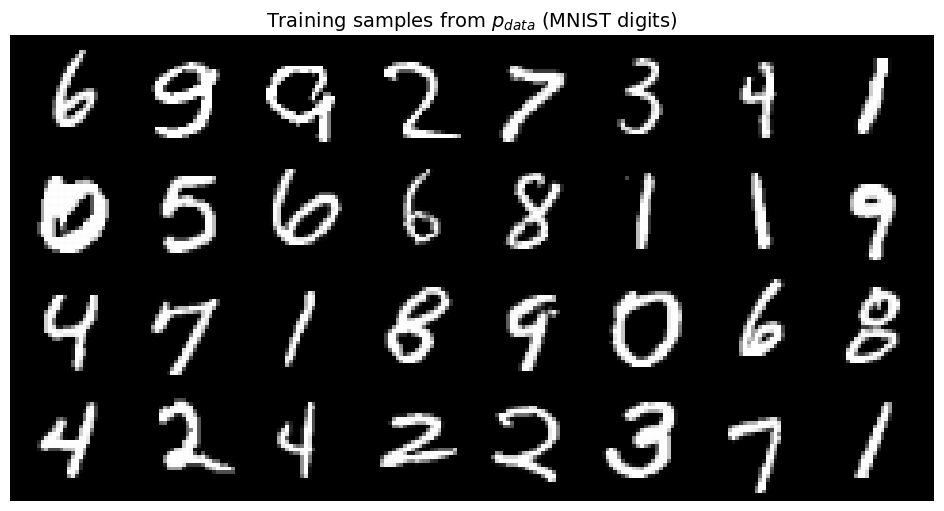

In [3]:
# Visualize some training samples
def show_images(images, nrow=8, title=""):
    """Display a grid of images."""
    # Denormalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

# Get a batch and visualize
sample_batch, _ = next(iter(train_loader))
show_images(sample_batch[:32], title="Training samples from $p_{data}$ (MNIST digits)")

## Step 2: The Forward Process (Data → Noise)

Let's implement and visualize the interpolation path from data to noise.

### The Interpolation Formula

For a data point $x_0$ and noise sample $x_1 \sim \mathcal{N}(0, I)$:

$$x_t = (1-t) \cdot x_0 + t \cdot x_1$$

### Geometric Picture

Think of each image as a point in 784-dimensional space (one dimension per pixel):
- $x_0$ lives on the "data manifold" - the region where realistic digits reside
- $x_1$ is a random point in space (Gaussian noise spreads throughout)
- $x_t$ traces a straight line between them

During training, we'll show the network samples $x_t$ at random timesteps and ask it to predict which direction leads toward noise.

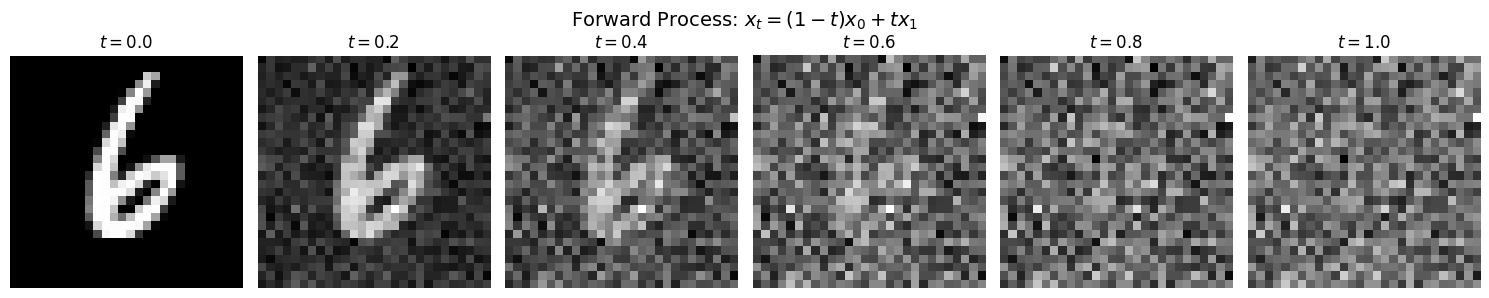


Watch how the digit structure gradually dissolves into noise.
Our model will learn to reverse this process.


In [4]:
from from_noise_to_images.flow import FlowMatching

flow = FlowMatching()

# Take one image and show its path to noise
x_0 = sample_batch[0:1]  # Shape: (1, 1, 28, 28)
x_1 = torch.randn_like(x_0)  # Sample noise ~ N(0, I)

# Show interpolation at different timesteps
timesteps = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
interpolated = []

for t in timesteps:
    t_tensor = torch.tensor([t])
    x_t, velocity = flow.forward_process(x_0, x_1, t_tensor)
    interpolated.append(x_t)

# Visualize
fig, axes = plt.subplots(1, len(timesteps), figsize=(15, 3))
for i, (ax, t) in enumerate(zip(axes, timesteps)):
    img = (interpolated[i][0, 0] + 1) / 2  # Denormalize
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f'$t = {t}$', fontsize=12)
    ax.axis('off')
    
    # Add equation annotation
    if t == 0.0:
        ax.set_xlabel('$x_0$ (data)', fontsize=10)
    elif t == 1.0:
        ax.set_xlabel('$x_1$ (noise)', fontsize=10)
    elif t == 0.5:
        ax.set_xlabel('$0.5 x_0 + 0.5 x_1$', fontsize=10)

plt.suptitle('Forward Process: $x_t = (1-t) x_0 + t x_1$', fontsize=14)
plt.tight_layout()
plt.show()

print("\nWatch how the digit structure gradually dissolves into noise.")
print("Our model will learn to reverse this process.")

## Step 3: Understanding the Velocity Field

### Deriving the Velocity

The velocity is the time derivative of our interpolation:

$$v = \frac{dx_t}{dt} = \frac{d}{dt}\left[(1-t) x_0 + t x_1\right]$$

Let's work through this carefully:

$$v = \frac{d}{dt}[(1-t)] \cdot x_0 + (1-t) \cdot \frac{d}{dt}[x_0] + \frac{d}{dt}[t] \cdot x_1 + t \cdot \frac{d}{dt}[x_1]$$

Since $x_0$ and $x_1$ are constants (they don't depend on $t$):

$$v = (-1) \cdot x_0 + 0 + (1) \cdot x_1 + 0 = x_1 - x_0$$

### The Key Property: Constant Velocity

Notice that $v = x_1 - x_0$ has no $t$ in it. This means:

| Property | Implication |
|----------|-------------|
| Velocity is constant | Samples travel in straight lines |
| Same velocity at all $t$ | No acceleration, no curved paths |
| $v = x_1 - x_0$ | Velocity encodes the displacement from data to noise |

### What Does the Velocity Look Like?

Since $v = x_1 - x_0$ (pixel-wise subtraction):
- Where noise is brighter than data ($x_1 > x_0$): positive velocity (pixel brightens)
- Where noise is darker than data ($x_1 < x_0$): negative velocity (pixel darkens)
- The velocity is essentially a "difference image"

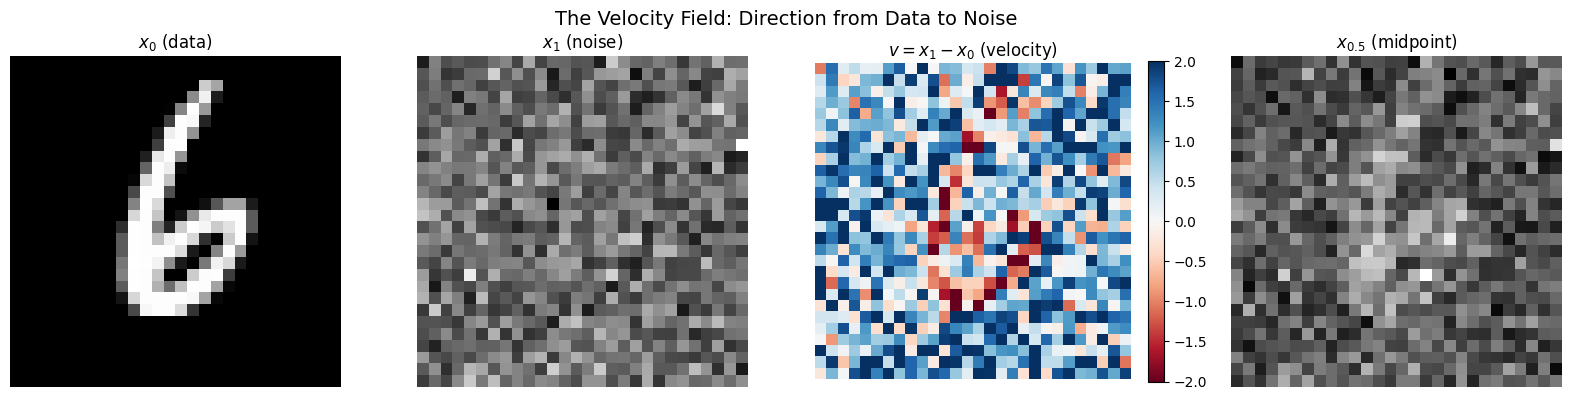


Interpreting the velocity:
• Red: noise brighter than data → positive velocity
• Blue: noise darker than data → negative velocity
• White: similar values → near-zero velocity


In [5]:
# Compute and visualize the velocity field for a single example
t_tensor = torch.tensor([0.5])  # Timestep doesn't matter for velocity!
x_t, velocity = flow.forward_process(x_0, x_1, t_tensor)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Data point x_0
axes[0].imshow((x_0[0, 0] + 1) / 2, cmap='gray')
axes[0].set_title('$x_0$ (data)', fontsize=12)
axes[0].axis('off')

# Noise point x_1
axes[1].imshow((x_1[0, 0] + 1) / 2, cmap='gray')
axes[1].set_title('$x_1$ (noise)', fontsize=12)
axes[1].axis('off')

# Velocity v = x_1 - x_0
v_display = velocity[0, 0].numpy()
im = axes[2].imshow(v_display, cmap='RdBu', vmin=-2, vmax=2)
axes[2].set_title('$v = x_1 - x_0$ (velocity)', fontsize=12)
axes[2].axis('off')
plt.colorbar(im, ax=axes[2], fraction=0.046)

# Interpolated sample at t=0.5
axes[3].imshow((x_t[0, 0] + 1) / 2, cmap='gray')
axes[3].set_title('$x_{0.5}$ (midpoint)', fontsize=12)
axes[3].axis('off')

plt.suptitle('The Velocity Field: Direction from Data to Noise', fontsize=14)
plt.tight_layout()
plt.show()

print("\nInterpreting the velocity:")
print("• Red: noise brighter than data → positive velocity")
print("• Blue: noise darker than data → negative velocity")
print("• White: similar values → near-zero velocity")

In [6]:
# Verify: velocity is constant at all timesteps
print("Verifying that velocity is constant along the path...")
print()

for t in [0.0, 0.25, 0.5, 0.75, 1.0]:
    t_tensor = torch.tensor([t])
    _, v = flow.forward_process(x_0, x_1, t_tensor)
    v_norm = torch.norm(v).item()
    print(f"t = {t:.2f}: ||v|| = {v_norm:.4f}")

print()
print("✓ Velocity norm is identical at all timesteps!")
print("  This confirms v = x₁ - x₀ doesn't depend on t.")

Verifying that velocity is constant along the path...

t = 0.00: ||v|| = 39.2340
t = 0.25: ||v|| = 39.2340
t = 0.50: ||v|| = 39.2340
t = 0.75: ||v|| = 39.2340
t = 1.00: ||v|| = 39.2340

✓ Velocity norm is identical at all timesteps!
  This confirms v = x₁ - x₀ doesn't depend on t.


## Step 4: The Neural Network Architecture

We need a neural network $v_\theta(x_t, t)$ that:
- **Input**: Noised image $x_t$ (28×28×1) + timestep $t$ (scalar)
- **Output**: Predicted velocity $\hat{v}$ (28×28×1, same shape as input)

### U-Net: The Classic Choice

We use a **U-Net**, a proven architecture for image-to-image tasks:

```
Input (28×28) ──┐                      ┌── Output (28×28)
                ▼                      ▲
            [Encoder]              [Decoder]
                │                      │
           downsample              upsample
                │                      │
                ▼                      ▲
            (14×14)    ──────────>  (14×14)  ← skip connection
                │                      │
           downsample              upsample
                │                      │
                ▼                      ▲
             (7×7)     ──────────>   (7×7)   ← skip connection
                │                      │
                └─────> bottleneck ────┘
```

**Why U-Net?** The skip connections let fine-grained details flow directly to the output, while the bottleneck captures global context.

### Timestep Conditioning

The network needs to know the current timestep $t$. A scalar isn't expressive enough, so we use **sinusoidal positional encoding** (from the Transformer paper):

$$\text{emb}(t) = \left[\sin(\omega_1 t), \cos(\omega_1 t), \sin(\omega_2 t), \cos(\omega_2 t), \ldots\right]$$

where $\omega_i = 10000^{-2i/d}$ spans multiple frequencies. This rich embedding is projected and added to the network's feature maps at each layer.

In [7]:
from from_noise_to_images.models import SimpleUNet

model = SimpleUNet(
    in_channels=1,       # Grayscale images
    model_channels=64,   # Base channel count (doubled at each level)
    time_emb_dim=128,    # Timestep embedding dimension
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")
print(f"\nThis is relatively small - larger models give better quality.")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)

with torch.no_grad():
    test_out = model(test_x, test_t)

print(f"\nForward pass test:")
print(f"  Input shape:  {test_x.shape}  (batch, channels, height, width)")
print(f"  Timestep:     {test_t.shape}  (batch,)")
print(f"  Output shape: {test_out.shape}  (same as input - velocity at each pixel)")

Model parameters: 1,837,185

This is relatively small - larger models give better quality.



Forward pass test:
  Input shape:  torch.Size([4, 1, 28, 28])  (batch, channels, height, width)
  Timestep:     torch.Size([4])  (batch,)
  Output shape: torch.Size([4, 1, 28, 28])  (same as input - velocity at each pixel)


## Step 5: Training the Velocity Predictor

### The Training Loop

For each training step:

1. **Sample data**: $x_0 \sim p_{\text{data}}$ (batch of real digits)
2. **Sample noise**: $x_1 \sim \mathcal{N}(0, I)$ (same shape as $x_0$)
3. **Sample timestep**: $t \sim \text{Uniform}[0, 1]$
4. **Compute interpolation**: $x_t = (1-t) x_0 + t x_1$
5. **Compute true velocity**: $v = x_1 - x_0$
6. **Predict velocity**: $\hat{v} = v_\theta(x_t, t)$
7. **Compute loss**: $\mathcal{L} = \|\hat{v} - v\|^2$ (MSE)
8. **Update weights**: Backprop and optimizer step

### Why Does This Work?

The model sees many triplets $(x_t, t) \to v$:
- Different data points $x_0$
- Different noise samples $x_1$
- Different timesteps $t$

It learns patterns like:
- "At $t \approx 1$ (mostly noise), velocities point toward structure"
- "At $t \approx 0$ (mostly data), velocities are small adjustments"

The key insight: by learning the **conditional expectation** of velocity given $x_t$ and $t$, the model implicitly learns the marginal distribution $p_t$ at each timestep.

(There's deep theory here connecting to optimal transport and continuity equations, but the practical algorithm is beautifully simple.)

In [8]:
from from_noise_to_images.train import Trainer

# Create trainer
trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,           # Learning rate
    weight_decay=0.01, # Regularization
    device=device,
)

# Train
NUM_EPOCHS = 30  # Increase to 50+ for better quality

print("Training the velocity prediction network...")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Batches per epoch: {len(train_loader)}")
print()

losses = trainer.train(num_epochs=NUM_EPOCHS)

Training the velocity prediction network...
Epochs: 30
Batch size: 128
Batches per epoch: 468

Training on cuda
Model parameters: 1,837,185


Epoch 1/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 1/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=2.4208]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<03:01,  2.57it/s, loss=2.4208]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<03:01,  2.57it/s, loss=1.8324]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<03:01,  2.57it/s, loss=1.5194]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<03:01,  2.57it/s, loss=1.3294]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:49,  9.40it/s, loss=1.3294]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:49,  9.40it/s, loss=1.2069]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:49,  9.40it/s, loss=1.1618]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:49,  9.40it/s, loss=1.0853]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:32, 14.36it/s, loss=1.0853]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:32, 14.36it/s, loss=1.0297]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:32, 14.36it/s, loss=0.9662]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:32, 14.36it/s, loss=0.9394]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 17.98it/s, loss=0.9394]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 17.98it/s, loss=0.8876]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 17.98it/s, loss=0.8864]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 17.98it/s, loss=0.8334]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 20.47it/s, loss=0.8334]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 20.47it/s, loss=0.7964]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 20.47it/s, loss=0.7368]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 20.47it/s, loss=0.7257]

Epoch 1/30:   3%|██                                                          | 16/468 [00:00<00:20, 22.30it/s, loss=0.7257]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:20, 22.30it/s, loss=0.7492]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:20, 22.30it/s, loss=0.7645]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:20, 22.30it/s, loss=0.7143]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:19, 23.59it/s, loss=0.7143]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:19, 23.59it/s, loss=0.6947]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:19, 23.59it/s, loss=0.6658]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:19, 23.59it/s, loss=0.6645]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:18, 24.51it/s, loss=0.6645]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:18, 24.51it/s, loss=0.6621]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:18, 24.51it/s, loss=0.6629]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:18, 24.51it/s, loss=0.6448]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:17, 25.17it/s, loss=0.6448]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:17, 25.17it/s, loss=0.6568]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:17, 25.17it/s, loss=0.6401]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:17, 25.17it/s, loss=0.6548]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:17, 25.50it/s, loss=0.6548]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:17, 25.50it/s, loss=0.6244]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:17, 25.50it/s, loss=0.5935]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:17, 25.50it/s, loss=0.6276]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:16, 25.88it/s, loss=0.6276]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:16, 25.88it/s, loss=0.5977]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:16, 25.88it/s, loss=0.6013]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:16, 25.88it/s, loss=0.5786]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:16, 26.15it/s, loss=0.5786]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:16, 26.15it/s, loss=0.5885]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:16, 26.15it/s, loss=0.5628]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:16, 26.15it/s, loss=0.5584]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:16, 26.33it/s, loss=0.5584]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:16, 26.33it/s, loss=0.5503]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:16, 26.33it/s, loss=0.5543]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:16, 26.33it/s, loss=0.5524]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:16, 26.46it/s, loss=0.5524]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:16, 26.46it/s, loss=0.5559]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:16, 26.46it/s, loss=0.5407]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:16, 26.46it/s, loss=0.5361]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:01<00:16, 26.47it/s, loss=0.5361]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:16, 26.47it/s, loss=0.5218]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:16, 26.47it/s, loss=0.5322]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:16, 26.47it/s, loss=0.5290]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:15, 26.58it/s, loss=0.5290]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:15, 26.58it/s, loss=0.5442]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:15, 26.58it/s, loss=0.5506]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:15, 26.58it/s, loss=0.5191]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:15, 26.65it/s, loss=0.5191]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:15, 26.65it/s, loss=0.4872]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:15, 26.65it/s, loss=0.5077]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:15, 26.65it/s, loss=0.4928]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:15, 26.65it/s, loss=0.4928]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:15, 26.65it/s, loss=0.5163]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:15, 26.65it/s, loss=0.4948]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:15, 26.65it/s, loss=0.4927]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:15, 26.64it/s, loss=0.4927]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:15, 26.64it/s, loss=0.5091]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:15, 26.64it/s, loss=0.4744]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:15, 26.64it/s, loss=0.5127]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:15, 26.65it/s, loss=0.5127]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:15, 26.65it/s, loss=0.4772]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:15, 26.65it/s, loss=0.4878]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:15, 26.65it/s, loss=0.4818]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:15, 26.66it/s, loss=0.4818]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:15, 26.66it/s, loss=0.4735]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:15, 26.66it/s, loss=0.4910]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:15, 26.66it/s, loss=0.4600]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:02<00:15, 26.69it/s, loss=0.4600]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:02<00:15, 26.69it/s, loss=0.4815]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:02<00:15, 26.69it/s, loss=0.4559]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:02<00:15, 26.69it/s, loss=0.4324]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:02<00:15, 26.70it/s, loss=0.4324]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:02<00:15, 26.70it/s, loss=0.4627]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:02<00:15, 26.70it/s, loss=0.4402]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:02<00:15, 26.70it/s, loss=0.4279]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:02<00:14, 26.70it/s, loss=0.4279]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:14, 26.70it/s, loss=0.4400]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:14, 26.70it/s, loss=0.4485]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:14, 26.70it/s, loss=0.4413]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:14, 26.69it/s, loss=0.4413]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:14, 26.69it/s, loss=0.3945]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:14, 26.69it/s, loss=0.4471]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:14, 26.69it/s, loss=0.4444]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:14, 26.69it/s, loss=0.4444]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:14, 26.69it/s, loss=0.4254]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:14, 26.69it/s, loss=0.4342]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:14, 26.69it/s, loss=0.4250]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:14, 26.60it/s, loss=0.4250]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:14, 26.60it/s, loss=0.4458]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:14, 26.60it/s, loss=0.4056]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:14, 26.60it/s, loss=0.4384]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:14, 26.63it/s, loss=0.4384]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:14, 26.63it/s, loss=0.4294]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:14, 26.63it/s, loss=0.3934]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:14, 26.63it/s, loss=0.4135]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:14, 26.65it/s, loss=0.4135]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:14, 26.65it/s, loss=0.4304]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:14, 26.65it/s, loss=0.4182]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:14, 26.65it/s, loss=0.4154]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:03<00:14, 26.70it/s, loss=0.4154]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:03<00:14, 26.70it/s, loss=0.4006]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:03<00:14, 26.70it/s, loss=0.4283]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:03<00:14, 26.70it/s, loss=0.4088]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:03<00:14, 26.72it/s, loss=0.4088]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:03<00:14, 26.72it/s, loss=0.4381]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:03<00:14, 26.72it/s, loss=0.3793]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:03<00:14, 26.72it/s, loss=0.4118]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:03<00:14, 26.68it/s, loss=0.4118]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:03<00:14, 26.68it/s, loss=0.4017]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:03<00:14, 26.68it/s, loss=0.3906]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:03<00:14, 26.68it/s, loss=0.3752]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:03<00:13, 26.68it/s, loss=0.3752]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:13, 26.68it/s, loss=0.3883]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:13, 26.68it/s, loss=0.4044]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:13, 26.68it/s, loss=0.3875]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:13, 26.83it/s, loss=0.3875]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:13, 26.83it/s, loss=0.3957]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:13, 26.83it/s, loss=0.3971]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:13, 26.83it/s, loss=0.3791]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:13, 26.86it/s, loss=0.3791]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:13, 26.86it/s, loss=0.3986]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:13, 26.86it/s, loss=0.3805]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:13, 26.86it/s, loss=0.4069]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:13, 26.90it/s, loss=0.4069]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:13, 26.90it/s, loss=0.3912]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:13, 26.90it/s, loss=0.3995]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:13, 26.90it/s, loss=0.3849]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:13, 26.89it/s, loss=0.3849]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:13, 26.89it/s, loss=0.3893]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:13, 26.89it/s, loss=0.3779]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:13, 26.89it/s, loss=0.3758]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:04<00:13, 26.81it/s, loss=0.3758]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:04<00:13, 26.81it/s, loss=0.3588]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:04<00:13, 26.81it/s, loss=0.3738]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:04<00:13, 26.81it/s, loss=0.3694]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:04<00:13, 26.86it/s, loss=0.3694]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:04<00:13, 26.86it/s, loss=0.3799]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:04<00:13, 26.86it/s, loss=0.3718]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:04<00:13, 26.86it/s, loss=0.3748]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:04<00:13, 26.90it/s, loss=0.3748]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:04<00:13, 26.90it/s, loss=0.3525]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:04<00:13, 26.90it/s, loss=0.3614]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:04<00:13, 26.90it/s, loss=0.3619]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:04<00:12, 26.85it/s, loss=0.3619]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:04<00:12, 26.85it/s, loss=0.3427]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:04<00:12, 26.85it/s, loss=0.3577]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:12, 26.85it/s, loss=0.3527]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:12, 26.79it/s, loss=0.3527]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:12, 26.79it/s, loss=0.3693]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:12, 26.79it/s, loss=0.3470]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:12, 26.79it/s, loss=0.3561]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:12, 26.78it/s, loss=0.3561]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:12, 26.78it/s, loss=0.3561]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:12, 26.78it/s, loss=0.3765]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:12, 26.78it/s, loss=0.3839]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:12, 26.75it/s, loss=0.3839]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:12, 26.75it/s, loss=0.3599]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:12, 26.75it/s, loss=0.3495]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:12, 26.75it/s, loss=0.3411]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:05<00:12, 26.75it/s, loss=0.3411]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:05<00:12, 26.75it/s, loss=0.3644]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:05<00:12, 26.75it/s, loss=0.3512]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:05<00:12, 26.75it/s, loss=0.3477]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:05<00:12, 26.75it/s, loss=0.3477]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:05<00:12, 26.75it/s, loss=0.3664]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:05<00:12, 26.75it/s, loss=0.3729]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:05<00:12, 26.75it/s, loss=0.3368]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:05<00:12, 26.75it/s, loss=0.3368]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:05<00:12, 26.75it/s, loss=0.3429]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:05<00:12, 26.75it/s, loss=0.3175]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:05<00:12, 26.75it/s, loss=0.3543]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:05<00:12, 26.75it/s, loss=0.3543]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:05<00:12, 26.75it/s, loss=0.3444]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:05<00:12, 26.75it/s, loss=0.3303]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:05<00:12, 26.75it/s, loss=0.3542]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:05<00:12, 26.72it/s, loss=0.3542]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:05<00:12, 26.72it/s, loss=0.3375]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:05<00:12, 26.72it/s, loss=0.3360]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:05<00:12, 26.72it/s, loss=0.3186]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:05<00:11, 26.70it/s, loss=0.3186]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:05<00:11, 26.70it/s, loss=0.3297]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:05<00:11, 26.70it/s, loss=0.3333]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:11, 26.70it/s, loss=0.3406]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:11, 26.71it/s, loss=0.3406]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:11, 26.71it/s, loss=0.3512]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:11, 26.71it/s, loss=0.3256]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:11, 26.71it/s, loss=0.3210]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:11, 26.71it/s, loss=0.3210]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:11, 26.71it/s, loss=0.3328]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:11, 26.71it/s, loss=0.3299]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:11, 26.71it/s, loss=0.3264]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:06<00:11, 26.70it/s, loss=0.3264]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:06<00:11, 26.70it/s, loss=0.3397]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:06<00:11, 26.70it/s, loss=0.3379]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:06<00:11, 26.70it/s, loss=0.3543]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:06<00:11, 26.70it/s, loss=0.3543]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:06<00:11, 26.70it/s, loss=0.3024]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:06<00:11, 26.70it/s, loss=0.3403]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:06<00:11, 26.70it/s, loss=0.3354]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:06<00:11, 26.68it/s, loss=0.3354]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:06<00:11, 26.68it/s, loss=0.3449]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:06<00:11, 26.68it/s, loss=0.3204]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:06<00:11, 26.68it/s, loss=0.3171]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:06<00:11, 26.65it/s, loss=0.3171]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:06<00:11, 26.65it/s, loss=0.3247]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:06<00:11, 26.65it/s, loss=0.3081]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:06<00:11, 26.65it/s, loss=0.3239]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:06<00:11, 26.59it/s, loss=0.3239]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:06<00:11, 26.59it/s, loss=0.3332]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:06<00:11, 26.59it/s, loss=0.3472]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:06<00:11, 26.59it/s, loss=0.3415]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:06<00:11, 26.60it/s, loss=0.3415]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:06<00:11, 26.60it/s, loss=0.3446]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:06<00:11, 26.60it/s, loss=0.3124]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:06<00:11, 26.60it/s, loss=0.3175]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:06<00:11, 26.62it/s, loss=0.3175]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:06<00:11, 26.62it/s, loss=0.3351]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:06<00:11, 26.62it/s, loss=0.3183]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:11, 26.62it/s, loss=0.3213]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:10, 26.63it/s, loss=0.3213]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:10, 26.63it/s, loss=0.3405]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:10, 26.63it/s, loss=0.3003]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:10, 26.63it/s, loss=0.3106]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:07<00:10, 26.66it/s, loss=0.3106]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:07<00:10, 26.66it/s, loss=0.3259]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:07<00:10, 26.66it/s, loss=0.3070]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:07<00:10, 26.66it/s, loss=0.3194]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:07<00:10, 26.68it/s, loss=0.3194]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:07<00:10, 26.68it/s, loss=0.3184]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:07<00:10, 26.68it/s, loss=0.3114]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:07<00:10, 26.68it/s, loss=0.3301]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:07<00:10, 26.71it/s, loss=0.3301]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:07<00:10, 26.71it/s, loss=0.3325]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:07<00:10, 26.71it/s, loss=0.3178]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:07<00:10, 26.71it/s, loss=0.2944]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:07<00:10, 26.69it/s, loss=0.2944]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:07<00:10, 26.69it/s, loss=0.3218]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:07<00:10, 26.69it/s, loss=0.3159]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:07<00:10, 26.69it/s, loss=0.3063]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:07<00:10, 26.70it/s, loss=0.3063]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:07<00:10, 26.70it/s, loss=0.3133]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:07<00:10, 26.70it/s, loss=0.3031]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:07<00:10, 26.70it/s, loss=0.2902]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:07<00:10, 26.73it/s, loss=0.2902]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:07<00:10, 26.73it/s, loss=0.2876]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:07<00:10, 26.73it/s, loss=0.3032]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:07<00:10, 26.73it/s, loss=0.3184]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:07<00:10, 26.72it/s, loss=0.3184]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:07<00:10, 26.72it/s, loss=0.3159]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:07<00:10, 26.72it/s, loss=0.2940]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:07<00:10, 26.72it/s, loss=0.3048]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:07<00:09, 26.71it/s, loss=0.3048]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:07<00:09, 26.71it/s, loss=0.2991]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:08<00:09, 26.71it/s, loss=0.3143]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:08<00:09, 26.71it/s, loss=0.3192]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:08<00:09, 26.71it/s, loss=0.3192]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:08<00:09, 26.71it/s, loss=0.2898]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:08<00:09, 26.71it/s, loss=0.2895]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:08<00:09, 26.71it/s, loss=0.3040]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:08<00:09, 26.66it/s, loss=0.3040]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:08<00:09, 26.66it/s, loss=0.3039]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:08<00:09, 26.66it/s, loss=0.2941]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:08<00:09, 26.66it/s, loss=0.3122]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:08<00:09, 26.65it/s, loss=0.3122]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:08<00:09, 26.65it/s, loss=0.2813]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:08<00:09, 26.65it/s, loss=0.2914]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:08<00:09, 26.65it/s, loss=0.2938]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:08<00:09, 26.65it/s, loss=0.2938]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:08<00:09, 26.65it/s, loss=0.3021]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:08<00:09, 26.65it/s, loss=0.3093]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:08<00:09, 26.65it/s, loss=0.2887]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:08<00:09, 26.66it/s, loss=0.2887]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:08<00:09, 26.66it/s, loss=0.3073]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:08<00:09, 26.66it/s, loss=0.2796]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:08<00:09, 26.66it/s, loss=0.2887]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:08<00:09, 26.65it/s, loss=0.2887]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:08<00:09, 26.65it/s, loss=0.2853]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:08<00:09, 26.65it/s, loss=0.2994]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:08<00:09, 26.65it/s, loss=0.2963]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:08<00:09, 26.66it/s, loss=0.2963]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:08<00:09, 26.66it/s, loss=0.2950]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:08<00:09, 26.66it/s, loss=0.3028]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:08<00:09, 26.66it/s, loss=0.3205]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:08<00:09, 26.70it/s, loss=0.3205]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:08<00:09, 26.70it/s, loss=0.2957]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:08<00:09, 26.70it/s, loss=0.2876]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:08<00:09, 26.70it/s, loss=0.2878]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:08<00:08, 26.69it/s, loss=0.2878]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:08<00:08, 26.69it/s, loss=0.2741]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:09<00:08, 26.69it/s, loss=0.2781]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:09<00:08, 26.69it/s, loss=0.2856]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:09<00:08, 26.74it/s, loss=0.2856]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:09<00:08, 26.74it/s, loss=0.2987]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:09<00:08, 26.74it/s, loss=0.2959]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:09<00:08, 26.74it/s, loss=0.2842]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:09<00:08, 26.74it/s, loss=0.2842]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:09<00:08, 26.74it/s, loss=0.3107]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:09<00:08, 26.74it/s, loss=0.3048]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:09<00:08, 26.74it/s, loss=0.3124]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:09<00:08, 26.72it/s, loss=0.3124]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:09<00:08, 26.72it/s, loss=0.2815]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:09<00:08, 26.72it/s, loss=0.2741]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:09<00:08, 26.72it/s, loss=0.2948]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:09<00:08, 26.72it/s, loss=0.2948]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:09<00:08, 26.72it/s, loss=0.2850]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:09<00:08, 26.72it/s, loss=0.2937]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:09<00:08, 26.72it/s, loss=0.2893]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:09<00:08, 26.76it/s, loss=0.2893]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:09<00:08, 26.76it/s, loss=0.2817]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:09<00:08, 26.76it/s, loss=0.2874]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:09<00:08, 26.76it/s, loss=0.2890]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:09<00:08, 26.74it/s, loss=0.2890]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:09<00:08, 26.74it/s, loss=0.2946]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:09<00:08, 26.74it/s, loss=0.2808]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:09<00:08, 26.74it/s, loss=0.2866]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:09<00:08, 26.73it/s, loss=0.2866]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:09<00:08, 26.73it/s, loss=0.3008]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:09<00:08, 26.73it/s, loss=0.3026]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:09<00:08, 26.73it/s, loss=0.2841]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:09<00:08, 26.75it/s, loss=0.2841]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:09<00:08, 26.75it/s, loss=0.2941]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:09<00:08, 26.75it/s, loss=0.3009]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:09<00:08, 26.75it/s, loss=0.3049]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:09<00:07, 26.73it/s, loss=0.3049]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:09<00:07, 26.73it/s, loss=0.2875]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:10<00:07, 26.73it/s, loss=0.2678]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:10<00:07, 26.73it/s, loss=0.2944]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:10<00:07, 26.73it/s, loss=0.2944]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:10<00:07, 26.73it/s, loss=0.3066]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:10<00:07, 26.73it/s, loss=0.2815]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:10<00:07, 26.73it/s, loss=0.2951]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:10<00:07, 26.73it/s, loss=0.2951]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:10<00:07, 26.73it/s, loss=0.2906]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:10<00:07, 26.73it/s, loss=0.3143]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:10<00:07, 26.73it/s, loss=0.2826]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:10<00:07, 26.73it/s, loss=0.2826]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:10<00:07, 26.73it/s, loss=0.2757]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:10<00:07, 26.73it/s, loss=0.2914]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:10<00:07, 26.73it/s, loss=0.3008]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:10<00:07, 26.72it/s, loss=0.3008]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:10<00:07, 26.72it/s, loss=0.2962]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:10<00:07, 26.72it/s, loss=0.2733]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:10<00:07, 26.72it/s, loss=0.2826]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:10<00:07, 26.72it/s, loss=0.2826]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:10<00:07, 26.72it/s, loss=0.2640]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:10<00:07, 26.72it/s, loss=0.3067]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:10<00:07, 26.72it/s, loss=0.2687]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:10<00:07, 26.75it/s, loss=0.2687]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:10<00:07, 26.75it/s, loss=0.2695]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:10<00:07, 26.75it/s, loss=0.2746]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:10<00:07, 26.75it/s, loss=0.2655]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:10<00:07, 26.64it/s, loss=0.2655]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:10<00:07, 26.64it/s, loss=0.2657]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:10<00:07, 26.64it/s, loss=0.2699]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:10<00:07, 26.64it/s, loss=0.2862]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:10<00:07, 26.67it/s, loss=0.2862]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:10<00:07, 26.67it/s, loss=0.2723]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:10<00:07, 26.67it/s, loss=0.2560]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:10<00:07, 26.67it/s, loss=0.2931]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:10<00:06, 26.70it/s, loss=0.2931]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:10<00:06, 26.70it/s, loss=0.2874]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:11<00:06, 26.70it/s, loss=0.2760]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:11<00:06, 26.70it/s, loss=0.2713]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:11<00:06, 26.73it/s, loss=0.2713]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:11<00:06, 26.73it/s, loss=0.2709]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:11<00:06, 26.73it/s, loss=0.2744]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:11<00:06, 26.73it/s, loss=0.2871]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:11<00:06, 26.75it/s, loss=0.2871]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:11<00:06, 26.75it/s, loss=0.2762]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:11<00:06, 26.75it/s, loss=0.2711]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:11<00:06, 26.75it/s, loss=0.2807]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:11<00:06, 26.75it/s, loss=0.2807]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:11<00:06, 26.75it/s, loss=0.2710]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:11<00:06, 26.75it/s, loss=0.2814]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:11<00:06, 26.75it/s, loss=0.2766]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:11<00:06, 26.71it/s, loss=0.2766]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:11<00:06, 26.71it/s, loss=0.2646]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:11<00:06, 26.71it/s, loss=0.2748]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:11<00:06, 26.71it/s, loss=0.2731]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:11<00:06, 26.71it/s, loss=0.2731]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:11<00:06, 26.71it/s, loss=0.2726]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:11<00:06, 26.71it/s, loss=0.2713]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:11<00:06, 26.71it/s, loss=0.2664]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:11<00:06, 26.73it/s, loss=0.2664]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:11<00:06, 26.73it/s, loss=0.2785]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:11<00:06, 26.73it/s, loss=0.2644]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:11<00:06, 26.73it/s, loss=0.2685]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:11<00:06, 26.72it/s, loss=0.2685]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:11<00:06, 26.72it/s, loss=0.2600]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:11<00:06, 26.72it/s, loss=0.2778]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:11<00:06, 26.72it/s, loss=0.2721]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:11<00:06, 26.64it/s, loss=0.2721]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:11<00:06, 26.64it/s, loss=0.2996]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:11<00:06, 26.64it/s, loss=0.2710]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:11<00:06, 26.64it/s, loss=0.2740]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:11<00:05, 26.68it/s, loss=0.2740]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:12<00:05, 26.68it/s, loss=0.2771]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:12<00:05, 26.68it/s, loss=0.2592]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:12<00:05, 26.68it/s, loss=0.2657]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:12<00:05, 26.73it/s, loss=0.2657]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:12<00:05, 26.73it/s, loss=0.2562]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:12<00:05, 26.73it/s, loss=0.2583]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:12<00:05, 26.73it/s, loss=0.2705]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:12<00:05, 26.87it/s, loss=0.2705]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:12<00:05, 26.87it/s, loss=0.2696]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:12<00:05, 26.87it/s, loss=0.2696]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:12<00:05, 26.87it/s, loss=0.2807]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:12<00:05, 26.93it/s, loss=0.2807]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:12<00:05, 26.93it/s, loss=0.2836]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:12<00:05, 26.93it/s, loss=0.2588]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:12<00:05, 26.93it/s, loss=0.2535]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:12<00:05, 26.91it/s, loss=0.2535]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:12<00:05, 26.91it/s, loss=0.2724]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:12<00:05, 26.91it/s, loss=0.2460]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:12<00:05, 26.91it/s, loss=0.2667]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:12<00:05, 26.94it/s, loss=0.2667]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:12<00:05, 26.94it/s, loss=0.2985]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:12<00:05, 26.94it/s, loss=0.2673]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:12<00:05, 26.94it/s, loss=0.2805]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:12<00:05, 26.87it/s, loss=0.2805]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:12<00:05, 26.87it/s, loss=0.2714]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:12<00:05, 26.87it/s, loss=0.2659]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:12<00:05, 26.87it/s, loss=0.2564]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:12<00:05, 26.89it/s, loss=0.2564]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:12<00:05, 26.89it/s, loss=0.2567]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:12<00:05, 26.89it/s, loss=0.2703]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:12<00:05, 26.89it/s, loss=0.2662]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:12<00:05, 26.78it/s, loss=0.2662]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:12<00:05, 26.78it/s, loss=0.2505]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:12<00:05, 26.78it/s, loss=0.2734]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:12<00:05, 26.78it/s, loss=0.2542]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:12<00:04, 26.84it/s, loss=0.2542]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:13<00:04, 26.84it/s, loss=0.2532]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:13<00:04, 26.84it/s, loss=0.2663]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:13<00:04, 26.84it/s, loss=0.2607]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:13<00:04, 26.88it/s, loss=0.2607]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:13<00:04, 26.88it/s, loss=0.2670]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:13<00:04, 26.88it/s, loss=0.2507]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:13<00:04, 26.88it/s, loss=0.2531]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:13<00:04, 26.90it/s, loss=0.2531]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:13<00:04, 26.90it/s, loss=0.2615]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:13<00:04, 26.90it/s, loss=0.2754]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:13<00:04, 26.90it/s, loss=0.2481]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:13<00:04, 26.86it/s, loss=0.2481]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:13<00:04, 26.86it/s, loss=0.2751]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:13<00:04, 26.86it/s, loss=0.2605]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:13<00:04, 26.86it/s, loss=0.2801]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:13<00:04, 26.95it/s, loss=0.2801]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:13<00:04, 26.95it/s, loss=0.2526]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:13<00:04, 26.95it/s, loss=0.2500]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:13<00:04, 26.95it/s, loss=0.2506]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:13<00:04, 27.02it/s, loss=0.2506]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:13<00:04, 27.02it/s, loss=0.2578]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:13<00:04, 27.02it/s, loss=0.2461]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:13<00:04, 27.02it/s, loss=0.2743]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:13<00:04, 26.97it/s, loss=0.2743]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:13<00:04, 26.97it/s, loss=0.2587]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:13<00:04, 26.97it/s, loss=0.2632]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:13<00:04, 26.97it/s, loss=0.2570]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:13<00:04, 26.89it/s, loss=0.2570]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:13<00:04, 26.89it/s, loss=0.2856]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:13<00:04, 26.89it/s, loss=0.2716]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:13<00:04, 26.89it/s, loss=0.2733]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:13<00:03, 26.89it/s, loss=0.2733]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:13<00:03, 26.89it/s, loss=0.2668]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:13<00:03, 26.89it/s, loss=0.2663]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:13<00:03, 26.89it/s, loss=0.2648]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:13<00:03, 26.73it/s, loss=0.2648]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:14<00:03, 26.73it/s, loss=0.2710]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:14<00:03, 26.73it/s, loss=0.2847]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:14<00:03, 26.73it/s, loss=0.2674]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:14<00:03, 26.38it/s, loss=0.2674]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:14<00:03, 26.38it/s, loss=0.2830]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:14<00:03, 26.38it/s, loss=0.2779]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:14<00:03, 26.38it/s, loss=0.2496]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:14<00:03, 26.44it/s, loss=0.2496]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:14<00:03, 26.44it/s, loss=0.2434]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:14<00:03, 26.44it/s, loss=0.2362]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:14<00:03, 26.44it/s, loss=0.2393]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:14<00:03, 26.55it/s, loss=0.2393]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:14<00:03, 26.55it/s, loss=0.2714]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:14<00:03, 26.55it/s, loss=0.2559]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:14<00:03, 26.55it/s, loss=0.2783]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:14<00:03, 26.68it/s, loss=0.2783]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:14<00:03, 26.68it/s, loss=0.2607]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:14<00:03, 26.68it/s, loss=0.2553]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:14<00:03, 26.68it/s, loss=0.2434]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:14<00:03, 26.78it/s, loss=0.2434]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:14<00:03, 26.78it/s, loss=0.2492]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:14<00:03, 26.78it/s, loss=0.2647]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:14<00:03, 26.78it/s, loss=0.2486]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:14<00:03, 26.84it/s, loss=0.2486]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:14<00:03, 26.84it/s, loss=0.2708]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:14<00:03, 26.84it/s, loss=0.2554]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:14<00:03, 26.84it/s, loss=0.2562]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:14<00:03, 26.82it/s, loss=0.2562]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:14<00:03, 26.82it/s, loss=0.2538]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:14<00:03, 26.82it/s, loss=0.2473]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:14<00:03, 26.82it/s, loss=0.2658]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:14<00:02, 26.74it/s, loss=0.2658]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:14<00:02, 26.74it/s, loss=0.2649]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:14<00:02, 26.74it/s, loss=0.2640]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:14<00:02, 26.74it/s, loss=0.2493]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:14<00:02, 26.78it/s, loss=0.2493]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:15<00:02, 26.78it/s, loss=0.2436]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:15<00:02, 26.78it/s, loss=0.2555]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:15<00:02, 26.78it/s, loss=0.2394]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:15<00:02, 26.75it/s, loss=0.2394]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:15<00:02, 26.75it/s, loss=0.2373]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:15<00:02, 26.75it/s, loss=0.2592]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:15<00:02, 26.75it/s, loss=0.2569]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:15<00:02, 26.78it/s, loss=0.2569]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:15<00:02, 26.78it/s, loss=0.2539]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:15<00:02, 26.78it/s, loss=0.2445]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:15<00:02, 26.78it/s, loss=0.2658]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:15<00:02, 26.77it/s, loss=0.2658]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:15<00:02, 26.77it/s, loss=0.2456]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:15<00:02, 26.77it/s, loss=0.2366]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:15<00:02, 26.77it/s, loss=0.2565]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:15<00:02, 26.80it/s, loss=0.2565]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:15<00:02, 26.80it/s, loss=0.2428]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:15<00:02, 26.80it/s, loss=0.2640]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:15<00:02, 26.80it/s, loss=0.2408]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:15<00:02, 26.79it/s, loss=0.2408]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:15<00:02, 26.79it/s, loss=0.2598]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:15<00:02, 26.79it/s, loss=0.2470]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:15<00:02, 26.79it/s, loss=0.2282]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:15<00:02, 26.78it/s, loss=0.2282]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:15<00:02, 26.78it/s, loss=0.2489]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:15<00:02, 26.78it/s, loss=0.2480]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:15<00:02, 26.78it/s, loss=0.2520]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:15<00:02, 26.72it/s, loss=0.2520]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:15<00:02, 26.72it/s, loss=0.2809]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:15<00:02, 26.72it/s, loss=0.2322]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:15<00:02, 26.72it/s, loss=0.2569]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:15<00:01, 26.67it/s, loss=0.2569]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:15<00:01, 26.67it/s, loss=0.2456]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:15<00:01, 26.67it/s, loss=0.2596]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:16<00:01, 26.67it/s, loss=0.2594]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:16<00:01, 26.62it/s, loss=0.2594]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:16<00:01, 26.62it/s, loss=0.2584]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:16<00:01, 26.62it/s, loss=0.2592]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:16<00:01, 26.62it/s, loss=0.2427]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:16<00:01, 26.55it/s, loss=0.2427]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:16<00:01, 26.55it/s, loss=0.2727]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:16<00:01, 26.55it/s, loss=0.2695]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:16<00:01, 26.55it/s, loss=0.2637]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:16<00:01, 26.59it/s, loss=0.2637]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:16<00:01, 26.59it/s, loss=0.2540]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:16<00:01, 26.59it/s, loss=0.2532]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:16<00:01, 26.59it/s, loss=0.2670]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:16<00:01, 26.62it/s, loss=0.2670]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:16<00:01, 26.62it/s, loss=0.2325]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:16<00:01, 26.62it/s, loss=0.2366]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:16<00:01, 26.62it/s, loss=0.2377]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:16<00:01, 26.71it/s, loss=0.2377]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:16<00:01, 26.71it/s, loss=0.2558]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:16<00:01, 26.71it/s, loss=0.2471]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:16<00:01, 26.71it/s, loss=0.2530]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:16<00:01, 26.75it/s, loss=0.2530]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:16<00:01, 26.75it/s, loss=0.2357]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:16<00:01, 26.75it/s, loss=0.2535]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:16<00:01, 26.75it/s, loss=0.2470]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:16<00:01, 26.74it/s, loss=0.2470]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:16<00:01, 26.74it/s, loss=0.2335]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:16<00:01, 26.74it/s, loss=0.2386]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:16<00:01, 26.74it/s, loss=0.2595]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:16<00:01, 26.76it/s, loss=0.2595]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:16<00:01, 26.76it/s, loss=0.2431]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:16<00:01, 26.76it/s, loss=0.2608]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:16<00:01, 26.76it/s, loss=0.2316]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:16<00:00, 26.74it/s, loss=0.2316]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:16<00:00, 26.74it/s, loss=0.2600]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:16<00:00, 26.74it/s, loss=0.2420]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:17<00:00, 26.74it/s, loss=0.2392]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:17<00:00, 26.62it/s, loss=0.2392]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:17<00:00, 26.62it/s, loss=0.2395]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:17<00:00, 26.62it/s, loss=0.2504]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:17<00:00, 26.62it/s, loss=0.2497]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:17<00:00, 26.69it/s, loss=0.2497]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:17<00:00, 26.69it/s, loss=0.2449]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:17<00:00, 26.69it/s, loss=0.2475]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:17<00:00, 26.69it/s, loss=0.2517]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:17<00:00, 26.64it/s, loss=0.2517]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:17<00:00, 26.64it/s, loss=0.2473]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:17<00:00, 26.64it/s, loss=0.2511]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:17<00:00, 26.64it/s, loss=0.2634]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:17<00:00, 26.61it/s, loss=0.2634]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:17<00:00, 26.61it/s, loss=0.2401]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:17<00:00, 26.61it/s, loss=0.2387]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:17<00:00, 26.61it/s, loss=0.2319]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:17<00:00, 26.64it/s, loss=0.2319]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:17<00:00, 26.64it/s, loss=0.2481]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:17<00:00, 26.64it/s, loss=0.2431]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:17<00:00, 26.64it/s, loss=0.2480]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:17<00:00, 26.64it/s, loss=0.2480]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:17<00:00, 26.64it/s, loss=0.2492]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:17<00:00, 26.64it/s, loss=0.2563]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:17<00:00, 26.64it/s, loss=0.2696]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:17<00:00, 26.64it/s, loss=0.2696]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:17<00:00, 26.64it/s, loss=0.2533]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:17<00:00, 26.64it/s, loss=0.2496]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:17<00:00, 26.64it/s, loss=0.2663]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:17<00:00, 26.48it/s, loss=0.2663]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:17<00:00, 26.48it/s, loss=0.2584]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:17<00:00, 26.48it/s, loss=0.2512]

Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.17it/s, loss=0.2512]

Epoch 1: avg_loss = 0.3574


Epoch 2/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2489]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2468]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2391]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.43it/s, loss=0.2391]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.43it/s, loss=0.2571]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.43it/s, loss=0.2417]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.43it/s, loss=0.2458]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.70it/s, loss=0.2458]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.70it/s, loss=0.2500]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.70it/s, loss=0.2478]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.70it/s, loss=0.2325]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.73it/s, loss=0.2325]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.73it/s, loss=0.2479]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.73it/s, loss=0.2379]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.73it/s, loss=0.2455]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.77it/s, loss=0.2455]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.77it/s, loss=0.2444]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.77it/s, loss=0.2521]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.77it/s, loss=0.2554]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.72it/s, loss=0.2554]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.72it/s, loss=0.2393]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.72it/s, loss=0.2400]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.72it/s, loss=0.2470]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.65it/s, loss=0.2470]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.65it/s, loss=0.2429]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.65it/s, loss=0.2316]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.65it/s, loss=0.2566]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.57it/s, loss=0.2566]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.57it/s, loss=0.2421]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.57it/s, loss=0.2361]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.57it/s, loss=0.2507]

Epoch 2/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.70it/s, loss=0.2507]

Epoch 2/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.70it/s, loss=0.2624]

Epoch 2/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.70it/s, loss=0.2307]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.70it/s, loss=0.2438]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.83it/s, loss=0.2438]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.83it/s, loss=0.2573]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.83it/s, loss=0.2457]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.83it/s, loss=0.2316]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2316]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2498]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2546]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2530]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.79it/s, loss=0.2530]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.79it/s, loss=0.2458]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.79it/s, loss=0.2504]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.79it/s, loss=0.2407]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.38it/s, loss=0.2407]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.38it/s, loss=0.2441]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.38it/s, loss=0.2478]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.38it/s, loss=0.2364]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.55it/s, loss=0.2364]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.55it/s, loss=0.2505]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.55it/s, loss=0.2772]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.55it/s, loss=0.2369]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.61it/s, loss=0.2369]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.61it/s, loss=0.2382]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.61it/s, loss=0.2335]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.61it/s, loss=0.2575]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.74it/s, loss=0.2575]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.74it/s, loss=0.2611]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.74it/s, loss=0.2829]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.74it/s, loss=0.2543]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.72it/s, loss=0.2543]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.72it/s, loss=0.2383]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.72it/s, loss=0.2475]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.72it/s, loss=0.2437]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.67it/s, loss=0.2437]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.67it/s, loss=0.2406]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.67it/s, loss=0.2422]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.67it/s, loss=0.2531]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.71it/s, loss=0.2531]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.71it/s, loss=0.2606]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.71it/s, loss=0.2306]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.71it/s, loss=0.2517]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.66it/s, loss=0.2517]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.66it/s, loss=0.2426]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.66it/s, loss=0.2508]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.66it/s, loss=0.2598]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.58it/s, loss=0.2598]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.58it/s, loss=0.2260]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.58it/s, loss=0.2373]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.58it/s, loss=0.2587]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.69it/s, loss=0.2587]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.69it/s, loss=0.2490]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.69it/s, loss=0.2288]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.69it/s, loss=0.2389]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.76it/s, loss=0.2389]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.76it/s, loss=0.2566]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.76it/s, loss=0.2403]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.76it/s, loss=0.2728]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.72it/s, loss=0.2728]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.72it/s, loss=0.2291]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.72it/s, loss=0.2429]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.72it/s, loss=0.2360]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.76it/s, loss=0.2360]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.76it/s, loss=0.2574]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.76it/s, loss=0.2501]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.76it/s, loss=0.2643]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.38it/s, loss=0.2643]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.38it/s, loss=0.2406]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.38it/s, loss=0.2679]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.38it/s, loss=0.2364]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.41it/s, loss=0.2364]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.41it/s, loss=0.2590]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.41it/s, loss=0.2338]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.41it/s, loss=0.2435]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.45it/s, loss=0.2435]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.45it/s, loss=0.2307]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.45it/s, loss=0.2409]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.45it/s, loss=0.2569]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.55it/s, loss=0.2569]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.55it/s, loss=0.2344]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.55it/s, loss=0.2243]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.55it/s, loss=0.2476]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.2476]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.2498]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.2351]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.2357]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2357]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2234]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2455]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2237]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.69it/s, loss=0.2237]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.69it/s, loss=0.2307]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.69it/s, loss=0.2475]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.69it/s, loss=0.2404]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.80it/s, loss=0.2404]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.80it/s, loss=0.2424]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.80it/s, loss=0.2268]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.80it/s, loss=0.2417]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.83it/s, loss=0.2417]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.83it/s, loss=0.2597]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.83it/s, loss=0.2508]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.83it/s, loss=0.2450]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.74it/s, loss=0.2450]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.74it/s, loss=0.2518]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.74it/s, loss=0.2357]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.74it/s, loss=0.2324]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.70it/s, loss=0.2324]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.70it/s, loss=0.2327]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.70it/s, loss=0.2187]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.70it/s, loss=0.2314]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.77it/s, loss=0.2314]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.77it/s, loss=0.2448]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.77it/s, loss=0.2325]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.77it/s, loss=0.2524]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.76it/s, loss=0.2524]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.76it/s, loss=0.2317]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.76it/s, loss=0.2430]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.76it/s, loss=0.2423]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.71it/s, loss=0.2423]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.71it/s, loss=0.2230]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.71it/s, loss=0.2181]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.71it/s, loss=0.2223]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.68it/s, loss=0.2223]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.68it/s, loss=0.2333]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.68it/s, loss=0.2466]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.68it/s, loss=0.2398]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.63it/s, loss=0.2398]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.63it/s, loss=0.2329]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.63it/s, loss=0.2410]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.63it/s, loss=0.2385]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.67it/s, loss=0.2385]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.67it/s, loss=0.2532]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.67it/s, loss=0.2379]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.67it/s, loss=0.2512]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.71it/s, loss=0.2512]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.71it/s, loss=0.2331]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.71it/s, loss=0.2372]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.71it/s, loss=0.2407]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.80it/s, loss=0.2407]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.80it/s, loss=0.2443]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.80it/s, loss=0.2239]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.80it/s, loss=0.2390]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.84it/s, loss=0.2390]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.84it/s, loss=0.2339]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.84it/s, loss=0.2275]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.84it/s, loss=0.2432]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.88it/s, loss=0.2432]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.88it/s, loss=0.2419]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.88it/s, loss=0.2363]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.88it/s, loss=0.2223]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.91it/s, loss=0.2223]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.91it/s, loss=0.2446]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.91it/s, loss=0.2508]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.91it/s, loss=0.2222]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.92it/s, loss=0.2222]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.92it/s, loss=0.2358]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.92it/s, loss=0.2362]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.92it/s, loss=0.2319]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.93it/s, loss=0.2319]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.93it/s, loss=0.2364]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.93it/s, loss=0.2261]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.93it/s, loss=0.2306]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2306]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2321]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2298]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2470]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.68it/s, loss=0.2470]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.68it/s, loss=0.2345]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.68it/s, loss=0.2304]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.68it/s, loss=0.2349]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.2349]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.2241]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.2160]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.2230]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.83it/s, loss=0.2230]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.83it/s, loss=0.2276]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.83it/s, loss=0.2414]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.83it/s, loss=0.2350]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.82it/s, loss=0.2350]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.82it/s, loss=0.2415]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.82it/s, loss=0.2179]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.82it/s, loss=0.2425]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.79it/s, loss=0.2425]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.79it/s, loss=0.2300]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.79it/s, loss=0.2232]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.79it/s, loss=0.2509]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.76it/s, loss=0.2509]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.76it/s, loss=0.2201]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.76it/s, loss=0.2269]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.76it/s, loss=0.2316]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.72it/s, loss=0.2316]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.72it/s, loss=0.2330]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.72it/s, loss=0.2329]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.72it/s, loss=0.2664]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.73it/s, loss=0.2664]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.73it/s, loss=0.2268]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.73it/s, loss=0.2194]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.73it/s, loss=0.2449]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.72it/s, loss=0.2449]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.72it/s, loss=0.2406]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.72it/s, loss=0.2291]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.72it/s, loss=0.2550]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.83it/s, loss=0.2550]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.83it/s, loss=0.2403]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.83it/s, loss=0.2266]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.83it/s, loss=0.2333]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.84it/s, loss=0.2333]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.84it/s, loss=0.2294]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.84it/s, loss=0.2324]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.84it/s, loss=0.2197]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.79it/s, loss=0.2197]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.79it/s, loss=0.2321]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.79it/s, loss=0.2251]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.79it/s, loss=0.2193]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.84it/s, loss=0.2193]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.84it/s, loss=0.2304]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.84it/s, loss=0.2429]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.84it/s, loss=0.2426]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.89it/s, loss=0.2426]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.89it/s, loss=0.2261]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.89it/s, loss=0.2534]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.89it/s, loss=0.2185]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.92it/s, loss=0.2185]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.92it/s, loss=0.2351]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.92it/s, loss=0.2453]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.92it/s, loss=0.2354]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.95it/s, loss=0.2354]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.95it/s, loss=0.2488]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.95it/s, loss=0.2418]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.95it/s, loss=0.2359]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.96it/s, loss=0.2359]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.96it/s, loss=0.2425]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.96it/s, loss=0.2539]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.96it/s, loss=0.2247]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.97it/s, loss=0.2247]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.97it/s, loss=0.2330]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.97it/s, loss=0.2313]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.97it/s, loss=0.2188]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.97it/s, loss=0.2188]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.97it/s, loss=0.2213]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.97it/s, loss=0.2219]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.97it/s, loss=0.2464]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.98it/s, loss=0.2464]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.98it/s, loss=0.2330]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.98it/s, loss=0.2187]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.98it/s, loss=0.2345]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.94it/s, loss=0.2345]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.94it/s, loss=0.2273]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.94it/s, loss=0.2428]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.94it/s, loss=0.2401]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.93it/s, loss=0.2401]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.93it/s, loss=0.2365]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.93it/s, loss=0.2294]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.93it/s, loss=0.2403]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.2403]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.2555]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.2280]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.2352]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.91it/s, loss=0.2352]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.91it/s, loss=0.2260]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.91it/s, loss=0.2287]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.91it/s, loss=0.2355]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.88it/s, loss=0.2355]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.88it/s, loss=0.2375]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.88it/s, loss=0.2402]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.88it/s, loss=0.2507]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.92it/s, loss=0.2507]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.92it/s, loss=0.2295]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.92it/s, loss=0.2448]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.92it/s, loss=0.2400]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.90it/s, loss=0.2400]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.90it/s, loss=0.2251]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.90it/s, loss=0.2162]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.90it/s, loss=0.2397]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.87it/s, loss=0.2397]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.87it/s, loss=0.2329]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.87it/s, loss=0.2531]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.87it/s, loss=0.2108]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.65it/s, loss=0.2108]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.65it/s, loss=0.2260]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.65it/s, loss=0.2381]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.65it/s, loss=0.2274]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.26it/s, loss=0.2274]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.26it/s, loss=0.2114]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.26it/s, loss=0.2439]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.26it/s, loss=0.2460]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:08<00:08, 26.33it/s, loss=0.2460]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.33it/s, loss=0.2461]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.33it/s, loss=0.2215]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.33it/s, loss=0.2375]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.2375]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.2252]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.2256]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.2329]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.53it/s, loss=0.2329]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.53it/s, loss=0.2264]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.53it/s, loss=0.2224]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.53it/s, loss=0.2290]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.65it/s, loss=0.2290]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.65it/s, loss=0.2277]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.65it/s, loss=0.2122]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.65it/s, loss=0.2268]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.2268]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.2255]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.2195]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.2133]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.2133]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.2381]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.2292]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.2336]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.2336]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.2224]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.2280]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.2182]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.66it/s, loss=0.2182]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.66it/s, loss=0.2178]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.66it/s, loss=0.2327]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.66it/s, loss=0.2259]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.73it/s, loss=0.2259]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.73it/s, loss=0.2276]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.73it/s, loss=0.2385]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.73it/s, loss=0.2207]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:09<00:07, 26.70it/s, loss=0.2207]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.70it/s, loss=0.2079]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.70it/s, loss=0.2279]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.70it/s, loss=0.2194]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.78it/s, loss=0.2194]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.78it/s, loss=0.2347]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.78it/s, loss=0.2494]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.78it/s, loss=0.2358]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.78it/s, loss=0.2358]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.78it/s, loss=0.2419]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.78it/s, loss=0.2259]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.78it/s, loss=0.2310]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.77it/s, loss=0.2310]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.77it/s, loss=0.2310]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.77it/s, loss=0.2232]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.77it/s, loss=0.2299]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.65it/s, loss=0.2299]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.65it/s, loss=0.2207]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.65it/s, loss=0.2232]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.65it/s, loss=0.2589]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.67it/s, loss=0.2589]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.67it/s, loss=0.2241]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.67it/s, loss=0.2087]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.67it/s, loss=0.2206]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.70it/s, loss=0.2206]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.70it/s, loss=0.2302]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.70it/s, loss=0.2465]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.70it/s, loss=0.2365]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.75it/s, loss=0.2365]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.75it/s, loss=0.2143]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.75it/s, loss=0.2251]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.75it/s, loss=0.2233]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.83it/s, loss=0.2233]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.83it/s, loss=0.2115]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.83it/s, loss=0.2392]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.83it/s, loss=0.2231]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:10<00:06, 26.82it/s, loss=0.2231]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.82it/s, loss=0.2195]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.82it/s, loss=0.2458]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.82it/s, loss=0.2314]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.78it/s, loss=0.2314]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.78it/s, loss=0.2197]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.78it/s, loss=0.2299]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.78it/s, loss=0.2281]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.83it/s, loss=0.2281]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.83it/s, loss=0.2178]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.83it/s, loss=0.2315]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.83it/s, loss=0.2354]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.69it/s, loss=0.2354]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.69it/s, loss=0.2183]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.69it/s, loss=0.2225]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.69it/s, loss=0.2336]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.62it/s, loss=0.2336]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.62it/s, loss=0.2135]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.62it/s, loss=0.2349]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.62it/s, loss=0.2301]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.60it/s, loss=0.2301]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.60it/s, loss=0.2205]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.60it/s, loss=0.2174]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.60it/s, loss=0.2248]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.68it/s, loss=0.2248]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.68it/s, loss=0.2427]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.68it/s, loss=0.2361]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.68it/s, loss=0.2227]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.51it/s, loss=0.2227]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.51it/s, loss=0.2295]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.51it/s, loss=0.2295]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.51it/s, loss=0.2321]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.62it/s, loss=0.2321]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.62it/s, loss=0.2431]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.62it/s, loss=0.2460]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.62it/s, loss=0.2064]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.62it/s, loss=0.2064]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.62it/s, loss=0.2289]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.62it/s, loss=0.2440]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.62it/s, loss=0.2233]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.69it/s, loss=0.2233]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.69it/s, loss=0.2356]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.69it/s, loss=0.2179]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.69it/s, loss=0.2184]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.78it/s, loss=0.2184]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.78it/s, loss=0.2342]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.78it/s, loss=0.2085]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.78it/s, loss=0.2297]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.71it/s, loss=0.2297]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.71it/s, loss=0.2380]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.71it/s, loss=0.2408]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.71it/s, loss=0.2210]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.44it/s, loss=0.2210]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.44it/s, loss=0.2309]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.44it/s, loss=0.2447]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.44it/s, loss=0.2314]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.50it/s, loss=0.2314]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.50it/s, loss=0.2443]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.50it/s, loss=0.2047]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.50it/s, loss=0.2158]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.2158]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.2130]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.2310]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.2197]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.59it/s, loss=0.2197]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.59it/s, loss=0.2311]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.59it/s, loss=0.2323]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.59it/s, loss=0.2330]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.63it/s, loss=0.2330]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.63it/s, loss=0.2186]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.63it/s, loss=0.2234]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.63it/s, loss=0.2204]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.65it/s, loss=0.2204]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.65it/s, loss=0.2223]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.65it/s, loss=0.2374]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.65it/s, loss=0.2154]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.62it/s, loss=0.2154]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.62it/s, loss=0.2204]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.62it/s, loss=0.2174]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.62it/s, loss=0.2229]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.66it/s, loss=0.2229]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.66it/s, loss=0.2160]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.66it/s, loss=0.2230]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.66it/s, loss=0.2387]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.68it/s, loss=0.2387]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.68it/s, loss=0.2230]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.68it/s, loss=0.2031]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.68it/s, loss=0.2375]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.75it/s, loss=0.2375]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.75it/s, loss=0.2192]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.75it/s, loss=0.2443]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.75it/s, loss=0.2235]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.72it/s, loss=0.2235]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.72it/s, loss=0.2142]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.72it/s, loss=0.2157]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.72it/s, loss=0.2160]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.58it/s, loss=0.2160]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.58it/s, loss=0.2186]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.58it/s, loss=0.2054]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.58it/s, loss=0.2168]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.56it/s, loss=0.2168]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.56it/s, loss=0.2082]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.56it/s, loss=0.2235]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.56it/s, loss=0.2431]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.66it/s, loss=0.2431]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.66it/s, loss=0.2447]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.66it/s, loss=0.2082]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.66it/s, loss=0.2201]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.71it/s, loss=0.2201]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.71it/s, loss=0.2301]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.71it/s, loss=0.2102]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.71it/s, loss=0.2192]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.80it/s, loss=0.2192]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.80it/s, loss=0.2311]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.80it/s, loss=0.2062]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.80it/s, loss=0.2326]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.82it/s, loss=0.2326]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.82it/s, loss=0.2106]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.82it/s, loss=0.2350]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.82it/s, loss=0.2287]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.82it/s, loss=0.2287]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.82it/s, loss=0.2218]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.82it/s, loss=0.2341]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.82it/s, loss=0.2040]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.82it/s, loss=0.2040]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.82it/s, loss=0.2460]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.82it/s, loss=0.2259]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.82it/s, loss=0.2288]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.84it/s, loss=0.2288]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.84it/s, loss=0.2282]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.84it/s, loss=0.2346]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.84it/s, loss=0.2350]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.84it/s, loss=0.2350]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.84it/s, loss=0.2077]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.84it/s, loss=0.2382]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.84it/s, loss=0.2179]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.79it/s, loss=0.2179]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.79it/s, loss=0.2223]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.79it/s, loss=0.2382]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.79it/s, loss=0.2305]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.77it/s, loss=0.2305]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.77it/s, loss=0.2204]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.77it/s, loss=0.2242]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.77it/s, loss=0.2330]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.78it/s, loss=0.2330]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.78it/s, loss=0.2320]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.78it/s, loss=0.2167]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.78it/s, loss=0.2100]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.67it/s, loss=0.2100]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.67it/s, loss=0.2202]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.67it/s, loss=0.2135]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.67it/s, loss=0.2069]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.67it/s, loss=0.2069]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.67it/s, loss=0.2238]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.67it/s, loss=0.2244]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.67it/s, loss=0.2177]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.63it/s, loss=0.2177]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.63it/s, loss=0.2195]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.63it/s, loss=0.2429]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.63it/s, loss=0.2317]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.59it/s, loss=0.2317]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.59it/s, loss=0.2137]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.59it/s, loss=0.2147]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.59it/s, loss=0.2257]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.59it/s, loss=0.2257]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.59it/s, loss=0.2055]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.59it/s, loss=0.2212]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.59it/s, loss=0.2277]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.2277]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.2167]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.2323]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.2208]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.44it/s, loss=0.2208]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.44it/s, loss=0.2413]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.44it/s, loss=0.2009]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.44it/s, loss=0.2263]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.43it/s, loss=0.2263]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.43it/s, loss=0.2319]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.43it/s, loss=0.2119]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.43it/s, loss=0.2023]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.45it/s, loss=0.2023]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.45it/s, loss=0.2384]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.45it/s, loss=0.2302]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.45it/s, loss=0.2287]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.59it/s, loss=0.2287]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.59it/s, loss=0.2320]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.59it/s, loss=0.2236]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.59it/s, loss=0.2348]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.51it/s, loss=0.2348]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.51it/s, loss=0.2280]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.51it/s, loss=0.2268]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.51it/s, loss=0.2140]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.65it/s, loss=0.2140]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.65it/s, loss=0.2185]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.65it/s, loss=0.2286]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.65it/s, loss=0.1927]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.75it/s, loss=0.1927]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.75it/s, loss=0.2138]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.75it/s, loss=0.2205]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.75it/s, loss=0.2312]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.79it/s, loss=0.2312]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.79it/s, loss=0.2327]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.79it/s, loss=0.2371]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.79it/s, loss=0.2170]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.77it/s, loss=0.2170]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.77it/s, loss=0.2208]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.77it/s, loss=0.2365]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.77it/s, loss=0.2231]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.73it/s, loss=0.2231]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.73it/s, loss=0.2037]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.73it/s, loss=0.2189]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.73it/s, loss=0.2040]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.76it/s, loss=0.2040]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.76it/s, loss=0.2186]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.76it/s, loss=0.2211]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.76it/s, loss=0.2133]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.80it/s, loss=0.2133]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.80it/s, loss=0.2208]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.80it/s, loss=0.2061]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.80it/s, loss=0.2265]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.85it/s, loss=0.2265]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.85it/s, loss=0.2127]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.85it/s, loss=0.2157]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.85it/s, loss=0.2199]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.80it/s, loss=0.2199]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.80it/s, loss=0.2249]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.80it/s, loss=0.2277]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.80it/s, loss=0.2298]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.69it/s, loss=0.2298]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.69it/s, loss=0.2208]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.69it/s, loss=0.1977]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.69it/s, loss=0.2075]

Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.68it/s, loss=0.2075]

Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s, loss=0.2075]

Epoch 2: avg_loss = 0.2321


Epoch 3/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2122]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2348]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2091]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.05it/s, loss=0.2091]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.05it/s, loss=0.1975]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.05it/s, loss=0.2105]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.05it/s, loss=0.2375]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.60it/s, loss=0.2375]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.60it/s, loss=0.2338]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.60it/s, loss=0.2190]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.60it/s, loss=0.2139]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.54it/s, loss=0.2139]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.54it/s, loss=0.2320]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.54it/s, loss=0.2246]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.54it/s, loss=0.2053]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.2053]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.1999]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.2291]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.2128]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.67it/s, loss=0.2128]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.67it/s, loss=0.2169]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.67it/s, loss=0.2225]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.67it/s, loss=0.2198]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.69it/s, loss=0.2198]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.69it/s, loss=0.2184]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.69it/s, loss=0.2216]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.69it/s, loss=0.2253]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.68it/s, loss=0.2253]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.68it/s, loss=0.2283]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.68it/s, loss=0.2269]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.68it/s, loss=0.2285]

Epoch 3/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.74it/s, loss=0.2285]

Epoch 3/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.74it/s, loss=0.2247]

Epoch 3/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.74it/s, loss=0.2117]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.74it/s, loss=0.2139]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.82it/s, loss=0.2139]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.82it/s, loss=0.2152]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.82it/s, loss=0.2340]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.82it/s, loss=0.2171]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2171]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2290]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2356]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.78it/s, loss=0.2167]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.84it/s, loss=0.2167]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.84it/s, loss=0.2039]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.84it/s, loss=0.2366]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.84it/s, loss=0.2110]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.83it/s, loss=0.2110]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.83it/s, loss=0.2123]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.83it/s, loss=0.2336]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.83it/s, loss=0.2064]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.74it/s, loss=0.2064]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.74it/s, loss=0.2281]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.74it/s, loss=0.2221]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.74it/s, loss=0.2130]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.70it/s, loss=0.2130]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.70it/s, loss=0.2488]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.70it/s, loss=0.2259]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.70it/s, loss=0.2147]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2147]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2348]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2185]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2192]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.70it/s, loss=0.2192]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.70it/s, loss=0.2140]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.70it/s, loss=0.2213]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.70it/s, loss=0.2226]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.75it/s, loss=0.2226]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.75it/s, loss=0.2418]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.75it/s, loss=0.2166]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.75it/s, loss=0.2156]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.73it/s, loss=0.2156]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.73it/s, loss=0.2236]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.73it/s, loss=0.2175]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.73it/s, loss=0.2241]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.77it/s, loss=0.2241]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.77it/s, loss=0.2231]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.77it/s, loss=0.2380]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.77it/s, loss=0.2278]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.81it/s, loss=0.2278]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.81it/s, loss=0.2149]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.81it/s, loss=0.2115]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.81it/s, loss=0.2245]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.87it/s, loss=0.2245]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.87it/s, loss=0.2425]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.87it/s, loss=0.2133]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.87it/s, loss=0.2297]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.83it/s, loss=0.2297]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.83it/s, loss=0.2346]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.83it/s, loss=0.2433]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.83it/s, loss=0.2247]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.88it/s, loss=0.2247]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.88it/s, loss=0.2438]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.88it/s, loss=0.2208]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.88it/s, loss=0.2274]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.85it/s, loss=0.2274]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.85it/s, loss=0.2306]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.85it/s, loss=0.2275]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.85it/s, loss=0.2093]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.89it/s, loss=0.2093]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.89it/s, loss=0.2328]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.89it/s, loss=0.2206]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.89it/s, loss=0.2047]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.88it/s, loss=0.2047]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.88it/s, loss=0.2077]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.88it/s, loss=0.2208]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.88it/s, loss=0.2109]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.82it/s, loss=0.2109]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.82it/s, loss=0.2274]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.82it/s, loss=0.2032]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.82it/s, loss=0.2318]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.85it/s, loss=0.2318]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.85it/s, loss=0.2158]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.85it/s, loss=0.1886]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.85it/s, loss=0.2123]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.82it/s, loss=0.2123]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.82it/s, loss=0.2073]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.82it/s, loss=0.2254]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.82it/s, loss=0.2219]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.78it/s, loss=0.2219]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.78it/s, loss=0.2307]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.78it/s, loss=0.2299]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.78it/s, loss=0.2178]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.77it/s, loss=0.2178]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.77it/s, loss=0.2042]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.77it/s, loss=0.2041]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.77it/s, loss=0.2365]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.74it/s, loss=0.2365]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.74it/s, loss=0.2263]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.74it/s, loss=0.2178]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.74it/s, loss=0.2117]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.70it/s, loss=0.2117]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.70it/s, loss=0.2114]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.70it/s, loss=0.2173]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.70it/s, loss=0.2231]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.72it/s, loss=0.2231]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.72it/s, loss=0.2089]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.72it/s, loss=0.2074]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.72it/s, loss=0.2164]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.80it/s, loss=0.2164]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.80it/s, loss=0.2069]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.80it/s, loss=0.2046]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.80it/s, loss=0.2172]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.68it/s, loss=0.2172]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.68it/s, loss=0.2303]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.68it/s, loss=0.2294]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.68it/s, loss=0.2096]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.74it/s, loss=0.2096]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.74it/s, loss=0.2202]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.74it/s, loss=0.2183]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.74it/s, loss=0.2255]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.75it/s, loss=0.2255]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.75it/s, loss=0.2293]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.75it/s, loss=0.2158]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.75it/s, loss=0.2154]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.78it/s, loss=0.2154]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.78it/s, loss=0.2256]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.78it/s, loss=0.2247]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.78it/s, loss=0.2269]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.77it/s, loss=0.2269]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.77it/s, loss=0.2137]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.77it/s, loss=0.2117]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.77it/s, loss=0.2162]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.69it/s, loss=0.2162]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.69it/s, loss=0.2609]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.69it/s, loss=0.2054]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.69it/s, loss=0.2081]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.62it/s, loss=0.2081]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.62it/s, loss=0.2367]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.62it/s, loss=0.2101]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.62it/s, loss=0.2181]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.2181]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.2189]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.2223]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.2061]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.65it/s, loss=0.2061]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.65it/s, loss=0.2154]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.65it/s, loss=0.2202]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.65it/s, loss=0.2173]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.65it/s, loss=0.2173]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.65it/s, loss=0.2235]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.65it/s, loss=0.2433]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.65it/s, loss=0.2295]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.66it/s, loss=0.2295]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.66it/s, loss=0.2034]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.66it/s, loss=0.2216]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.66it/s, loss=0.2247]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2247]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2160]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2325]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2109]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2109]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2149]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2492]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2051]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2051]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2098]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2304]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.91it/s, loss=0.2193]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.92it/s, loss=0.2193]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.92it/s, loss=0.2184]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.92it/s, loss=0.2130]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.92it/s, loss=0.2063]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.95it/s, loss=0.2063]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.95it/s, loss=0.2156]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.95it/s, loss=0.1997]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.95it/s, loss=0.2204]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.88it/s, loss=0.2204]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.88it/s, loss=0.2089]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.88it/s, loss=0.2243]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.88it/s, loss=0.2416]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.80it/s, loss=0.2416]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.80it/s, loss=0.2182]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.80it/s, loss=0.2161]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.80it/s, loss=0.2128]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.2128]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.2407]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.2016]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.2187]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.74it/s, loss=0.2187]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.74it/s, loss=0.2063]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.74it/s, loss=0.2220]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.74it/s, loss=0.2090]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.71it/s, loss=0.2090]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.71it/s, loss=0.2114]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.71it/s, loss=0.2039]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.71it/s, loss=0.2223]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.72it/s, loss=0.2223]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.72it/s, loss=0.2075]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.72it/s, loss=0.2159]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.72it/s, loss=0.2019]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.2019]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.2052]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.2138]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.1878]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1878]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.2170]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.2026]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.2170]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.40it/s, loss=0.2170]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.40it/s, loss=0.2180]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.40it/s, loss=0.2199]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.40it/s, loss=0.2108]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.2108]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.2022]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.1972]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.2103]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.62it/s, loss=0.2103]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.62it/s, loss=0.2129]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.62it/s, loss=0.2108]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.62it/s, loss=0.2268]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.51it/s, loss=0.2268]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.51it/s, loss=0.2092]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.51it/s, loss=0.2027]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.51it/s, loss=0.2244]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.55it/s, loss=0.2244]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.55it/s, loss=0.2216]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.55it/s, loss=0.2092]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.55it/s, loss=0.2198]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.56it/s, loss=0.2198]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.56it/s, loss=0.2028]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.56it/s, loss=0.2033]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.56it/s, loss=0.2177]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.60it/s, loss=0.2177]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.60it/s, loss=0.2058]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.60it/s, loss=0.2009]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.60it/s, loss=0.2259]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.64it/s, loss=0.2259]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.64it/s, loss=0.2135]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.64it/s, loss=0.2235]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.64it/s, loss=0.2135]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.55it/s, loss=0.2135]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.55it/s, loss=0.2038]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.55it/s, loss=0.2013]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.55it/s, loss=0.2181]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.48it/s, loss=0.2181]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.48it/s, loss=0.2202]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.48it/s, loss=0.2301]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.48it/s, loss=0.2187]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.45it/s, loss=0.2187]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.45it/s, loss=0.2105]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.45it/s, loss=0.2059]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.45it/s, loss=0.2143]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.39it/s, loss=0.2143]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.39it/s, loss=0.2017]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.39it/s, loss=0.2013]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.39it/s, loss=0.2231]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.2231]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.1946]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.2063]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.2138]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.48it/s, loss=0.2138]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.48it/s, loss=0.2071]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.48it/s, loss=0.2057]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.48it/s, loss=0.2293]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.62it/s, loss=0.2293]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.62it/s, loss=0.2102]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.62it/s, loss=0.2181]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.62it/s, loss=0.2121]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.72it/s, loss=0.2121]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.72it/s, loss=0.2172]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.72it/s, loss=0.2173]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.72it/s, loss=0.2360]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.69it/s, loss=0.2360]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.69it/s, loss=0.2192]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.69it/s, loss=0.2181]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.69it/s, loss=0.2150]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.71it/s, loss=0.2150]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.71it/s, loss=0.2318]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.71it/s, loss=0.2254]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.71it/s, loss=0.2025]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.70it/s, loss=0.2025]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.70it/s, loss=0.2133]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.70it/s, loss=0.2147]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.70it/s, loss=0.2221]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.76it/s, loss=0.2221]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.76it/s, loss=0.2062]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.76it/s, loss=0.2136]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.76it/s, loss=0.2063]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:08<00:08, 26.85it/s, loss=0.2063]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.85it/s, loss=0.2187]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.85it/s, loss=0.2224]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.85it/s, loss=0.2218]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.87it/s, loss=0.2218]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.87it/s, loss=0.2090]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.87it/s, loss=0.2034]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.87it/s, loss=0.2299]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.73it/s, loss=0.2299]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.73it/s, loss=0.2406]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.73it/s, loss=0.2218]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.73it/s, loss=0.1993]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.82it/s, loss=0.1993]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.82it/s, loss=0.2089]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.82it/s, loss=0.2392]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.82it/s, loss=0.2180]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.84it/s, loss=0.2180]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.84it/s, loss=0.2117]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.84it/s, loss=0.2302]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.84it/s, loss=0.2192]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.73it/s, loss=0.2192]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.73it/s, loss=0.2173]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.73it/s, loss=0.2106]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.73it/s, loss=0.2193]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.66it/s, loss=0.2193]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.66it/s, loss=0.2014]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.66it/s, loss=0.2233]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.66it/s, loss=0.2097]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.60it/s, loss=0.2097]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.60it/s, loss=0.2163]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.60it/s, loss=0.1942]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.60it/s, loss=0.2074]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.68it/s, loss=0.2074]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.68it/s, loss=0.2165]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.68it/s, loss=0.2062]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.68it/s, loss=0.2216]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:09<00:07, 26.80it/s, loss=0.2216]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.80it/s, loss=0.2078]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.80it/s, loss=0.2079]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.80it/s, loss=0.2154]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.86it/s, loss=0.2154]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.86it/s, loss=0.2034]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.86it/s, loss=0.2027]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.86it/s, loss=0.2070]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.86it/s, loss=0.2070]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.86it/s, loss=0.2271]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.86it/s, loss=0.2306]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.86it/s, loss=0.2010]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.84it/s, loss=0.2010]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.84it/s, loss=0.2157]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.84it/s, loss=0.2141]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.84it/s, loss=0.2291]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.81it/s, loss=0.2291]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.81it/s, loss=0.2297]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.81it/s, loss=0.2072]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.81it/s, loss=0.2178]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.79it/s, loss=0.2178]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.79it/s, loss=0.2104]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.79it/s, loss=0.2257]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.79it/s, loss=0.2152]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.67it/s, loss=0.2152]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.67it/s, loss=0.1940]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.67it/s, loss=0.2274]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.67it/s, loss=0.2040]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.2040]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.2078]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.2067]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.2060]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.58it/s, loss=0.2060]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.58it/s, loss=0.2157]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.58it/s, loss=0.2125]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.58it/s, loss=0.2030]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.54it/s, loss=0.2030]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.54it/s, loss=0.2173]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.54it/s, loss=0.2305]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.54it/s, loss=0.2032]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.2032]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.2012]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.2055]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.2626]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.2626]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.2012]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1938]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.2265]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.2265]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.2228]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.2238]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.2083]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.2083]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.2171]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.2153]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.2070]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.2070]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.2163]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.1948]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.2038]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.34it/s, loss=0.2038]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.34it/s, loss=0.2185]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.34it/s, loss=0.1984]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.34it/s, loss=0.2069]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.41it/s, loss=0.2069]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.41it/s, loss=0.2251]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.41it/s, loss=0.2272]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.41it/s, loss=0.2180]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.49it/s, loss=0.2180]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.49it/s, loss=0.2251]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.49it/s, loss=0.2144]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.49it/s, loss=0.1961]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.1961]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.2117]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.2109]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.2198]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.58it/s, loss=0.2198]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.58it/s, loss=0.2117]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.58it/s, loss=0.2007]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.58it/s, loss=0.1950]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.61it/s, loss=0.1950]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.61it/s, loss=0.2198]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.61it/s, loss=0.2062]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.61it/s, loss=0.2065]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.66it/s, loss=0.2065]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.66it/s, loss=0.2274]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.66it/s, loss=0.2169]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.66it/s, loss=0.2224]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.63it/s, loss=0.2224]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.63it/s, loss=0.2048]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.63it/s, loss=0.2093]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.63it/s, loss=0.2100]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.47it/s, loss=0.2100]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.47it/s, loss=0.2353]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.47it/s, loss=0.2142]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.47it/s, loss=0.2205]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.52it/s, loss=0.2205]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.52it/s, loss=0.2030]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.52it/s, loss=0.2222]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.52it/s, loss=0.2042]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.57it/s, loss=0.2042]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.57it/s, loss=0.2181]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.57it/s, loss=0.2178]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.57it/s, loss=0.2196]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.52it/s, loss=0.2196]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.52it/s, loss=0.2285]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.52it/s, loss=0.2186]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.52it/s, loss=0.2252]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.45it/s, loss=0.2252]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.45it/s, loss=0.2180]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.45it/s, loss=0.2105]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.45it/s, loss=0.2108]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.59it/s, loss=0.2108]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.59it/s, loss=0.2038]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.59it/s, loss=0.2289]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.59it/s, loss=0.2131]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.63it/s, loss=0.2131]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.63it/s, loss=0.2225]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.63it/s, loss=0.2010]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.63it/s, loss=0.2063]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.67it/s, loss=0.2063]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.67it/s, loss=0.2102]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.67it/s, loss=0.2063]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.67it/s, loss=0.2125]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.66it/s, loss=0.2125]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.66it/s, loss=0.2078]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.66it/s, loss=0.2043]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.66it/s, loss=0.2262]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.66it/s, loss=0.2262]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.66it/s, loss=0.2253]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.66it/s, loss=0.2202]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.66it/s, loss=0.2255]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.65it/s, loss=0.2255]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.65it/s, loss=0.2051]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.65it/s, loss=0.2130]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.65it/s, loss=0.2091]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.77it/s, loss=0.2091]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.77it/s, loss=0.2067]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.77it/s, loss=0.1958]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.77it/s, loss=0.2023]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.83it/s, loss=0.2023]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.83it/s, loss=0.2175]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.83it/s, loss=0.2053]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.83it/s, loss=0.2138]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.86it/s, loss=0.2138]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.86it/s, loss=0.2141]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.86it/s, loss=0.2085]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.86it/s, loss=0.2084]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.2084]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.2077]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.2173]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.2140]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.83it/s, loss=0.2140]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.83it/s, loss=0.2148]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.83it/s, loss=0.2139]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.83it/s, loss=0.2154]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.88it/s, loss=0.2154]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.88it/s, loss=0.2101]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.88it/s, loss=0.2157]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.88it/s, loss=0.2082]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.91it/s, loss=0.2082]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.91it/s, loss=0.1986]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.91it/s, loss=0.2136]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.91it/s, loss=0.1928]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.95it/s, loss=0.1928]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.95it/s, loss=0.2071]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.95it/s, loss=0.2093]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.95it/s, loss=0.2171]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.93it/s, loss=0.2171]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.93it/s, loss=0.2134]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.93it/s, loss=0.2067]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.93it/s, loss=0.2142]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.98it/s, loss=0.2142]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.98it/s, loss=0.2062]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.98it/s, loss=0.1909]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.98it/s, loss=0.2034]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.99it/s, loss=0.2034]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.99it/s, loss=0.2016]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.99it/s, loss=0.2097]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.99it/s, loss=0.2070]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.97it/s, loss=0.2070]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.97it/s, loss=0.2196]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.97it/s, loss=0.2136]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.97it/s, loss=0.1966]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.86it/s, loss=0.1966]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.86it/s, loss=0.2129]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.86it/s, loss=0.2100]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.86it/s, loss=0.1995]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.76it/s, loss=0.1995]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.76it/s, loss=0.2313]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.76it/s, loss=0.1896]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.76it/s, loss=0.2151]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.61it/s, loss=0.2151]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.61it/s, loss=0.2085]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.61it/s, loss=0.2015]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.61it/s, loss=0.2231]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.62it/s, loss=0.2231]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.62it/s, loss=0.2159]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.62it/s, loss=0.2107]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.62it/s, loss=0.2026]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.65it/s, loss=0.2026]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.65it/s, loss=0.1899]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.65it/s, loss=0.2129]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.65it/s, loss=0.2006]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.67it/s, loss=0.2006]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.67it/s, loss=0.2084]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.67it/s, loss=0.1925]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.67it/s, loss=0.2013]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.70it/s, loss=0.2013]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.70it/s, loss=0.2211]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.70it/s, loss=0.2175]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.70it/s, loss=0.1989]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.66it/s, loss=0.1989]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.66it/s, loss=0.2032]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.66it/s, loss=0.2102]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.66it/s, loss=0.2257]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.60it/s, loss=0.2257]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.60it/s, loss=0.2215]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.60it/s, loss=0.2082]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.60it/s, loss=0.2317]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.61it/s, loss=0.2317]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.61it/s, loss=0.2044]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.61it/s, loss=0.1912]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.61it/s, loss=0.2111]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.60it/s, loss=0.2111]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.60it/s, loss=0.2200]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.60it/s, loss=0.2153]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.60it/s, loss=0.2191]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.66it/s, loss=0.2191]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.66it/s, loss=0.2199]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.66it/s, loss=0.2030]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.66it/s, loss=0.2112]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.2112]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.2017]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.2073]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.2130]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.2130]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.2247]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.2126]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.2113]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.73it/s, loss=0.2113]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.73it/s, loss=0.2160]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.73it/s, loss=0.2129]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.73it/s, loss=0.2056]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.68it/s, loss=0.2056]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.68it/s, loss=0.2138]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.68it/s, loss=0.2032]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.68it/s, loss=0.2203]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.64it/s, loss=0.2203]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.64it/s, loss=0.2073]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.64it/s, loss=0.2314]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.64it/s, loss=0.2199]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.61it/s, loss=0.2199]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.61it/s, loss=0.2108]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.61it/s, loss=0.2100]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.61it/s, loss=0.2221]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.2221]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.2289]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.2193]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.2087]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.54it/s, loss=0.2087]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.54it/s, loss=0.2058]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.54it/s, loss=0.2045]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.54it/s, loss=0.2150]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.67it/s, loss=0.2150]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.67it/s, loss=0.2222]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.67it/s, loss=0.2129]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.67it/s, loss=0.2131]

Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.61it/s, loss=0.2131]

Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.69it/s, loss=0.2131]

Epoch 3: avg_loss = 0.2154


Epoch 4/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2069]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2012]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2130]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.53it/s, loss=0.2130]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.53it/s, loss=0.2044]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.53it/s, loss=0.2015]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.53it/s, loss=0.2021]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.77it/s, loss=0.2021]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.77it/s, loss=0.2053]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.77it/s, loss=0.1909]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.77it/s, loss=0.2094]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.71it/s, loss=0.2094]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.71it/s, loss=0.2208]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.71it/s, loss=0.2137]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.71it/s, loss=0.2133]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.81it/s, loss=0.2133]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.81it/s, loss=0.1987]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.81it/s, loss=0.2108]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.81it/s, loss=0.2172]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.86it/s, loss=0.2172]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.86it/s, loss=0.2117]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.86it/s, loss=0.2081]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.86it/s, loss=0.2095]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.82it/s, loss=0.2095]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.82it/s, loss=0.2130]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.82it/s, loss=0.2161]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.82it/s, loss=0.1998]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.69it/s, loss=0.1998]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.69it/s, loss=0.2059]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.69it/s, loss=0.2000]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.69it/s, loss=0.1998]

Epoch 4/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.65it/s, loss=0.1998]

Epoch 4/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.65it/s, loss=0.2146]

Epoch 4/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.65it/s, loss=0.2057]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.65it/s, loss=0.2120]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.2120]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.2044]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.2015]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.2027]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.76it/s, loss=0.2027]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.76it/s, loss=0.2154]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.76it/s, loss=0.2292]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.76it/s, loss=0.2222]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.75it/s, loss=0.2222]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.75it/s, loss=0.2084]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.75it/s, loss=0.1949]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.75it/s, loss=0.1991]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.75it/s, loss=0.1991]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.75it/s, loss=0.1971]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.75it/s, loss=0.1994]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.75it/s, loss=0.2277]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.80it/s, loss=0.2277]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.80it/s, loss=0.2172]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.80it/s, loss=0.2109]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.80it/s, loss=0.2017]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.66it/s, loss=0.2017]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.66it/s, loss=0.1983]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.66it/s, loss=0.2113]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.66it/s, loss=0.2014]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2014]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2251]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.2140]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.66it/s, loss=0.1951]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1951]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.2052]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.2187]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.2152]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.70it/s, loss=0.2152]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.70it/s, loss=0.2090]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.70it/s, loss=0.1978]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.70it/s, loss=0.2043]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.80it/s, loss=0.2043]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.80it/s, loss=0.2159]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.80it/s, loss=0.2191]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.80it/s, loss=0.2153]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.80it/s, loss=0.2153]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.80it/s, loss=0.2135]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.80it/s, loss=0.2199]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.80it/s, loss=0.2108]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.76it/s, loss=0.2108]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.76it/s, loss=0.2037]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.76it/s, loss=0.2151]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.76it/s, loss=0.2341]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.77it/s, loss=0.2341]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.77it/s, loss=0.2151]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.77it/s, loss=0.2080]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.77it/s, loss=0.2032]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.75it/s, loss=0.2032]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.75it/s, loss=0.2070]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.75it/s, loss=0.2101]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.75it/s, loss=0.2075]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.73it/s, loss=0.2075]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.73it/s, loss=0.2045]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.73it/s, loss=0.2131]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.73it/s, loss=0.2229]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.73it/s, loss=0.2229]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.73it/s, loss=0.2053]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.73it/s, loss=0.2194]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.73it/s, loss=0.2168]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.69it/s, loss=0.2168]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.69it/s, loss=0.2053]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.69it/s, loss=0.2009]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.69it/s, loss=0.2194]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.67it/s, loss=0.2194]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.67it/s, loss=0.2146]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.67it/s, loss=0.2048]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.67it/s, loss=0.2210]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.2210]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.2191]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.2083]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.2057]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.69it/s, loss=0.2057]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.69it/s, loss=0.2037]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.69it/s, loss=0.2089]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.69it/s, loss=0.2180]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.66it/s, loss=0.2180]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.66it/s, loss=0.1996]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.66it/s, loss=0.2075]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.66it/s, loss=0.2199]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2199]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2016]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.1974]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.66it/s, loss=0.2000]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.67it/s, loss=0.2000]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.67it/s, loss=0.1968]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.67it/s, loss=0.2156]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.67it/s, loss=0.2033]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.67it/s, loss=0.2033]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.67it/s, loss=0.1965]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.67it/s, loss=0.2062]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.67it/s, loss=0.2186]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.48it/s, loss=0.2186]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.48it/s, loss=0.2215]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.48it/s, loss=0.2297]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.48it/s, loss=0.2001]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.42it/s, loss=0.2001]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.42it/s, loss=0.2114]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.42it/s, loss=0.1936]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.42it/s, loss=0.2022]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.51it/s, loss=0.2022]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.51it/s, loss=0.2193]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.51it/s, loss=0.2067]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.51it/s, loss=0.1912]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.51it/s, loss=0.1912]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.51it/s, loss=0.2162]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.51it/s, loss=0.1987]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.51it/s, loss=0.2137]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.56it/s, loss=0.2137]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.56it/s, loss=0.2074]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.56it/s, loss=0.2117]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.56it/s, loss=0.2133]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.69it/s, loss=0.2133]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.69it/s, loss=0.2199]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.69it/s, loss=0.2122]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.69it/s, loss=0.1836]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.79it/s, loss=0.1836]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.79it/s, loss=0.2022]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.79it/s, loss=0.1872]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.79it/s, loss=0.1951]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.82it/s, loss=0.1951]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.82it/s, loss=0.1976]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.82it/s, loss=0.2140]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.82it/s, loss=0.2231]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.83it/s, loss=0.2231]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.83it/s, loss=0.2301]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.83it/s, loss=0.2338]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.83it/s, loss=0.2080]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.95it/s, loss=0.2080]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.95it/s, loss=0.1925]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.95it/s, loss=0.1997]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.95it/s, loss=0.1927]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.97it/s, loss=0.1927]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.97it/s, loss=0.2027]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.97it/s, loss=0.2070]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.97it/s, loss=0.2189]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.89it/s, loss=0.2189]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.89it/s, loss=0.2117]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.89it/s, loss=0.2212]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.89it/s, loss=0.2022]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.84it/s, loss=0.2022]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.84it/s, loss=0.2221]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.84it/s, loss=0.2044]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.84it/s, loss=0.1979]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.78it/s, loss=0.1979]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.78it/s, loss=0.2041]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.78it/s, loss=0.2093]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.78it/s, loss=0.2183]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2183]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.1963]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2078]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.79it/s, loss=0.2104]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2104]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2243]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2162]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.85it/s, loss=0.2111]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.82it/s, loss=0.2111]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.82it/s, loss=0.2004]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.82it/s, loss=0.2202]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.82it/s, loss=0.2036]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.58it/s, loss=0.2036]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.58it/s, loss=0.2115]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.58it/s, loss=0.2024]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.58it/s, loss=0.1997]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.28it/s, loss=0.1997]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.28it/s, loss=0.2001]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.28it/s, loss=0.1907]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.28it/s, loss=0.2055]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.28it/s, loss=0.2055]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.28it/s, loss=0.2177]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.28it/s, loss=0.1860]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.28it/s, loss=0.1951]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.44it/s, loss=0.1951]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.44it/s, loss=0.2048]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.44it/s, loss=0.2125]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.44it/s, loss=0.1997]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.1997]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.2117]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.2005]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.2149]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.52it/s, loss=0.2149]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.52it/s, loss=0.2168]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.52it/s, loss=0.2133]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.52it/s, loss=0.2006]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.59it/s, loss=0.2006]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.59it/s, loss=0.2089]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.59it/s, loss=0.2074]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.59it/s, loss=0.2022]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.61it/s, loss=0.2022]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.61it/s, loss=0.2112]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.61it/s, loss=0.2043]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.61it/s, loss=0.1988]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.63it/s, loss=0.1988]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.63it/s, loss=0.1949]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.63it/s, loss=0.2116]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.63it/s, loss=0.1876]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1876]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1855]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.2143]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.2088]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.53it/s, loss=0.2088]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.53it/s, loss=0.2207]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.53it/s, loss=0.2055]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.53it/s, loss=0.1894]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.1894]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.1943]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.1922]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.57it/s, loss=0.2140]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.52it/s, loss=0.2140]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.2172]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.2152]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.2038]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.52it/s, loss=0.2038]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.52it/s, loss=0.2051]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.52it/s, loss=0.1930]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.52it/s, loss=0.1977]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1977]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1986]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1962]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.2231]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.52it/s, loss=0.2231]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.52it/s, loss=0.2052]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.52it/s, loss=0.2051]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.52it/s, loss=0.2018]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.49it/s, loss=0.2018]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.49it/s, loss=0.2001]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.49it/s, loss=0.2186]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.49it/s, loss=0.2134]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.2134]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.2029]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.1858]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.1967]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.53it/s, loss=0.1967]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.53it/s, loss=0.2070]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.53it/s, loss=0.2078]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.53it/s, loss=0.1994]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.60it/s, loss=0.1994]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.60it/s, loss=0.2024]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.60it/s, loss=0.2019]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.60it/s, loss=0.1916]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.63it/s, loss=0.1916]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.63it/s, loss=0.2105]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.63it/s, loss=0.2130]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.63it/s, loss=0.2016]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.65it/s, loss=0.2016]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.65it/s, loss=0.2088]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.65it/s, loss=0.2021]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.65it/s, loss=0.2052]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.68it/s, loss=0.2052]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.68it/s, loss=0.2072]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.68it/s, loss=0.2004]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.68it/s, loss=0.1957]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.68it/s, loss=0.1957]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.68it/s, loss=0.2036]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.68it/s, loss=0.2206]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.68it/s, loss=0.2004]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.64it/s, loss=0.2004]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.64it/s, loss=0.1987]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.64it/s, loss=0.2026]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.64it/s, loss=0.2079]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.61it/s, loss=0.2079]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.61it/s, loss=0.2003]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.61it/s, loss=0.1779]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.61it/s, loss=0.1918]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.64it/s, loss=0.1918]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.64it/s, loss=0.2087]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.64it/s, loss=0.1991]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.64it/s, loss=0.1986]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.68it/s, loss=0.1986]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.68it/s, loss=0.2124]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.68it/s, loss=0.1980]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.68it/s, loss=0.2013]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.67it/s, loss=0.2013]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.67it/s, loss=0.1940]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.67it/s, loss=0.2004]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.67it/s, loss=0.2021]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.41it/s, loss=0.2021]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.41it/s, loss=0.2055]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.41it/s, loss=0.2010]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:09<00:08, 26.41it/s, loss=0.1883]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.1883]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.2183]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.2086]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.1926]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1926]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.2200]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.2018]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.2092]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.59it/s, loss=0.2092]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.59it/s, loss=0.1960]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.59it/s, loss=0.2111]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.59it/s, loss=0.2113]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.2113]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.2052]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1969]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1996]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.48it/s, loss=0.1996]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.48it/s, loss=0.2040]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.48it/s, loss=0.2131]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.48it/s, loss=0.2036]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.36it/s, loss=0.2036]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.36it/s, loss=0.2090]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.36it/s, loss=0.1910]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:08, 26.36it/s, loss=0.1782]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.1782]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.2219]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.2093]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.2086]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.50it/s, loss=0.2086]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.50it/s, loss=0.2226]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.50it/s, loss=0.2337]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.50it/s, loss=0.1995]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.53it/s, loss=0.1995]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.53it/s, loss=0.2011]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.53it/s, loss=0.2087]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.53it/s, loss=0.2113]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.2113]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.1872]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.1891]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.2048]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.62it/s, loss=0.2048]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.62it/s, loss=0.2087]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.62it/s, loss=0.1966]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.62it/s, loss=0.2189]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.2189]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.2082]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.2219]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.2187]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.43it/s, loss=0.2187]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.43it/s, loss=0.2051]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.43it/s, loss=0.1926]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.43it/s, loss=0.1960]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.1960]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.1867]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.2230]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.2083]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.2083]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.1958]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.2197]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.2003]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.48it/s, loss=0.2003]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.48it/s, loss=0.1974]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.48it/s, loss=0.2131]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.48it/s, loss=0.2171]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.31it/s, loss=0.2171]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.31it/s, loss=0.2142]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.31it/s, loss=0.2074]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.31it/s, loss=0.2027]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.44it/s, loss=0.2027]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.44it/s, loss=0.1963]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.2129]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.2185]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.40it/s, loss=0.2185]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.40it/s, loss=0.2046]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.40it/s, loss=0.1957]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.40it/s, loss=0.2264]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.2264]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.2114]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.2108]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.2187]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.50it/s, loss=0.2187]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.50it/s, loss=0.2040]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.50it/s, loss=0.2122]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.50it/s, loss=0.1945]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.45it/s, loss=0.1945]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.45it/s, loss=0.2155]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.45it/s, loss=0.1949]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.45it/s, loss=0.2003]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.2003]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.1961]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.2047]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.2257]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.2257]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.1951]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.2041]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.2204]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.2204]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.2019]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.2177]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.2057]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.60it/s, loss=0.2057]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.60it/s, loss=0.2019]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.60it/s, loss=0.2015]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.60it/s, loss=0.2005]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.63it/s, loss=0.2005]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.63it/s, loss=0.2064]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.63it/s, loss=0.2062]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.63it/s, loss=0.2006]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.70it/s, loss=0.2006]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.70it/s, loss=0.2290]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.70it/s, loss=0.2130]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.70it/s, loss=0.2101]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.77it/s, loss=0.2101]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.77it/s, loss=0.2073]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.77it/s, loss=0.1903]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.77it/s, loss=0.1988]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.69it/s, loss=0.1988]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.69it/s, loss=0.2145]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.69it/s, loss=0.2080]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.69it/s, loss=0.1893]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.75it/s, loss=0.1893]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.75it/s, loss=0.1968]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.75it/s, loss=0.2056]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.75it/s, loss=0.1971]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.74it/s, loss=0.1971]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.74it/s, loss=0.2168]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.74it/s, loss=0.2042]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.74it/s, loss=0.2096]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.73it/s, loss=0.2096]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.73it/s, loss=0.1995]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.73it/s, loss=0.2049]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.73it/s, loss=0.1987]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.67it/s, loss=0.1987]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.67it/s, loss=0.2052]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.67it/s, loss=0.1924]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.67it/s, loss=0.1960]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.75it/s, loss=0.1960]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.75it/s, loss=0.1949]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.75it/s, loss=0.2077]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.75it/s, loss=0.2096]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.71it/s, loss=0.2096]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.71it/s, loss=0.2074]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.71it/s, loss=0.1859]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.71it/s, loss=0.2128]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.72it/s, loss=0.2128]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.72it/s, loss=0.2030]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.72it/s, loss=0.2059]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.72it/s, loss=0.1935]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.65it/s, loss=0.1935]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.65it/s, loss=0.1973]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.65it/s, loss=0.1811]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.65it/s, loss=0.2112]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.65it/s, loss=0.2112]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.65it/s, loss=0.2115]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.65it/s, loss=0.2321]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.65it/s, loss=0.2124]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.71it/s, loss=0.2124]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.71it/s, loss=0.2144]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.71it/s, loss=0.1930]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.71it/s, loss=0.1994]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.76it/s, loss=0.1994]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.76it/s, loss=0.2007]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.76it/s, loss=0.2127]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.76it/s, loss=0.2010]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.75it/s, loss=0.2010]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.75it/s, loss=0.2155]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.75it/s, loss=0.2076]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.75it/s, loss=0.1917]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.74it/s, loss=0.1917]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.74it/s, loss=0.2059]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.74it/s, loss=0.1997]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.74it/s, loss=0.2209]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.69it/s, loss=0.2209]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.69it/s, loss=0.2180]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.69it/s, loss=0.2008]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.69it/s, loss=0.2060]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.71it/s, loss=0.2060]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.71it/s, loss=0.1990]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.71it/s, loss=0.2166]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.71it/s, loss=0.1980]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.73it/s, loss=0.1980]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.73it/s, loss=0.2069]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.73it/s, loss=0.2137]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.73it/s, loss=0.2009]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.71it/s, loss=0.2009]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.71it/s, loss=0.1906]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.71it/s, loss=0.2106]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.71it/s, loss=0.2175]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.59it/s, loss=0.2175]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.59it/s, loss=0.2087]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.59it/s, loss=0.2232]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.59it/s, loss=0.2037]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.64it/s, loss=0.2037]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.64it/s, loss=0.1956]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.64it/s, loss=0.1758]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.64it/s, loss=0.1959]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.65it/s, loss=0.1959]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.65it/s, loss=0.2020]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.65it/s, loss=0.2000]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.65it/s, loss=0.1912]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.60it/s, loss=0.1912]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.60it/s, loss=0.1934]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.60it/s, loss=0.1967]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.60it/s, loss=0.1892]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1892]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.50it/s, loss=0.2079]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.50it/s, loss=0.2090]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.50it/s, loss=0.2085]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.50it/s, loss=0.2085]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.50it/s, loss=0.1922]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.50it/s, loss=0.1987]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.50it/s, loss=0.2220]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.47it/s, loss=0.2220]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.47it/s, loss=0.1988]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.47it/s, loss=0.1899]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.47it/s, loss=0.2106]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.52it/s, loss=0.2106]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.52it/s, loss=0.2000]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.52it/s, loss=0.1964]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.52it/s, loss=0.2142]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.59it/s, loss=0.2142]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.59it/s, loss=0.1972]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.59it/s, loss=0.2056]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.59it/s, loss=0.2037]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.62it/s, loss=0.2037]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.62it/s, loss=0.1965]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.62it/s, loss=0.1968]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.62it/s, loss=0.1976]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.67it/s, loss=0.1976]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.67it/s, loss=0.2114]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.67it/s, loss=0.2261]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.67it/s, loss=0.2011]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.58it/s, loss=0.2011]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.58it/s, loss=0.2118]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1956]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.58it/s, loss=0.2043]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.62it/s, loss=0.2043]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.62it/s, loss=0.2077]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.62it/s, loss=0.2114]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.62it/s, loss=0.2131]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.54it/s, loss=0.2131]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.54it/s, loss=0.2114]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.54it/s, loss=0.2034]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.54it/s, loss=0.2029]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.61it/s, loss=0.2029]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.61it/s, loss=0.1894]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.61it/s, loss=0.2051]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.61it/s, loss=0.1956]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.72it/s, loss=0.1956]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.72it/s, loss=0.1965]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.72it/s, loss=0.2102]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.72it/s, loss=0.1956]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.73it/s, loss=0.1956]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.73it/s, loss=0.2255]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.73it/s, loss=0.1981]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.73it/s, loss=0.2044]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.79it/s, loss=0.2044]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.79it/s, loss=0.2232]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.79it/s, loss=0.2059]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.79it/s, loss=0.1994]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.83it/s, loss=0.1994]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.83it/s, loss=0.2045]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.83it/s, loss=0.2250]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.83it/s, loss=0.2123]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.82it/s, loss=0.2123]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.82it/s, loss=0.2019]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.82it/s, loss=0.1998]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.82it/s, loss=0.1910]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.78it/s, loss=0.1910]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.78it/s, loss=0.1884]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.78it/s, loss=0.1967]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.78it/s, loss=0.2096]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.63it/s, loss=0.2096]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.63it/s, loss=0.2051]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.63it/s, loss=0.2140]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.63it/s, loss=0.1951]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.59it/s, loss=0.1951]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.59it/s, loss=0.2056]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.59it/s, loss=0.2145]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.59it/s, loss=0.2049]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.65it/s, loss=0.2049]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.65it/s, loss=0.2068]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.65it/s, loss=0.2197]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.65it/s, loss=0.2088]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.63it/s, loss=0.2088]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.63it/s, loss=0.2148]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.63it/s, loss=0.1987]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.63it/s, loss=0.2181]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.54it/s, loss=0.2181]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.54it/s, loss=0.2053]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.54it/s, loss=0.1960]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.54it/s, loss=0.2008]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.58it/s, loss=0.2008]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.58it/s, loss=0.1981]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.58it/s, loss=0.1909]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.58it/s, loss=0.2223]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.59it/s, loss=0.2223]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.59it/s, loss=0.2277]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.59it/s, loss=0.2097]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.59it/s, loss=0.1933]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.63it/s, loss=0.1933]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.63it/s, loss=0.1919]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.63it/s, loss=0.1838]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.63it/s, loss=0.2262]

Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.64it/s, loss=0.2262]

Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.63it/s, loss=0.2262]

Epoch 4: avg_loss = 0.2060


Epoch 5/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1917]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2064]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2020]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.2020]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.2111]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.2041]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.2239]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.26it/s, loss=0.2239]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.26it/s, loss=0.2026]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.26it/s, loss=0.2145]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.26it/s, loss=0.2016]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.40it/s, loss=0.2016]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.40it/s, loss=0.2087]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.40it/s, loss=0.2213]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.40it/s, loss=0.1950]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.1950]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.2141]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.1954]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.2041]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.16it/s, loss=0.2041]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.16it/s, loss=0.2052]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.16it/s, loss=0.1865]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.16it/s, loss=0.2037]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.30it/s, loss=0.2037]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.30it/s, loss=0.1999]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.30it/s, loss=0.2001]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.30it/s, loss=0.2029]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.43it/s, loss=0.2029]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.43it/s, loss=0.2044]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.43it/s, loss=0.2066]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.43it/s, loss=0.2096]

Epoch 5/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.60it/s, loss=0.2096]

Epoch 5/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.60it/s, loss=0.1903]

Epoch 5/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.60it/s, loss=0.1972]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.60it/s, loss=0.2012]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.60it/s, loss=0.2012]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.60it/s, loss=0.1969]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.60it/s, loss=0.1948]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.60it/s, loss=0.1920]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.60it/s, loss=0.1920]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.60it/s, loss=0.2151]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.60it/s, loss=0.1975]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.60it/s, loss=0.1897]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.55it/s, loss=0.1897]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.55it/s, loss=0.1942]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.55it/s, loss=0.2018]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.55it/s, loss=0.2097]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.54it/s, loss=0.2097]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.54it/s, loss=0.2051]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.54it/s, loss=0.2279]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.54it/s, loss=0.1990]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.50it/s, loss=0.1990]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.50it/s, loss=0.1909]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.50it/s, loss=0.1988]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.50it/s, loss=0.2177]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.53it/s, loss=0.2177]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.53it/s, loss=0.1868]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.53it/s, loss=0.1990]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.53it/s, loss=0.2069]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.58it/s, loss=0.2069]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.58it/s, loss=0.1939]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.58it/s, loss=0.1816]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.58it/s, loss=0.2006]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.62it/s, loss=0.2006]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.62it/s, loss=0.2049]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.62it/s, loss=0.2092]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.62it/s, loss=0.2141]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.65it/s, loss=0.2141]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.65it/s, loss=0.2188]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.65it/s, loss=0.1970]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.65it/s, loss=0.1871]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.64it/s, loss=0.1871]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.64it/s, loss=0.1881]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.64it/s, loss=0.2096]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.64it/s, loss=0.1968]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.64it/s, loss=0.1968]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.64it/s, loss=0.2149]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.64it/s, loss=0.2025]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.64it/s, loss=0.1959]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.60it/s, loss=0.1959]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.60it/s, loss=0.2207]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.60it/s, loss=0.2012]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.60it/s, loss=0.1916]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.61it/s, loss=0.1916]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.61it/s, loss=0.1988]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.61it/s, loss=0.1989]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.61it/s, loss=0.1882]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1882]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1936]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1985]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1987]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.69it/s, loss=0.1987]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.69it/s, loss=0.2080]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.69it/s, loss=0.1915]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.69it/s, loss=0.2115]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.67it/s, loss=0.2115]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.67it/s, loss=0.2134]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.67it/s, loss=0.2085]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.67it/s, loss=0.2047]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.67it/s, loss=0.2047]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.67it/s, loss=0.2055]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.67it/s, loss=0.1927]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.67it/s, loss=0.2000]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.72it/s, loss=0.2000]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.72it/s, loss=0.2000]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.72it/s, loss=0.2080]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.72it/s, loss=0.2057]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.74it/s, loss=0.2057]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.74it/s, loss=0.1989]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.74it/s, loss=0.2067]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.74it/s, loss=0.2037]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.64it/s, loss=0.2037]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.64it/s, loss=0.2196]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.64it/s, loss=0.2141]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.64it/s, loss=0.2095]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.55it/s, loss=0.2095]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.55it/s, loss=0.1959]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.55it/s, loss=0.2084]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.55it/s, loss=0.2086]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.32it/s, loss=0.2086]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.32it/s, loss=0.2045]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.32it/s, loss=0.2030]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.32it/s, loss=0.2015]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.43it/s, loss=0.2015]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.43it/s, loss=0.2251]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.43it/s, loss=0.1992]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.43it/s, loss=0.1843]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.55it/s, loss=0.1843]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.55it/s, loss=0.1860]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.55it/s, loss=0.2029]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.55it/s, loss=0.2128]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.47it/s, loss=0.2128]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.47it/s, loss=0.2019]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.47it/s, loss=0.2083]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.47it/s, loss=0.1970]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.57it/s, loss=0.1970]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.57it/s, loss=0.1888]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.57it/s, loss=0.2111]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.57it/s, loss=0.1852]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.66it/s, loss=0.1852]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.66it/s, loss=0.2006]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.66it/s, loss=0.1888]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.66it/s, loss=0.1971]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.73it/s, loss=0.1971]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.73it/s, loss=0.1987]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.73it/s, loss=0.2059]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.73it/s, loss=0.2108]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.80it/s, loss=0.2108]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.80it/s, loss=0.1926]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.80it/s, loss=0.2019]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.80it/s, loss=0.2036]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.86it/s, loss=0.2036]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.86it/s, loss=0.1815]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.86it/s, loss=0.1859]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.86it/s, loss=0.1948]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.92it/s, loss=0.1948]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.92it/s, loss=0.2056]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.92it/s, loss=0.2093]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.92it/s, loss=0.2040]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.2040]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.1895]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.1937]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.2154]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.79it/s, loss=0.2154]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.79it/s, loss=0.2087]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.79it/s, loss=0.1806]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.79it/s, loss=0.2153]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.83it/s, loss=0.2153]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.83it/s, loss=0.2079]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.83it/s, loss=0.2096]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.83it/s, loss=0.2070]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.89it/s, loss=0.2070]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.89it/s, loss=0.1915]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.89it/s, loss=0.1847]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.89it/s, loss=0.2014]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.76it/s, loss=0.2014]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.76it/s, loss=0.2070]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.76it/s, loss=0.2264]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.76it/s, loss=0.1886]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.67it/s, loss=0.1886]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.67it/s, loss=0.1836]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.67it/s, loss=0.2041]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.67it/s, loss=0.2109]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.64it/s, loss=0.2109]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.64it/s, loss=0.1923]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.64it/s, loss=0.1985]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.64it/s, loss=0.1918]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.61it/s, loss=0.1918]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.61it/s, loss=0.1820]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.61it/s, loss=0.1950]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.61it/s, loss=0.1903]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.64it/s, loss=0.1903]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.64it/s, loss=0.2000]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.64it/s, loss=0.2122]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.64it/s, loss=0.2144]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.64it/s, loss=0.2144]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.64it/s, loss=0.2000]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.64it/s, loss=0.2034]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.64it/s, loss=0.1904]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.61it/s, loss=0.1904]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.61it/s, loss=0.1971]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.61it/s, loss=0.2050]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.61it/s, loss=0.1838]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1838]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1876]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1958]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.2134]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.55it/s, loss=0.2134]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.55it/s, loss=0.2140]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.55it/s, loss=0.1938]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.55it/s, loss=0.1931]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.61it/s, loss=0.1931]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.61it/s, loss=0.1831]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.61it/s, loss=0.1955]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.61it/s, loss=0.2139]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.63it/s, loss=0.2139]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.63it/s, loss=0.2063]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.63it/s, loss=0.1862]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.63it/s, loss=0.2043]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.54it/s, loss=0.2043]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.54it/s, loss=0.2058]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.54it/s, loss=0.1940]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.54it/s, loss=0.2024]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.2024]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.2044]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.1933]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.1964]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.49it/s, loss=0.1964]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.49it/s, loss=0.2096]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.49it/s, loss=0.2102]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.49it/s, loss=0.1936]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.53it/s, loss=0.1936]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.53it/s, loss=0.2016]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.53it/s, loss=0.2084]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.53it/s, loss=0.2088]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.53it/s, loss=0.2088]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.53it/s, loss=0.2069]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.53it/s, loss=0.2093]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.53it/s, loss=0.1886]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.60it/s, loss=0.1886]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.60it/s, loss=0.2056]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.60it/s, loss=0.2120]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.60it/s, loss=0.1931]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.55it/s, loss=0.1931]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.55it/s, loss=0.1970]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.55it/s, loss=0.2046]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.55it/s, loss=0.2147]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.54it/s, loss=0.2147]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.2014]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.2020]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.2044]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.54it/s, loss=0.2044]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.54it/s, loss=0.1993]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.54it/s, loss=0.1906]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.54it/s, loss=0.1912]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.31it/s, loss=0.1912]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.31it/s, loss=0.1988]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.31it/s, loss=0.2017]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.31it/s, loss=0.1947]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.46it/s, loss=0.1947]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.46it/s, loss=0.1891]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.46it/s, loss=0.2037]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.46it/s, loss=0.1936]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.56it/s, loss=0.1936]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.56it/s, loss=0.2018]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.56it/s, loss=0.2093]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.56it/s, loss=0.1790]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.67it/s, loss=0.1790]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.67it/s, loss=0.2038]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.67it/s, loss=0.1962]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.67it/s, loss=0.2152]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.67it/s, loss=0.2152]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.67it/s, loss=0.2078]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.67it/s, loss=0.2027]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.67it/s, loss=0.2230]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.71it/s, loss=0.2230]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.71it/s, loss=0.1918]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.71it/s, loss=0.2185]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.71it/s, loss=0.2159]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.79it/s, loss=0.2159]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.79it/s, loss=0.2035]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.79it/s, loss=0.2114]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:08<00:09, 26.79it/s, loss=0.2054]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.74it/s, loss=0.2054]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.74it/s, loss=0.1960]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.74it/s, loss=0.1886]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.74it/s, loss=0.2064]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.73it/s, loss=0.2064]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.73it/s, loss=0.1882]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.73it/s, loss=0.2054]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.73it/s, loss=0.1844]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.78it/s, loss=0.1844]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.78it/s, loss=0.1947]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.78it/s, loss=0.2127]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.78it/s, loss=0.2097]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.80it/s, loss=0.2097]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.80it/s, loss=0.2044]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.80it/s, loss=0.2141]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.80it/s, loss=0.2062]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.76it/s, loss=0.2062]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.76it/s, loss=0.2119]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.76it/s, loss=0.2137]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.76it/s, loss=0.1891]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.77it/s, loss=0.1891]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.77it/s, loss=0.1935]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.77it/s, loss=0.2126]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.77it/s, loss=0.1902]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.78it/s, loss=0.1902]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.78it/s, loss=0.2016]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.78it/s, loss=0.2005]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.78it/s, loss=0.2052]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.78it/s, loss=0.2052]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.78it/s, loss=0.2112]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.78it/s, loss=0.2177]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.78it/s, loss=0.1934]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.78it/s, loss=0.1934]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.78it/s, loss=0.2118]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.78it/s, loss=0.1859]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:09<00:08, 26.78it/s, loss=0.2000]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.74it/s, loss=0.2000]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.74it/s, loss=0.2037]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.74it/s, loss=0.2074]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.74it/s, loss=0.1891]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.75it/s, loss=0.1891]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.75it/s, loss=0.1944]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.75it/s, loss=0.2063]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.75it/s, loss=0.2005]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.76it/s, loss=0.2005]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.76it/s, loss=0.2026]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.76it/s, loss=0.2112]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.76it/s, loss=0.2073]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.77it/s, loss=0.2073]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.77it/s, loss=0.2071]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.77it/s, loss=0.1997]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.77it/s, loss=0.1918]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.76it/s, loss=0.1918]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.76it/s, loss=0.2292]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.76it/s, loss=0.2052]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.76it/s, loss=0.1937]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.68it/s, loss=0.1937]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.68it/s, loss=0.2013]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.68it/s, loss=0.1934]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.68it/s, loss=0.2013]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.68it/s, loss=0.2013]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.68it/s, loss=0.2090]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.68it/s, loss=0.2050]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.68it/s, loss=0.2061]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.2061]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.2041]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.1894]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.1917]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.60it/s, loss=0.1917]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.60it/s, loss=0.2027]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.60it/s, loss=0.1898]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.60it/s, loss=0.1903]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1903]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1972]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.2007]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1927]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.49it/s, loss=0.1927]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.49it/s, loss=0.2055]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.49it/s, loss=0.1969]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.49it/s, loss=0.1942]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.55it/s, loss=0.1942]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.55it/s, loss=0.2140]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.55it/s, loss=0.2028]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.55it/s, loss=0.1949]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.60it/s, loss=0.1949]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.60it/s, loss=0.1979]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.60it/s, loss=0.1981]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.60it/s, loss=0.1868]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.60it/s, loss=0.1868]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.60it/s, loss=0.1876]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.60it/s, loss=0.1853]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.60it/s, loss=0.1957]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.55it/s, loss=0.1957]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.55it/s, loss=0.1938]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.55it/s, loss=0.2100]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.55it/s, loss=0.2068]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.49it/s, loss=0.2068]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.49it/s, loss=0.2006]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.49it/s, loss=0.2113]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.49it/s, loss=0.1960]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.54it/s, loss=0.1960]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.54it/s, loss=0.1817]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.54it/s, loss=0.2003]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.54it/s, loss=0.1911]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.47it/s, loss=0.1911]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.47it/s, loss=0.1853]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.47it/s, loss=0.1973]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.47it/s, loss=0.2014]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.58it/s, loss=0.2014]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.58it/s, loss=0.1994]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.58it/s, loss=0.1983]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.58it/s, loss=0.1857]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.1857]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.1917]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.2080]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.1922]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.35it/s, loss=0.1922]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.35it/s, loss=0.1945]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.35it/s, loss=0.2029]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.35it/s, loss=0.1967]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1967]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1804]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1919]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.2087]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.2087]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.2147]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.2069]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.1976]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.50it/s, loss=0.1976]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.50it/s, loss=0.1952]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.50it/s, loss=0.1871]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.50it/s, loss=0.1914]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1914]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1955]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1971]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.2023]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.62it/s, loss=0.2023]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.62it/s, loss=0.2092]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.62it/s, loss=0.2011]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.62it/s, loss=0.1951]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.66it/s, loss=0.1951]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.66it/s, loss=0.2011]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.66it/s, loss=0.2165]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.66it/s, loss=0.2170]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.64it/s, loss=0.2170]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.64it/s, loss=0.2149]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.64it/s, loss=0.2138]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.64it/s, loss=0.1941]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.57it/s, loss=0.1941]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.57it/s, loss=0.1964]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.57it/s, loss=0.2022]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.57it/s, loss=0.2059]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.60it/s, loss=0.2059]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.60it/s, loss=0.2006]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.60it/s, loss=0.2226]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.60it/s, loss=0.2071]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.63it/s, loss=0.2071]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.63it/s, loss=0.1924]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.63it/s, loss=0.2080]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.63it/s, loss=0.2018]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.65it/s, loss=0.2018]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.65it/s, loss=0.2104]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.65it/s, loss=0.2046]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.65it/s, loss=0.2251]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.64it/s, loss=0.2251]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.64it/s, loss=0.2098]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.64it/s, loss=0.2032]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.64it/s, loss=0.2027]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.66it/s, loss=0.2027]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.66it/s, loss=0.2120]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.66it/s, loss=0.1973]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.66it/s, loss=0.2141]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.63it/s, loss=0.2141]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.63it/s, loss=0.1955]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.63it/s, loss=0.1930]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.63it/s, loss=0.1988]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.60it/s, loss=0.1988]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.60it/s, loss=0.2014]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.60it/s, loss=0.1938]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.60it/s, loss=0.1995]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.54it/s, loss=0.1995]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.54it/s, loss=0.2041]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.54it/s, loss=0.2012]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.54it/s, loss=0.2025]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.61it/s, loss=0.2025]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.61it/s, loss=0.1820]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.61it/s, loss=0.2026]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.61it/s, loss=0.2039]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.60it/s, loss=0.2039]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.60it/s, loss=0.1816]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.60it/s, loss=0.2024]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.60it/s, loss=0.1989]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.47it/s, loss=0.1989]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.47it/s, loss=0.1996]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.47it/s, loss=0.2100]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.47it/s, loss=0.2138]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.53it/s, loss=0.2138]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.53it/s, loss=0.2017]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.53it/s, loss=0.2005]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.53it/s, loss=0.2156]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.58it/s, loss=0.2156]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1924]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1830]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1861]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.66it/s, loss=0.1861]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.66it/s, loss=0.1952]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.66it/s, loss=0.1972]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.66it/s, loss=0.2024]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.72it/s, loss=0.2024]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.72it/s, loss=0.1994]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.72it/s, loss=0.1963]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.72it/s, loss=0.1860]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.71it/s, loss=0.1860]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.71it/s, loss=0.2025]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.71it/s, loss=0.1889]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.71it/s, loss=0.2005]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.68it/s, loss=0.2005]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.68it/s, loss=0.1889]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.68it/s, loss=0.2125]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.68it/s, loss=0.2231]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.68it/s, loss=0.2231]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.68it/s, loss=0.2081]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.68it/s, loss=0.2028]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.68it/s, loss=0.2023]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.75it/s, loss=0.2023]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.75it/s, loss=0.1915]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.75it/s, loss=0.1896]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.75it/s, loss=0.2030]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.71it/s, loss=0.2030]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.71it/s, loss=0.2012]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.71it/s, loss=0.1990]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.71it/s, loss=0.1958]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.67it/s, loss=0.1958]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.67it/s, loss=0.1960]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.67it/s, loss=0.1971]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.67it/s, loss=0.2168]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.72it/s, loss=0.2168]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.72it/s, loss=0.2020]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.72it/s, loss=0.1934]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.72it/s, loss=0.1934]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.73it/s, loss=0.1934]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.73it/s, loss=0.2039]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.73it/s, loss=0.2007]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.73it/s, loss=0.1890]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.68it/s, loss=0.1890]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.68it/s, loss=0.2064]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.68it/s, loss=0.2103]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.68it/s, loss=0.1964]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.58it/s, loss=0.1964]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.58it/s, loss=0.2312]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.58it/s, loss=0.2034]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.58it/s, loss=0.2079]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.43it/s, loss=0.2079]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.43it/s, loss=0.1826]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.43it/s, loss=0.1920]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.43it/s, loss=0.1954]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.42it/s, loss=0.1954]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.42it/s, loss=0.1811]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.42it/s, loss=0.1898]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.42it/s, loss=0.2099]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.44it/s, loss=0.2099]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.44it/s, loss=0.1945]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.44it/s, loss=0.1998]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.44it/s, loss=0.2085]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.50it/s, loss=0.2085]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.50it/s, loss=0.2032]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.50it/s, loss=0.1945]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.50it/s, loss=0.1930]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1930]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.53it/s, loss=0.2165]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1957]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1943]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1943]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1950]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1914]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1936]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1936]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1944]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1962]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1866]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.43it/s, loss=0.1866]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.43it/s, loss=0.1944]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.43it/s, loss=0.2095]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:16<00:01, 26.43it/s, loss=0.1992]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.43it/s, loss=0.1992]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.43it/s, loss=0.1890]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.43it/s, loss=0.1941]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.43it/s, loss=0.1871]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.46it/s, loss=0.1871]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.46it/s, loss=0.1917]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.46it/s, loss=0.2141]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.46it/s, loss=0.1834]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.52it/s, loss=0.1834]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.52it/s, loss=0.2006]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.52it/s, loss=0.1985]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.52it/s, loss=0.1908]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1908]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.52it/s, loss=0.2030]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1934]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1966]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1966]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1853]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1866]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.53it/s, loss=0.2152]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.53it/s, loss=0.2152]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.53it/s, loss=0.2150]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1887]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1790]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1790]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.59it/s, loss=0.2104]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1807]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1906]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1906]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1915]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1718]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1865]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.46it/s, loss=0.1865]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.46it/s, loss=0.1910]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.46it/s, loss=0.2066]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1996]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.50it/s, loss=0.1996]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.50it/s, loss=0.1922]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.50it/s, loss=0.1863]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.50it/s, loss=0.1871]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1871]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1935]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.43it/s, loss=0.2091]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.43it/s, loss=0.2086]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.2086]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1997]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1942]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1996]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.45it/s, loss=0.1996]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.45it/s, loss=0.2085]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.45it/s, loss=0.1985]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.45it/s, loss=0.2031]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.32it/s, loss=0.2031]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.32it/s, loss=0.2045]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.32it/s, loss=0.1981]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.32it/s, loss=0.1882]

Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.23it/s, loss=0.1882]

Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.59it/s, loss=0.1882]

Epoch 5: avg_loss = 0.2004


Epoch 6/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1834]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1945]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1840]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:17, 25.86it/s, loss=0.1840]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:17, 25.86it/s, loss=0.2133]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:17, 25.86it/s, loss=0.2020]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:17, 25.86it/s, loss=0.2005]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.28it/s, loss=0.2005]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.28it/s, loss=0.1829]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.28it/s, loss=0.1942]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.28it/s, loss=0.1811]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.34it/s, loss=0.1811]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.34it/s, loss=0.2019]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.34it/s, loss=0.1979]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.34it/s, loss=0.1855]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.38it/s, loss=0.1855]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.38it/s, loss=0.2057]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.38it/s, loss=0.2001]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.38it/s, loss=0.2030]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.40it/s, loss=0.2030]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.40it/s, loss=0.2278]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.40it/s, loss=0.2041]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.40it/s, loss=0.2268]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.45it/s, loss=0.2268]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.45it/s, loss=0.1934]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.45it/s, loss=0.1853]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:17, 26.45it/s, loss=0.2088]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.46it/s, loss=0.2088]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.46it/s, loss=0.1835]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.46it/s, loss=0.2165]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.46it/s, loss=0.2055]

Epoch 6/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.40it/s, loss=0.2055]

Epoch 6/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.40it/s, loss=0.1820]

Epoch 6/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.40it/s, loss=0.1993]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.40it/s, loss=0.2036]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.32it/s, loss=0.2036]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.32it/s, loss=0.2075]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.32it/s, loss=0.1812]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.32it/s, loss=0.2156]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.39it/s, loss=0.2156]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.39it/s, loss=0.1901]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.39it/s, loss=0.1804]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.39it/s, loss=0.1945]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.44it/s, loss=0.1945]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.44it/s, loss=0.1827]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.44it/s, loss=0.2047]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.44it/s, loss=0.1985]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.44it/s, loss=0.1985]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.44it/s, loss=0.1983]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.44it/s, loss=0.2069]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.44it/s, loss=0.1939]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.46it/s, loss=0.1939]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.46it/s, loss=0.2189]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.46it/s, loss=0.1898]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.46it/s, loss=0.1857]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.47it/s, loss=0.1857]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.47it/s, loss=0.2022]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.47it/s, loss=0.2068]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.47it/s, loss=0.2131]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.53it/s, loss=0.2131]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.53it/s, loss=0.1885]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.53it/s, loss=0.2105]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.53it/s, loss=0.1843]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.64it/s, loss=0.1843]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.64it/s, loss=0.2045]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.64it/s, loss=0.1969]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.64it/s, loss=0.1857]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.73it/s, loss=0.1857]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.73it/s, loss=0.1928]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.73it/s, loss=0.2097]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.73it/s, loss=0.1999]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.78it/s, loss=0.1999]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.78it/s, loss=0.2003]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.78it/s, loss=0.1877]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.78it/s, loss=0.2069]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.76it/s, loss=0.2069]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.76it/s, loss=0.1874]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.76it/s, loss=0.1928]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.76it/s, loss=0.2122]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.70it/s, loss=0.2122]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.70it/s, loss=0.1875]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.70it/s, loss=0.1884]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.70it/s, loss=0.1973]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.58it/s, loss=0.1973]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.58it/s, loss=0.1934]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.58it/s, loss=0.2205]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.58it/s, loss=0.1747]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1747]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1932]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.2041]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.67it/s, loss=0.1945]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.1945]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.2003]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.2116]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.1906]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.74it/s, loss=0.1906]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.74it/s, loss=0.2049]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.74it/s, loss=0.2055]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.74it/s, loss=0.1991]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.71it/s, loss=0.1991]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.71it/s, loss=0.1899]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.71it/s, loss=0.2064]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.71it/s, loss=0.2134]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.73it/s, loss=0.2134]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.73it/s, loss=0.2000]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.73it/s, loss=0.2077]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.73it/s, loss=0.1903]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.72it/s, loss=0.1903]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.72it/s, loss=0.2045]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.72it/s, loss=0.1758]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.72it/s, loss=0.1876]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.39it/s, loss=0.1876]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.39it/s, loss=0.1962]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.39it/s, loss=0.2130]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.39it/s, loss=0.1974]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.44it/s, loss=0.1974]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.44it/s, loss=0.2151]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.44it/s, loss=0.2011]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.44it/s, loss=0.1796]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.53it/s, loss=0.1796]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.53it/s, loss=0.2001]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.53it/s, loss=0.2009]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.53it/s, loss=0.1798]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.62it/s, loss=0.1798]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.62it/s, loss=0.2097]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.62it/s, loss=0.1842]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.62it/s, loss=0.1864]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.65it/s, loss=0.1864]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.65it/s, loss=0.2082]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.65it/s, loss=0.1709]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.65it/s, loss=0.1878]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.63it/s, loss=0.1878]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.63it/s, loss=0.2158]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.63it/s, loss=0.1997]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.63it/s, loss=0.2073]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.68it/s, loss=0.2073]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.68it/s, loss=0.1899]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.68it/s, loss=0.1817]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.68it/s, loss=0.1906]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.81it/s, loss=0.1906]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.81it/s, loss=0.2036]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.81it/s, loss=0.1988]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.81it/s, loss=0.2004]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.88it/s, loss=0.2004]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.88it/s, loss=0.2137]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.88it/s, loss=0.1958]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.88it/s, loss=0.1876]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.88it/s, loss=0.1876]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.88it/s, loss=0.1900]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.88it/s, loss=0.2038]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.88it/s, loss=0.1887]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.82it/s, loss=0.1887]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.82it/s, loss=0.2167]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.82it/s, loss=0.1981]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.82it/s, loss=0.1869]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.82it/s, loss=0.1869]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.82it/s, loss=0.1796]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.82it/s, loss=0.1990]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.82it/s, loss=0.1935]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.1935]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.1975]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.2033]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.81it/s, loss=0.1983]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.82it/s, loss=0.1983]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.82it/s, loss=0.1771]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.82it/s, loss=0.2012]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.82it/s, loss=0.1838]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.85it/s, loss=0.1838]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.85it/s, loss=0.1848]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.85it/s, loss=0.1915]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.85it/s, loss=0.1898]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.83it/s, loss=0.1898]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.83it/s, loss=0.2050]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.83it/s, loss=0.1956]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.83it/s, loss=0.1905]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.92it/s, loss=0.1905]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.92it/s, loss=0.1839]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.92it/s, loss=0.2177]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.92it/s, loss=0.1719]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.94it/s, loss=0.1719]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.94it/s, loss=0.1859]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.94it/s, loss=0.1860]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.94it/s, loss=0.1921]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.94it/s, loss=0.1921]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.94it/s, loss=0.1936]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.94it/s, loss=0.1909]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.94it/s, loss=0.2088]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.94it/s, loss=0.2088]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.94it/s, loss=0.1994]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.94it/s, loss=0.1967]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.94it/s, loss=0.2021]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.87it/s, loss=0.2021]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.87it/s, loss=0.1986]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.87it/s, loss=0.2176]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.87it/s, loss=0.1979]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.70it/s, loss=0.1979]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.70it/s, loss=0.1935]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.70it/s, loss=0.1964]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.70it/s, loss=0.1961]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.71it/s, loss=0.1961]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.71it/s, loss=0.1936]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.71it/s, loss=0.1930]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.71it/s, loss=0.1934]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1934]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1962]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1896]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1980]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.70it/s, loss=0.1980]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.70it/s, loss=0.2074]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.70it/s, loss=0.1964]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.70it/s, loss=0.2023]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.74it/s, loss=0.2023]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.74it/s, loss=0.1959]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.74it/s, loss=0.2127]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.74it/s, loss=0.2227]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.2227]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.1812]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.1993]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.77it/s, loss=0.1993]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.59it/s, loss=0.1993]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.59it/s, loss=0.1908]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.59it/s, loss=0.2010]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.59it/s, loss=0.2064]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.67it/s, loss=0.2064]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.67it/s, loss=0.1894]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.67it/s, loss=0.1956]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.67it/s, loss=0.1931]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.71it/s, loss=0.1931]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.71it/s, loss=0.1907]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.71it/s, loss=0.1988]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.71it/s, loss=0.2210]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.2210]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.2170]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.2028]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:10, 26.74it/s, loss=0.1943]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.1943]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.1962]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.2025]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.1953]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.1953]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.1972]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.1978]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.2113]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.2113]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.1845]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.2057]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.2150]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.86it/s, loss=0.2150]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.86it/s, loss=0.2044]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.86it/s, loss=0.2135]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.86it/s, loss=0.1968]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.86it/s, loss=0.1968]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.86it/s, loss=0.2004]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.86it/s, loss=0.1918]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.86it/s, loss=0.2054]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.93it/s, loss=0.2054]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.93it/s, loss=0.2097]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.93it/s, loss=0.1998]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.93it/s, loss=0.1936]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.90it/s, loss=0.1936]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.90it/s, loss=0.2071]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.90it/s, loss=0.2049]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.90it/s, loss=0.2094]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.90it/s, loss=0.2094]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.90it/s, loss=0.2108]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.90it/s, loss=0.2004]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.90it/s, loss=0.2023]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.96it/s, loss=0.2023]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.96it/s, loss=0.2135]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.96it/s, loss=0.1919]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.96it/s, loss=0.1928]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.98it/s, loss=0.1928]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.98it/s, loss=0.1844]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.98it/s, loss=0.1996]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.98it/s, loss=0.1922]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.97it/s, loss=0.1922]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.97it/s, loss=0.1991]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.97it/s, loss=0.2045]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.97it/s, loss=0.2123]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 27.01it/s, loss=0.2123]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 27.01it/s, loss=0.1859]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 27.01it/s, loss=0.1903]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 27.01it/s, loss=0.2089]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.99it/s, loss=0.2089]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.99it/s, loss=0.2007]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.99it/s, loss=0.1889]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.99it/s, loss=0.1954]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.1954]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.1995]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.1810]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.94it/s, loss=0.1890]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.90it/s, loss=0.1890]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.90it/s, loss=0.2030]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.90it/s, loss=0.1825]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.90it/s, loss=0.2108]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.86it/s, loss=0.2108]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.86it/s, loss=0.2008]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.86it/s, loss=0.1918]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.86it/s, loss=0.1989]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.93it/s, loss=0.1989]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.93it/s, loss=0.2007]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.93it/s, loss=0.2199]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.93it/s, loss=0.2050]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.98it/s, loss=0.2050]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.98it/s, loss=0.1867]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.98it/s, loss=0.1784]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.98it/s, loss=0.1929]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.99it/s, loss=0.1929]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.99it/s, loss=0.1925]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.99it/s, loss=0.2034]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.99it/s, loss=0.1965]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 27.00it/s, loss=0.1965]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 27.00it/s, loss=0.1970]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 27.00it/s, loss=0.1725]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 27.00it/s, loss=0.1874]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.99it/s, loss=0.1874]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.99it/s, loss=0.1928]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.99it/s, loss=0.1956]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.99it/s, loss=0.1953]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:08<00:08, 26.98it/s, loss=0.1953]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.98it/s, loss=0.2111]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.98it/s, loss=0.1944]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.98it/s, loss=0.1902]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.97it/s, loss=0.1902]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.97it/s, loss=0.2073]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.97it/s, loss=0.1951]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.97it/s, loss=0.2262]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.98it/s, loss=0.2262]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.98it/s, loss=0.1950]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.98it/s, loss=0.1985]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.98it/s, loss=0.2051]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.96it/s, loss=0.2051]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.96it/s, loss=0.2086]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.96it/s, loss=0.1866]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.96it/s, loss=0.1980]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.95it/s, loss=0.1980]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.95it/s, loss=0.1980]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.95it/s, loss=0.1867]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.95it/s, loss=0.1939]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 27.02it/s, loss=0.1939]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 27.02it/s, loss=0.1971]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 27.02it/s, loss=0.2095]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 27.02it/s, loss=0.1806]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 27.05it/s, loss=0.1806]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 27.05it/s, loss=0.2068]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 27.05it/s, loss=0.2065]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 27.05it/s, loss=0.1930]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 27.03it/s, loss=0.1930]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 27.03it/s, loss=0.2082]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 27.03it/s, loss=0.2136]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 27.03it/s, loss=0.1895]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 27.03it/s, loss=0.1895]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 27.03it/s, loss=0.1887]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 27.03it/s, loss=0.2006]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 27.03it/s, loss=0.1983]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:09<00:07, 27.01it/s, loss=0.1983]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 27.01it/s, loss=0.2175]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 27.01it/s, loss=0.2167]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 27.01it/s, loss=0.1871]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 27.01it/s, loss=0.1871]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 27.01it/s, loss=0.1961]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 27.01it/s, loss=0.1896]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 27.01it/s, loss=0.2130]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 27.00it/s, loss=0.2130]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 27.00it/s, loss=0.2056]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 27.00it/s, loss=0.1967]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 27.00it/s, loss=0.1894]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.98it/s, loss=0.1894]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.98it/s, loss=0.1995]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.98it/s, loss=0.2081]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.98it/s, loss=0.1851]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.96it/s, loss=0.1851]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.96it/s, loss=0.2014]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.96it/s, loss=0.1990]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.96it/s, loss=0.1893]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.98it/s, loss=0.1893]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.98it/s, loss=0.2017]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.98it/s, loss=0.1850]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.98it/s, loss=0.1986]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.97it/s, loss=0.1986]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.97it/s, loss=0.1947]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.97it/s, loss=0.2086]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.97it/s, loss=0.2111]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 27.01it/s, loss=0.2111]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 27.01it/s, loss=0.1919]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 27.01it/s, loss=0.1997]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 27.01it/s, loss=0.1936]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.78it/s, loss=0.1936]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.78it/s, loss=0.2057]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.78it/s, loss=0.1947]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.78it/s, loss=0.2135]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:10<00:06, 26.78it/s, loss=0.2135]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.78it/s, loss=0.2054]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.78it/s, loss=0.2023]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.78it/s, loss=0.2013]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.82it/s, loss=0.2013]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.82it/s, loss=0.2018]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.82it/s, loss=0.2160]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.82it/s, loss=0.1878]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.91it/s, loss=0.1878]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.91it/s, loss=0.2037]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.91it/s, loss=0.1969]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.91it/s, loss=0.1930]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.94it/s, loss=0.1930]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.94it/s, loss=0.2054]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.94it/s, loss=0.1806]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.94it/s, loss=0.1783]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.90it/s, loss=0.1783]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.90it/s, loss=0.1864]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.90it/s, loss=0.1729]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.90it/s, loss=0.1939]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.92it/s, loss=0.1939]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.92it/s, loss=0.2204]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.92it/s, loss=0.1989]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.92it/s, loss=0.1918]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.95it/s, loss=0.1918]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.95it/s, loss=0.1788]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.95it/s, loss=0.2057]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.95it/s, loss=0.2030]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.98it/s, loss=0.2030]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.98it/s, loss=0.1839]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.98it/s, loss=0.1888]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.98it/s, loss=0.1895]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.97it/s, loss=0.1895]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.97it/s, loss=0.1947]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.97it/s, loss=0.1986]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.97it/s, loss=0.1947]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:11<00:05, 26.89it/s, loss=0.1947]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.89it/s, loss=0.2065]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.89it/s, loss=0.1909]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.89it/s, loss=0.2029]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.84it/s, loss=0.2029]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.84it/s, loss=0.2028]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.84it/s, loss=0.1916]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.84it/s, loss=0.2046]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.90it/s, loss=0.2046]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.90it/s, loss=0.1829]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.90it/s, loss=0.1907]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.90it/s, loss=0.2018]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.87it/s, loss=0.2018]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.87it/s, loss=0.1876]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.87it/s, loss=0.1935]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.87it/s, loss=0.1884]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.83it/s, loss=0.1884]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.83it/s, loss=0.1841]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.83it/s, loss=0.1824]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.83it/s, loss=0.1919]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.88it/s, loss=0.1919]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.88it/s, loss=0.1790]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.88it/s, loss=0.1960]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.88it/s, loss=0.1919]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.91it/s, loss=0.1919]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.91it/s, loss=0.1840]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.91it/s, loss=0.1878]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.91it/s, loss=0.1840]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.83it/s, loss=0.1840]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.83it/s, loss=0.1928]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.83it/s, loss=0.1748]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.83it/s, loss=0.2190]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.81it/s, loss=0.2190]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.81it/s, loss=0.2023]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.81it/s, loss=0.1841]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.81it/s, loss=0.1945]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:12<00:04, 26.82it/s, loss=0.1945]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.82it/s, loss=0.1910]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.82it/s, loss=0.2071]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.82it/s, loss=0.1898]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.80it/s, loss=0.1898]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.80it/s, loss=0.1906]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.80it/s, loss=0.1835]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.80it/s, loss=0.1850]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.79it/s, loss=0.1850]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.79it/s, loss=0.1835]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.79it/s, loss=0.2130]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.79it/s, loss=0.2036]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.85it/s, loss=0.2036]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.85it/s, loss=0.1989]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.85it/s, loss=0.2016]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.85it/s, loss=0.1997]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.93it/s, loss=0.1997]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.93it/s, loss=0.1966]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.93it/s, loss=0.1931]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.93it/s, loss=0.1899]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.96it/s, loss=0.1899]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.96it/s, loss=0.1813]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.96it/s, loss=0.1852]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.96it/s, loss=0.2076]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.94it/s, loss=0.2076]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.94it/s, loss=0.1862]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.94it/s, loss=0.1909]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.94it/s, loss=0.1945]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.95it/s, loss=0.1945]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.95it/s, loss=0.1854]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.95it/s, loss=0.1934]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.95it/s, loss=0.2010]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.96it/s, loss=0.2010]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.96it/s, loss=0.2038]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.96it/s, loss=0.1988]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.96it/s, loss=0.1959]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:13<00:03, 26.94it/s, loss=0.1959]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.94it/s, loss=0.1959]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.94it/s, loss=0.2071]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.94it/s, loss=0.2000]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.2000]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.1979]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.1857]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.85it/s, loss=0.1870]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.86it/s, loss=0.1870]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.86it/s, loss=0.1984]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.86it/s, loss=0.1905]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.86it/s, loss=0.1873]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.84it/s, loss=0.1873]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.84it/s, loss=0.2083]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.84it/s, loss=0.1958]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.84it/s, loss=0.1882]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.79it/s, loss=0.1882]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.79it/s, loss=0.1872]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.79it/s, loss=0.2009]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.79it/s, loss=0.1930]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.85it/s, loss=0.1930]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.85it/s, loss=0.2107]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.85it/s, loss=0.1986]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.85it/s, loss=0.1916]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.92it/s, loss=0.1916]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.92it/s, loss=0.2000]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.92it/s, loss=0.1907]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.92it/s, loss=0.1957]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.91it/s, loss=0.1957]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.91it/s, loss=0.2095]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.91it/s, loss=0.1973]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.91it/s, loss=0.1894]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.94it/s, loss=0.1894]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.94it/s, loss=0.1969]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.94it/s, loss=0.1885]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.94it/s, loss=0.1847]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:14<00:02, 26.93it/s, loss=0.1847]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.93it/s, loss=0.2010]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.93it/s, loss=0.1993]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.93it/s, loss=0.1901]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.98it/s, loss=0.1901]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.98it/s, loss=0.2043]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.98it/s, loss=0.2189]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.98it/s, loss=0.1868]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.98it/s, loss=0.1868]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.98it/s, loss=0.1909]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.98it/s, loss=0.1964]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.98it/s, loss=0.1962]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.99it/s, loss=0.1962]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.99it/s, loss=0.1990]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.99it/s, loss=0.1770]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.99it/s, loss=0.1969]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 27.00it/s, loss=0.1969]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 27.00it/s, loss=0.1952]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 27.00it/s, loss=0.1817]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 27.00it/s, loss=0.1814]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.98it/s, loss=0.1814]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.98it/s, loss=0.1919]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.98it/s, loss=0.1912]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.98it/s, loss=0.1752]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.88it/s, loss=0.1752]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.88it/s, loss=0.2019]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.88it/s, loss=0.2010]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.88it/s, loss=0.1863]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.88it/s, loss=0.1863]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.88it/s, loss=0.2117]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.88it/s, loss=0.1880]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.88it/s, loss=0.1893]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.82it/s, loss=0.1893]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.82it/s, loss=0.1860]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.82it/s, loss=0.2055]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.82it/s, loss=0.1964]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.70it/s, loss=0.1964]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.70it/s, loss=0.1943]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.70it/s, loss=0.1852]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.70it/s, loss=0.1893]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.77it/s, loss=0.1893]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.77it/s, loss=0.2127]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.77it/s, loss=0.2054]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.77it/s, loss=0.1950]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.80it/s, loss=0.1950]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.80it/s, loss=0.2042]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.80it/s, loss=0.1962]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.80it/s, loss=0.1948]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.94it/s, loss=0.1948]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.94it/s, loss=0.2047]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.94it/s, loss=0.2031]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.94it/s, loss=0.1902]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.92it/s, loss=0.1902]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.92it/s, loss=0.1940]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.92it/s, loss=0.2019]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.92it/s, loss=0.2017]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.89it/s, loss=0.2017]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.89it/s, loss=0.2080]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.89it/s, loss=0.1968]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.89it/s, loss=0.1791]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.79it/s, loss=0.1791]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.79it/s, loss=0.1953]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.79it/s, loss=0.1956]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.79it/s, loss=0.1921]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.57it/s, loss=0.1921]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.57it/s, loss=0.1867]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.57it/s, loss=0.1985]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.57it/s, loss=0.1928]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.61it/s, loss=0.1928]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.61it/s, loss=0.1958]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.61it/s, loss=0.2055]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.61it/s, loss=0.2002]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.76it/s, loss=0.2002]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.76it/s, loss=0.2134]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.76it/s, loss=0.1862]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.76it/s, loss=0.1813]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.82it/s, loss=0.1813]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.82it/s, loss=0.1859]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.82it/s, loss=0.1943]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.82it/s, loss=0.2061]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.81it/s, loss=0.2061]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.81it/s, loss=0.1943]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.81it/s, loss=0.1857]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.81it/s, loss=0.1947]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.78it/s, loss=0.1947]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.78it/s, loss=0.1782]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.78it/s, loss=0.1799]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.78it/s, loss=0.1845]

Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.85it/s, loss=0.1845]

Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.81it/s, loss=0.1845]

Epoch 6: avg_loss = 0.1967


Epoch 7/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1931]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1945]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2082]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.51it/s, loss=0.2082]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.51it/s, loss=0.1840]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.51it/s, loss=0.2052]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.51it/s, loss=0.2093]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.55it/s, loss=0.2093]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.55it/s, loss=0.1949]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.55it/s, loss=0.1832]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.55it/s, loss=0.1901]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.70it/s, loss=0.1901]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.70it/s, loss=0.1931]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.70it/s, loss=0.2028]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.70it/s, loss=0.1977]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:16, 26.83it/s, loss=0.1977]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:16, 26.83it/s, loss=0.1925]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:16, 26.83it/s, loss=0.1953]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:16, 26.83it/s, loss=0.1935]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.87it/s, loss=0.1935]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.87it/s, loss=0.1774]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.87it/s, loss=0.2055]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:16, 26.87it/s, loss=0.1995]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.89it/s, loss=0.1995]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.89it/s, loss=0.1964]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.89it/s, loss=0.2119]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.89it/s, loss=0.1872]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.92it/s, loss=0.1872]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.92it/s, loss=0.1987]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.92it/s, loss=0.1734]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.92it/s, loss=0.1855]

Epoch 7/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.96it/s, loss=0.1855]

Epoch 7/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.96it/s, loss=0.2092]

Epoch 7/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.96it/s, loss=0.1757]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.96it/s, loss=0.1642]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.89it/s, loss=0.1642]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.89it/s, loss=0.2013]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.89it/s, loss=0.1819]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.89it/s, loss=0.1899]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.93it/s, loss=0.1899]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.93it/s, loss=0.1962]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.93it/s, loss=0.1925]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.93it/s, loss=0.1911]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.89it/s, loss=0.1911]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.89it/s, loss=0.1831]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.89it/s, loss=0.1842]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.89it/s, loss=0.1829]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.76it/s, loss=0.1829]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.76it/s, loss=0.1876]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.76it/s, loss=0.2074]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.76it/s, loss=0.1860]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.77it/s, loss=0.1860]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.77it/s, loss=0.1752]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.77it/s, loss=0.1872]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.77it/s, loss=0.1874]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.90it/s, loss=0.1874]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.90it/s, loss=0.1945]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.90it/s, loss=0.2078]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:15, 26.90it/s, loss=0.1780]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.86it/s, loss=0.1780]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.86it/s, loss=0.1814]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.86it/s, loss=0.1877]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.86it/s, loss=0.1908]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.90it/s, loss=0.1908]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.90it/s, loss=0.1832]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.90it/s, loss=0.1887]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.90it/s, loss=0.1943]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.81it/s, loss=0.1943]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.81it/s, loss=0.1813]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.81it/s, loss=0.1824]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.81it/s, loss=0.1959]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.86it/s, loss=0.1959]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.86it/s, loss=0.1968]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.86it/s, loss=0.1946]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.86it/s, loss=0.1990]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.84it/s, loss=0.1990]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.84it/s, loss=0.1948]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.84it/s, loss=0.1876]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.84it/s, loss=0.1942]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.87it/s, loss=0.1942]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.87it/s, loss=0.1922]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.87it/s, loss=0.1963]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.87it/s, loss=0.1929]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.78it/s, loss=0.1929]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.78it/s, loss=0.1967]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.78it/s, loss=0.2047]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.78it/s, loss=0.1914]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.87it/s, loss=0.1914]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.87it/s, loss=0.1916]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.87it/s, loss=0.1852]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:14, 26.87it/s, loss=0.2009]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.92it/s, loss=0.2009]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.92it/s, loss=0.1897]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.92it/s, loss=0.1962]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.92it/s, loss=0.1983]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.95it/s, loss=0.1983]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.95it/s, loss=0.2070]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.95it/s, loss=0.1821]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.95it/s, loss=0.1774]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.91it/s, loss=0.1774]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.91it/s, loss=0.1944]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.91it/s, loss=0.2146]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.91it/s, loss=0.2026]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.86it/s, loss=0.2026]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.86it/s, loss=0.1887]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.86it/s, loss=0.1768]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.86it/s, loss=0.2082]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.86it/s, loss=0.2082]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.86it/s, loss=0.2000]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.86it/s, loss=0.1920]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.86it/s, loss=0.1920]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.87it/s, loss=0.1920]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.87it/s, loss=0.1947]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.87it/s, loss=0.2050]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.87it/s, loss=0.2022]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.79it/s, loss=0.2022]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.79it/s, loss=0.1986]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.79it/s, loss=0.1833]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.79it/s, loss=0.1966]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.85it/s, loss=0.1966]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.85it/s, loss=0.1926]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.85it/s, loss=0.2038]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.85it/s, loss=0.1961]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:03<00:13, 26.86it/s, loss=0.1961]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:03<00:13, 26.86it/s, loss=0.1887]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:03<00:13, 26.86it/s, loss=0.1900]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:03<00:13, 26.86it/s, loss=0.2067]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.77it/s, loss=0.2067]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.77it/s, loss=0.1849]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.77it/s, loss=0.1953]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:03<00:13, 26.77it/s, loss=0.2100]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.84it/s, loss=0.2100]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.84it/s, loss=0.1983]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.84it/s, loss=0.1889]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.84it/s, loss=0.1862]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.83it/s, loss=0.1862]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.83it/s, loss=0.1967]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.83it/s, loss=0.1943]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.83it/s, loss=0.2058]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.90it/s, loss=0.2058]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.90it/s, loss=0.2116]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.90it/s, loss=0.2008]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.90it/s, loss=0.1907]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.91it/s, loss=0.1907]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.91it/s, loss=0.1903]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.91it/s, loss=0.2004]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.91it/s, loss=0.1890]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.94it/s, loss=0.1890]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.94it/s, loss=0.1867]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.94it/s, loss=0.1960]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.94it/s, loss=0.2067]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.97it/s, loss=0.2067]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.97it/s, loss=0.1794]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.97it/s, loss=0.1778]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.97it/s, loss=0.1811]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.96it/s, loss=0.1811]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.96it/s, loss=0.1796]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.96it/s, loss=0.1894]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.96it/s, loss=0.1728]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.87it/s, loss=0.1728]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.87it/s, loss=0.1999]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.87it/s, loss=0.1905]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:04<00:12, 26.87it/s, loss=0.1883]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.86it/s, loss=0.1883]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.86it/s, loss=0.1964]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.86it/s, loss=0.1998]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:04<00:12, 26.86it/s, loss=0.1844]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.84it/s, loss=0.1844]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.84it/s, loss=0.1929]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.84it/s, loss=0.1861]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.84it/s, loss=0.1898]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1898]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1945]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1837]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1929]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.86it/s, loss=0.1929]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.86it/s, loss=0.1960]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.86it/s, loss=0.1994]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.86it/s, loss=0.1830]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.90it/s, loss=0.1830]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.90it/s, loss=0.2024]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.90it/s, loss=0.1860]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.90it/s, loss=0.1953]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.87it/s, loss=0.1953]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.87it/s, loss=0.2210]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.87it/s, loss=0.1902]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.87it/s, loss=0.2062]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.84it/s, loss=0.2062]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.84it/s, loss=0.1943]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.84it/s, loss=0.2056]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.84it/s, loss=0.1947]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.88it/s, loss=0.1947]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.88it/s, loss=0.2022]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.88it/s, loss=0.1934]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.88it/s, loss=0.1920]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.79it/s, loss=0.1920]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.79it/s, loss=0.1945]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.79it/s, loss=0.2034]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:11, 26.79it/s, loss=0.1843]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.69it/s, loss=0.1843]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.69it/s, loss=0.1951]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.69it/s, loss=0.1907]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.69it/s, loss=0.1851]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.1851]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.1888]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.2109]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.73it/s, loss=0.1912]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.82it/s, loss=0.1912]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.82it/s, loss=0.1942]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.82it/s, loss=0.2020]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.82it/s, loss=0.1891]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.70it/s, loss=0.1891]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.70it/s, loss=0.1959]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.70it/s, loss=0.1974]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.70it/s, loss=0.1937]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.67it/s, loss=0.1937]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.67it/s, loss=0.1978]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.67it/s, loss=0.1747]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.67it/s, loss=0.2073]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.67it/s, loss=0.2073]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.67it/s, loss=0.1987]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.67it/s, loss=0.1901]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.67it/s, loss=0.1869]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.64it/s, loss=0.1869]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.64it/s, loss=0.1971]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.64it/s, loss=0.1881]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.64it/s, loss=0.1974]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.64it/s, loss=0.1974]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.64it/s, loss=0.1974]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.64it/s, loss=0.1841]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.64it/s, loss=0.1763]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.71it/s, loss=0.1763]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.71it/s, loss=0.2017]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.71it/s, loss=0.1926]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.71it/s, loss=0.1795]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.1795]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.2013]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.1754]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.74it/s, loss=0.1849]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.1849]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.1786]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.2148]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.75it/s, loss=0.2052]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.2052]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.2188]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.2018]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.77it/s, loss=0.1922]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.67it/s, loss=0.1922]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:06<00:10, 26.67it/s, loss=0.2290]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.67it/s, loss=0.2028]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.67it/s, loss=0.2043]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.70it/s, loss=0.2043]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.70it/s, loss=0.2029]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.70it/s, loss=0.1915]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.70it/s, loss=0.2002]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.65it/s, loss=0.2002]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.65it/s, loss=0.1766]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.65it/s, loss=0.1930]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.65it/s, loss=0.1959]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.58it/s, loss=0.1959]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.58it/s, loss=0.1920]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.58it/s, loss=0.2021]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.58it/s, loss=0.1951]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.68it/s, loss=0.1951]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.68it/s, loss=0.1870]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.68it/s, loss=0.2032]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.68it/s, loss=0.1822]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.70it/s, loss=0.1822]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.70it/s, loss=0.1938]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.70it/s, loss=0.1941]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:09, 26.70it/s, loss=0.1796]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.60it/s, loss=0.1796]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.60it/s, loss=0.1939]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.60it/s, loss=0.1868]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.60it/s, loss=0.1979]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.62it/s, loss=0.1979]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.62it/s, loss=0.1963]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.62it/s, loss=0.1936]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.62it/s, loss=0.1740]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.57it/s, loss=0.1740]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.57it/s, loss=0.1996]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.57it/s, loss=0.1956]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.57it/s, loss=0.1933]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.61it/s, loss=0.1933]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:07<00:09, 26.61it/s, loss=0.1864]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.61it/s, loss=0.1941]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.61it/s, loss=0.1945]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.66it/s, loss=0.1945]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.66it/s, loss=0.1967]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.66it/s, loss=0.1858]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.66it/s, loss=0.1894]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.57it/s, loss=0.1894]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.57it/s, loss=0.1801]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.57it/s, loss=0.1736]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.57it/s, loss=0.1856]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.65it/s, loss=0.1856]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.65it/s, loss=0.1957]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.65it/s, loss=0.1934]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.65it/s, loss=0.1991]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.75it/s, loss=0.1991]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.75it/s, loss=0.1839]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.75it/s, loss=0.1790]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.75it/s, loss=0.1936]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.83it/s, loss=0.1936]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.83it/s, loss=0.1942]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.83it/s, loss=0.2014]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:08, 26.83it/s, loss=0.1918]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.86it/s, loss=0.1918]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.86it/s, loss=0.2141]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.86it/s, loss=0.1825]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.86it/s, loss=0.1957]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.91it/s, loss=0.1957]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.91it/s, loss=0.1918]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.91it/s, loss=0.1861]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.91it/s, loss=0.1970]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.72it/s, loss=0.1970]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.72it/s, loss=0.1932]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.72it/s, loss=0.1968]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.72it/s, loss=0.2093]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:08<00:08, 26.69it/s, loss=0.2093]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:08<00:08, 26.69it/s, loss=0.1703]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.69it/s, loss=0.2020]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.69it/s, loss=0.2007]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.67it/s, loss=0.2007]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.67it/s, loss=0.1829]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.67it/s, loss=0.2096]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.67it/s, loss=0.1993]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.68it/s, loss=0.1993]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.68it/s, loss=0.1881]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.68it/s, loss=0.1859]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.68it/s, loss=0.2107]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.70it/s, loss=0.2107]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.70it/s, loss=0.2079]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.70it/s, loss=0.2075]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.70it/s, loss=0.1815]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.72it/s, loss=0.1815]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.72it/s, loss=0.2033]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.72it/s, loss=0.1991]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.72it/s, loss=0.2052]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.63it/s, loss=0.2052]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.63it/s, loss=0.1988]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.63it/s, loss=0.1909]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.63it/s, loss=0.2020]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.2020]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.2061]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.1957]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.1894]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.59it/s, loss=0.1894]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.59it/s, loss=0.1843]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.59it/s, loss=0.1970]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.59it/s, loss=0.1903]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.62it/s, loss=0.1903]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.62it/s, loss=0.1954]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.62it/s, loss=0.1858]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.62it/s, loss=0.1873]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:09<00:07, 26.61it/s, loss=0.1873]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.61it/s, loss=0.2012]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.61it/s, loss=0.1946]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.61it/s, loss=0.1862]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.61it/s, loss=0.1862]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.61it/s, loss=0.2092]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.61it/s, loss=0.1911]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.61it/s, loss=0.1894]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1894]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1952]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1825]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.2033]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.64it/s, loss=0.2033]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.64it/s, loss=0.1990]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.64it/s, loss=0.2000]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.64it/s, loss=0.1909]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.75it/s, loss=0.1909]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.75it/s, loss=0.2056]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.75it/s, loss=0.1850]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.75it/s, loss=0.1855]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.73it/s, loss=0.1855]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.73it/s, loss=0.1901]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.73it/s, loss=0.2042]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.73it/s, loss=0.1780]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.66it/s, loss=0.1780]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.66it/s, loss=0.1972]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.66it/s, loss=0.1909]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.66it/s, loss=0.1899]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.67it/s, loss=0.1899]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.67it/s, loss=0.1860]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.67it/s, loss=0.1795]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.67it/s, loss=0.1975]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.67it/s, loss=0.1975]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.67it/s, loss=0.1910]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.67it/s, loss=0.2028]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.67it/s, loss=0.1944]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:10<00:06, 26.72it/s, loss=0.1944]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.72it/s, loss=0.1832]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.72it/s, loss=0.1729]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.72it/s, loss=0.2029]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.67it/s, loss=0.2029]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.67it/s, loss=0.1955]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.67it/s, loss=0.2016]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.67it/s, loss=0.1882]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.74it/s, loss=0.1882]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.74it/s, loss=0.2016]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.74it/s, loss=0.1744]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.74it/s, loss=0.1948]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.79it/s, loss=0.1948]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.79it/s, loss=0.1900]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.79it/s, loss=0.1895]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.79it/s, loss=0.1938]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.74it/s, loss=0.1938]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.74it/s, loss=0.1841]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.74it/s, loss=0.1855]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.74it/s, loss=0.1849]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.67it/s, loss=0.1849]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.67it/s, loss=0.1749]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.67it/s, loss=0.1833]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:05, 26.67it/s, loss=0.1940]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.70it/s, loss=0.1940]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.70it/s, loss=0.1914]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.70it/s, loss=0.1820]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.70it/s, loss=0.1854]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.66it/s, loss=0.1854]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.66it/s, loss=0.1811]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.66it/s, loss=0.2092]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.66it/s, loss=0.1856]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.57it/s, loss=0.1856]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.57it/s, loss=0.1899]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.57it/s, loss=0.1879]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.57it/s, loss=0.1735]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:11<00:05, 26.56it/s, loss=0.1735]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1879]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.2101]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1953]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.55it/s, loss=0.1953]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.55it/s, loss=0.1969]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.55it/s, loss=0.2032]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.55it/s, loss=0.1933]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1933]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1915]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1861]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1948]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.55it/s, loss=0.1948]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.55it/s, loss=0.2094]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.55it/s, loss=0.1842]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.55it/s, loss=0.1816]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.59it/s, loss=0.1816]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.59it/s, loss=0.1859]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.59it/s, loss=0.1897]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.59it/s, loss=0.1972]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1972]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1951]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1923]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1854]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.41it/s, loss=0.1854]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.41it/s, loss=0.1848]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.41it/s, loss=0.1786]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.41it/s, loss=0.1882]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.50it/s, loss=0.1882]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.50it/s, loss=0.1906]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.50it/s, loss=0.1863]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.50it/s, loss=0.1893]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.33it/s, loss=0.1893]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.33it/s, loss=0.1865]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.33it/s, loss=0.1907]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.33it/s, loss=0.1871]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.23it/s, loss=0.1871]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.23it/s, loss=0.1842]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.23it/s, loss=0.1879]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.23it/s, loss=0.1735]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1735]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1758]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1932]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1799]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1799]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1916]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1781]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1943]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.64it/s, loss=0.1943]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.64it/s, loss=0.1899]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.64it/s, loss=0.1811]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.64it/s, loss=0.2119]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.74it/s, loss=0.2119]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.74it/s, loss=0.1938]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.74it/s, loss=0.1984]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.74it/s, loss=0.1778]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.83it/s, loss=0.1778]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.83it/s, loss=0.1848]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.83it/s, loss=0.1979]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.83it/s, loss=0.1813]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.82it/s, loss=0.1813]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.82it/s, loss=0.1887]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.82it/s, loss=0.2041]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.82it/s, loss=0.2070]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.73it/s, loss=0.2070]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.73it/s, loss=0.1983]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.73it/s, loss=0.1999]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.73it/s, loss=0.1939]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.68it/s, loss=0.1939]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.68it/s, loss=0.1796]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:13<00:03, 26.68it/s, loss=0.1965]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.68it/s, loss=0.2008]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.63it/s, loss=0.2008]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.63it/s, loss=0.1911]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.63it/s, loss=0.2043]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.63it/s, loss=0.1775]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.54it/s, loss=0.1775]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.54it/s, loss=0.1877]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.54it/s, loss=0.1894]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.54it/s, loss=0.1753]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.52it/s, loss=0.1753]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.52it/s, loss=0.1917]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.52it/s, loss=0.1944]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.52it/s, loss=0.1926]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1926]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1884]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1823]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.49it/s, loss=0.2007]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.48it/s, loss=0.2007]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.48it/s, loss=0.1944]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.48it/s, loss=0.2054]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.48it/s, loss=0.1763]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1763]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1729]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1877]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1937]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1937]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1975]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1864]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.52it/s, loss=0.2040]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.59it/s, loss=0.2040]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.59it/s, loss=0.1930]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.59it/s, loss=0.1867]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.59it/s, loss=0.1886]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.64it/s, loss=0.1886]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:14<00:02, 26.64it/s, loss=0.1867]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.64it/s, loss=0.1909]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.64it/s, loss=0.1890]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.59it/s, loss=0.1890]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.59it/s, loss=0.1908]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.59it/s, loss=0.1974]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.59it/s, loss=0.2059]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.60it/s, loss=0.2059]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.60it/s, loss=0.1988]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.60it/s, loss=0.1818]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.60it/s, loss=0.1836]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.70it/s, loss=0.1836]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.70it/s, loss=0.1724]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.70it/s, loss=0.1850]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.70it/s, loss=0.2025]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.75it/s, loss=0.2025]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.75it/s, loss=0.1920]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.75it/s, loss=0.1799]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.75it/s, loss=0.2037]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.72it/s, loss=0.2037]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.72it/s, loss=0.1912]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.72it/s, loss=0.2139]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.72it/s, loss=0.1883]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.64it/s, loss=0.1883]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.64it/s, loss=0.1939]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.64it/s, loss=0.1907]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.64it/s, loss=0.1796]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.64it/s, loss=0.1796]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.64it/s, loss=0.1883]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.64it/s, loss=0.1961]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.64it/s, loss=0.1917]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.53it/s, loss=0.1917]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.53it/s, loss=0.1904]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.53it/s, loss=0.1948]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.53it/s, loss=0.1882]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.55it/s, loss=0.1882]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:15<00:01, 26.55it/s, loss=0.1911]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.55it/s, loss=0.1751]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.55it/s, loss=0.1672]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.65it/s, loss=0.1672]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.65it/s, loss=0.1924]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.65it/s, loss=0.1848]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.65it/s, loss=0.1982]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.70it/s, loss=0.1982]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.70it/s, loss=0.1935]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.70it/s, loss=0.1948]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.70it/s, loss=0.1798]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.68it/s, loss=0.1798]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.68it/s, loss=0.1965]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.68it/s, loss=0.1873]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.68it/s, loss=0.1923]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.67it/s, loss=0.1923]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.67it/s, loss=0.1808]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.67it/s, loss=0.2001]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.67it/s, loss=0.2083]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.2083]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.1837]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.1893]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.70it/s, loss=0.1878]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.1878]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.2133]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.1934]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.72it/s, loss=0.2042]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.74it/s, loss=0.2042]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.74it/s, loss=0.1920]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.74it/s, loss=0.1931]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.74it/s, loss=0.1991]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.81it/s, loss=0.1991]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.81it/s, loss=0.1947]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.81it/s, loss=0.1872]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.81it/s, loss=0.1888]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.82it/s, loss=0.1888]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:16<00:00, 26.82it/s, loss=0.2162]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.82it/s, loss=0.2018]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.82it/s, loss=0.1853]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.74it/s, loss=0.1853]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.74it/s, loss=0.2117]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.74it/s, loss=0.1895]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.74it/s, loss=0.2096]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.77it/s, loss=0.2096]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.77it/s, loss=0.1982]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.77it/s, loss=0.2097]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.77it/s, loss=0.1895]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.86it/s, loss=0.1895]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.86it/s, loss=0.1834]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.86it/s, loss=0.2155]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.86it/s, loss=0.1935]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.79it/s, loss=0.1935]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.79it/s, loss=0.1903]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.79it/s, loss=0.1837]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.79it/s, loss=0.1958]

Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s, loss=0.1958]

Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.71it/s, loss=0.1958]

Epoch 7: avg_loss = 0.1926


Epoch 8/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1947]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1880]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1903]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.16it/s, loss=0.1903]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.16it/s, loss=0.1937]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.16it/s, loss=0.1922]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.16it/s, loss=0.1781]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1781]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1820]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1918]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1854]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.51it/s, loss=0.1854]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.51it/s, loss=0.1884]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.51it/s, loss=0.2065]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.51it/s, loss=0.1778]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.1778]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.2031]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.1902]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.56it/s, loss=0.2074]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.53it/s, loss=0.2074]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.53it/s, loss=0.1819]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.53it/s, loss=0.1816]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.53it/s, loss=0.1930]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.61it/s, loss=0.1930]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.61it/s, loss=0.1872]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.61it/s, loss=0.1880]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.61it/s, loss=0.1811]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.62it/s, loss=0.1811]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.62it/s, loss=0.1922]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.62it/s, loss=0.1938]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.62it/s, loss=0.1909]

Epoch 8/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.62it/s, loss=0.1909]

Epoch 8/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.62it/s, loss=0.1954]

Epoch 8/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.62it/s, loss=0.1805]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.62it/s, loss=0.1991]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.1991]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.1815]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.2056]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.66it/s, loss=0.2014]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.68it/s, loss=0.2014]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.68it/s, loss=0.1874]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.68it/s, loss=0.1956]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.68it/s, loss=0.1830]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.67it/s, loss=0.1830]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.67it/s, loss=0.1934]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.67it/s, loss=0.1938]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.67it/s, loss=0.1959]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.56it/s, loss=0.1959]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.56it/s, loss=0.1801]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.56it/s, loss=0.2035]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.56it/s, loss=0.2115]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.62it/s, loss=0.2115]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.62it/s, loss=0.2028]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.62it/s, loss=0.1941]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.62it/s, loss=0.1825]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.57it/s, loss=0.1825]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.57it/s, loss=0.1963]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.57it/s, loss=0.1947]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.57it/s, loss=0.1835]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.59it/s, loss=0.1835]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.59it/s, loss=0.1825]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.59it/s, loss=0.1936]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.59it/s, loss=0.2028]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.65it/s, loss=0.2028]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.65it/s, loss=0.2028]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.65it/s, loss=0.1838]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.65it/s, loss=0.1875]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.76it/s, loss=0.1875]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.76it/s, loss=0.1850]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.76it/s, loss=0.1933]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.76it/s, loss=0.1858]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.72it/s, loss=0.1858]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.72it/s, loss=0.1851]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.72it/s, loss=0.1927]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.72it/s, loss=0.2086]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.70it/s, loss=0.2086]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.70it/s, loss=0.1931]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.70it/s, loss=0.1908]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.70it/s, loss=0.1908]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.68it/s, loss=0.1908]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.68it/s, loss=0.1930]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.68it/s, loss=0.1983]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.68it/s, loss=0.1950]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.66it/s, loss=0.1950]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.66it/s, loss=0.2089]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.66it/s, loss=0.1989]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.66it/s, loss=0.1950]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.73it/s, loss=0.1950]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.73it/s, loss=0.2030]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.73it/s, loss=0.1840]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.73it/s, loss=0.1889]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.1889]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.1989]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.1915]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.76it/s, loss=0.1971]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.77it/s, loss=0.1971]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.77it/s, loss=0.2020]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.77it/s, loss=0.1881]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.77it/s, loss=0.1880]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.77it/s, loss=0.1880]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.77it/s, loss=0.2146]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.77it/s, loss=0.1863]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.77it/s, loss=0.1937]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.73it/s, loss=0.1937]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:02<00:14, 26.73it/s, loss=0.1976]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.73it/s, loss=0.2077]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:14, 26.73it/s, loss=0.1909]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.1909]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.1866]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.1907]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 26.67it/s, loss=0.1928]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.71it/s, loss=0.1928]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.71it/s, loss=0.1835]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.71it/s, loss=0.1886]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.71it/s, loss=0.1918]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.76it/s, loss=0.1918]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.76it/s, loss=0.1834]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.76it/s, loss=0.1964]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.76it/s, loss=0.2040]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.36it/s, loss=0.2040]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.36it/s, loss=0.1925]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.36it/s, loss=0.2227]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.36it/s, loss=0.1937]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 25.72it/s, loss=0.1937]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 25.72it/s, loss=0.1927]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 25.72it/s, loss=0.1884]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 25.72it/s, loss=0.1905]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 25.91it/s, loss=0.1905]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 25.91it/s, loss=0.1814]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 25.91it/s, loss=0.1840]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 25.91it/s, loss=0.1843]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:03<00:14, 26.12it/s, loss=0.1843]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:03<00:14, 26.12it/s, loss=0.2107]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:03<00:14, 26.12it/s, loss=0.2093]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:03<00:14, 26.12it/s, loss=0.1900]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.26it/s, loss=0.1900]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.26it/s, loss=0.1978]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.26it/s, loss=0.1945]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.26it/s, loss=0.1716]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.44it/s, loss=0.1716]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.44it/s, loss=0.1878]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1869]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1917]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1917]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1871]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1863]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1746]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.54it/s, loss=0.1746]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.54it/s, loss=0.1847]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.54it/s, loss=0.1818]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.54it/s, loss=0.1872]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.58it/s, loss=0.1872]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.58it/s, loss=0.1924]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.58it/s, loss=0.1949]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.58it/s, loss=0.2051]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.57it/s, loss=0.2051]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.57it/s, loss=0.1886]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.57it/s, loss=0.2026]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.57it/s, loss=0.1946]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.62it/s, loss=0.1946]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.62it/s, loss=0.2010]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.62it/s, loss=0.1809]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.62it/s, loss=0.1989]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.43it/s, loss=0.1989]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.43it/s, loss=0.1877]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.43it/s, loss=0.1871]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.43it/s, loss=0.1800]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.35it/s, loss=0.1800]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.35it/s, loss=0.1816]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.35it/s, loss=0.1950]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.35it/s, loss=0.1816]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.34it/s, loss=0.1816]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.34it/s, loss=0.1760]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.34it/s, loss=0.1861]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.34it/s, loss=0.1686]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.40it/s, loss=0.1686]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.40it/s, loss=0.1854]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.40it/s, loss=0.2126]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.40it/s, loss=0.1803]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.37it/s, loss=0.1803]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.37it/s, loss=0.1915]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.37it/s, loss=0.1936]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.37it/s, loss=0.1803]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1803]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1907]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1934]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.2072]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.43it/s, loss=0.2072]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.43it/s, loss=0.1857]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.43it/s, loss=0.1834]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.43it/s, loss=0.1911]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1911]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1759]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1868]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1827]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.47it/s, loss=0.1827]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.47it/s, loss=0.1865]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.47it/s, loss=0.1997]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.47it/s, loss=0.1837]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.52it/s, loss=0.1837]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.52it/s, loss=0.1989]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.52it/s, loss=0.1990]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.52it/s, loss=0.1744]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.48it/s, loss=0.1744]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.48it/s, loss=0.1792]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.48it/s, loss=0.2053]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.48it/s, loss=0.1928]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.48it/s, loss=0.1928]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.48it/s, loss=0.1791]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.48it/s, loss=0.1822]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.48it/s, loss=0.2018]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:05<00:11, 26.53it/s, loss=0.2018]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.53it/s, loss=0.1851]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.53it/s, loss=0.2054]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.53it/s, loss=0.1891]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1891]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1848]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.2004]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1962]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.62it/s, loss=0.1962]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.62it/s, loss=0.1876]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.62it/s, loss=0.1925]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.62it/s, loss=0.1942]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1942]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1887]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1807]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1995]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.62it/s, loss=0.1995]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.62it/s, loss=0.1795]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.62it/s, loss=0.1884]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.62it/s, loss=0.1857]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.66it/s, loss=0.1857]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.66it/s, loss=0.1833]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.66it/s, loss=0.2007]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.66it/s, loss=0.1768]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.63it/s, loss=0.1768]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.63it/s, loss=0.2080]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.63it/s, loss=0.1835]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:10, 26.63it/s, loss=0.1964]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.65it/s, loss=0.1964]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.65it/s, loss=0.2048]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.65it/s, loss=0.2109]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.65it/s, loss=0.1951]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.69it/s, loss=0.1951]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.69it/s, loss=0.1964]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.69it/s, loss=0.1850]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:07<00:10, 26.69it/s, loss=0.1864]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.75it/s, loss=0.1864]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.75it/s, loss=0.1803]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.75it/s, loss=0.1895]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.75it/s, loss=0.1843]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.69it/s, loss=0.1843]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.69it/s, loss=0.2149]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.69it/s, loss=0.1863]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.69it/s, loss=0.1963]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.68it/s, loss=0.1963]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.68it/s, loss=0.1849]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.68it/s, loss=0.1726]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.68it/s, loss=0.1927]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.63it/s, loss=0.1927]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.63it/s, loss=0.1983]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.63it/s, loss=0.1872]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.63it/s, loss=0.1968]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.63it/s, loss=0.1968]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.63it/s, loss=0.1925]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.63it/s, loss=0.1783]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.63it/s, loss=0.1928]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.61it/s, loss=0.1928]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.61it/s, loss=0.1758]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.61it/s, loss=0.1957]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.61it/s, loss=0.1986]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.56it/s, loss=0.1986]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.56it/s, loss=0.1785]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.56it/s, loss=0.1823]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:09, 26.56it/s, loss=0.2045]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.61it/s, loss=0.2045]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.61it/s, loss=0.1982]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.61it/s, loss=0.1812]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.61it/s, loss=0.1760]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.70it/s, loss=0.1760]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.70it/s, loss=0.1947]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.70it/s, loss=0.1881]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:08<00:09, 26.70it/s, loss=0.1937]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.69it/s, loss=0.1937]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.69it/s, loss=0.1894]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.69it/s, loss=0.2032]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.69it/s, loss=0.1905]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.1905]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.2012]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.2070]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.1876]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.53it/s, loss=0.1876]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.53it/s, loss=0.1939]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.53it/s, loss=0.1884]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.53it/s, loss=0.2054]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.55it/s, loss=0.2054]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.55it/s, loss=0.1949]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.55it/s, loss=0.1750]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.55it/s, loss=0.2076]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.2076]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1798]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1952]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1944]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.60it/s, loss=0.1944]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.60it/s, loss=0.1866]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.60it/s, loss=0.1834]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.60it/s, loss=0.1918]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.57it/s, loss=0.1918]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.57it/s, loss=0.1865]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.57it/s, loss=0.1916]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.57it/s, loss=0.1903]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1903]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.2003]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1705]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1809]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.52it/s, loss=0.1809]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.52it/s, loss=0.2051]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.52it/s, loss=0.1997]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:09<00:08, 26.52it/s, loss=0.1877]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.65it/s, loss=0.1877]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.65it/s, loss=0.1993]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.65it/s, loss=0.1970]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.65it/s, loss=0.1843]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.66it/s, loss=0.1843]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.66it/s, loss=0.1834]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.66it/s, loss=0.1918]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.66it/s, loss=0.1989]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.67it/s, loss=0.1989]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.67it/s, loss=0.1811]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.67it/s, loss=0.1929]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.67it/s, loss=0.1727]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.68it/s, loss=0.1727]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.68it/s, loss=0.1826]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.68it/s, loss=0.2066]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.68it/s, loss=0.1931]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.74it/s, loss=0.1931]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.74it/s, loss=0.1835]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.74it/s, loss=0.1907]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.74it/s, loss=0.1772]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.70it/s, loss=0.1772]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.70it/s, loss=0.1842]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.70it/s, loss=0.1814]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.70it/s, loss=0.1834]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.70it/s, loss=0.1834]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.70it/s, loss=0.1927]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.70it/s, loss=0.2038]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.70it/s, loss=0.1958]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.1958]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.1818]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.1856]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.69it/s, loss=0.1837]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.60it/s, loss=0.1837]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.60it/s, loss=0.1880]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.60it/s, loss=0.1879]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.60it/s, loss=0.1934]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1934]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1858]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1903]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1744]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.59it/s, loss=0.1744]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.59it/s, loss=0.1957]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.59it/s, loss=0.1800]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.59it/s, loss=0.1979]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.63it/s, loss=0.1979]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.63it/s, loss=0.1878]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.63it/s, loss=0.1831]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.63it/s, loss=0.1829]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.62it/s, loss=0.1829]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.62it/s, loss=0.1825]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.62it/s, loss=0.1973]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.62it/s, loss=0.1815]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.59it/s, loss=0.1815]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.59it/s, loss=0.1681]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.59it/s, loss=0.1749]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.59it/s, loss=0.1909]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.61it/s, loss=0.1909]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.61it/s, loss=0.1771]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.61it/s, loss=0.1869]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:06, 26.61it/s, loss=0.1819]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.59it/s, loss=0.1819]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.59it/s, loss=0.2037]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.59it/s, loss=0.1831]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.59it/s, loss=0.2026]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.2026]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.1893]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.1802]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.60it/s, loss=0.1828]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.60it/s, loss=0.1828]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.60it/s, loss=0.1783]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.60it/s, loss=0.1879]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.60it/s, loss=0.1876]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.59it/s, loss=0.1876]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.59it/s, loss=0.1950]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.59it/s, loss=0.1912]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.59it/s, loss=0.1883]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.59it/s, loss=0.1883]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.59it/s, loss=0.1742]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.59it/s, loss=0.1894]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.59it/s, loss=0.1791]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1791]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1903]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1840]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1828]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1828]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1902]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1973]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1865]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.53it/s, loss=0.1865]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.53it/s, loss=0.1909]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.53it/s, loss=0.1940]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.53it/s, loss=0.1695]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.1695]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.1796]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.1907]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.49it/s, loss=0.1776]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.41it/s, loss=0.1776]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.41it/s, loss=0.1997]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.41it/s, loss=0.1828]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.41it/s, loss=0.1817]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.34it/s, loss=0.1817]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.34it/s, loss=0.1918]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.34it/s, loss=0.1917]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.34it/s, loss=0.1903]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:11<00:05, 26.36it/s, loss=0.1903]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.36it/s, loss=0.1961]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.36it/s, loss=0.1962]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.36it/s, loss=0.1839]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1839]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1857]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1963]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1918]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.41it/s, loss=0.1918]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.41it/s, loss=0.1760]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.41it/s, loss=0.1993]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.41it/s, loss=0.1819]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1819]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1790]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1786]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1869]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1869]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1742]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1788]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1897]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.54it/s, loss=0.1897]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.54it/s, loss=0.1981]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.54it/s, loss=0.1809]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.54it/s, loss=0.1911]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1911]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1856]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1914]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1976]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.55it/s, loss=0.1976]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.55it/s, loss=0.1970]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.55it/s, loss=0.2148]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.55it/s, loss=0.1898]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.53it/s, loss=0.1898]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.53it/s, loss=0.1849]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.53it/s, loss=0.1966]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.53it/s, loss=0.1708]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:12<00:04, 26.48it/s, loss=0.1708]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.48it/s, loss=0.2077]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.48it/s, loss=0.2032]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.48it/s, loss=0.1875]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.49it/s, loss=0.1875]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.49it/s, loss=0.1799]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.49it/s, loss=0.1774]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.49it/s, loss=0.2065]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.52it/s, loss=0.2065]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1979]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1917]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1800]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.51it/s, loss=0.1800]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.51it/s, loss=0.1991]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.51it/s, loss=0.1760]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.51it/s, loss=0.1777]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.54it/s, loss=0.1777]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.54it/s, loss=0.1781]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.54it/s, loss=0.1846]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.54it/s, loss=0.1925]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1925]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1799]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1860]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1898]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1898]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1945]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1815]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.56it/s, loss=0.2031]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.55it/s, loss=0.2031]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1912]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1809]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1919]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.45it/s, loss=0.1919]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.45it/s, loss=0.2020]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.45it/s, loss=0.1800]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:14<00:03, 26.45it/s, loss=0.1873]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.48it/s, loss=0.1873]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.48it/s, loss=0.2085]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.48it/s, loss=0.2048]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.48it/s, loss=0.1980]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.45it/s, loss=0.1980]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.45it/s, loss=0.2035]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.45it/s, loss=0.1929]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.45it/s, loss=0.1928]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.38it/s, loss=0.1928]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.38it/s, loss=0.1781]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.38it/s, loss=0.1973]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.38it/s, loss=0.1904]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.39it/s, loss=0.1904]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.39it/s, loss=0.1863]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.39it/s, loss=0.1987]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.39it/s, loss=0.1761]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1761]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1683]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1783]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1842]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.29it/s, loss=0.1842]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.29it/s, loss=0.1920]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.29it/s, loss=0.1878]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.29it/s, loss=0.1866]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.32it/s, loss=0.1866]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.32it/s, loss=0.1879]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.32it/s, loss=0.2081]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.32it/s, loss=0.1789]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.42it/s, loss=0.1789]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.42it/s, loss=0.2085]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.42it/s, loss=0.2001]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.42it/s, loss=0.2051]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.43it/s, loss=0.2051]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.43it/s, loss=0.1886]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.43it/s, loss=0.1888]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:15<00:02, 26.43it/s, loss=0.2037]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.44it/s, loss=0.2037]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1910]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1705]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1774]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1774]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1933]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.41it/s, loss=0.2029]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1887]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.52it/s, loss=0.1887]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.52it/s, loss=0.1951]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.52it/s, loss=0.1765]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.52it/s, loss=0.1913]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1913]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1898]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1788]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1907]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.41it/s, loss=0.1907]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.41it/s, loss=0.1907]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.41it/s, loss=0.1887]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.41it/s, loss=0.1953]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1953]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1786]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1845]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1863]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1863]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1899]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1918]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1883]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.55it/s, loss=0.1883]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.55it/s, loss=0.1954]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.55it/s, loss=0.1890]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.55it/s, loss=0.1866]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.49it/s, loss=0.1866]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.49it/s, loss=0.2000]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:16<00:01, 26.49it/s, loss=0.1823]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:16<00:01, 26.49it/s, loss=0.1868]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1868]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.53it/s, loss=0.2015]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1870]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1975]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.62it/s, loss=0.1975]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.62it/s, loss=0.1797]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.62it/s, loss=0.1939]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.62it/s, loss=0.2017]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.62it/s, loss=0.2017]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.62it/s, loss=0.1865]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.62it/s, loss=0.1965]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.62it/s, loss=0.1802]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1802]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1882]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1787]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.53it/s, loss=0.2042]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.49it/s, loss=0.2042]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.49it/s, loss=0.2012]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1886]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1848]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1848]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.47it/s, loss=0.2001]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1905]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1879]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1879]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1863]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.50it/s, loss=0.2024]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1985]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1985]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1870]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1876]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1937]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.57it/s, loss=0.1937]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.57it/s, loss=0.1992]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.57it/s, loss=0.1869]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.57it/s, loss=0.1819]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.51it/s, loss=0.1819]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.51it/s, loss=0.2040]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.51it/s, loss=0.1949]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.51it/s, loss=0.1866]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1866]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1917]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1858]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1837]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.42it/s, loss=0.1837]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.42it/s, loss=0.1916]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.42it/s, loss=0.1927]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.42it/s, loss=0.1886]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.53it/s, loss=0.1886]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.53it/s, loss=0.2005]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.53it/s, loss=0.1900]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.53it/s, loss=0.2029]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.49it/s, loss=0.2029]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.49it/s, loss=0.2044]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.49it/s, loss=0.1854]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.49it/s, loss=0.1987]

Epoch 8/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1987]

Epoch 8/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s, loss=0.1987]

Epoch 8: avg_loss = 0.1903


Epoch 9/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1957]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1897]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.1876]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.1876]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.1840]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.1932]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:17, 26.18it/s, loss=0.1720]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1720]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1916]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1841]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:17, 26.43it/s, loss=0.1766]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.49it/s, loss=0.1766]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.49it/s, loss=0.1910]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.49it/s, loss=0.1872]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:17, 26.49it/s, loss=0.1969]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.1969]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.1838]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.1837]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:17, 26.45it/s, loss=0.1897]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.57it/s, loss=0.1897]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.57it/s, loss=0.1850]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.57it/s, loss=0.1882]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:17, 26.57it/s, loss=0.1887]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.59it/s, loss=0.1887]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.59it/s, loss=0.1851]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.59it/s, loss=0.1856]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:16, 26.59it/s, loss=0.2106]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.61it/s, loss=0.2106]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.61it/s, loss=0.1819]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.61it/s, loss=0.1771]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:16, 26.61it/s, loss=0.2007]

Epoch 9/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.70it/s, loss=0.2007]

Epoch 9/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.70it/s, loss=0.1941]

Epoch 9/30:   5%|███                                                         | 24/468 [00:00<00:16, 26.70it/s, loss=0.1968]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:16, 26.70it/s, loss=0.1946]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.62it/s, loss=0.1946]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.62it/s, loss=0.1846]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.62it/s, loss=0.1932]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:16, 26.62it/s, loss=0.1804]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.56it/s, loss=0.1804]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.56it/s, loss=0.1965]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.56it/s, loss=0.1880]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:16, 26.56it/s, loss=0.1989]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.64it/s, loss=0.1989]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.64it/s, loss=0.1864]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.64it/s, loss=0.1937]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:16, 26.64it/s, loss=0.1872]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.60it/s, loss=0.1872]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.60it/s, loss=0.2088]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.60it/s, loss=0.1980]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:16, 26.60it/s, loss=0.1919]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.58it/s, loss=0.1919]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.58it/s, loss=0.1792]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.58it/s, loss=0.1991]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:16, 26.58it/s, loss=0.1816]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.59it/s, loss=0.1816]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.59it/s, loss=0.1849]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.59it/s, loss=0.1895]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:16, 26.59it/s, loss=0.1914]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.65it/s, loss=0.1914]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.65it/s, loss=0.1877]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.65it/s, loss=0.1882]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:15, 26.65it/s, loss=0.1791]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.61it/s, loss=0.1791]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.61it/s, loss=0.1969]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.61it/s, loss=0.1847]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:01<00:15, 26.61it/s, loss=0.1751]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.57it/s, loss=0.1751]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.57it/s, loss=0.1916]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:01<00:15, 26.57it/s, loss=0.1901]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:15, 26.57it/s, loss=0.1883]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.57it/s, loss=0.1883]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.57it/s, loss=0.2094]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.57it/s, loss=0.1946]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:15, 26.57it/s, loss=0.1959]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.61it/s, loss=0.1959]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.61it/s, loss=0.1788]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.61it/s, loss=0.2019]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:15, 26.61it/s, loss=0.1917]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.64it/s, loss=0.1917]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.64it/s, loss=0.1865]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.64it/s, loss=0.1876]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:15, 26.64it/s, loss=0.1962]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.62it/s, loss=0.1962]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.62it/s, loss=0.2004]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.62it/s, loss=0.2023]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:15, 26.62it/s, loss=0.2120]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.62it/s, loss=0.2120]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.62it/s, loss=0.1941]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.62it/s, loss=0.1805]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:15, 26.62it/s, loss=0.1832]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.62it/s, loss=0.1832]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.62it/s, loss=0.1866]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.62it/s, loss=0.2028]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:02<00:14, 26.62it/s, loss=0.1998]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.55it/s, loss=0.1998]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.55it/s, loss=0.1981]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.55it/s, loss=0.1657]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:02<00:14, 26.55it/s, loss=0.1800]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.56it/s, loss=0.1800]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.56it/s, loss=0.1742]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.56it/s, loss=0.1981]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:02<00:14, 26.56it/s, loss=0.1827]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:02<00:15, 25.98it/s, loss=0.1827]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:02<00:15, 25.98it/s, loss=0.1953]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:15, 25.98it/s, loss=0.1989]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:15, 25.98it/s, loss=0.1816]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 25.90it/s, loss=0.1816]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 25.90it/s, loss=0.1940]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 25.90it/s, loss=0.1853]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:14, 25.90it/s, loss=0.1918]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.03it/s, loss=0.1918]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.03it/s, loss=0.1924]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.03it/s, loss=0.1961]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:14, 26.03it/s, loss=0.1905]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.07it/s, loss=0.1905]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.07it/s, loss=0.1900]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.07it/s, loss=0.1890]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:14, 26.07it/s, loss=0.1859]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.23it/s, loss=0.1859]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.23it/s, loss=0.1695]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.23it/s, loss=0.1915]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:14, 26.23it/s, loss=0.1871]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.32it/s, loss=0.1871]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.32it/s, loss=0.1933]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.32it/s, loss=0.1762]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:03<00:14, 26.32it/s, loss=0.1706]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.30it/s, loss=0.1706]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.30it/s, loss=0.1985]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.30it/s, loss=0.1986]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:03<00:14, 26.30it/s, loss=0.1933]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.41it/s, loss=0.1933]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.41it/s, loss=0.1891]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.41it/s, loss=0.2035]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:03<00:13, 26.41it/s, loss=0.1888]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.55it/s, loss=0.1888]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.55it/s, loss=0.1746]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.55it/s, loss=0.2132]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:03<00:13, 26.55it/s, loss=0.1974]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:03<00:13, 26.53it/s, loss=0.1974]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1942]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1938]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1920]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1920]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1818]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.1542]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:13, 26.49it/s, loss=0.2064]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.36it/s, loss=0.2064]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.36it/s, loss=0.1927]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.36it/s, loss=0.1877]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:13, 26.36it/s, loss=0.1998]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.41it/s, loss=0.1998]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.41it/s, loss=0.1666]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.41it/s, loss=0.1803]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:13, 26.41it/s, loss=0.2001]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.40it/s, loss=0.2001]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.40it/s, loss=0.1684]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.40it/s, loss=0.1713]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:04<00:13, 26.40it/s, loss=0.1946]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.41it/s, loss=0.1946]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.41it/s, loss=0.1800]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.41it/s, loss=0.1939]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:04<00:13, 26.41it/s, loss=0.1914]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.40it/s, loss=0.1914]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.40it/s, loss=0.1938]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.40it/s, loss=0.1901]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:04<00:13, 26.40it/s, loss=0.1949]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.39it/s, loss=0.1949]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.39it/s, loss=0.2022]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.39it/s, loss=0.1806]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:04<00:12, 26.39it/s, loss=0.1928]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.1928]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.2093]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.1842]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.2047]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:04<00:12, 26.45it/s, loss=0.2047]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.45it/s, loss=0.1989]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.45it/s, loss=0.1733]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:12, 26.45it/s, loss=0.1856]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.47it/s, loss=0.1856]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.47it/s, loss=0.2033]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.47it/s, loss=0.1976]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:12, 26.47it/s, loss=0.2032]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.2032]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1834]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1741]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1815]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.55it/s, loss=0.1815]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.55it/s, loss=0.1986]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.55it/s, loss=0.1759]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:05<00:12, 26.55it/s, loss=0.2071]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.2071]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.1989]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.1894]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.2003]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.57it/s, loss=0.2003]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.57it/s, loss=0.1886]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.57it/s, loss=0.1935]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:05<00:12, 26.57it/s, loss=0.1967]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.60it/s, loss=0.1967]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.60it/s, loss=0.2028]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.60it/s, loss=0.1793]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:05<00:11, 26.60it/s, loss=0.1901]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1901]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1897]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1860]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1967]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.49it/s, loss=0.1967]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.49it/s, loss=0.1837]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:05<00:11, 26.49it/s, loss=0.1846]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:11, 26.49it/s, loss=0.1955]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.52it/s, loss=0.1955]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.52it/s, loss=0.2066]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.52it/s, loss=0.1877]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:11, 26.52it/s, loss=0.1799]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.1799]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.2032]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.1860]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:11, 26.51it/s, loss=0.1730]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.49it/s, loss=0.1730]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.49it/s, loss=0.1979]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.49it/s, loss=0.1820]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:06<00:11, 26.49it/s, loss=0.1817]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1817]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1955]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1824]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1907]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.45it/s, loss=0.1907]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.45it/s, loss=0.1885]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.45it/s, loss=0.1915]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:06<00:11, 26.45it/s, loss=0.1964]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.42it/s, loss=0.1964]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.42it/s, loss=0.1908]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.42it/s, loss=0.1895]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:06<00:11, 26.42it/s, loss=0.1769]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:11, 26.40it/s, loss=0.1769]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:11, 26.40it/s, loss=0.1880]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:11, 26.40it/s, loss=0.2001]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:06<00:11, 26.40it/s, loss=0.1947]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.47it/s, loss=0.1947]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.47it/s, loss=0.1889]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.47it/s, loss=0.1964]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:06<00:10, 26.47it/s, loss=0.1752]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.46it/s, loss=0.1752]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.46it/s, loss=0.1827]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:06<00:10, 26.46it/s, loss=0.1918]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:07<00:10, 26.46it/s, loss=0.1980]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.50it/s, loss=0.1980]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.50it/s, loss=0.1773]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.50it/s, loss=0.1912]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:10, 26.50it/s, loss=0.1977]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.53it/s, loss=0.1977]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.53it/s, loss=0.1752]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.53it/s, loss=0.1781]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:07<00:10, 26.53it/s, loss=0.1816]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.45it/s, loss=0.1816]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.45it/s, loss=0.1880]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.45it/s, loss=0.1814]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:07<00:10, 26.45it/s, loss=0.1866]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.45it/s, loss=0.1866]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.45it/s, loss=0.1842]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.45it/s, loss=0.1927]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:07<00:10, 26.45it/s, loss=0.1906]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.39it/s, loss=0.1906]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.39it/s, loss=0.1981]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.39it/s, loss=0.1818]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:07<00:10, 26.39it/s, loss=0.1967]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.26it/s, loss=0.1967]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.26it/s, loss=0.1874]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.26it/s, loss=0.1913]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:07<00:10, 26.26it/s, loss=0.1832]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:10, 26.30it/s, loss=0.1832]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:10, 26.30it/s, loss=0.1881]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:10, 26.30it/s, loss=0.1757]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:07<00:10, 26.30it/s, loss=0.2001]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.26it/s, loss=0.2001]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.26it/s, loss=0.1971]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.26it/s, loss=0.1920]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:07<00:09, 26.26it/s, loss=0.1936]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.35it/s, loss=0.1936]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:07<00:09, 26.35it/s, loss=0.2033]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:08<00:09, 26.35it/s, loss=0.1995]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:08<00:09, 26.35it/s, loss=0.1856]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.33it/s, loss=0.1856]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.33it/s, loss=0.1931]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.33it/s, loss=0.1784]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:08<00:09, 26.33it/s, loss=0.1836]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.35it/s, loss=0.1836]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.35it/s, loss=0.1827]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.35it/s, loss=0.1678]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:08<00:09, 26.35it/s, loss=0.2011]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.40it/s, loss=0.2011]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.40it/s, loss=0.2037]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.40it/s, loss=0.1815]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:08<00:09, 26.40it/s, loss=0.1838]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.43it/s, loss=0.1838]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.43it/s, loss=0.1834]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.43it/s, loss=0.1784]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:08<00:09, 26.43it/s, loss=0.1984]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.39it/s, loss=0.1984]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.39it/s, loss=0.1794]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.39it/s, loss=0.1884]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:08<00:09, 26.39it/s, loss=0.1900]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.47it/s, loss=0.1900]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.47it/s, loss=0.1774]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.47it/s, loss=0.1901]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:08<00:09, 26.47it/s, loss=0.1830]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.45it/s, loss=0.1830]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.45it/s, loss=0.1775]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.45it/s, loss=0.1874]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:08<00:08, 26.45it/s, loss=0.1890]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.45it/s, loss=0.1890]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.45it/s, loss=0.1806]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.45it/s, loss=0.1769]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:08<00:08, 26.45it/s, loss=0.1914]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.49it/s, loss=0.1914]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:08<00:08, 26.49it/s, loss=0.1773]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:09<00:08, 26.49it/s, loss=0.2039]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:09<00:08, 26.49it/s, loss=0.1888]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.47it/s, loss=0.1888]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.47it/s, loss=0.1925]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.47it/s, loss=0.2015]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:09<00:08, 26.47it/s, loss=0.2073]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.46it/s, loss=0.2073]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.46it/s, loss=0.1716]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.46it/s, loss=0.1907]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:09<00:08, 26.46it/s, loss=0.1785]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.54it/s, loss=0.1785]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.54it/s, loss=0.1949]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.54it/s, loss=0.1867]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:09<00:08, 26.54it/s, loss=0.1904]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.62it/s, loss=0.1904]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.62it/s, loss=0.2065]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.62it/s, loss=0.1722]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:09<00:08, 26.62it/s, loss=0.2074]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.2074]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.1898]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.1738]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:09<00:08, 26.62it/s, loss=0.1948]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.66it/s, loss=0.1948]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.66it/s, loss=0.1737]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.66it/s, loss=0.2011]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:09<00:07, 26.66it/s, loss=0.1870]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.1870]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.1904]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.1893]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:09<00:07, 26.55it/s, loss=0.2070]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.54it/s, loss=0.2070]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.54it/s, loss=0.1933]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.54it/s, loss=0.2014]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:09<00:07, 26.54it/s, loss=0.1870]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:09<00:07, 26.52it/s, loss=0.1870]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.52it/s, loss=0.1713]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.52it/s, loss=0.1713]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:10<00:07, 26.52it/s, loss=0.1863]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1863]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1874]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.2052]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1852]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.48it/s, loss=0.1852]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.48it/s, loss=0.1931]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.48it/s, loss=0.1893]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:10<00:07, 26.48it/s, loss=0.1844]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1844]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1920]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1954]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1835]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.51it/s, loss=0.1835]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.51it/s, loss=0.2055]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.51it/s, loss=0.1931]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:10<00:07, 26.51it/s, loss=0.1848]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.51it/s, loss=0.1848]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.51it/s, loss=0.1855]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.51it/s, loss=0.1811]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:10<00:07, 26.51it/s, loss=0.1752]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1752]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1766]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1901]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1715]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.50it/s, loss=0.1715]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.50it/s, loss=0.1760]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.50it/s, loss=0.1718]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:10<00:06, 26.50it/s, loss=0.1818]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1818]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1830]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1799]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1911]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:10<00:06, 26.54it/s, loss=0.1911]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.54it/s, loss=0.2023]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.54it/s, loss=0.1627]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:11<00:06, 26.54it/s, loss=0.1824]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.49it/s, loss=0.1824]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.49it/s, loss=0.2000]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.49it/s, loss=0.1800]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:11<00:06, 26.49it/s, loss=0.1945]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1945]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1838]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1725]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1794]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1794]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1978]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1859]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:11<00:06, 26.49it/s, loss=0.1760]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1760]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1816]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1931]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1834]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.1834]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.1936]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.1940]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:11<00:06, 26.49it/s, loss=0.1926]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.1926]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.1821]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.1902]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:11<00:06, 26.47it/s, loss=0.1847]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1847]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1803]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1854]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1764]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.47it/s, loss=0.1764]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.47it/s, loss=0.1868]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:11<00:05, 26.47it/s, loss=0.2048]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:12<00:05, 26.47it/s, loss=0.1668]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.52it/s, loss=0.1668]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.52it/s, loss=0.1702]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.52it/s, loss=0.1738]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:12<00:05, 26.52it/s, loss=0.1813]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.49it/s, loss=0.1813]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.49it/s, loss=0.1972]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.49it/s, loss=0.1856]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:12<00:05, 26.49it/s, loss=0.1893]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.52it/s, loss=0.1893]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.52it/s, loss=0.2028]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.52it/s, loss=0.1721]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:12<00:05, 26.52it/s, loss=0.1828]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1828]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1741]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1988]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1777]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1777]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1994]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1871]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1824]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.51it/s, loss=0.1824]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.51it/s, loss=0.1742]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.51it/s, loss=0.1858]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:12<00:05, 26.51it/s, loss=0.1911]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1911]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1754]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1890]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1902]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.1902]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.1808]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.1779]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:12<00:04, 26.51it/s, loss=0.1647]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.54it/s, loss=0.1647]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.54it/s, loss=0.1783]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:12<00:04, 26.54it/s, loss=0.1939]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:13<00:04, 26.54it/s, loss=0.1781]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.55it/s, loss=0.1781]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.55it/s, loss=0.1832]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.55it/s, loss=0.1771]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:13<00:04, 26.55it/s, loss=0.1985]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.53it/s, loss=0.1985]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.53it/s, loss=0.1769]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.53it/s, loss=0.1650]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:13<00:04, 26.53it/s, loss=0.1857]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.56it/s, loss=0.1857]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.56it/s, loss=0.1861]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.56it/s, loss=0.1820]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:13<00:04, 26.56it/s, loss=0.1913]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.55it/s, loss=0.1913]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.55it/s, loss=0.1899]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.55it/s, loss=0.1951]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:13<00:04, 26.55it/s, loss=0.1840]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.60it/s, loss=0.1840]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.60it/s, loss=0.2050]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.60it/s, loss=0.1813]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:13<00:04, 26.60it/s, loss=0.1834]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1834]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1992]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1854]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1810]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.51it/s, loss=0.1810]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.51it/s, loss=0.1809]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.51it/s, loss=0.1939]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:13<00:03, 26.51it/s, loss=0.2047]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.47it/s, loss=0.2047]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1830]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1917]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1829]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1829]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1846]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:14<00:03, 26.51it/s, loss=0.1885]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:14<00:03, 26.51it/s, loss=0.1940]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1940]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1769]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1958]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1829]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1829]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.54it/s, loss=0.2007]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1837]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1719]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.55it/s, loss=0.1719]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.55it/s, loss=0.2013]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.55it/s, loss=0.1885]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:14<00:03, 26.55it/s, loss=0.1959]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.56it/s, loss=0.1959]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.56it/s, loss=0.1832]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.56it/s, loss=0.1731]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:14<00:03, 26.56it/s, loss=0.1757]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1757]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1827]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1952]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1845]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.49it/s, loss=0.1845]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.49it/s, loss=0.1919]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.49it/s, loss=0.1794]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:14<00:03, 26.49it/s, loss=0.1798]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.54it/s, loss=0.1798]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.54it/s, loss=0.2006]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.54it/s, loss=0.2002]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:14<00:02, 26.54it/s, loss=0.1792]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1792]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1860]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1948]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1665]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.59it/s, loss=0.1665]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:14<00:02, 26.59it/s, loss=0.2032]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:15<00:02, 26.59it/s, loss=0.1907]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:15<00:02, 26.59it/s, loss=0.1943]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1943]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1983]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1852]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1893]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.62it/s, loss=0.1893]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.62it/s, loss=0.1849]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.62it/s, loss=0.1957]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:15<00:02, 26.62it/s, loss=0.1739]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.56it/s, loss=0.1739]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.56it/s, loss=0.1738]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.56it/s, loss=0.1888]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:15<00:02, 26.56it/s, loss=0.1997]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1997]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1846]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1816]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1880]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1880]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1959]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1784]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1892]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1892]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.2052]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1987]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1805]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1805]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1776]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1979]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1798]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.51it/s, loss=0.1798]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.51it/s, loss=0.1889]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.51it/s, loss=0.1815]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:15<00:01, 26.51it/s, loss=0.1851]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:15<00:01, 26.45it/s, loss=0.1851]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:16<00:01, 26.45it/s, loss=0.1839]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:16<00:01, 26.45it/s, loss=0.1752]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:16<00:01, 26.45it/s, loss=0.1623]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.31it/s, loss=0.1623]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.31it/s, loss=0.1672]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.31it/s, loss=0.1872]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:16<00:01, 26.31it/s, loss=0.1940]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.42it/s, loss=0.1940]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.42it/s, loss=0.1993]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.42it/s, loss=0.1829]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:16<00:01, 26.42it/s, loss=0.1865]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.31it/s, loss=0.1865]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.31it/s, loss=0.1893]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.31it/s, loss=0.2061]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:16<00:01, 26.31it/s, loss=0.2091]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.31it/s, loss=0.2091]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.31it/s, loss=0.1803]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.31it/s, loss=0.1854]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:16<00:01, 26.31it/s, loss=0.1917]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.30it/s, loss=0.1917]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.30it/s, loss=0.2008]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.30it/s, loss=0.1877]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:16<00:01, 26.30it/s, loss=0.1906]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.33it/s, loss=0.1906]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.33it/s, loss=0.1972]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.33it/s, loss=0.1732]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:16<00:01, 26.33it/s, loss=0.1696]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.36it/s, loss=0.1696]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.36it/s, loss=0.1674]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.36it/s, loss=0.2005]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:16<00:00, 26.36it/s, loss=0.2048]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.33it/s, loss=0.2048]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.33it/s, loss=0.1756]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.33it/s, loss=0.1941]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:16<00:00, 26.33it/s, loss=0.2029]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:16<00:00, 26.40it/s, loss=0.2029]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.40it/s, loss=0.1879]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.40it/s, loss=0.1996]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:17<00:00, 26.40it/s, loss=0.1878]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.44it/s, loss=0.1878]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.44it/s, loss=0.1798]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.44it/s, loss=0.1856]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:17<00:00, 26.44it/s, loss=0.1870]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.37it/s, loss=0.1870]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.37it/s, loss=0.1945]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.37it/s, loss=0.1964]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:17<00:00, 26.37it/s, loss=0.1865]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.34it/s, loss=0.1865]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.34it/s, loss=0.1818]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.34it/s, loss=0.1803]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:17<00:00, 26.34it/s, loss=0.1947]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.30it/s, loss=0.1947]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.30it/s, loss=0.1937]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.30it/s, loss=0.2039]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:17<00:00, 26.30it/s, loss=0.1952]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.42it/s, loss=0.1952]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.42it/s, loss=0.1977]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.42it/s, loss=0.1752]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:17<00:00, 26.42it/s, loss=0.1744]

Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1744]

Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1744]

Epoch 9: avg_loss = 0.1882


Epoch 10/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1857]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1753]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1827]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.22it/s, loss=0.1827]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.22it/s, loss=0.1830]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.22it/s, loss=0.1789]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.22it/s, loss=0.1836]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.41it/s, loss=0.1836]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.41it/s, loss=0.1936]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.41it/s, loss=0.1831]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.41it/s, loss=0.1850]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1850]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1973]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1869]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1823]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.50it/s, loss=0.1823]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.50it/s, loss=0.1832]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.50it/s, loss=0.2083]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.50it/s, loss=0.1872]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1872]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1742]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1971]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1812]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1812]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1895]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1878]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1943]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.47it/s, loss=0.1943]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.47it/s, loss=0.1863]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.47it/s, loss=0.1805]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.47it/s, loss=0.1943]

Epoch 10/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.46it/s, loss=0.1943]

Epoch 10/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.46it/s, loss=0.1776]

Epoch 10/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.46it/s, loss=0.1945]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.46it/s, loss=0.2018]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.2018]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.2030]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1680]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1938]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1938]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1984]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1790]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1963]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.43it/s, loss=0.1963]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.43it/s, loss=0.1813]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.43it/s, loss=0.1744]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.43it/s, loss=0.1755]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.39it/s, loss=0.1755]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.39it/s, loss=0.1871]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.39it/s, loss=0.1846]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.39it/s, loss=0.1950]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1950]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1919]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1970]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1884]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.36it/s, loss=0.1884]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.36it/s, loss=0.1757]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.36it/s, loss=0.1915]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.36it/s, loss=0.1992]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.35it/s, loss=0.1992]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.35it/s, loss=0.1913]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.35it/s, loss=0.1799]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.35it/s, loss=0.1786]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.39it/s, loss=0.1786]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.39it/s, loss=0.1871]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.39it/s, loss=0.1731]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.39it/s, loss=0.1961]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.45it/s, loss=0.1961]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.45it/s, loss=0.1855]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.45it/s, loss=0.1900]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.45it/s, loss=0.1973]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.36it/s, loss=0.1973]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.36it/s, loss=0.1788]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.36it/s, loss=0.1828]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.36it/s, loss=0.1831]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1831]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1964]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1744]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1857]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1857]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1993]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.2025]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1961]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1961]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.2143]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1688]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1778]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1778]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1716]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1800]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1837]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1837]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.2010]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1884]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1806]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.41it/s, loss=0.1806]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.41it/s, loss=0.1741]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.41it/s, loss=0.1751]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.41it/s, loss=0.1736]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.39it/s, loss=0.1736]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.39it/s, loss=0.1852]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.39it/s, loss=0.2001]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.39it/s, loss=0.1873]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.45it/s, loss=0.1873]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.45it/s, loss=0.1688]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.45it/s, loss=0.1805]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.45it/s, loss=0.1718]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.49it/s, loss=0.1718]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.49it/s, loss=0.1804]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.49it/s, loss=0.1923]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.49it/s, loss=0.1798]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1798]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1883]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1941]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1824]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1824]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1919]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1828]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1893]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1893]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1933]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1901]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1934]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.45it/s, loss=0.1934]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.45it/s, loss=0.1824]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.45it/s, loss=0.1836]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.45it/s, loss=0.1772]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1772]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1653]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1942]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1922]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.55it/s, loss=0.1922]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.55it/s, loss=0.1939]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.55it/s, loss=0.1826]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.55it/s, loss=0.1753]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.60it/s, loss=0.1753]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.60it/s, loss=0.1884]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.60it/s, loss=0.1971]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.60it/s, loss=0.1816]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.61it/s, loss=0.1816]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.61it/s, loss=0.1852]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.61it/s, loss=0.1903]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.61it/s, loss=0.1741]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.63it/s, loss=0.1741]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.63it/s, loss=0.1778]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.63it/s, loss=0.1859]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.63it/s, loss=0.2127]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.63it/s, loss=0.2127]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.63it/s, loss=0.1791]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.63it/s, loss=0.1803]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.63it/s, loss=0.1994]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1994]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1761]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1927]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1728]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1728]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.2018]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1719]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1876]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.42it/s, loss=0.1876]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.42it/s, loss=0.1699]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.42it/s, loss=0.1893]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.42it/s, loss=0.1871]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.44it/s, loss=0.1871]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.44it/s, loss=0.2021]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.44it/s, loss=0.1843]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.44it/s, loss=0.1778]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.53it/s, loss=0.1778]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.53it/s, loss=0.1837]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.53it/s, loss=0.2045]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.53it/s, loss=0.1854]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.47it/s, loss=0.1854]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.47it/s, loss=0.1763]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.47it/s, loss=0.1820]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.47it/s, loss=0.1802]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.41it/s, loss=0.1802]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.41it/s, loss=0.1750]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.41it/s, loss=0.2058]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.41it/s, loss=0.1873]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.43it/s, loss=0.1873]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.43it/s, loss=0.1801]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.43it/s, loss=0.1825]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.43it/s, loss=0.1909]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.50it/s, loss=0.1909]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.50it/s, loss=0.1835]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.50it/s, loss=0.1888]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.50it/s, loss=0.1902]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.42it/s, loss=0.1902]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.42it/s, loss=0.1767]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.42it/s, loss=0.1760]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.42it/s, loss=0.1930]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1930]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1811]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1813]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.2014]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.49it/s, loss=0.2014]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.49it/s, loss=0.1860]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.49it/s, loss=0.1757]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.49it/s, loss=0.1956]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1956]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1894]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1934]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1897]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1897]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1891]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1883]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1929]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.49it/s, loss=0.1929]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.49it/s, loss=0.1874]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.49it/s, loss=0.1926]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.49it/s, loss=0.1996]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.49it/s, loss=0.1996]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.49it/s, loss=0.1893]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.49it/s, loss=0.1869]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.49it/s, loss=0.1929]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.38it/s, loss=0.1929]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.38it/s, loss=0.1834]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.38it/s, loss=0.1748]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.38it/s, loss=0.1790]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1790]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1834]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1927]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.2084]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.47it/s, loss=0.2084]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.47it/s, loss=0.1882]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.47it/s, loss=0.1797]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.47it/s, loss=0.1791]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1791]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1757]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1930]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1808]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1808]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1933]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1718]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1792]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.38it/s, loss=0.1792]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.38it/s, loss=0.1900]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.38it/s, loss=0.1891]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.38it/s, loss=0.1936]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.39it/s, loss=0.1936]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.39it/s, loss=0.2053]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.39it/s, loss=0.1892]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.39it/s, loss=0.1803]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.43it/s, loss=0.1803]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.43it/s, loss=0.1696]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.43it/s, loss=0.1921]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.43it/s, loss=0.1935]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.49it/s, loss=0.1935]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.49it/s, loss=0.1805]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.49it/s, loss=0.1935]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.49it/s, loss=0.1789]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1789]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.2022]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1866]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1902]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1902]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1947]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.2076]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1890]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1890]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1719]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1836]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.2075]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.52it/s, loss=0.2075]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.52it/s, loss=0.1906]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.52it/s, loss=0.1867]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.52it/s, loss=0.1819]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.53it/s, loss=0.1819]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.53it/s, loss=0.1953]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.53it/s, loss=0.2164]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.53it/s, loss=0.1772]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.55it/s, loss=0.1772]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.55it/s, loss=0.1797]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.55it/s, loss=0.1748]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.55it/s, loss=0.1914]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.57it/s, loss=0.1914]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.57it/s, loss=0.1784]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.57it/s, loss=0.1764]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.57it/s, loss=0.1963]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.58it/s, loss=0.1963]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.58it/s, loss=0.2038]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.58it/s, loss=0.1715]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.58it/s, loss=0.1911]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1911]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1910]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1834]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1744]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1744]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1844]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1893]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1898]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1898]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1925]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1775]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1893]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1893]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1778]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1919]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1844]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1844]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.2124]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1853]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1754]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1754]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1908]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1864]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1889]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.59it/s, loss=0.1889]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.59it/s, loss=0.1757]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.59it/s, loss=0.1955]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.59it/s, loss=0.1914]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.60it/s, loss=0.1914]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.60it/s, loss=0.1911]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.60it/s, loss=0.1869]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.60it/s, loss=0.1877]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.60it/s, loss=0.1877]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.60it/s, loss=0.1885]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.60it/s, loss=0.1817]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.60it/s, loss=0.1831]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1831]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1886]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1818]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1835]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.53it/s, loss=0.1835]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.53it/s, loss=0.1815]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.53it/s, loss=0.1824]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.53it/s, loss=0.1733]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1733]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1771]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1874]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1866]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1866]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1976]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1957]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1750]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.54it/s, loss=0.1750]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.54it/s, loss=0.1830]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.54it/s, loss=0.1677]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.54it/s, loss=0.1732]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.55it/s, loss=0.1732]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.55it/s, loss=0.1880]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.55it/s, loss=0.1866]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.55it/s, loss=0.1786]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1786]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1739]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.2024]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1959]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1959]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.2046]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1897]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1836]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.52it/s, loss=0.1836]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.52it/s, loss=0.1815]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.52it/s, loss=0.1845]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.52it/s, loss=0.1829]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.53it/s, loss=0.1829]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.53it/s, loss=0.1855]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.53it/s, loss=0.1722]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.53it/s, loss=0.1896]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.51it/s, loss=0.1896]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.51it/s, loss=0.1712]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.51it/s, loss=0.1883]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.51it/s, loss=0.1856]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.43it/s, loss=0.1856]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.43it/s, loss=0.1790]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.43it/s, loss=0.1826]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.43it/s, loss=0.1917]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1917]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.2084]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1832]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.2029]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.41it/s, loss=0.2029]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.41it/s, loss=0.1972]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.41it/s, loss=0.1856]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.41it/s, loss=0.1994]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.45it/s, loss=0.1994]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.45it/s, loss=0.1991]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.45it/s, loss=0.1811]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.45it/s, loss=0.1830]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.44it/s, loss=0.1830]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.44it/s, loss=0.1868]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.44it/s, loss=0.1968]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.44it/s, loss=0.1942]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1942]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1804]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1836]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1839]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.44it/s, loss=0.1839]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.1849]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.1832]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.1836]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1836]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1894]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1964]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1734]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1734]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1889]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1890]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1916]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1916]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1734]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1918]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1948]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.41it/s, loss=0.1948]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.41it/s, loss=0.1887]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.41it/s, loss=0.1849]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.41it/s, loss=0.1879]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1879]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1862]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.2018]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1850]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.40it/s, loss=0.1850]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.40it/s, loss=0.1799]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.40it/s, loss=0.1526]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.40it/s, loss=0.1851]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.47it/s, loss=0.1851]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.47it/s, loss=0.1786]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.47it/s, loss=0.1870]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.47it/s, loss=0.1813]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.43it/s, loss=0.1813]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.43it/s, loss=0.1817]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.43it/s, loss=0.1776]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.43it/s, loss=0.1945]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.1945]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.1827]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.1762]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.2042]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.38it/s, loss=0.2042]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.38it/s, loss=0.1678]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.38it/s, loss=0.1967]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.38it/s, loss=0.1886]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1886]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1922]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.2069]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1957]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1957]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1906]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1869]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.42it/s, loss=0.1870]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1870]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1866]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1798]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.2001]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.41it/s, loss=0.2001]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.41it/s, loss=0.1719]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.41it/s, loss=0.1877]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.41it/s, loss=0.1826]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1826]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1914]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1801]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1893]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.50it/s, loss=0.1893]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.50it/s, loss=0.1772]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.50it/s, loss=0.1602]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.50it/s, loss=0.1670]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.54it/s, loss=0.1670]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.54it/s, loss=0.1860]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.54it/s, loss=0.1890]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.54it/s, loss=0.1747]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1747]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1809]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1973]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1926]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.54it/s, loss=0.1926]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.54it/s, loss=0.1826]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.54it/s, loss=0.1853]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.54it/s, loss=0.1918]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1918]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1800]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1993]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1967]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.58it/s, loss=0.1967]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.58it/s, loss=0.2025]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.58it/s, loss=0.1834]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.58it/s, loss=0.1849]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.44it/s, loss=0.1849]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.44it/s, loss=0.1896]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.44it/s, loss=0.1987]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.44it/s, loss=0.1829]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1829]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1903]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1833]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1938]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.41it/s, loss=0.1938]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.41it/s, loss=0.1849]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.41it/s, loss=0.1916]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.41it/s, loss=0.2074]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.2074]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1805]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1945]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1933]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.48it/s, loss=0.1933]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.48it/s, loss=0.1820]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.48it/s, loss=0.1796]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.48it/s, loss=0.1923]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1923]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1895]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1823]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1901]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.51it/s, loss=0.1901]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.51it/s, loss=0.1981]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.51it/s, loss=0.1740]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.51it/s, loss=0.2061]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.2061]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1879]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1748]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1787]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1787]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1888]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1991]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1839]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1839]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1925]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1888]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1938]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1938]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1901]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1926]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.2124]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.39it/s, loss=0.2124]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.39it/s, loss=0.1835]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.39it/s, loss=0.1962]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.39it/s, loss=0.1897]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.40it/s, loss=0.1897]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.40it/s, loss=0.1908]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.40it/s, loss=0.1749]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.40it/s, loss=0.1800]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.38it/s, loss=0.1800]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.38it/s, loss=0.1851]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.38it/s, loss=0.1743]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.38it/s, loss=0.1832]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.27it/s, loss=0.1832]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.27it/s, loss=0.1888]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.27it/s, loss=0.1806]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.27it/s, loss=0.1915]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1915]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1773]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1792]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.41it/s, loss=0.1923]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1923]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1756]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1680]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1929]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1929]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1964]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1923]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1881]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1881]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1724]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1785]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.2004]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.2004]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1862]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1835]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1803]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.38it/s, loss=0.1803]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.38it/s, loss=0.1787]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.38it/s, loss=0.1923]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.38it/s, loss=0.1765]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1765]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1869]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1900]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1870]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.47it/s, loss=0.1870]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1756]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.2022]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1879]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.57it/s, loss=0.1879]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.57it/s, loss=0.1922]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.57it/s, loss=0.1898]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.57it/s, loss=0.1839]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.60it/s, loss=0.1839]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.60it/s, loss=0.2076]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.60it/s, loss=0.1830]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.60it/s, loss=0.2109]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.2109]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1842]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1746]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1909]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1909]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1928]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1795]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1895]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.57it/s, loss=0.1895]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.57it/s, loss=0.1811]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.57it/s, loss=0.1886]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.57it/s, loss=0.1776]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1776]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1824]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1709]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1883]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1883]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1631]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1843]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1933]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1933]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1932]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1764]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.2001]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.58it/s, loss=0.2001]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.58it/s, loss=0.1759]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.58it/s, loss=0.1794]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.58it/s, loss=0.1861]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.58it/s, loss=0.1861]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.58it/s, loss=0.1940]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.58it/s, loss=0.1916]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.58it/s, loss=0.1748]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.60it/s, loss=0.1748]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.60it/s, loss=0.1794]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.60it/s, loss=0.1640]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.60it/s, loss=0.1839]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.65it/s, loss=0.1839]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.65it/s, loss=0.1756]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.65it/s, loss=0.1681]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.65it/s, loss=0.2043]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.58it/s, loss=0.2043]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.58it/s, loss=0.1859]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.58it/s, loss=0.1805]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.58it/s, loss=0.1827]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1827]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1942]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1898]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1912]

Epoch 10/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1912]

Epoch 10/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.48it/s, loss=0.1912]

Epoch 10: avg_loss = 0.1865


Epoch 11/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2022]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1961]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1901]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.02it/s, loss=0.1901]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.02it/s, loss=0.1769]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.02it/s, loss=0.1858]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.02it/s, loss=0.1891]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1891]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1860]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1777]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.2048]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.41it/s, loss=0.2048]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.41it/s, loss=0.1958]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.41it/s, loss=0.1825]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.41it/s, loss=0.1852]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.49it/s, loss=0.1852]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.49it/s, loss=0.1655]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.49it/s, loss=0.1960]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.49it/s, loss=0.1809]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.55it/s, loss=0.1809]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.55it/s, loss=0.1910]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.55it/s, loss=0.1926]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.55it/s, loss=0.1923]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1923]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.2034]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1864]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.48it/s, loss=0.1820]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.39it/s, loss=0.1820]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.39it/s, loss=0.1903]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.39it/s, loss=0.1802]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.39it/s, loss=0.1882]

Epoch 11/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.41it/s, loss=0.1882]

Epoch 11/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.41it/s, loss=0.1753]

Epoch 11/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.41it/s, loss=0.1713]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.41it/s, loss=0.1770]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.46it/s, loss=0.1770]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.46it/s, loss=0.1895]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.46it/s, loss=0.1785]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.46it/s, loss=0.1726]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1726]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1932]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1781]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1847]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1847]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1756]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1992]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1844]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.57it/s, loss=0.1844]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.57it/s, loss=0.1903]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.57it/s, loss=0.1629]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.57it/s, loss=0.1863]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1863]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1745]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1672]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1847]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1847]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1811]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.2002]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1854]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1854]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.2040]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1794]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1733]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.1733]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.1832]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.1955]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.1663]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.65it/s, loss=0.1663]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.65it/s, loss=0.1736]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.65it/s, loss=0.1969]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.65it/s, loss=0.1771]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.63it/s, loss=0.1771]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.63it/s, loss=0.1839]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.63it/s, loss=0.1882]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.63it/s, loss=0.1735]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1735]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1837]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1975]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1934]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1934]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1881]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1883]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1871]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1871]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1846]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1753]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1825]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1825]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1943]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1862]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1867]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.52it/s, loss=0.1867]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.52it/s, loss=0.1847]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.52it/s, loss=0.1832]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.52it/s, loss=0.1839]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1839]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1826]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1855]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1823]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1823]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1701]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1865]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1772]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.58it/s, loss=0.1772]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.58it/s, loss=0.1955]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.58it/s, loss=0.1752]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.58it/s, loss=0.1900]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1900]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1865]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1855]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1853]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.52it/s, loss=0.1853]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.52it/s, loss=0.1877]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.52it/s, loss=0.1843]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.52it/s, loss=0.1850]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1850]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1932]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1871]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1853]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.52it/s, loss=0.1853]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.52it/s, loss=0.1984]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.52it/s, loss=0.2119]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.52it/s, loss=0.1761]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.54it/s, loss=0.1761]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.54it/s, loss=0.1934]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.54it/s, loss=0.1967]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.54it/s, loss=0.1843]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1843]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1761]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1798]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1835]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1835]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1799]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1748]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1940]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1940]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1940]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1880]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1867]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.57it/s, loss=0.1867]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.57it/s, loss=0.1693]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.57it/s, loss=0.1955]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.57it/s, loss=0.1788]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1788]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1838]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1855]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1837]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.56it/s, loss=0.1837]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.56it/s, loss=0.1873]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.56it/s, loss=0.1918]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.56it/s, loss=0.1784]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.60it/s, loss=0.1784]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.60it/s, loss=0.1753]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.60it/s, loss=0.1604]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.60it/s, loss=0.1886]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.58it/s, loss=0.1886]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.58it/s, loss=0.1800]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.58it/s, loss=0.1960]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.58it/s, loss=0.1847]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1847]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1663]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1877]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1863]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.58it/s, loss=0.1863]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.58it/s, loss=0.1737]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.58it/s, loss=0.1788]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.58it/s, loss=0.1782]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.57it/s, loss=0.1782]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.57it/s, loss=0.1892]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.57it/s, loss=0.1812]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.57it/s, loss=0.1743]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.60it/s, loss=0.1743]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.60it/s, loss=0.1785]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.60it/s, loss=0.1740]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.60it/s, loss=0.1976]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.57it/s, loss=0.1976]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.57it/s, loss=0.1805]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.57it/s, loss=0.1926]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.57it/s, loss=0.1728]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1728]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1907]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1699]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1848]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1848]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1871]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1891]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1902]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.59it/s, loss=0.1902]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.59it/s, loss=0.1756]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.59it/s, loss=0.1899]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.59it/s, loss=0.1911]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.58it/s, loss=0.1911]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.58it/s, loss=0.1960]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.58it/s, loss=0.1860]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.58it/s, loss=0.1791]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.51it/s, loss=0.1791]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.51it/s, loss=0.1812]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.51it/s, loss=0.1967]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.51it/s, loss=0.1742]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1742]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1964]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.2002]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1871]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.49it/s, loss=0.1871]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.49it/s, loss=0.1891]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.49it/s, loss=0.1894]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.49it/s, loss=0.1740]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.46it/s, loss=0.1740]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.46it/s, loss=0.1934]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.46it/s, loss=0.1839]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.46it/s, loss=0.1721]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:05<00:11, 26.44it/s, loss=0.1721]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.44it/s, loss=0.1958]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.44it/s, loss=0.1831]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.44it/s, loss=0.1846]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.45it/s, loss=0.1846]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.45it/s, loss=0.1842]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.45it/s, loss=0.1819]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.45it/s, loss=0.1995]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.43it/s, loss=0.1995]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.43it/s, loss=0.1789]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.43it/s, loss=0.2014]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.43it/s, loss=0.1831]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.1831]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.1907]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.2016]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.49it/s, loss=0.1961]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1961]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1827]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1760]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1972]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1972]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1803]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1952]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1963]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.54it/s, loss=0.1963]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.54it/s, loss=0.1882]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.54it/s, loss=0.1830]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.54it/s, loss=0.1719]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.54it/s, loss=0.1719]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.54it/s, loss=0.1787]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.54it/s, loss=0.1646]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.54it/s, loss=0.1844]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1844]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1812]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1859]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.55it/s, loss=0.1812]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1812]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1813]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1926]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1785]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1785]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1752]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1797]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1837]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.57it/s, loss=0.1837]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.57it/s, loss=0.1757]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.57it/s, loss=0.1823]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.57it/s, loss=0.1890]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1890]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1774]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1697]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1939]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.54it/s, loss=0.1939]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.54it/s, loss=0.1755]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.54it/s, loss=0.1677]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.54it/s, loss=0.1721]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1721]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1965]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1830]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1814]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.54it/s, loss=0.1814]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.54it/s, loss=0.1816]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.54it/s, loss=0.1835]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.54it/s, loss=0.1955]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1955]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1804]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1794]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1674]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.52it/s, loss=0.1674]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.52it/s, loss=0.1710]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.52it/s, loss=0.1878]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.52it/s, loss=0.1927]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1927]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1720]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1890]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1766]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.1766]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.1753]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.1829]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.61it/s, loss=0.1809]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.63it/s, loss=0.1809]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.63it/s, loss=0.1799]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.63it/s, loss=0.1768]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.63it/s, loss=0.1761]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.66it/s, loss=0.1761]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.66it/s, loss=0.1884]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.66it/s, loss=0.1882]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.66it/s, loss=0.1894]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1894]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1766]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1718]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.59it/s, loss=0.1872]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.62it/s, loss=0.1872]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.62it/s, loss=0.1833]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.62it/s, loss=0.1855]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.62it/s, loss=0.1735]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.64it/s, loss=0.1735]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.64it/s, loss=0.1855]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.64it/s, loss=0.1781]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.64it/s, loss=0.1958]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1958]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1710]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1911]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1909]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.62it/s, loss=0.1909]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.62it/s, loss=0.1918]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.62it/s, loss=0.1764]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.62it/s, loss=0.1953]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.1953]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.1706]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.1996]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.1884]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1884]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1872]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1865]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1807]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1807]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1857]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1847]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1803]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1803]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.2051]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1833]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1755]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1755]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1995]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1780]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1801]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.46it/s, loss=0.1801]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.46it/s, loss=0.1837]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.46it/s, loss=0.1746]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.46it/s, loss=0.1859]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.33it/s, loss=0.1859]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.33it/s, loss=0.1887]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.33it/s, loss=0.1733]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.33it/s, loss=0.1800]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.43it/s, loss=0.1800]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.43it/s, loss=0.1977]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.43it/s, loss=0.1769]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.43it/s, loss=0.1783]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.48it/s, loss=0.1783]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.48it/s, loss=0.1860]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.48it/s, loss=0.1888]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.48it/s, loss=0.1727]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1727]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1727]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1912]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1831]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1831]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1910]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1747]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1858]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.38it/s, loss=0.1858]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.38it/s, loss=0.1789]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.38it/s, loss=0.1718]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.38it/s, loss=0.1709]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.40it/s, loss=0.1709]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.40it/s, loss=0.1778]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.40it/s, loss=0.1966]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.40it/s, loss=0.1917]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.43it/s, loss=0.1917]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.43it/s, loss=0.1778]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.43it/s, loss=0.1963]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.43it/s, loss=0.1746]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.41it/s, loss=0.1746]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.41it/s, loss=0.1781]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.41it/s, loss=0.1852]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.41it/s, loss=0.1747]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1747]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1911]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1806]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1926]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.39it/s, loss=0.1926]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.39it/s, loss=0.1808]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.39it/s, loss=0.1951]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.39it/s, loss=0.1944]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.47it/s, loss=0.1944]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.47it/s, loss=0.1737]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.47it/s, loss=0.1976]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.47it/s, loss=0.1735]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1735]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1840]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1793]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1956]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.48it/s, loss=0.1956]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.48it/s, loss=0.1783]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.48it/s, loss=0.1742]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.48it/s, loss=0.1864]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1864]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1807]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1946]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.47it/s, loss=0.1930]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.51it/s, loss=0.1930]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.51it/s, loss=0.1749]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.51it/s, loss=0.1839]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.51it/s, loss=0.1985]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1985]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1603]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1856]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1850]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1850]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1864]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1839]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1740]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.42it/s, loss=0.1740]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.42it/s, loss=0.1808]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.42it/s, loss=0.1798]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.42it/s, loss=0.1812]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.38it/s, loss=0.1812]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.38it/s, loss=0.1994]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.38it/s, loss=0.1944]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.38it/s, loss=0.1813]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.46it/s, loss=0.1813]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.46it/s, loss=0.1926]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.46it/s, loss=0.1754]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.46it/s, loss=0.1951]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1951]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1859]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1787]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1854]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.42it/s, loss=0.1854]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.42it/s, loss=0.1750]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.42it/s, loss=0.1950]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.42it/s, loss=0.1762]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1762]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1781]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1832]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1671]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1671]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1812]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1907]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1739]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1739]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1872]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1922]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1943]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1943]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1879]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1913]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1821]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.37it/s, loss=0.1821]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.37it/s, loss=0.1805]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.37it/s, loss=0.1821]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.37it/s, loss=0.1789]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.41it/s, loss=0.1789]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.41it/s, loss=0.1785]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.41it/s, loss=0.1788]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.41it/s, loss=0.1887]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.44it/s, loss=0.1887]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.44it/s, loss=0.1776]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.44it/s, loss=0.1873]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.44it/s, loss=0.1880]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.47it/s, loss=0.1880]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.47it/s, loss=0.1872]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.47it/s, loss=0.1892]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.47it/s, loss=0.1826]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1826]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1927]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1825]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1960]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1960]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1781]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1922]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1951]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.39it/s, loss=0.1951]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.39it/s, loss=0.1861]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.39it/s, loss=0.1826]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.39it/s, loss=0.1778]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1778]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1959]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1781]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1867]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1867]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1741]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1881]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1832]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.51it/s, loss=0.1832]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.51it/s, loss=0.1969]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.51it/s, loss=0.1710]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.51it/s, loss=0.1850]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1850]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1929]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1990]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1874]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.60it/s, loss=0.1874]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.60it/s, loss=0.1853]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.60it/s, loss=0.1761]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.60it/s, loss=0.1854]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1854]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1856]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.2013]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1830]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1830]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1946]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1688]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1770]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.52it/s, loss=0.1770]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.52it/s, loss=0.1859]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.52it/s, loss=0.1802]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.52it/s, loss=0.1883]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1883]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1935]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1594]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1923]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.46it/s, loss=0.1923]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.46it/s, loss=0.1845]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.46it/s, loss=0.1973]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.46it/s, loss=0.1838]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.42it/s, loss=0.1838]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.42it/s, loss=0.1998]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.42it/s, loss=0.1960]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.42it/s, loss=0.1874]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1874]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1893]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1941]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1861]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.18it/s, loss=0.1861]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.18it/s, loss=0.1753]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.18it/s, loss=0.1972]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.18it/s, loss=0.1897]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.19it/s, loss=0.1897]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.19it/s, loss=0.1847]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.19it/s, loss=0.1956]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.19it/s, loss=0.1897]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.09it/s, loss=0.1897]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.09it/s, loss=0.1831]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.09it/s, loss=0.1758]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.09it/s, loss=0.1810]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.13it/s, loss=0.1810]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.13it/s, loss=0.1765]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.13it/s, loss=0.1888]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.13it/s, loss=0.1779]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.26it/s, loss=0.1779]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.26it/s, loss=0.1977]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.26it/s, loss=0.1628]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.26it/s, loss=0.1771]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.36it/s, loss=0.1771]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.36it/s, loss=0.1900]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.36it/s, loss=0.1880]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.36it/s, loss=0.1883]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1883]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1805]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1869]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1812]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.37it/s, loss=0.1812]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.37it/s, loss=0.1751]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.37it/s, loss=0.1811]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.37it/s, loss=0.1840]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.42it/s, loss=0.1840]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.42it/s, loss=0.1890]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.42it/s, loss=0.1803]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.42it/s, loss=0.2050]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.39it/s, loss=0.2050]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.39it/s, loss=0.1894]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.39it/s, loss=0.1951]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.39it/s, loss=0.1858]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.36it/s, loss=0.1858]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.36it/s, loss=0.2094]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.36it/s, loss=0.1819]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.36it/s, loss=0.1827]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.36it/s, loss=0.1827]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.36it/s, loss=0.1686]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.36it/s, loss=0.1830]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.36it/s, loss=0.1866]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.38it/s, loss=0.1866]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.38it/s, loss=0.1770]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.38it/s, loss=0.1618]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.38it/s, loss=0.1863]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.40it/s, loss=0.1863]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.40it/s, loss=0.1790]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.40it/s, loss=0.1924]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.40it/s, loss=0.1907]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.37it/s, loss=0.1907]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.37it/s, loss=0.1887]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.37it/s, loss=0.1826]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.37it/s, loss=0.1958]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.36it/s, loss=0.1958]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.36it/s, loss=0.1847]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.36it/s, loss=0.1784]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.36it/s, loss=0.1838]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.48it/s, loss=0.1838]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.48it/s, loss=0.1724]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.48it/s, loss=0.1925]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.48it/s, loss=0.1668]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.36it/s, loss=0.1668]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.36it/s, loss=0.1890]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.36it/s, loss=0.1846]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.36it/s, loss=0.1695]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.36it/s, loss=0.1695]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.36it/s, loss=0.2012]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.36it/s, loss=0.1902]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.36it/s, loss=0.1853]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.35it/s, loss=0.1853]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.35it/s, loss=0.2036]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.35it/s, loss=0.1759]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.35it/s, loss=0.1737]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.38it/s, loss=0.1737]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.38it/s, loss=0.1927]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.38it/s, loss=0.1859]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.38it/s, loss=0.1940]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.1940]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.2034]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.1875]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.2011]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.2011]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1846]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1899]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1794]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.35it/s, loss=0.1794]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.35it/s, loss=0.1913]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.35it/s, loss=0.1738]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.35it/s, loss=0.1905]

Epoch 11/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.28it/s, loss=0.1905]

Epoch 11/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1905]

Epoch 11: avg_loss = 0.1846


Epoch 12/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1802]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1909]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1942]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1942]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1822]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1663]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1907]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.15it/s, loss=0.1907]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.15it/s, loss=0.1954]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.15it/s, loss=0.1811]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.15it/s, loss=0.1748]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.26it/s, loss=0.1748]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.26it/s, loss=0.1811]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.26it/s, loss=0.1923]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.26it/s, loss=0.1823]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.27it/s, loss=0.1823]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.27it/s, loss=0.1979]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.27it/s, loss=0.1892]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.27it/s, loss=0.1905]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1905]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1830]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.2001]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1838]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.29it/s, loss=0.1838]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.29it/s, loss=0.1833]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.29it/s, loss=0.1736]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.29it/s, loss=0.1866]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:17, 26.27it/s, loss=0.1866]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:17, 26.27it/s, loss=0.2101]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:17, 26.27it/s, loss=0.1863]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:17, 26.27it/s, loss=0.1938]

Epoch 12/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.34it/s, loss=0.1938]

Epoch 12/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.34it/s, loss=0.1844]

Epoch 12/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.34it/s, loss=0.1949]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.34it/s, loss=0.1794]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.34it/s, loss=0.1794]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.34it/s, loss=0.1963]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.34it/s, loss=0.1843]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.34it/s, loss=0.1824]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1824]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1812]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1770]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1647]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1647]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1798]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1694]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1698]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1698]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1952]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1781]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1762]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.41it/s, loss=0.1762]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.41it/s, loss=0.1747]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.41it/s, loss=0.1791]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.41it/s, loss=0.1920]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.45it/s, loss=0.1920]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.45it/s, loss=0.1822]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.45it/s, loss=0.1832]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.45it/s, loss=0.1851]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.40it/s, loss=0.1851]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.40it/s, loss=0.1854]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.40it/s, loss=0.1847]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.40it/s, loss=0.2001]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.2001]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1709]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1923]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1702]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.45it/s, loss=0.1702]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.45it/s, loss=0.1753]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.45it/s, loss=0.1951]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.45it/s, loss=0.1822]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.35it/s, loss=0.1822]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.35it/s, loss=0.1961]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.35it/s, loss=0.1804]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.35it/s, loss=0.1851]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1851]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1845]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1979]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1717]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.40it/s, loss=0.1717]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.40it/s, loss=0.1770]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.40it/s, loss=0.1723]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.40it/s, loss=0.1853]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1853]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1961]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1906]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1866]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1866]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1850]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1888]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1905]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1905]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1560]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1833]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1833]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1833]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1912]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1934]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1712]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1712]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1689]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.2060]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1914]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.55it/s, loss=0.1914]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.55it/s, loss=0.1701]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.55it/s, loss=0.1938]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.55it/s, loss=0.1863]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1863]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1883]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1743]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1892]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1892]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1750]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1898]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1875]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.41it/s, loss=0.1875]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.41it/s, loss=0.1757]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.41it/s, loss=0.1849]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.41it/s, loss=0.1875]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1875]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1839]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1913]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1810]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.38it/s, loss=0.1810]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.38it/s, loss=0.1798]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.38it/s, loss=0.1848]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.38it/s, loss=0.1845]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1845]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1771]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1707]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1819]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1819]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1709]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1973]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1841]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.40it/s, loss=0.1841]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.40it/s, loss=0.1992]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.40it/s, loss=0.1885]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.40it/s, loss=0.1934]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.49it/s, loss=0.1934]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.49it/s, loss=0.1778]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.49it/s, loss=0.1925]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.49it/s, loss=0.1766]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1766]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1674]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1957]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1851]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1851]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1751]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1819]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.2053]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.2053]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1867]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1926]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1860]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1860]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1774]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1851]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1877]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1877]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1818]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1791]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1905]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1905]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1694]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1862]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1708]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.49it/s, loss=0.1708]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.49it/s, loss=0.1848]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.49it/s, loss=0.1907]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.49it/s, loss=0.1949]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.1949]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.1847]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.1804]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.44it/s, loss=0.1756]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.47it/s, loss=0.1756]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.47it/s, loss=0.1807]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.47it/s, loss=0.2036]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.47it/s, loss=0.1745]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.45it/s, loss=0.1745]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.45it/s, loss=0.1933]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.45it/s, loss=0.1764]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.45it/s, loss=0.1988]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.44it/s, loss=0.1988]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.44it/s, loss=0.1898]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.44it/s, loss=0.1946]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.44it/s, loss=0.1690]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1690]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1680]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1951]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1902]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1902]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1894]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1756]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1911]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.44it/s, loss=0.1911]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.44it/s, loss=0.1866]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.44it/s, loss=0.1949]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.44it/s, loss=0.1914]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1914]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1983]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1878]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1941]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.37it/s, loss=0.1941]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.37it/s, loss=0.1777]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.37it/s, loss=0.1794]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.37it/s, loss=0.1832]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.35it/s, loss=0.1832]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.35it/s, loss=0.2070]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.35it/s, loss=0.1943]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.35it/s, loss=0.1770]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.37it/s, loss=0.1770]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.37it/s, loss=0.1766]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.37it/s, loss=0.1900]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.37it/s, loss=0.1793]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.35it/s, loss=0.1793]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.35it/s, loss=0.1891]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.35it/s, loss=0.1847]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.35it/s, loss=0.1793]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.26it/s, loss=0.1793]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.26it/s, loss=0.1816]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.26it/s, loss=0.1757]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.26it/s, loss=0.1917]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1917]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1999]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1822]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1838]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1838]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1954]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1728]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1945]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1945]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1918]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1965]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1676]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.36it/s, loss=0.1676]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.36it/s, loss=0.1757]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.36it/s, loss=0.1905]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.36it/s, loss=0.1846]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.43it/s, loss=0.1846]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.43it/s, loss=0.1798]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.43it/s, loss=0.1910]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.43it/s, loss=0.1861]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.44it/s, loss=0.1861]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.44it/s, loss=0.1995]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.44it/s, loss=0.1845]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.44it/s, loss=0.1905]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.43it/s, loss=0.1905]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.43it/s, loss=0.1899]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.43it/s, loss=0.1756]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.43it/s, loss=0.1992]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1992]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1808]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1852]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1945]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1945]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1821]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1950]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1831]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.25it/s, loss=0.1831]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.25it/s, loss=0.1949]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.25it/s, loss=0.1869]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.25it/s, loss=0.1866]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.36it/s, loss=0.1866]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.36it/s, loss=0.1861]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.36it/s, loss=0.1991]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.36it/s, loss=0.1857]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.37it/s, loss=0.1857]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.37it/s, loss=0.1786]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.37it/s, loss=0.1744]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.37it/s, loss=0.1858]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1858]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1750]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1809]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1724]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.45it/s, loss=0.1724]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.45it/s, loss=0.1892]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.45it/s, loss=0.1861]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.45it/s, loss=0.1870]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.58it/s, loss=0.1870]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.58it/s, loss=0.1801]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.58it/s, loss=0.1902]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.58it/s, loss=0.1692]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1692]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1783]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1813]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1804]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1804]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1929]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1886]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1826]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1826]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1824]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1636]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1734]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.36it/s, loss=0.1734]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.36it/s, loss=0.1712]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.36it/s, loss=0.1933]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.36it/s, loss=0.1826]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.35it/s, loss=0.1826]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.35it/s, loss=0.1782]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.35it/s, loss=0.1821]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.35it/s, loss=0.1794]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.37it/s, loss=0.1794]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.37it/s, loss=0.1811]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.37it/s, loss=0.1946]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.37it/s, loss=0.1915]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.38it/s, loss=0.1915]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.38it/s, loss=0.1886]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.38it/s, loss=0.1784]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.38it/s, loss=0.1943]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.33it/s, loss=0.1943]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.33it/s, loss=0.1791]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.33it/s, loss=0.1896]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.33it/s, loss=0.1840]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.34it/s, loss=0.1840]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.34it/s, loss=0.2056]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.34it/s, loss=0.1719]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.34it/s, loss=0.1887]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1887]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1890]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1905]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1766]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.42it/s, loss=0.1766]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.42it/s, loss=0.1924]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.42it/s, loss=0.1774]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.42it/s, loss=0.1829]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.46it/s, loss=0.1829]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.46it/s, loss=0.1691]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.46it/s, loss=0.1872]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.46it/s, loss=0.1954]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1954]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1824]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1845]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1832]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.53it/s, loss=0.1832]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.53it/s, loss=0.1734]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.53it/s, loss=0.1907]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.53it/s, loss=0.2021]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.2021]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1783]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1813]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1787]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.49it/s, loss=0.1787]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.49it/s, loss=0.1865]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.49it/s, loss=0.1609]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.49it/s, loss=0.1794]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1794]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1761]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1851]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1823]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.49it/s, loss=0.1823]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1871]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1732]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1920]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1920]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1700]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1747]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.49it/s, loss=0.1793]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1793]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.2023]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1868]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1841]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1841]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1676]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1777]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1818]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1818]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1844]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.2011]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1763]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1763]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1766]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1922]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1788]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1788]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1755]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1835]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1934]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.45it/s, loss=0.1934]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.45it/s, loss=0.1909]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.45it/s, loss=0.1763]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.45it/s, loss=0.1833]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1833]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1678]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1807]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.43it/s, loss=0.1876]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.41it/s, loss=0.1876]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.41it/s, loss=0.1648]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.41it/s, loss=0.1794]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.41it/s, loss=0.1817]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1817]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1883]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1739]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1732]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1732]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1976]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1722]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.50it/s, loss=0.1748]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1748]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1996]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1783]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1884]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.46it/s, loss=0.1884]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.46it/s, loss=0.1864]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.46it/s, loss=0.1992]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.46it/s, loss=0.1983]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1983]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1854]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1797]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1991]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1991]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1962]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1884]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1806]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.46it/s, loss=0.1806]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.46it/s, loss=0.1678]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.46it/s, loss=0.1803]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.46it/s, loss=0.1709]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1709]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1722]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1812]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.48it/s, loss=0.1958]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.39it/s, loss=0.1958]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.39it/s, loss=0.1741]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.39it/s, loss=0.1675]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.39it/s, loss=0.1851]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.45it/s, loss=0.1851]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.45it/s, loss=0.1764]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.45it/s, loss=0.1864]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.45it/s, loss=0.1777]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.43it/s, loss=0.1777]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.43it/s, loss=0.1775]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.43it/s, loss=0.1686]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.43it/s, loss=0.1804]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.40it/s, loss=0.1804]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.40it/s, loss=0.1833]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.40it/s, loss=0.1905]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.40it/s, loss=0.1855]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1855]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1885]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1840]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1783]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1783]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1876]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1870]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.37it/s, loss=0.1700]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.41it/s, loss=0.1700]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.41it/s, loss=0.1777]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.41it/s, loss=0.1698]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.41it/s, loss=0.1599]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.44it/s, loss=0.1599]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.44it/s, loss=0.1616]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.44it/s, loss=0.1975]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.44it/s, loss=0.1691]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.46it/s, loss=0.1691]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.46it/s, loss=0.1876]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.46it/s, loss=0.1677]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.46it/s, loss=0.2048]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.45it/s, loss=0.2048]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.45it/s, loss=0.1847]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.45it/s, loss=0.1782]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.45it/s, loss=0.1966]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.43it/s, loss=0.1966]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.43it/s, loss=0.1656]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.43it/s, loss=0.1906]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.43it/s, loss=0.1917]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1917]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1859]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1847]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.40it/s, loss=0.1835]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1835]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1831]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1832]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1707]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1707]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1773]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1783]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1912]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.37it/s, loss=0.1912]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.37it/s, loss=0.1898]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.37it/s, loss=0.1945]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.37it/s, loss=0.1969]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1969]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1758]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.2002]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1783]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1783]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1824]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1768]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1753]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.41it/s, loss=0.1753]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.41it/s, loss=0.1808]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.41it/s, loss=0.1915]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.41it/s, loss=0.1891]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.40it/s, loss=0.1891]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.40it/s, loss=0.1798]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.40it/s, loss=0.1939]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.40it/s, loss=0.1841]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1841]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1807]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1956]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1921]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.44it/s, loss=0.1921]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.44it/s, loss=0.1808]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.44it/s, loss=0.1972]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.44it/s, loss=0.1623]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1623]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.2009]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1757]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1761]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.50it/s, loss=0.1761]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.50it/s, loss=0.1881]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.50it/s, loss=0.1794]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.50it/s, loss=0.2097]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.47it/s, loss=0.2097]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.47it/s, loss=0.1776]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.47it/s, loss=0.1815]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.47it/s, loss=0.1784]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1784]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1786]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1838]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1822]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1822]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1921]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1713]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1821]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.46it/s, loss=0.1821]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.46it/s, loss=0.1829]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.46it/s, loss=0.1917]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.46it/s, loss=0.1917]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1917]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1993]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1726]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1830]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1830]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1754]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1724]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1641]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.58it/s, loss=0.1641]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.58it/s, loss=0.1825]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.58it/s, loss=0.1799]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.58it/s, loss=0.1851]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1851]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1858]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1741]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1643]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1643]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1684]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1794]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1667]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1667]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1835]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1650]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1865]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.44it/s, loss=0.1865]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.44it/s, loss=0.1841]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.44it/s, loss=0.1859]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.44it/s, loss=0.1877]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.45it/s, loss=0.1877]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.45it/s, loss=0.1784]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.45it/s, loss=0.1798]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:16<00:01, 26.45it/s, loss=0.1843]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1843]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1966]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1885]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1712]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1712]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1688]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1853]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1811]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.44it/s, loss=0.1811]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.44it/s, loss=0.1969]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.44it/s, loss=0.1883]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.44it/s, loss=0.1864]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.49it/s, loss=0.1864]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.49it/s, loss=0.1862]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.49it/s, loss=0.1726]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.49it/s, loss=0.1895]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1895]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1721]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1838]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1750]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1750]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1949]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1851]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1816]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1816]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1820]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1872]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1605]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.41it/s, loss=0.1605]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.41it/s, loss=0.1903]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.41it/s, loss=0.1786]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.41it/s, loss=0.1886]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.42it/s, loss=0.1886]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.42it/s, loss=0.1901]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.42it/s, loss=0.1878]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.42it/s, loss=0.1806]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.47it/s, loss=0.1806]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.47it/s, loss=0.1785]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.47it/s, loss=0.2026]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.47it/s, loss=0.1766]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1766]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1827]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1830]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1746]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1746]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1838]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1791]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1926]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.43it/s, loss=0.1926]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.43it/s, loss=0.1781]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.43it/s, loss=0.1943]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.43it/s, loss=0.1730]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1730]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1915]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1795]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.41it/s, loss=0.1791]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1791]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1911]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.2040]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1705]

Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1705]

Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s, loss=0.1705]

Epoch 12: avg_loss = 0.1837


Epoch 13/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1801]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1722]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1881]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.85it/s, loss=0.1881]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.85it/s, loss=0.1858]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.85it/s, loss=0.1776]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.85it/s, loss=0.1769]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.08it/s, loss=0.1769]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.08it/s, loss=0.1829]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.08it/s, loss=0.1680]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.08it/s, loss=0.1770]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.08it/s, loss=0.1770]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.08it/s, loss=0.1924]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.08it/s, loss=0.1881]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.08it/s, loss=0.1975]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.17it/s, loss=0.1975]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.17it/s, loss=0.1723]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.17it/s, loss=0.1832]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.17it/s, loss=0.1789]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.25it/s, loss=0.1789]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.25it/s, loss=0.1844]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.25it/s, loss=0.1864]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.25it/s, loss=0.1892]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1892]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1827]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1738]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1835]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.42it/s, loss=0.1835]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.42it/s, loss=0.1883]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.42it/s, loss=0.1787]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.42it/s, loss=0.1895]

Epoch 13/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.50it/s, loss=0.1895]

Epoch 13/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.50it/s, loss=0.1848]

Epoch 13/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.50it/s, loss=0.1781]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.50it/s, loss=0.1670]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1670]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1899]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1741]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1837]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1837]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1857]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1825]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1739]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1739]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1828]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1905]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1931]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1931]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1788]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1722]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1780]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.51it/s, loss=0.1780]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.51it/s, loss=0.1860]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.51it/s, loss=0.1752]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.51it/s, loss=0.1821]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1821]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1868]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1664]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1953]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.45it/s, loss=0.1953]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.45it/s, loss=0.1747]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.45it/s, loss=0.1805]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.45it/s, loss=0.1869]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1869]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1971]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1838]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1804]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.34it/s, loss=0.1804]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.34it/s, loss=0.1691]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.34it/s, loss=0.1755]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.34it/s, loss=0.1721]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.37it/s, loss=0.1721]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.37it/s, loss=0.1896]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.37it/s, loss=0.1802]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.37it/s, loss=0.1803]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.44it/s, loss=0.1803]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.44it/s, loss=0.1918]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.44it/s, loss=0.1801]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.44it/s, loss=0.1822]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.37it/s, loss=0.1822]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.37it/s, loss=0.1891]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.37it/s, loss=0.1742]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.37it/s, loss=0.1843]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1843]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1985]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1760]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.41it/s, loss=0.1789]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.37it/s, loss=0.1789]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.37it/s, loss=0.1834]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.37it/s, loss=0.1949]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.37it/s, loss=0.1843]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1843]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1809]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1800]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.32it/s, loss=0.1818]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.36it/s, loss=0.1818]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.36it/s, loss=0.1772]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.36it/s, loss=0.1707]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.36it/s, loss=0.1733]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.41it/s, loss=0.1733]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.41it/s, loss=0.1832]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.41it/s, loss=0.1919]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.41it/s, loss=0.1811]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.39it/s, loss=0.1811]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.39it/s, loss=0.1794]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.39it/s, loss=0.1853]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.39it/s, loss=0.1904]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.39it/s, loss=0.1904]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.39it/s, loss=0.1927]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.39it/s, loss=0.1820]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.39it/s, loss=0.1769]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.44it/s, loss=0.1769]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.44it/s, loss=0.1649]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.44it/s, loss=0.1813]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.44it/s, loss=0.1744]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1744]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1918]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1762]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1840]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1840]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1906]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1809]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1890]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.58it/s, loss=0.1890]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.58it/s, loss=0.1858]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.58it/s, loss=0.1861]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.58it/s, loss=0.1737]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1737]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1743]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1828]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1881]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1881]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1969]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1802]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1725]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1725]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1860]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1932]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1898]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.47it/s, loss=0.1898]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.47it/s, loss=0.1784]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.47it/s, loss=0.1742]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.47it/s, loss=0.1859]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1859]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1890]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1720]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1800]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1800]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1872]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1869]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1787]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1787]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1831]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1917]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1714]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1714]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1673]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1704]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.44it/s, loss=0.1657]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.48it/s, loss=0.1657]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.48it/s, loss=0.1935]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.48it/s, loss=0.1815]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.48it/s, loss=0.1782]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1782]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1955]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1680]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1908]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1908]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1809]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1764]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1954]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.62it/s, loss=0.1954]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.62it/s, loss=0.1820]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.62it/s, loss=0.1950]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.62it/s, loss=0.1722]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.59it/s, loss=0.1722]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.59it/s, loss=0.1842]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.59it/s, loss=0.1769]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.59it/s, loss=0.1839]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.56it/s, loss=0.1839]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.56it/s, loss=0.1821]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.56it/s, loss=0.1790]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.56it/s, loss=0.1948]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.46it/s, loss=0.1948]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.46it/s, loss=0.1856]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.46it/s, loss=0.1876]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.46it/s, loss=0.1775]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.47it/s, loss=0.1775]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.47it/s, loss=0.1805]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.47it/s, loss=0.1791]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.47it/s, loss=0.1846]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.43it/s, loss=0.1846]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.43it/s, loss=0.1775]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.43it/s, loss=0.1684]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.43it/s, loss=0.1817]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1817]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1900]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1721]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1867]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1867]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1845]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1852]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.42it/s, loss=0.1774]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1774]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1625]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1806]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1978]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.43it/s, loss=0.1978]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.43it/s, loss=0.1888]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.43it/s, loss=0.1866]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.43it/s, loss=0.1788]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1788]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1762]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.2104]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1929]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1929]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1654]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1841]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1998]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1998]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1763]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1825]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1766]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1766]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1749]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1697]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1804]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1804]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1905]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1847]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1754]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.51it/s, loss=0.1754]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.51it/s, loss=0.1987]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.51it/s, loss=0.1862]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.51it/s, loss=0.1840]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1840]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1763]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1725]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1716]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1716]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1649]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1840]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1708]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.48it/s, loss=0.1708]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.48it/s, loss=0.1936]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.48it/s, loss=0.1851]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.48it/s, loss=0.1828]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1828]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1832]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1830]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1837]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.39it/s, loss=0.1837]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.39it/s, loss=0.1766]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.39it/s, loss=0.1763]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.39it/s, loss=0.1833]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1833]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1883]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1883]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.41it/s, loss=0.1643]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.37it/s, loss=0.1643]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.37it/s, loss=0.1815]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.37it/s, loss=0.1727]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.37it/s, loss=0.1883]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.41it/s, loss=0.1883]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.41it/s, loss=0.1898]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.41it/s, loss=0.1749]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.41it/s, loss=0.1852]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.45it/s, loss=0.1852]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.45it/s, loss=0.1844]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.45it/s, loss=0.1977]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.45it/s, loss=0.1788]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.40it/s, loss=0.1788]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.40it/s, loss=0.1880]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.40it/s, loss=0.1799]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.40it/s, loss=0.1954]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.43it/s, loss=0.1954]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.43it/s, loss=0.1778]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.43it/s, loss=0.1773]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.43it/s, loss=0.1828]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.39it/s, loss=0.1828]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.39it/s, loss=0.1791]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.39it/s, loss=0.1756]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.39it/s, loss=0.1756]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1756]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1748]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1726]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1812]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.44it/s, loss=0.1812]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.44it/s, loss=0.1779]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.44it/s, loss=0.1915]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.44it/s, loss=0.1779]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1779]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1848]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1940]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1742]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1742]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1776]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1721]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1993]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1993]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1861]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1985]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.2054]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.47it/s, loss=0.2054]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.47it/s, loss=0.1717]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.47it/s, loss=0.1766]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.47it/s, loss=0.1821]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.44it/s, loss=0.1821]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.44it/s, loss=0.1715]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.44it/s, loss=0.1719]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.44it/s, loss=0.1818]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.41it/s, loss=0.1818]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.41it/s, loss=0.1896]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.41it/s, loss=0.2075]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.41it/s, loss=0.1969]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.50it/s, loss=0.1969]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1808]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1915]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1809]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1809]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1844]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1854]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.43it/s, loss=0.1774]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.39it/s, loss=0.1774]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.39it/s, loss=0.1854]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.39it/s, loss=0.1744]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.39it/s, loss=0.1823]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.31it/s, loss=0.1823]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.31it/s, loss=0.1890]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.31it/s, loss=0.1876]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.31it/s, loss=0.1869]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.37it/s, loss=0.1869]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.37it/s, loss=0.1757]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.37it/s, loss=0.1630]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.37it/s, loss=0.1755]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.19it/s, loss=0.1755]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.19it/s, loss=0.1940]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.19it/s, loss=0.1851]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.19it/s, loss=0.1837]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.24it/s, loss=0.1837]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.24it/s, loss=0.1840]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.24it/s, loss=0.1714]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.24it/s, loss=0.1886]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.35it/s, loss=0.1886]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.35it/s, loss=0.1749]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.35it/s, loss=0.1853]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.35it/s, loss=0.1892]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.42it/s, loss=0.1892]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.42it/s, loss=0.1855]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.42it/s, loss=0.1887]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.42it/s, loss=0.1694]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.43it/s, loss=0.1694]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.43it/s, loss=0.1824]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.43it/s, loss=0.1854]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.43it/s, loss=0.1774]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.43it/s, loss=0.1774]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.43it/s, loss=0.1808]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.43it/s, loss=0.1743]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.43it/s, loss=0.1658]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.42it/s, loss=0.1658]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.42it/s, loss=0.1852]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.42it/s, loss=0.1922]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.42it/s, loss=0.1735]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1735]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1844]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1827]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1799]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1799]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1915]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1695]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.42it/s, loss=0.1807]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1807]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1774]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1806]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1740]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1740]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1942]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1862]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1890]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.46it/s, loss=0.1890]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.46it/s, loss=0.1711]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.46it/s, loss=0.1918]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.46it/s, loss=0.1811]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1811]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1894]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1650]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.47it/s, loss=0.1770]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.43it/s, loss=0.1770]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.43it/s, loss=0.1903]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.43it/s, loss=0.1948]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.43it/s, loss=0.1794]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.34it/s, loss=0.1794]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.34it/s, loss=0.1935]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.34it/s, loss=0.1804]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.34it/s, loss=0.1712]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.28it/s, loss=0.1712]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.28it/s, loss=0.1746]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.28it/s, loss=0.1793]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.28it/s, loss=0.1818]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.20it/s, loss=0.1818]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.20it/s, loss=0.1862]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.20it/s, loss=0.1875]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.20it/s, loss=0.1849]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.32it/s, loss=0.1849]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.32it/s, loss=0.1788]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.32it/s, loss=0.1939]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.32it/s, loss=0.1803]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.36it/s, loss=0.1803]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.36it/s, loss=0.1756]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.36it/s, loss=0.1762]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.36it/s, loss=0.1755]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.42it/s, loss=0.1755]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.42it/s, loss=0.1777]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.42it/s, loss=0.1700]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.42it/s, loss=0.1787]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.19it/s, loss=0.1787]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.19it/s, loss=0.1823]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.19it/s, loss=0.1832]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.19it/s, loss=0.1740]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.26it/s, loss=0.1740]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.26it/s, loss=0.1625]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.26it/s, loss=0.1865]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.26it/s, loss=0.1853]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.32it/s, loss=0.1853]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.32it/s, loss=0.1758]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.32it/s, loss=0.1619]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.32it/s, loss=0.1778]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.27it/s, loss=0.1778]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.27it/s, loss=0.1759]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.27it/s, loss=0.1892]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.27it/s, loss=0.1806]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.33it/s, loss=0.1806]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.33it/s, loss=0.1796]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.33it/s, loss=0.1875]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.33it/s, loss=0.1865]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.41it/s, loss=0.1865]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.41it/s, loss=0.1869]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.41it/s, loss=0.1684]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.41it/s, loss=0.1720]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1720]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1696]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1832]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1656]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1656]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1899]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1912]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1797]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.45it/s, loss=0.1797]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.45it/s, loss=0.1746]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.45it/s, loss=0.1803]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.45it/s, loss=0.1933]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1933]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1807]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1814]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1814]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1814]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1867]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.44it/s, loss=0.1917]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.44it/s, loss=0.1724]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1724]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1842]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1797]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1888]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1888]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1775]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1851]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1834]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.44it/s, loss=0.1834]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.44it/s, loss=0.1889]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.44it/s, loss=0.1899]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.44it/s, loss=0.1868]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.45it/s, loss=0.1868]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.45it/s, loss=0.1763]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.45it/s, loss=0.1787]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.45it/s, loss=0.1885]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.46it/s, loss=0.1885]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.46it/s, loss=0.1868]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.46it/s, loss=0.1805]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.46it/s, loss=0.1910]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1910]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1778]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1997]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.45it/s, loss=0.1861]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.50it/s, loss=0.1861]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.50it/s, loss=0.1851]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.50it/s, loss=0.1833]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.50it/s, loss=0.1903]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1903]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1863]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1713]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1775]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1775]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1917]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.2084]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1884]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1884]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1763]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1770]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1980]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1980]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1837]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1724]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1883]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1883]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1732]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1779]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.2031]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.2031]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1712]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1901]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1696]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1696]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1797]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1887]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1768]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.28it/s, loss=0.1768]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.28it/s, loss=0.1936]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.28it/s, loss=0.1907]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.28it/s, loss=0.1974]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.35it/s, loss=0.1974]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.35it/s, loss=0.1817]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.35it/s, loss=0.1996]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.35it/s, loss=0.1903]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.42it/s, loss=0.1903]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.42it/s, loss=0.1799]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.42it/s, loss=0.1672]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.42it/s, loss=0.1866]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.46it/s, loss=0.1866]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.46it/s, loss=0.1850]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.46it/s, loss=0.1755]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.46it/s, loss=0.1998]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1998]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1731]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1759]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1896]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1896]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1905]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1787]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1850]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1850]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1852]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1789]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1951]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1951]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1858]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1858]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1781]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1781]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1993]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1772]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1827]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1827]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1843]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1811]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1854]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.39it/s, loss=0.1854]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.39it/s, loss=0.1872]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.39it/s, loss=0.1745]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.39it/s, loss=0.1743]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.47it/s, loss=0.1743]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.47it/s, loss=0.1717]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.47it/s, loss=0.1794]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:16<00:01, 26.47it/s, loss=0.2043]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.2043]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1920]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1952]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.48it/s, loss=0.1764]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1764]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1949]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1738]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1788]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1788]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1803]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1746]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1811]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1811]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1839]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1816]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1824]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1824]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1825]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1827]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1761]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.51it/s, loss=0.1761]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.51it/s, loss=0.1798]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.51it/s, loss=0.1792]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.51it/s, loss=0.1846]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.48it/s, loss=0.1846]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.48it/s, loss=0.1705]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.48it/s, loss=0.1843]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.48it/s, loss=0.1930]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.55it/s, loss=0.1930]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.55it/s, loss=0.1884]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.55it/s, loss=0.1665]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.55it/s, loss=0.1636]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1636]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1871]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1872]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.47it/s, loss=0.1696]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.40it/s, loss=0.1696]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.40it/s, loss=0.1751]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.40it/s, loss=0.2006]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.40it/s, loss=0.1852]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.44it/s, loss=0.1852]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.44it/s, loss=0.1987]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.44it/s, loss=0.1850]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.44it/s, loss=0.1937]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1937]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1937]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1792]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1871]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.45it/s, loss=0.1871]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.45it/s, loss=0.1938]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.45it/s, loss=0.1935]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.45it/s, loss=0.1752]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.44it/s, loss=0.1752]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.44it/s, loss=0.1972]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.44it/s, loss=0.1927]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.44it/s, loss=0.1829]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1829]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1834]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1934]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1742]

Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.34it/s, loss=0.1742]

Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s, loss=0.1742]

Epoch 13: avg_loss = 0.1825


Epoch 14/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1858]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1817]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1761]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.91it/s, loss=0.1761]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.91it/s, loss=0.1944]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.91it/s, loss=0.1945]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.91it/s, loss=0.1860]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.18it/s, loss=0.1860]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.18it/s, loss=0.1889]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.18it/s, loss=0.1884]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.18it/s, loss=0.1849]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.17it/s, loss=0.1849]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.17it/s, loss=0.1865]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.17it/s, loss=0.1831]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.17it/s, loss=0.1728]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1728]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1901]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1672]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1865]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1865]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1992]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1791]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.32it/s, loss=0.1721]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1721]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1820]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1666]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1929]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.30it/s, loss=0.1929]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.30it/s, loss=0.2019]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.30it/s, loss=0.1745]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.30it/s, loss=0.1848]

Epoch 14/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.38it/s, loss=0.1848]

Epoch 14/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.38it/s, loss=0.1954]

Epoch 14/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.38it/s, loss=0.1798]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.38it/s, loss=0.1889]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1889]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1991]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.2063]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1869]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1869]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1763]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1967]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1866]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1866]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1894]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1966]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1717]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1717]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1843]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1865]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1845]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.57it/s, loss=0.1845]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.57it/s, loss=0.1880]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.57it/s, loss=0.1652]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.57it/s, loss=0.1839]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.44it/s, loss=0.1839]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.44it/s, loss=0.1746]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.44it/s, loss=0.1934]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.44it/s, loss=0.1840]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.50it/s, loss=0.1840]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.50it/s, loss=0.1927]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.50it/s, loss=0.1781]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.50it/s, loss=0.1778]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1778]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1722]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1770]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1675]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.46it/s, loss=0.1675]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.46it/s, loss=0.1786]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.46it/s, loss=0.1867]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.46it/s, loss=0.1768]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1768]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1670]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1658]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1887]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.46it/s, loss=0.1887]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.46it/s, loss=0.1594]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.46it/s, loss=0.1850]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.46it/s, loss=0.1731]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.46it/s, loss=0.1731]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.46it/s, loss=0.1745]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.46it/s, loss=0.1830]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.46it/s, loss=0.1871]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.43it/s, loss=0.1871]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.43it/s, loss=0.1889]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.43it/s, loss=0.1735]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.43it/s, loss=0.1871]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1871]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1829]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1835]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1818]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1818]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1942]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1940]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1684]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.51it/s, loss=0.1684]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.51it/s, loss=0.1805]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.51it/s, loss=0.1974]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.51it/s, loss=0.1776]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1776]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1849]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1755]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1871]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.53it/s, loss=0.1871]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.53it/s, loss=0.1752]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.53it/s, loss=0.1830]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.53it/s, loss=0.1819]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1819]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1789]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1839]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1757]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.54it/s, loss=0.1757]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.54it/s, loss=0.1803]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.54it/s, loss=0.1708]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.54it/s, loss=0.1821]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1821]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1920]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1922]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1689]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.54it/s, loss=0.1689]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.54it/s, loss=0.1841]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.54it/s, loss=0.1760]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.54it/s, loss=0.1842]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.55it/s, loss=0.1842]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.55it/s, loss=0.1942]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.55it/s, loss=0.1633]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.55it/s, loss=0.1849]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.56it/s, loss=0.1849]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.56it/s, loss=0.1754]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.56it/s, loss=0.1824]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.56it/s, loss=0.1688]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.54it/s, loss=0.1688]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.54it/s, loss=0.1749]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.54it/s, loss=0.1826]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.54it/s, loss=0.1813]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.43it/s, loss=0.1813]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.43it/s, loss=0.1923]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.43it/s, loss=0.1742]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.43it/s, loss=0.1797]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.37it/s, loss=0.1797]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.37it/s, loss=0.1908]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.37it/s, loss=0.1889]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.37it/s, loss=0.1726]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.35it/s, loss=0.1726]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.35it/s, loss=0.1983]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.35it/s, loss=0.1844]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.35it/s, loss=0.1772]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.41it/s, loss=0.1772]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.41it/s, loss=0.1891]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.41it/s, loss=0.1986]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.41it/s, loss=0.1764]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1764]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1826]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.2034]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.42it/s, loss=0.1891]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1891]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1750]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1729]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.43it/s, loss=0.1798]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.44it/s, loss=0.1798]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.44it/s, loss=0.1774]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.44it/s, loss=0.1813]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.44it/s, loss=0.1789]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1789]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1865]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1704]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1902]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.38it/s, loss=0.1902]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.38it/s, loss=0.1783]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.38it/s, loss=0.1991]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.38it/s, loss=0.1889]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1889]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1895]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1730]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1752]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.28it/s, loss=0.1752]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.28it/s, loss=0.1767]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.28it/s, loss=0.1783]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.28it/s, loss=0.1882]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.27it/s, loss=0.1882]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.27it/s, loss=0.1715]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.27it/s, loss=0.1831]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.27it/s, loss=0.1886]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.26it/s, loss=0.1886]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.26it/s, loss=0.1769]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.26it/s, loss=0.1823]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.26it/s, loss=0.1781]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.28it/s, loss=0.1781]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.28it/s, loss=0.1801]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.28it/s, loss=0.1785]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.28it/s, loss=0.1870]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.34it/s, loss=0.1870]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.34it/s, loss=0.1823]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.34it/s, loss=0.1674]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.34it/s, loss=0.1621]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1621]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1806]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1769]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1737]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1737]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.2022]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1803]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1921]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1921]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1810]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1686]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.43it/s, loss=0.1973]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.47it/s, loss=0.1973]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.47it/s, loss=0.1780]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.47it/s, loss=0.1837]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.47it/s, loss=0.1777]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.51it/s, loss=0.1777]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.51it/s, loss=0.1884]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.51it/s, loss=0.1986]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.51it/s, loss=0.1881]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1881]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1805]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1910]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1819]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.52it/s, loss=0.1819]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.52it/s, loss=0.1838]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.52it/s, loss=0.1918]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.52it/s, loss=0.1517]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1517]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1833]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1804]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1956]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1956]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1888]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1872]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1798]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.59it/s, loss=0.1798]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.59it/s, loss=0.1773]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.59it/s, loss=0.1836]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.59it/s, loss=0.1752]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1752]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1780]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1641]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1914]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1914]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1874]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1813]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1825]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.53it/s, loss=0.1825]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.53it/s, loss=0.1643]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.53it/s, loss=0.1819]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.53it/s, loss=0.1803]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1803]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1651]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1702]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1708]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1708]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1833]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1755]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1934]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1934]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1915]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1644]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1777]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1777]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1718]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1848]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1918]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1918]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1741]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1895]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1959]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1959]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1804]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1776]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1752]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1752]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1793]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1791]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1740]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.54it/s, loss=0.1740]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.54it/s, loss=0.1716]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.54it/s, loss=0.1769]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.54it/s, loss=0.1785]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.55it/s, loss=0.1785]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.55it/s, loss=0.1743]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.55it/s, loss=0.1763]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.55it/s, loss=0.1859]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1859]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1939]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1951]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.56it/s, loss=0.1902]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.46it/s, loss=0.1902]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.46it/s, loss=0.1759]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.46it/s, loss=0.1730]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.46it/s, loss=0.1879]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1879]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1895]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1839]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1850]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1850]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1903]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1829]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.54it/s, loss=0.1920]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.58it/s, loss=0.1920]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.58it/s, loss=0.1875]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.58it/s, loss=0.1962]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.58it/s, loss=0.1802]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1802]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1769]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1844]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1782]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.60it/s, loss=0.1782]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.60it/s, loss=0.1824]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.60it/s, loss=0.1900]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.60it/s, loss=0.1664]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.66it/s, loss=0.1664]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.66it/s, loss=0.1851]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.66it/s, loss=0.1907]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.66it/s, loss=0.1927]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.64it/s, loss=0.1927]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.64it/s, loss=0.1803]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.64it/s, loss=0.1824]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.64it/s, loss=0.1949]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.1949]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.2029]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.1779]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.61it/s, loss=0.2057]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.2057]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1789]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1750]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1688]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1688]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1857]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1962]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1737]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.54it/s, loss=0.1737]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.54it/s, loss=0.1847]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.54it/s, loss=0.1720]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.54it/s, loss=0.1941]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1941]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1881]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1837]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1728]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1728]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1635]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1837]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1923]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1923]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1775]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1948]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1900]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.54it/s, loss=0.1900]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.54it/s, loss=0.1894]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.54it/s, loss=0.1916]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.54it/s, loss=0.1830]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.41it/s, loss=0.1830]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.41it/s, loss=0.1759]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.41it/s, loss=0.1684]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.41it/s, loss=0.1700]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1700]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.2104]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1830]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1804]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1804]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1757]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1793]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.2007]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.2007]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1784]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1779]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.47it/s, loss=0.1954]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.43it/s, loss=0.1954]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.43it/s, loss=0.1850]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.43it/s, loss=0.1842]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.43it/s, loss=0.1721]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1721]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1756]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1885]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1782]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1782]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1663]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1764]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1863]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.34it/s, loss=0.1863]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.34it/s, loss=0.1862]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.34it/s, loss=0.1716]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.34it/s, loss=0.1905]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.27it/s, loss=0.1905]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.27it/s, loss=0.1748]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.27it/s, loss=0.1781]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.27it/s, loss=0.1918]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.36it/s, loss=0.1918]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.36it/s, loss=0.1715]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.36it/s, loss=0.1854]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.36it/s, loss=0.1837]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1837]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1790]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1814]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.45it/s, loss=0.1757]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.38it/s, loss=0.1757]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.38it/s, loss=0.1809]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.38it/s, loss=0.1933]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.38it/s, loss=0.1876]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1876]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1799]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1948]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1758]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.1758]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.1718]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.1770]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.43it/s, loss=0.1894]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.1894]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.1757]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.1790]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.45it/s, loss=0.1677]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.53it/s, loss=0.1677]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.53it/s, loss=0.1794]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.53it/s, loss=0.1868]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.53it/s, loss=0.1693]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.60it/s, loss=0.1693]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.60it/s, loss=0.1675]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.60it/s, loss=0.1761]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.60it/s, loss=0.1793]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.59it/s, loss=0.1793]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.59it/s, loss=0.1742]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.59it/s, loss=0.1803]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.59it/s, loss=0.1816]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.61it/s, loss=0.1816]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.61it/s, loss=0.1732]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.61it/s, loss=0.1703]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.61it/s, loss=0.1894]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.58it/s, loss=0.1894]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.58it/s, loss=0.1861]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.58it/s, loss=0.1826]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.58it/s, loss=0.1914]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.58it/s, loss=0.1914]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.58it/s, loss=0.1814]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.58it/s, loss=0.1730]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.58it/s, loss=0.1780]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.59it/s, loss=0.1780]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.59it/s, loss=0.1739]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.59it/s, loss=0.1793]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.59it/s, loss=0.1855]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1855]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1844]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1960]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1947]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1947]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1847]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1884]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1666]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1666]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1704]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1789]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.52it/s, loss=0.1897]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.61it/s, loss=0.1897]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.61it/s, loss=0.1751]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.61it/s, loss=0.1754]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.61it/s, loss=0.1865]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1865]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1911]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1781]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.56it/s, loss=0.1803]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1803]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1815]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1771]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1883]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.50it/s, loss=0.1883]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.50it/s, loss=0.1719]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.50it/s, loss=0.1621]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.50it/s, loss=0.1926]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1926]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1769]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1881]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1762]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1762]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1850]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1839]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1851]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1851]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1793]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1893]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1799]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.56it/s, loss=0.1799]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.56it/s, loss=0.1787]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.56it/s, loss=0.1766]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.56it/s, loss=0.1689]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.55it/s, loss=0.1689]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.55it/s, loss=0.1974]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.55it/s, loss=0.1774]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.55it/s, loss=0.1928]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.53it/s, loss=0.1928]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.53it/s, loss=0.1927]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.53it/s, loss=0.1802]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.53it/s, loss=0.1744]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.62it/s, loss=0.1744]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.62it/s, loss=0.1697]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.62it/s, loss=0.1753]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.62it/s, loss=0.1895]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.61it/s, loss=0.1895]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.61it/s, loss=0.1727]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.61it/s, loss=0.1804]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.61it/s, loss=0.1810]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1810]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1996]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1767]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.54it/s, loss=0.1815]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1815]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1954]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1833]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.52it/s, loss=0.1937]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.54it/s, loss=0.1937]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.54it/s, loss=0.1938]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.54it/s, loss=0.1904]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.54it/s, loss=0.1753]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1753]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1924]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1721]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.49it/s, loss=0.1872]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1872]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1837]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.2038]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1653]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1653]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1839]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1664]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1812]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1812]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1993]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1834]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1725]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.58it/s, loss=0.1725]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.58it/s, loss=0.1857]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.58it/s, loss=0.1716]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.58it/s, loss=0.1738]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1738]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1772]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1715]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.62it/s, loss=0.1761]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.63it/s, loss=0.1761]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.63it/s, loss=0.1854]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.63it/s, loss=0.1824]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.63it/s, loss=0.1760]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.60it/s, loss=0.1760]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.60it/s, loss=0.1909]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.60it/s, loss=0.2027]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.60it/s, loss=0.1879]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.53it/s, loss=0.1879]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.53it/s, loss=0.1757]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.53it/s, loss=0.1842]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.53it/s, loss=0.1881]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1881]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1879]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1765]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.51it/s, loss=0.1805]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1805]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1967]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1755]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1738]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1738]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1764]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1705]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1674]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1674]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1843]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1808]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1806]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.56it/s, loss=0.1806]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.56it/s, loss=0.1816]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.56it/s, loss=0.1742]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.56it/s, loss=0.1826]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.54it/s, loss=0.1826]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.54it/s, loss=0.1877]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.54it/s, loss=0.1715]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.54it/s, loss=0.1808]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1808]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1794]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1778]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1952]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1952]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1875]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1740]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1703]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.51it/s, loss=0.1703]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.51it/s, loss=0.1674]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.51it/s, loss=0.1767]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.51it/s, loss=0.1693]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.54it/s, loss=0.1693]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.54it/s, loss=0.1856]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.54it/s, loss=0.1736]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.54it/s, loss=0.1753]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.54it/s, loss=0.1753]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.54it/s, loss=0.1711]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.54it/s, loss=0.1870]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.54it/s, loss=0.1826]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1826]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1930]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1711]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1716]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1716]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1804]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1696]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1679]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.56it/s, loss=0.1679]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.56it/s, loss=0.1867]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.56it/s, loss=0.1769]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.56it/s, loss=0.1845]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.59it/s, loss=0.1845]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.59it/s, loss=0.1837]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.59it/s, loss=0.1839]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.59it/s, loss=0.1816]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.63it/s, loss=0.1816]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.63it/s, loss=0.1628]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.63it/s, loss=0.1754]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.63it/s, loss=0.1919]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.60it/s, loss=0.1919]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.60it/s, loss=0.2002]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.60it/s, loss=0.1853]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.60it/s, loss=0.1801]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1801]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1702]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1930]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1846]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1846]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1969]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1841]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1696]

Epoch 14/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1696]

Epoch 14/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1696]

Epoch 14: avg_loss = 0.1818


Epoch 15/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1728]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1568]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1820]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1820]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1731]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1684]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.08it/s, loss=0.1810]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1810]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1920]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.2013]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1997]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1997]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1856]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1912]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1747]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1747]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1918]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1798]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1768]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.37it/s, loss=0.1768]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.37it/s, loss=0.1694]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.37it/s, loss=0.1819]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.37it/s, loss=0.2038]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.2038]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1812]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1777]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.33it/s, loss=0.1815]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1815]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1664]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1854]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1761]

Epoch 15/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.55it/s, loss=0.1761]

Epoch 15/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.55it/s, loss=0.1762]

Epoch 15/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.55it/s, loss=0.1672]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.55it/s, loss=0.1939]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1939]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1695]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1883]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1877]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.57it/s, loss=0.1877]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.57it/s, loss=0.1662]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.57it/s, loss=0.1726]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.57it/s, loss=0.1926]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1926]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1780]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1840]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1871]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1871]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1759]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1987]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1718]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1718]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1831]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1915]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1803]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.53it/s, loss=0.1803]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.53it/s, loss=0.1842]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.53it/s, loss=0.1982]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.53it/s, loss=0.1819]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.53it/s, loss=0.1819]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.53it/s, loss=0.1794]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.53it/s, loss=0.1888]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.53it/s, loss=0.1960]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.1960]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.2060]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.2001]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.56it/s, loss=0.1750]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.59it/s, loss=0.1750]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.59it/s, loss=0.1663]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.59it/s, loss=0.1845]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.59it/s, loss=0.1882]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.65it/s, loss=0.1882]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.65it/s, loss=0.1781]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.65it/s, loss=0.1933]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.65it/s, loss=0.1661]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1661]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1920]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1747]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1993]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1993]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1667]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1842]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1779]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1779]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1769]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1800]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1844]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.58it/s, loss=0.1844]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.58it/s, loss=0.1929]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.58it/s, loss=0.1739]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.58it/s, loss=0.2005]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.55it/s, loss=0.2005]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.55it/s, loss=0.1861]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.55it/s, loss=0.1927]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.55it/s, loss=0.1896]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1896]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1919]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1756]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1909]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.57it/s, loss=0.1909]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.57it/s, loss=0.1907]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.57it/s, loss=0.1987]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.57it/s, loss=0.1790]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.52it/s, loss=0.1790]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.52it/s, loss=0.1884]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.52it/s, loss=0.1942]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.52it/s, loss=0.1979]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1979]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1714]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1660]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1765]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1765]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1970]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1858]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1741]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1741]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1819]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1702]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1875]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1875]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1653]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1773]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1803]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1803]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1733]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1921]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1855]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.33it/s, loss=0.1855]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.33it/s, loss=0.1859]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.33it/s, loss=0.1808]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.33it/s, loss=0.1830]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1830]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1908]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1677]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.37it/s, loss=0.1756]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.30it/s, loss=0.1756]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.30it/s, loss=0.1832]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.30it/s, loss=0.1833]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.30it/s, loss=0.1711]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.36it/s, loss=0.1711]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.36it/s, loss=0.1769]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.36it/s, loss=0.1625]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.36it/s, loss=0.1710]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.28it/s, loss=0.1710]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.28it/s, loss=0.1726]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.28it/s, loss=0.1914]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.28it/s, loss=0.1745]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.33it/s, loss=0.1745]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.33it/s, loss=0.1817]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.33it/s, loss=0.1757]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.33it/s, loss=0.1847]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.31it/s, loss=0.1847]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.31it/s, loss=0.1797]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.31it/s, loss=0.1873]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.31it/s, loss=0.1822]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.31it/s, loss=0.1822]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.31it/s, loss=0.1790]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.31it/s, loss=0.1967]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.31it/s, loss=0.1865]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.34it/s, loss=0.1865]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.34it/s, loss=0.1784]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.34it/s, loss=0.1855]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.34it/s, loss=0.1680]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1680]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1912]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1722]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1984]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1984]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1788]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1669]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1844]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.45it/s, loss=0.1844]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.45it/s, loss=0.1808]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.45it/s, loss=0.1903]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.45it/s, loss=0.1733]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.45it/s, loss=0.1733]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.45it/s, loss=0.1737]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.45it/s, loss=0.1676]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.45it/s, loss=0.1899]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.44it/s, loss=0.1899]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.44it/s, loss=0.1911]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.44it/s, loss=0.1785]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.44it/s, loss=0.1782]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.38it/s, loss=0.1782]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.38it/s, loss=0.1601]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.38it/s, loss=0.1752]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.38it/s, loss=0.1762]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.36it/s, loss=0.1762]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.36it/s, loss=0.1812]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.36it/s, loss=0.1687]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.36it/s, loss=0.1746]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.32it/s, loss=0.1746]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.32it/s, loss=0.1775]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.32it/s, loss=0.1753]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.32it/s, loss=0.1668]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1668]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1680]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1766]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.37it/s, loss=0.1863]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1863]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1870]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1817]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1786]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1786]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1878]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1848]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1731]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.51it/s, loss=0.1731]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.51it/s, loss=0.1767]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.51it/s, loss=0.1837]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.51it/s, loss=0.1870]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.58it/s, loss=0.1870]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.58it/s, loss=0.1670]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.58it/s, loss=0.2027]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.58it/s, loss=0.1669]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.57it/s, loss=0.1669]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.57it/s, loss=0.1742]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.57it/s, loss=0.1615]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.57it/s, loss=0.1925]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.05it/s, loss=0.1925]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.05it/s, loss=0.1816]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.05it/s, loss=0.1768]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.05it/s, loss=0.1576]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.19it/s, loss=0.1576]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.19it/s, loss=0.1808]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.19it/s, loss=0.1728]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.19it/s, loss=0.1769]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.25it/s, loss=0.1769]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.25it/s, loss=0.2087]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.25it/s, loss=0.1607]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.25it/s, loss=0.1762]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.17it/s, loss=0.1762]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.17it/s, loss=0.1897]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.17it/s, loss=0.1689]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.17it/s, loss=0.1749]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.18it/s, loss=0.1749]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.18it/s, loss=0.1686]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.18it/s, loss=0.1927]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.18it/s, loss=0.1768]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.25it/s, loss=0.1768]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.25it/s, loss=0.1741]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.25it/s, loss=0.1679]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.25it/s, loss=0.1819]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.33it/s, loss=0.1819]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.33it/s, loss=0.1719]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.33it/s, loss=0.1771]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.33it/s, loss=0.1823]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1823]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1715]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1693]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.39it/s, loss=0.1770]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1770]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1953]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1767]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1655]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.46it/s, loss=0.1655]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.46it/s, loss=0.1852]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.46it/s, loss=0.1792]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.46it/s, loss=0.1794]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1794]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1780]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1756]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1764]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1764]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1726]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1769]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1805]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1805]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1809]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1866]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1961]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1961]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1840]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1888]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.44it/s, loss=0.1718]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.35it/s, loss=0.1718]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.35it/s, loss=0.1834]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.35it/s, loss=0.1942]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.35it/s, loss=0.1699]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.42it/s, loss=0.1699]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.42it/s, loss=0.1874]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.42it/s, loss=0.1815]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.42it/s, loss=0.1822]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1822]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1883]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1838]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1800]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1800]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1878]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1744]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.58it/s, loss=0.1708]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1708]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1741]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1824]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1736]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1736]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1837]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1905]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1844]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1844]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1853]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1836]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1713]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1713]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1831]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1841]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1818]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1818]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1903]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1783]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1942]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.48it/s, loss=0.1942]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.48it/s, loss=0.1901]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.48it/s, loss=0.1850]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.48it/s, loss=0.1871]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.46it/s, loss=0.1871]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.46it/s, loss=0.2003]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.46it/s, loss=0.1748]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.46it/s, loss=0.1827]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.34it/s, loss=0.1827]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.34it/s, loss=0.1776]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.34it/s, loss=0.1833]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.34it/s, loss=0.1785]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.1785]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.1845]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.1918]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.44it/s, loss=0.1967]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.51it/s, loss=0.1967]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.51it/s, loss=0.1955]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.51it/s, loss=0.1896]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.51it/s, loss=0.1894]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1894]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1917]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1729]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1815]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1815]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1761]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1823]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1897]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1897]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1847]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1695]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1897]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.54it/s, loss=0.1897]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.54it/s, loss=0.1808]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.54it/s, loss=0.1805]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.54it/s, loss=0.1791]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1791]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1943]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1784]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1771]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.46it/s, loss=0.1771]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.46it/s, loss=0.1770]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.46it/s, loss=0.1800]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.46it/s, loss=0.1747]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1747]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1937]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1649]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1844]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.40it/s, loss=0.1844]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.40it/s, loss=0.1737]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.40it/s, loss=0.1738]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.40it/s, loss=0.1877]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1877]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.2009]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1763]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.40it/s, loss=0.1788]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.39it/s, loss=0.1788]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.39it/s, loss=0.1914]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.39it/s, loss=0.1843]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.39it/s, loss=0.1780]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1780]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1793]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1883]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1763]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1763]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1830]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1709]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1777]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.40it/s, loss=0.1777]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.40it/s, loss=0.1937]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.40it/s, loss=0.1825]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.40it/s, loss=0.1877]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.38it/s, loss=0.1877]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.38it/s, loss=0.1838]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.38it/s, loss=0.1599]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.38it/s, loss=0.1745]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.45it/s, loss=0.1745]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.45it/s, loss=0.1816]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.45it/s, loss=0.1653]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.45it/s, loss=0.1844]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1844]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1709]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1670]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1791]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.42it/s, loss=0.1791]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.42it/s, loss=0.1812]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.42it/s, loss=0.1782]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.42it/s, loss=0.1762]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.40it/s, loss=0.1762]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.40it/s, loss=0.1838]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.40it/s, loss=0.1776]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.40it/s, loss=0.1744]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1744]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1923]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1750]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1821]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.48it/s, loss=0.1821]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.48it/s, loss=0.1861]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.48it/s, loss=0.1905]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.48it/s, loss=0.1802]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1802]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1794]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1648]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.49it/s, loss=0.1805]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1805]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1697]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1849]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1924]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.47it/s, loss=0.1924]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.47it/s, loss=0.1844]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.47it/s, loss=0.1779]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.47it/s, loss=0.1840]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.45it/s, loss=0.1840]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.45it/s, loss=0.1707]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.45it/s, loss=0.1794]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.45it/s, loss=0.1822]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.46it/s, loss=0.1822]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.46it/s, loss=0.1868]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.46it/s, loss=0.1814]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.46it/s, loss=0.1998]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.47it/s, loss=0.1998]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.47it/s, loss=0.1790]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.47it/s, loss=0.1937]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.47it/s, loss=0.1944]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1944]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1731]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1720]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.49it/s, loss=0.1921]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.47it/s, loss=0.1921]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.47it/s, loss=0.1950]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.47it/s, loss=0.1809]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.47it/s, loss=0.1666]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1666]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1918]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.2092]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1694]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.42it/s, loss=0.1694]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.42it/s, loss=0.1732]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.42it/s, loss=0.1846]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.42it/s, loss=0.1820]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.45it/s, loss=0.1820]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.45it/s, loss=0.1726]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.45it/s, loss=0.1800]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.45it/s, loss=0.1780]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1780]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1974]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.44it/s, loss=0.1803]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.44it/s, loss=0.1845]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1845]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1765]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.2057]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1683]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.39it/s, loss=0.1683]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.39it/s, loss=0.1928]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.39it/s, loss=0.1800]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.39it/s, loss=0.1773]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.37it/s, loss=0.1773]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.37it/s, loss=0.1741]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.37it/s, loss=0.1815]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.37it/s, loss=0.1696]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1696]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1741]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1879]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1824]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1824]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1878]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1843]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1680]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1680]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1774]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1928]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1937]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1937]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1801]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1615]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1840]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.35it/s, loss=0.1840]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.35it/s, loss=0.1809]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.35it/s, loss=0.1754]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.35it/s, loss=0.1846]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.29it/s, loss=0.1846]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.29it/s, loss=0.1899]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.29it/s, loss=0.1753]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.29it/s, loss=0.1771]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.36it/s, loss=0.1771]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.36it/s, loss=0.1927]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.36it/s, loss=0.1928]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.36it/s, loss=0.1843]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.36it/s, loss=0.1843]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.36it/s, loss=0.1682]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.36it/s, loss=0.1799]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.36it/s, loss=0.1782]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1782]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1763]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1792]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1889]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1889]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1903]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1741]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.44it/s, loss=0.1883]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1883]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1788]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1791]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1979]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.33it/s, loss=0.1979]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.33it/s, loss=0.1945]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.33it/s, loss=0.1861]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.33it/s, loss=0.1772]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.43it/s, loss=0.1772]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.43it/s, loss=0.1798]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.43it/s, loss=0.1797]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.43it/s, loss=0.1760]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1760]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1863]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1880]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1948]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.40it/s, loss=0.1948]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1731]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1913]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1723]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.37it/s, loss=0.1723]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.37it/s, loss=0.1865]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.37it/s, loss=0.1927]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.37it/s, loss=0.1731]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.39it/s, loss=0.1731]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.39it/s, loss=0.1597]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.39it/s, loss=0.1794]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.39it/s, loss=0.1778]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1778]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1598]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1829]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1794]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.49it/s, loss=0.1794]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.49it/s, loss=0.1899]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.49it/s, loss=0.1894]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.49it/s, loss=0.1897]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.44it/s, loss=0.1897]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.44it/s, loss=0.1762]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.44it/s, loss=0.1846]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.44it/s, loss=0.1735]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.42it/s, loss=0.1735]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.42it/s, loss=0.1843]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.42it/s, loss=0.1774]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.42it/s, loss=0.1772]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.46it/s, loss=0.1772]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.46it/s, loss=0.1678]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.46it/s, loss=0.1820]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.46it/s, loss=0.1995]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1995]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1873]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.41it/s, loss=0.1634]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:16<00:01, 26.41it/s, loss=0.1869]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.41it/s, loss=0.1869]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.41it/s, loss=0.1771]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.41it/s, loss=0.1904]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.41it/s, loss=0.1837]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.42it/s, loss=0.1837]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.42it/s, loss=0.1776]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.42it/s, loss=0.1642]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.42it/s, loss=0.1987]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.42it/s, loss=0.1987]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.42it/s, loss=0.1624]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.42it/s, loss=0.1885]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.42it/s, loss=0.1952]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.43it/s, loss=0.1952]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.43it/s, loss=0.1812]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.43it/s, loss=0.1800]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.43it/s, loss=0.1872]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.43it/s, loss=0.1872]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.43it/s, loss=0.1860]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.43it/s, loss=0.1937]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.43it/s, loss=0.1809]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.46it/s, loss=0.1809]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.46it/s, loss=0.1784]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.46it/s, loss=0.1719]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.46it/s, loss=0.1707]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1707]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1839]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1959]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1650]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.39it/s, loss=0.1650]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.39it/s, loss=0.1712]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.39it/s, loss=0.1845]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.39it/s, loss=0.1788]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.37it/s, loss=0.1788]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.37it/s, loss=0.1827]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.37it/s, loss=0.1647]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.37it/s, loss=0.1871]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.37it/s, loss=0.1871]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.37it/s, loss=0.1707]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.37it/s, loss=0.1696]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.37it/s, loss=0.1854]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.38it/s, loss=0.1854]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.38it/s, loss=0.1637]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.38it/s, loss=0.1894]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.38it/s, loss=0.1718]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1718]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1823]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1755]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1728]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.48it/s, loss=0.1728]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.48it/s, loss=0.1727]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.48it/s, loss=0.1819]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.48it/s, loss=0.1762]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1762]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1835]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1699]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1632]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1632]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1699]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1862]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1733]

Epoch 15/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.38it/s, loss=0.1733]

Epoch 15/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s, loss=0.1733]

Epoch 15: avg_loss = 0.1811


Epoch 16/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1920]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1883]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1790]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.06it/s, loss=0.1790]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.06it/s, loss=0.1855]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.06it/s, loss=0.1734]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.06it/s, loss=0.1839]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1839]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1965]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1858]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.2083]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.33it/s, loss=0.2083]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.33it/s, loss=0.1907]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.33it/s, loss=0.1773]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.33it/s, loss=0.1769]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1769]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1813]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1792]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1815]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1815]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1895]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1807]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1874]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.51it/s, loss=0.1874]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.51it/s, loss=0.1780]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.51it/s, loss=0.1749]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.51it/s, loss=0.1821]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1821]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1676]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1898]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1788]

Epoch 16/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.32it/s, loss=0.1788]

Epoch 16/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.32it/s, loss=0.1782]

Epoch 16/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.32it/s, loss=0.1968]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.32it/s, loss=0.1856]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.37it/s, loss=0.1856]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.37it/s, loss=0.1832]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.37it/s, loss=0.1857]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.37it/s, loss=0.1863]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.37it/s, loss=0.1863]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.37it/s, loss=0.1738]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.37it/s, loss=0.1718]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.37it/s, loss=0.1957]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1957]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1665]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1677]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1831]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.34it/s, loss=0.1831]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.34it/s, loss=0.1903]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.34it/s, loss=0.1824]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.34it/s, loss=0.1557]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.35it/s, loss=0.1557]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.35it/s, loss=0.1905]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.35it/s, loss=0.1969]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.35it/s, loss=0.1894]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.38it/s, loss=0.1894]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.38it/s, loss=0.1800]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.38it/s, loss=0.1710]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.38it/s, loss=0.1763]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.44it/s, loss=0.1763]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.44it/s, loss=0.1769]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.44it/s, loss=0.1767]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.44it/s, loss=0.1817]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.42it/s, loss=0.1817]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.42it/s, loss=0.1723]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.42it/s, loss=0.1710]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.42it/s, loss=0.2035]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.44it/s, loss=0.2035]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.44it/s, loss=0.1693]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.44it/s, loss=0.1815]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.44it/s, loss=0.1838]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.41it/s, loss=0.1838]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.41it/s, loss=0.1850]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.41it/s, loss=0.1798]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.41it/s, loss=0.1750]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1750]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1872]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1787]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.39it/s, loss=0.1782]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.43it/s, loss=0.1782]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.43it/s, loss=0.1633]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.43it/s, loss=0.1824]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.43it/s, loss=0.1771]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.48it/s, loss=0.1771]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.48it/s, loss=0.1969]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.48it/s, loss=0.1891]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.48it/s, loss=0.1692]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.52it/s, loss=0.1692]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.52it/s, loss=0.1805]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.52it/s, loss=0.1638]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.52it/s, loss=0.1742]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.49it/s, loss=0.1742]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.49it/s, loss=0.1798]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.49it/s, loss=0.1740]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.49it/s, loss=0.1903]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1903]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1653]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1920]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1737]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1737]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1761]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1688]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1678]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.49it/s, loss=0.1678]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.49it/s, loss=0.2017]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.49it/s, loss=0.1689]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.49it/s, loss=0.1766]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1766]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1597]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1856]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.52it/s, loss=0.1791]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.46it/s, loss=0.1791]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.46it/s, loss=0.1730]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.46it/s, loss=0.1834]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.46it/s, loss=0.1868]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1868]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1814]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1646]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.50it/s, loss=0.1844]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.51it/s, loss=0.1844]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.51it/s, loss=0.1935]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.51it/s, loss=0.1872]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.51it/s, loss=0.1774]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.50it/s, loss=0.1774]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.50it/s, loss=0.1818]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.50it/s, loss=0.1648]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.50it/s, loss=0.1888]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.52it/s, loss=0.1888]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.52it/s, loss=0.1633]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.52it/s, loss=0.1916]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.52it/s, loss=0.1772]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1772]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1758]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1744]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1907]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1907]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1808]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1875]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.49it/s, loss=0.1919]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.55it/s, loss=0.1919]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.55it/s, loss=0.1774]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.55it/s, loss=0.1637]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.55it/s, loss=0.1855]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1855]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1636]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1625]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.54it/s, loss=0.1729]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1729]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1881]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1847]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1991]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.52it/s, loss=0.1991]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.52it/s, loss=0.1676]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.52it/s, loss=0.1801]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.52it/s, loss=0.1772]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1772]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1810]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1845]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1688]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1688]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1757]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1722]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1836]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.53it/s, loss=0.1836]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.53it/s, loss=0.1711]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.53it/s, loss=0.1644]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.53it/s, loss=0.1832]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.59it/s, loss=0.1832]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.59it/s, loss=0.1896]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.59it/s, loss=0.1772]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.59it/s, loss=0.1675]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.52it/s, loss=0.1675]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.52it/s, loss=0.1929]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.52it/s, loss=0.1725]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.52it/s, loss=0.1976]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.50it/s, loss=0.1976]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.50it/s, loss=0.1652]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.50it/s, loss=0.1734]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.50it/s, loss=0.1779]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.53it/s, loss=0.1779]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.53it/s, loss=0.1716]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.53it/s, loss=0.1758]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.53it/s, loss=0.1849]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.48it/s, loss=0.1849]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.48it/s, loss=0.1706]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.48it/s, loss=0.1804]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.48it/s, loss=0.1795]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1795]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1905]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1674]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.48it/s, loss=0.1781]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.1781]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.1751]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.1732]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.46it/s, loss=0.1761]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.38it/s, loss=0.1761]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.38it/s, loss=0.1705]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.38it/s, loss=0.1849]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.38it/s, loss=0.1624]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.32it/s, loss=0.1624]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.32it/s, loss=0.1658]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.32it/s, loss=0.1646]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.32it/s, loss=0.1853]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.32it/s, loss=0.1853]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.32it/s, loss=0.1900]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.32it/s, loss=0.1791]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.32it/s, loss=0.1936]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.26it/s, loss=0.1936]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.26it/s, loss=0.1735]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.26it/s, loss=0.1806]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.26it/s, loss=0.1862]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.26it/s, loss=0.1862]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.26it/s, loss=0.1694]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.26it/s, loss=0.1787]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.26it/s, loss=0.1695]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.32it/s, loss=0.1695]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.32it/s, loss=0.1571]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.32it/s, loss=0.1729]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.32it/s, loss=0.1729]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.32it/s, loss=0.1729]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.32it/s, loss=0.1769]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.32it/s, loss=0.1736]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.32it/s, loss=0.1888]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1888]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1797]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1580]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.23it/s, loss=0.1747]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.28it/s, loss=0.1747]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.28it/s, loss=0.2066]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.28it/s, loss=0.1844]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.28it/s, loss=0.1946]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1946]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1740]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.2008]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.35it/s, loss=0.1702]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.35it/s, loss=0.1702]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.35it/s, loss=0.1752]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.35it/s, loss=0.1695]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.35it/s, loss=0.1825]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.38it/s, loss=0.1825]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.38it/s, loss=0.1846]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.38it/s, loss=0.1856]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.38it/s, loss=0.2028]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.38it/s, loss=0.2028]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.38it/s, loss=0.1829]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.38it/s, loss=0.1681]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.38it/s, loss=0.1864]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.38it/s, loss=0.1864]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.38it/s, loss=0.1803]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.38it/s, loss=0.1738]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.38it/s, loss=0.1904]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1904]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1816]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1709]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.45it/s, loss=0.1791]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.34it/s, loss=0.1791]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.34it/s, loss=0.1660]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.34it/s, loss=0.1650]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.34it/s, loss=0.1932]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.32it/s, loss=0.1932]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.32it/s, loss=0.1848]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.32it/s, loss=0.1731]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.32it/s, loss=0.1858]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.32it/s, loss=0.1858]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.32it/s, loss=0.1772]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.32it/s, loss=0.1762]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.32it/s, loss=0.1851]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.19it/s, loss=0.1851]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.19it/s, loss=0.1665]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.19it/s, loss=0.1786]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.19it/s, loss=0.1783]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1783]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1750]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1819]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1643]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.26it/s, loss=0.1643]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.26it/s, loss=0.1698]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.26it/s, loss=0.1807]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.26it/s, loss=0.1783]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.25it/s, loss=0.1783]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.25it/s, loss=0.1746]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.25it/s, loss=0.1750]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.25it/s, loss=0.1805]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.23it/s, loss=0.1805]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.23it/s, loss=0.1778]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.23it/s, loss=0.1747]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.23it/s, loss=0.1882]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.19it/s, loss=0.1882]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.19it/s, loss=0.1820]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.19it/s, loss=0.2064]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.19it/s, loss=0.1765]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.24it/s, loss=0.1765]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.24it/s, loss=0.1841]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.24it/s, loss=0.1905]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.24it/s, loss=0.2000]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.29it/s, loss=0.2000]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.29it/s, loss=0.1906]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.29it/s, loss=0.1935]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.29it/s, loss=0.1844]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1844]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1912]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1721]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1835]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1835]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1745]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1932]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1699]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.56it/s, loss=0.1699]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.56it/s, loss=0.1791]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.56it/s, loss=0.1798]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.56it/s, loss=0.1837]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.49it/s, loss=0.1837]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.49it/s, loss=0.1851]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.49it/s, loss=0.1856]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.49it/s, loss=0.1862]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.51it/s, loss=0.1862]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.51it/s, loss=0.1694]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.51it/s, loss=0.1808]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.51it/s, loss=0.1717]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.20it/s, loss=0.1717]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.20it/s, loss=0.1901]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.20it/s, loss=0.1876]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.20it/s, loss=0.1811]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.21it/s, loss=0.1811]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.21it/s, loss=0.1955]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.21it/s, loss=0.1869]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.21it/s, loss=0.1883]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.27it/s, loss=0.1883]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.27it/s, loss=0.1783]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.27it/s, loss=0.1785]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.27it/s, loss=0.1787]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.30it/s, loss=0.1787]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.30it/s, loss=0.1907]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.30it/s, loss=0.1815]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.30it/s, loss=0.1736]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.30it/s, loss=0.1736]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.30it/s, loss=0.1752]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.30it/s, loss=0.1792]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.30it/s, loss=0.1815]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.27it/s, loss=0.1815]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.27it/s, loss=0.1858]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.27it/s, loss=0.1751]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.27it/s, loss=0.1880]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.25it/s, loss=0.1880]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.25it/s, loss=0.1757]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.25it/s, loss=0.1987]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.25it/s, loss=0.1759]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.23it/s, loss=0.1759]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.23it/s, loss=0.1712]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.23it/s, loss=0.1785]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:10<00:07, 26.23it/s, loss=0.1916]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.07it/s, loss=0.1916]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.07it/s, loss=0.1805]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.07it/s, loss=0.1788]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.07it/s, loss=0.1726]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 25.87it/s, loss=0.1726]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 25.87it/s, loss=0.1947]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 25.87it/s, loss=0.1933]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 25.87it/s, loss=0.1960]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 25.82it/s, loss=0.1960]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 25.82it/s, loss=0.1968]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 25.82it/s, loss=0.1822]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 25.82it/s, loss=0.1759]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 25.98it/s, loss=0.1759]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 25.98it/s, loss=0.1858]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 25.98it/s, loss=0.1758]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 25.98it/s, loss=0.1679]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.07it/s, loss=0.1679]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.07it/s, loss=0.1726]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.07it/s, loss=0.1786]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.07it/s, loss=0.1722]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.05it/s, loss=0.1722]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.05it/s, loss=0.1898]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.05it/s, loss=0.1904]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.05it/s, loss=0.1735]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 25.88it/s, loss=0.1735]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 25.88it/s, loss=0.1840]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 25.88it/s, loss=0.1561]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 25.88it/s, loss=0.1651]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:07, 26.03it/s, loss=0.1651]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:07, 26.03it/s, loss=0.1745]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:07, 26.03it/s, loss=0.1730]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:07, 26.03it/s, loss=0.1735]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.24it/s, loss=0.1735]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.24it/s, loss=0.1742]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.24it/s, loss=0.1862]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.24it/s, loss=0.1837]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.23it/s, loss=0.1837]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.23it/s, loss=0.1771]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.23it/s, loss=0.1772]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.23it/s, loss=0.1876]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.28it/s, loss=0.1876]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.28it/s, loss=0.1947]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.28it/s, loss=0.1825]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.28it/s, loss=0.1823]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.34it/s, loss=0.1823]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.34it/s, loss=0.1786]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.34it/s, loss=0.1789]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.34it/s, loss=0.1756]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.39it/s, loss=0.1756]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.39it/s, loss=0.1763]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.39it/s, loss=0.1783]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.39it/s, loss=0.1717]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.37it/s, loss=0.1717]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.37it/s, loss=0.1891]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.37it/s, loss=0.1671]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.37it/s, loss=0.1751]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.37it/s, loss=0.1751]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.37it/s, loss=0.1707]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.37it/s, loss=0.1714]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.37it/s, loss=0.1790]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.28it/s, loss=0.1790]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.28it/s, loss=0.1687]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.28it/s, loss=0.1914]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.28it/s, loss=0.1702]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.13it/s, loss=0.1702]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.13it/s, loss=0.1743]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.13it/s, loss=0.1760]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.13it/s, loss=0.1988]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.11it/s, loss=0.1988]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.11it/s, loss=0.1933]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.11it/s, loss=0.1726]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.11it/s, loss=0.1786]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.14it/s, loss=0.1786]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.14it/s, loss=0.1702]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.14it/s, loss=0.1887]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.14it/s, loss=0.1770]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.21it/s, loss=0.1770]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.21it/s, loss=0.1752]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.21it/s, loss=0.1826]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.21it/s, loss=0.1823]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.29it/s, loss=0.1823]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.29it/s, loss=0.1654]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.29it/s, loss=0.1836]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.29it/s, loss=0.1781]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1781]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1699]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1726]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1840]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1840]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1754]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1813]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1833]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.25it/s, loss=0.1833]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.25it/s, loss=0.1774]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.25it/s, loss=0.1754]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.25it/s, loss=0.1928]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.36it/s, loss=0.1928]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.36it/s, loss=0.1894]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.36it/s, loss=0.1850]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.36it/s, loss=0.1853]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.36it/s, loss=0.1853]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.36it/s, loss=0.1852]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.36it/s, loss=0.1775]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.36it/s, loss=0.1770]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.15it/s, loss=0.1770]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.15it/s, loss=0.1785]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.15it/s, loss=0.1861]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.15it/s, loss=0.1769]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.14it/s, loss=0.1769]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.14it/s, loss=0.1708]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.14it/s, loss=0.1761]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.14it/s, loss=0.1898]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.10it/s, loss=0.1898]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.10it/s, loss=0.1748]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.10it/s, loss=0.1830]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.10it/s, loss=0.1742]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.18it/s, loss=0.1742]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.18it/s, loss=0.1857]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.18it/s, loss=0.1856]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.18it/s, loss=0.1728]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.13it/s, loss=0.1728]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.13it/s, loss=0.1789]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.13it/s, loss=0.1708]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.13it/s, loss=0.1725]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.27it/s, loss=0.1725]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.27it/s, loss=0.1720]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.27it/s, loss=0.1865]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.27it/s, loss=0.1733]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.33it/s, loss=0.1733]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.33it/s, loss=0.1664]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.33it/s, loss=0.1869]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.33it/s, loss=0.1803]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.33it/s, loss=0.1803]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.33it/s, loss=0.1848]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.33it/s, loss=0.1719]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.33it/s, loss=0.1960]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.39it/s, loss=0.1960]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.39it/s, loss=0.1888]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.39it/s, loss=0.1805]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:14<00:03, 26.39it/s, loss=0.1757]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.38it/s, loss=0.1757]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.38it/s, loss=0.1800]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.38it/s, loss=0.1769]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.38it/s, loss=0.1702]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.39it/s, loss=0.1702]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.39it/s, loss=0.1910]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.39it/s, loss=0.1842]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.39it/s, loss=0.1792]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1792]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1792]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1833]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.42it/s, loss=0.1829]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1829]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1817]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1858]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1724]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.38it/s, loss=0.1724]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.38it/s, loss=0.1885]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.38it/s, loss=0.1937]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.38it/s, loss=0.1689]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.30it/s, loss=0.1689]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.30it/s, loss=0.1770]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.30it/s, loss=0.1901]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.30it/s, loss=0.1703]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1703]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1757]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1808]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.36it/s, loss=0.1866]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1866]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1858]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1929]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1813]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1813]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1801]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.38it/s, loss=0.1645]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:15<00:02, 26.38it/s, loss=0.1759]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1759]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1961]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1951]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.40it/s, loss=0.1992]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.38it/s, loss=0.1992]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.38it/s, loss=0.1748]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.38it/s, loss=0.1703]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.38it/s, loss=0.1925]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.42it/s, loss=0.1925]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.42it/s, loss=0.1938]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.42it/s, loss=0.1727]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.42it/s, loss=0.1826]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.35it/s, loss=0.1826]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.35it/s, loss=0.1889]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.35it/s, loss=0.1706]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.35it/s, loss=0.1627]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.36it/s, loss=0.1627]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.36it/s, loss=0.1888]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.36it/s, loss=0.1954]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.36it/s, loss=0.1644]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.40it/s, loss=0.1644]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.40it/s, loss=0.1806]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.40it/s, loss=0.1855]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.40it/s, loss=0.1997]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1997]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1712]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1732]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.47it/s, loss=0.1922]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1922]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1949]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1965]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.42it/s, loss=0.1781]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.47it/s, loss=0.1781]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.47it/s, loss=0.1886]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:16<00:01, 26.47it/s, loss=0.1847]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:16<00:01, 26.47it/s, loss=0.1871]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1871]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1850]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1581]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1833]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1833]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1809]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1826]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1768]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1768]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1753]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1741]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1743]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1743]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1840]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1662]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1962]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1962]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1923]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1724]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1696]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1696]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1470]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1767]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.49it/s, loss=0.1974]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1974]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.2099]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1743]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1851]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1851]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1863]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1852]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.2009]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.2009]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1890]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.50it/s, loss=0.1743]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.50it/s, loss=0.1714]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.54it/s, loss=0.1714]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.54it/s, loss=0.1871]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.54it/s, loss=0.1649]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.54it/s, loss=0.1784]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.61it/s, loss=0.1784]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.61it/s, loss=0.1837]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.61it/s, loss=0.1925]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.61it/s, loss=0.1863]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.65it/s, loss=0.1863]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.65it/s, loss=0.1839]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.65it/s, loss=0.1935]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.65it/s, loss=0.1784]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.63it/s, loss=0.1784]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.63it/s, loss=0.1717]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.63it/s, loss=0.1807]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.63it/s, loss=0.1879]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.62it/s, loss=0.1879]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.62it/s, loss=0.1761]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.62it/s, loss=0.1689]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.62it/s, loss=0.1899]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.64it/s, loss=0.1899]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.64it/s, loss=0.1767]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.64it/s, loss=0.1865]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.64it/s, loss=0.1890]

Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.59it/s, loss=0.1890]

Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.36it/s, loss=0.1890]

Epoch 16: avg_loss = 0.1803


Epoch 17/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1868]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1736]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1703]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.18it/s, loss=0.1703]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.18it/s, loss=0.1679]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.18it/s, loss=0.1712]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.18it/s, loss=0.1856]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.35it/s, loss=0.1856]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.35it/s, loss=0.1772]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.35it/s, loss=0.1757]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.35it/s, loss=0.1851]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1851]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1881]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1734]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1783]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.47it/s, loss=0.1783]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.47it/s, loss=0.1700]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.47it/s, loss=0.1735]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.47it/s, loss=0.1841]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1841]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1731]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1709]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1887]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1887]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1730]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1793]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1815]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1815]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1792]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1750]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1647]

Epoch 17/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1647]

Epoch 17/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1825]

Epoch 17/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1920]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.47it/s, loss=0.1677]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.54it/s, loss=0.1677]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.54it/s, loss=0.2039]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.54it/s, loss=0.1697]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.54it/s, loss=0.1689]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1689]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1837]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1889]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1762]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1762]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1957]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1712]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1624]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1624]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1886]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1694]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1965]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.47it/s, loss=0.1965]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.47it/s, loss=0.1774]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.47it/s, loss=0.1813]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.47it/s, loss=0.1686]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1686]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1850]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1864]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1805]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1805]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1897]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1901]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1919]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1919]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1651]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1902]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1720]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.53it/s, loss=0.1720]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.53it/s, loss=0.1806]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.53it/s, loss=0.1804]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.53it/s, loss=0.1782]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.53it/s, loss=0.1782]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.53it/s, loss=0.1756]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.53it/s, loss=0.1868]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.53it/s, loss=0.1832]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1832]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1717]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1702]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.57it/s, loss=0.1669]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1669]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1732]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1677]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.60it/s, loss=0.1846]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1846]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1767]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1984]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1774]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1774]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1790]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1587]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.53it/s, loss=0.1673]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1673]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1765]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1669]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1657]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1657]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1924]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1814]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1866]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.47it/s, loss=0.1866]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.47it/s, loss=0.1911]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.47it/s, loss=0.1880]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.47it/s, loss=0.1826]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.47it/s, loss=0.1826]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.47it/s, loss=0.1863]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.47it/s, loss=0.1761]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.47it/s, loss=0.1668]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1668]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1711]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1633]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1808]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.36it/s, loss=0.1808]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.36it/s, loss=0.1867]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.36it/s, loss=0.1659]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.36it/s, loss=0.1736]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.31it/s, loss=0.1736]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.31it/s, loss=0.1764]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.31it/s, loss=0.1719]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.31it/s, loss=0.1935]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.33it/s, loss=0.1935]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.33it/s, loss=0.1837]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.33it/s, loss=0.1795]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.33it/s, loss=0.1834]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.33it/s, loss=0.1834]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.33it/s, loss=0.1997]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.33it/s, loss=0.1684]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.33it/s, loss=0.1717]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.37it/s, loss=0.1717]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.37it/s, loss=0.1760]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.37it/s, loss=0.1877]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.37it/s, loss=0.1725]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.38it/s, loss=0.1725]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.38it/s, loss=0.1774]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.38it/s, loss=0.1914]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.38it/s, loss=0.1739]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.38it/s, loss=0.1739]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.38it/s, loss=0.1693]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.38it/s, loss=0.1832]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.38it/s, loss=0.1806]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.44it/s, loss=0.1806]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1708]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1814]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1806]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.43it/s, loss=0.1806]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.43it/s, loss=0.1897]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.43it/s, loss=0.1844]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.43it/s, loss=0.1799]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.37it/s, loss=0.1799]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.37it/s, loss=0.1855]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.37it/s, loss=0.1892]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.37it/s, loss=0.1851]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.46it/s, loss=0.1851]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.46it/s, loss=0.1844]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.46it/s, loss=0.1887]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.46it/s, loss=0.2002]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.2002]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1830]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1743]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1757]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1757]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1725]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1954]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1727]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1727]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1811]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1901]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1718]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1718]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1803]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1928]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.46it/s, loss=0.1937]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.38it/s, loss=0.1937]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.38it/s, loss=0.1790]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.38it/s, loss=0.1758]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.38it/s, loss=0.1936]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.31it/s, loss=0.1936]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.31it/s, loss=0.1755]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.31it/s, loss=0.1695]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.31it/s, loss=0.1789]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.18it/s, loss=0.1789]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.18it/s, loss=0.1762]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.18it/s, loss=0.1894]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.18it/s, loss=0.1636]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.10it/s, loss=0.1636]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.10it/s, loss=0.1836]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.10it/s, loss=0.1946]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.10it/s, loss=0.1725]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.08it/s, loss=0.1725]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.08it/s, loss=0.1748]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.08it/s, loss=0.1756]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.08it/s, loss=0.1873]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.28it/s, loss=0.1873]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.28it/s, loss=0.1767]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.28it/s, loss=0.1743]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.28it/s, loss=0.1731]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1731]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1824]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1856]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.39it/s, loss=0.1737]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1737]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1852]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1786]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1800]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.52it/s, loss=0.1800]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.52it/s, loss=0.1769]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.52it/s, loss=0.1810]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.52it/s, loss=0.1687]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.47it/s, loss=0.1687]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.47it/s, loss=0.1677]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.47it/s, loss=0.1639]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.47it/s, loss=0.1705]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1705]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1852]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1831]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1747]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1747]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1786]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1816]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1626]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1626]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1796]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1883]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1702]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1702]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1703]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1646]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.52it/s, loss=0.1743]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.43it/s, loss=0.1743]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.43it/s, loss=0.1694]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.43it/s, loss=0.1805]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.43it/s, loss=0.1784]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.34it/s, loss=0.1784]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.34it/s, loss=0.1727]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.34it/s, loss=0.1737]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.34it/s, loss=0.1707]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.39it/s, loss=0.1707]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.39it/s, loss=0.1836]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.39it/s, loss=0.1826]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.39it/s, loss=0.1815]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.47it/s, loss=0.1815]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.47it/s, loss=0.1795]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.47it/s, loss=0.1811]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.47it/s, loss=0.1705]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.40it/s, loss=0.1705]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.40it/s, loss=0.1745]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.40it/s, loss=0.1891]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.40it/s, loss=0.1739]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 25.92it/s, loss=0.1739]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 25.92it/s, loss=0.1749]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 25.92it/s, loss=0.1798]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 25.92it/s, loss=0.1863]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 25.79it/s, loss=0.1863]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 25.79it/s, loss=0.1851]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 25.79it/s, loss=0.1966]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 25.79it/s, loss=0.1905]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 25.90it/s, loss=0.1905]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 25.90it/s, loss=0.1824]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 25.90it/s, loss=0.1758]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 25.90it/s, loss=0.1586]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 25.94it/s, loss=0.1586]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 25.94it/s, loss=0.2060]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 25.94it/s, loss=0.1830]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 25.94it/s, loss=0.1788]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.15it/s, loss=0.1788]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.15it/s, loss=0.1779]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.15it/s, loss=0.1800]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.15it/s, loss=0.1740]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.22it/s, loss=0.1740]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.22it/s, loss=0.1664]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.22it/s, loss=0.1803]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.22it/s, loss=0.1636]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1636]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1751]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1675]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.18it/s, loss=0.1807]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.24it/s, loss=0.1807]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.24it/s, loss=0.1543]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.24it/s, loss=0.1664]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.24it/s, loss=0.1774]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.29it/s, loss=0.1774]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.29it/s, loss=0.1649]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.29it/s, loss=0.1658]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.29it/s, loss=0.1797]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.34it/s, loss=0.1797]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.34it/s, loss=0.1747]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.34it/s, loss=0.1881]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.34it/s, loss=0.1775]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.39it/s, loss=0.1775]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.39it/s, loss=0.1808]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.39it/s, loss=0.1759]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.39it/s, loss=0.1751]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1751]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1631]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1704]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.45it/s, loss=0.1741]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.51it/s, loss=0.1741]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.51it/s, loss=0.1765]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.51it/s, loss=0.1795]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.51it/s, loss=0.1815]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.53it/s, loss=0.1815]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.53it/s, loss=0.1811]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.53it/s, loss=0.1710]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.53it/s, loss=0.1788]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1788]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1733]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1791]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1814]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1814]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1659]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1893]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1906]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1906]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1869]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1757]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1767]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.50it/s, loss=0.1767]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1754]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1882]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1903]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.56it/s, loss=0.1903]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.56it/s, loss=0.1790]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.56it/s, loss=0.1905]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.56it/s, loss=0.1890]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1890]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1749]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1782]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1992]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1992]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1749]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1754]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1843]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1843]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1756]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1671]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1754]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1754]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1682]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1794]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1806]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1806]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1622]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1775]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1715]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.51it/s, loss=0.1715]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.51it/s, loss=0.1910]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.51it/s, loss=0.1714]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.51it/s, loss=0.1743]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1743]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1786]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1761]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1738]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.51it/s, loss=0.1738]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.51it/s, loss=0.1689]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.51it/s, loss=0.1867]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.51it/s, loss=0.1731]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1731]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1634]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1792]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1582]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.48it/s, loss=0.1582]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.48it/s, loss=0.1725]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.48it/s, loss=0.1903]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.48it/s, loss=0.1874]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1874]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1828]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1785]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1798]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1798]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1647]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1751]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1879]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1879]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1876]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1781]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.47it/s, loss=0.1865]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.50it/s, loss=0.1865]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.50it/s, loss=0.1677]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.50it/s, loss=0.1967]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.50it/s, loss=0.1764]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1764]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1753]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1683]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.2037]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.2037]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.1679]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.1721]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.53it/s, loss=0.1916]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.51it/s, loss=0.1916]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.51it/s, loss=0.1613]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.51it/s, loss=0.1641]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.51it/s, loss=0.1979]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.53it/s, loss=0.1979]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.53it/s, loss=0.1775]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.53it/s, loss=0.1688]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.53it/s, loss=0.1988]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1988]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1664]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1955]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1822]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.44it/s, loss=0.1822]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.44it/s, loss=0.1699]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.44it/s, loss=0.1822]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.44it/s, loss=0.1854]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1854]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1695]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1776]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1740]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.1740]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.1861]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.1820]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.41it/s, loss=0.1899]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1899]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1736]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1690]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1690]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1690]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1851]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1877]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.51it/s, loss=0.1716]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.53it/s, loss=0.1716]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.53it/s, loss=0.1717]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.53it/s, loss=0.1882]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.53it/s, loss=0.1788]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.41it/s, loss=0.1788]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.41it/s, loss=0.1941]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.41it/s, loss=0.1686]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.41it/s, loss=0.1873]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1873]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1707]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1717]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1762]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1762]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1736]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1791]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1753]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1753]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1851]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1781]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1822]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1822]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1816]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1844]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.49it/s, loss=0.1842]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.35it/s, loss=0.1842]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.35it/s, loss=0.2042]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.35it/s, loss=0.2010]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.35it/s, loss=0.1821]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.38it/s, loss=0.1821]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.38it/s, loss=0.1867]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.38it/s, loss=0.1760]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.38it/s, loss=0.1665]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1665]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1746]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1740]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1733]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.54it/s, loss=0.1733]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.54it/s, loss=0.1605]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.54it/s, loss=0.1913]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.54it/s, loss=0.1916]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.50it/s, loss=0.1916]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.50it/s, loss=0.1789]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.50it/s, loss=0.1849]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.50it/s, loss=0.1769]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1769]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1925]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1900]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1771]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.50it/s, loss=0.1771]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.50it/s, loss=0.1846]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.50it/s, loss=0.1771]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.50it/s, loss=0.1701]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1701]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1829]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1815]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.52it/s, loss=0.1956]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.53it/s, loss=0.1956]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.53it/s, loss=0.1925]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.53it/s, loss=0.1855]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.53it/s, loss=0.1803]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1803]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1774]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1739]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.57it/s, loss=0.1874]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1874]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1755]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1786]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.58it/s, loss=0.1697]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1697]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1692]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1812]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1697]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.43it/s, loss=0.1697]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.43it/s, loss=0.1965]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.43it/s, loss=0.1825]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.43it/s, loss=0.1764]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1764]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1794]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1711]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1889]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.49it/s, loss=0.1889]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.49it/s, loss=0.1819]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.49it/s, loss=0.1769]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.49it/s, loss=0.1873]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.45it/s, loss=0.1873]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.45it/s, loss=0.1838]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.45it/s, loss=0.1571]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.45it/s, loss=0.1903]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1903]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1767]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1903]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1915]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1915]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1675]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1827]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.45it/s, loss=0.1723]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1723]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1760]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1956]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1826]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.44it/s, loss=0.1826]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.44it/s, loss=0.1764]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.44it/s, loss=0.1752]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.44it/s, loss=0.1895]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.47it/s, loss=0.1895]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.47it/s, loss=0.1824]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.47it/s, loss=0.1912]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.47it/s, loss=0.1687]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.49it/s, loss=0.1687]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.49it/s, loss=0.1827]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.49it/s, loss=0.1786]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.49it/s, loss=0.1856]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1856]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1834]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1806]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.48it/s, loss=0.1841]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.47it/s, loss=0.1841]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.47it/s, loss=0.1702]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.47it/s, loss=0.1776]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.47it/s, loss=0.1932]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.47it/s, loss=0.1932]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.47it/s, loss=0.1805]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.47it/s, loss=0.1801]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.47it/s, loss=0.1711]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.40it/s, loss=0.1711]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.40it/s, loss=0.1757]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.40it/s, loss=0.1853]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.40it/s, loss=0.1739]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1739]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1796]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1831]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.38it/s, loss=0.1728]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1728]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1765]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1642]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.37it/s, loss=0.1853]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.43it/s, loss=0.1853]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.43it/s, loss=0.1866]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.43it/s, loss=0.1783]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.43it/s, loss=0.1716]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.46it/s, loss=0.1716]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.46it/s, loss=0.1812]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.46it/s, loss=0.1858]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.46it/s, loss=0.1594]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.51it/s, loss=0.1594]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.51it/s, loss=0.1639]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.51it/s, loss=0.1819]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.51it/s, loss=0.1866]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.51it/s, loss=0.1866]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.51it/s, loss=0.1786]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.51it/s, loss=0.1909]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.51it/s, loss=0.1822]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1822]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1941]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1780]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.2013]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.47it/s, loss=0.2013]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.47it/s, loss=0.1704]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.47it/s, loss=0.1811]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.47it/s, loss=0.1845]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1845]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1814]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1904]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.47it/s, loss=0.1646]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1646]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1693]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1817]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1761]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1761]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1856]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1812]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1772]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1772]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1816]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1641]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.51it/s, loss=0.1989]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1989]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1869]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1894]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.50it/s, loss=0.1792]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1792]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1668]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1906]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1659]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.51it/s, loss=0.1659]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.51it/s, loss=0.1894]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.51it/s, loss=0.1809]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.51it/s, loss=0.2048]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.2048]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1866]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1786]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1800]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.44it/s, loss=0.1800]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.44it/s, loss=0.1883]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.44it/s, loss=0.1794]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.44it/s, loss=0.1909]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.40it/s, loss=0.1909]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.40it/s, loss=0.1761]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.40it/s, loss=0.1672]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.40it/s, loss=0.1616]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1616]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1837]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1711]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1697]

Epoch 17/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1697]

Epoch 17/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.44it/s, loss=0.1697]

Epoch 17: avg_loss = 0.1791


Epoch 18/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1647]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2031]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1820]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.98it/s, loss=0.1820]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.98it/s, loss=0.1780]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.98it/s, loss=0.1762]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.98it/s, loss=0.1669]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.26it/s, loss=0.1669]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.26it/s, loss=0.1732]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.26it/s, loss=0.1831]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.26it/s, loss=0.1854]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.34it/s, loss=0.1854]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.34it/s, loss=0.1670]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.34it/s, loss=0.1743]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.34it/s, loss=0.1880]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.30it/s, loss=0.1880]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.30it/s, loss=0.1776]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.30it/s, loss=0.1801]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.30it/s, loss=0.1791]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1791]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1761]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1742]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1844]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1844]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1850]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1814]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1844]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.38it/s, loss=0.1844]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.38it/s, loss=0.1736]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.38it/s, loss=0.2008]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.38it/s, loss=0.1967]

Epoch 18/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1967]

Epoch 18/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1778]

Epoch 18/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1990]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.47it/s, loss=0.1822]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1822]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1736]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1928]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1920]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1920]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1871]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1833]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.46it/s, loss=0.1891]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.51it/s, loss=0.1891]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.51it/s, loss=0.1846]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.51it/s, loss=0.1809]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.51it/s, loss=0.1919]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.49it/s, loss=0.1919]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.49it/s, loss=0.1854]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.49it/s, loss=0.1756]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.49it/s, loss=0.1719]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1719]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1768]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1874]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1828]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1828]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1842]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1756]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1654]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1654]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1714]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1740]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1742]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1742]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1715]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1800]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.48it/s, loss=0.1743]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.48it/s, loss=0.1743]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.48it/s, loss=0.1847]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.48it/s, loss=0.1864]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.48it/s, loss=0.1836]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.42it/s, loss=0.1836]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.42it/s, loss=0.2006]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.42it/s, loss=0.1803]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.42it/s, loss=0.1778]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1778]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1783]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1713]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1772]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1772]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1753]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1844]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1933]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1933]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1788]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1683]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1788]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.51it/s, loss=0.1788]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.51it/s, loss=0.1639]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.51it/s, loss=0.1885]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.51it/s, loss=0.1726]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1726]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1854]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1720]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1790]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.58it/s, loss=0.1790]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.58it/s, loss=0.1815]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.58it/s, loss=0.1807]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.58it/s, loss=0.1765]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.59it/s, loss=0.1765]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.59it/s, loss=0.1833]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.59it/s, loss=0.1696]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.59it/s, loss=0.1795]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.51it/s, loss=0.1795]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.51it/s, loss=0.1938]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.51it/s, loss=0.1853]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.51it/s, loss=0.1746]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1746]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1699]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1731]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.50it/s, loss=0.1718]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1718]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1728]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1751]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.2060]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.2060]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1749]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1587]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1667]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1667]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1747]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1744]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.44it/s, loss=0.1821]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1821]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1907]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1801]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1868]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1868]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1656]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1791]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.49it/s, loss=0.1707]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.51it/s, loss=0.1707]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.51it/s, loss=0.1697]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.51it/s, loss=0.1821]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.51it/s, loss=0.1849]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.56it/s, loss=0.1849]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.56it/s, loss=0.1911]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.56it/s, loss=0.1898]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.56it/s, loss=0.1696]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.52it/s, loss=0.1696]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.52it/s, loss=0.1638]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.52it/s, loss=0.1654]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.52it/s, loss=0.1877]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.52it/s, loss=0.1877]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.52it/s, loss=0.1796]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.52it/s, loss=0.1903]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.52it/s, loss=0.1745]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.53it/s, loss=0.1745]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.53it/s, loss=0.1830]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.53it/s, loss=0.1874]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.53it/s, loss=0.1797]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.57it/s, loss=0.1797]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.57it/s, loss=0.2003]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.57it/s, loss=0.1745]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.57it/s, loss=0.1846]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1846]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1742]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1942]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1734]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1734]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1973]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1982]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1818]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1818]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1716]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1732]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1820]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.48it/s, loss=0.1820]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.48it/s, loss=0.1728]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.48it/s, loss=0.1775]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.48it/s, loss=0.1676]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.1676]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.1792]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.1879]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.54it/s, loss=0.1743]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.51it/s, loss=0.1743]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.51it/s, loss=0.1775]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.51it/s, loss=0.1635]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.51it/s, loss=0.1879]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1879]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1782]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1994]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1991]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.47it/s, loss=0.1991]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.47it/s, loss=0.1818]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.47it/s, loss=0.1716]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.47it/s, loss=0.1693]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.53it/s, loss=0.1693]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.53it/s, loss=0.1697]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.53it/s, loss=0.1775]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.53it/s, loss=0.1819]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1819]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1721]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1934]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1938]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1938]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1768]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1836]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1771]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.54it/s, loss=0.1771]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.54it/s, loss=0.1842]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.54it/s, loss=0.1916]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.54it/s, loss=0.1794]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1794]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1908]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1768]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1735]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1735]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1891]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1826]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.53it/s, loss=0.1756]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1756]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1791]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1855]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1672]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.54it/s, loss=0.1672]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.54it/s, loss=0.1789]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.54it/s, loss=0.1724]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.54it/s, loss=0.1743]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1743]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1822]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1801]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.44it/s, loss=0.1801]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.25it/s, loss=0.1801]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.25it/s, loss=0.1900]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.25it/s, loss=0.1818]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.25it/s, loss=0.1576]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.11it/s, loss=0.1576]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.11it/s, loss=0.1630]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.11it/s, loss=0.1877]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.11it/s, loss=0.1678]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.20it/s, loss=0.1678]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.20it/s, loss=0.1857]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.20it/s, loss=0.1812]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.20it/s, loss=0.1821]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.27it/s, loss=0.1821]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.27it/s, loss=0.2002]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.27it/s, loss=0.1695]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.27it/s, loss=0.1756]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.32it/s, loss=0.1756]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.32it/s, loss=0.1809]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.32it/s, loss=0.1816]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.32it/s, loss=0.1982]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.38it/s, loss=0.1982]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.38it/s, loss=0.1636]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.38it/s, loss=0.1732]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.38it/s, loss=0.2037]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.2037]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1798]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1697]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1896]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.34it/s, loss=0.1896]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.34it/s, loss=0.1736]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.34it/s, loss=0.1665]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.34it/s, loss=0.1871]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.40it/s, loss=0.1871]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.40it/s, loss=0.1760]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.40it/s, loss=0.1672]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.40it/s, loss=0.1805]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.39it/s, loss=0.1805]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.39it/s, loss=0.1753]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.39it/s, loss=0.1672]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.39it/s, loss=0.1753]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1753]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1786]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1662]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1629]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1629]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1842]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1827]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.51it/s, loss=0.1747]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.48it/s, loss=0.1747]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.48it/s, loss=0.1826]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.48it/s, loss=0.1905]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.48it/s, loss=0.1953]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1953]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1960]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1825]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1772]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.54it/s, loss=0.1772]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.54it/s, loss=0.1818]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.54it/s, loss=0.1736]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.54it/s, loss=0.1685]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.59it/s, loss=0.1685]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.59it/s, loss=0.1910]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.59it/s, loss=0.1887]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.59it/s, loss=0.1772]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.67it/s, loss=0.1772]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.67it/s, loss=0.1732]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.67it/s, loss=0.1786]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.67it/s, loss=0.1737]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.69it/s, loss=0.1737]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.69it/s, loss=0.1964]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.69it/s, loss=0.1825]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.69it/s, loss=0.1752]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.60it/s, loss=0.1752]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.60it/s, loss=0.1731]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.60it/s, loss=0.1908]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.60it/s, loss=0.1698]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.47it/s, loss=0.1698]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.47it/s, loss=0.1789]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.47it/s, loss=0.1813]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.47it/s, loss=0.1637]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.56it/s, loss=0.1637]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.56it/s, loss=0.1655]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.56it/s, loss=0.1743]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.56it/s, loss=0.1835]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.66it/s, loss=0.1835]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.66it/s, loss=0.1989]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.66it/s, loss=0.1736]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.66it/s, loss=0.1764]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.55it/s, loss=0.1764]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.55it/s, loss=0.1577]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.55it/s, loss=0.1975]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.55it/s, loss=0.1660]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.57it/s, loss=0.1660]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.57it/s, loss=0.1882]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.57it/s, loss=0.1880]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.57it/s, loss=0.1734]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.62it/s, loss=0.1734]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.62it/s, loss=0.1685]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.62it/s, loss=0.1767]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.62it/s, loss=0.1730]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.68it/s, loss=0.1730]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.68it/s, loss=0.1850]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.68it/s, loss=0.1858]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.68it/s, loss=0.1752]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.38it/s, loss=0.1752]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.38it/s, loss=0.2012]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.38it/s, loss=0.1835]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.38it/s, loss=0.1692]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.21it/s, loss=0.1692]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.21it/s, loss=0.1853]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.21it/s, loss=0.1995]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.21it/s, loss=0.1777]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.07it/s, loss=0.1777]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.07it/s, loss=0.1909]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.07it/s, loss=0.1806]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.07it/s, loss=0.2056]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 25.98it/s, loss=0.2056]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 25.98it/s, loss=0.1927]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 25.98it/s, loss=0.1748]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 25.98it/s, loss=0.1767]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:08, 26.16it/s, loss=0.1767]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:08, 26.16it/s, loss=0.1967]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:08, 26.16it/s, loss=0.2044]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:08, 26.16it/s, loss=0.1764]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.21it/s, loss=0.1764]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.21it/s, loss=0.1661]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.21it/s, loss=0.1828]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.21it/s, loss=0.2015]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.28it/s, loss=0.2015]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.28it/s, loss=0.1687]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.28it/s, loss=0.1890]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.28it/s, loss=0.1785]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.36it/s, loss=0.1785]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.36it/s, loss=0.1836]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.36it/s, loss=0.1795]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.36it/s, loss=0.1714]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.36it/s, loss=0.1714]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.36it/s, loss=0.1866]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.36it/s, loss=0.1785]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.36it/s, loss=0.1819]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.36it/s, loss=0.1819]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.36it/s, loss=0.1978]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.36it/s, loss=0.1711]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.36it/s, loss=0.1715]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.29it/s, loss=0.1715]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.29it/s, loss=0.1788]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.29it/s, loss=0.1658]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.29it/s, loss=0.1907]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 25.93it/s, loss=0.1907]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 25.93it/s, loss=0.1827]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 25.93it/s, loss=0.1702]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 25.93it/s, loss=0.1936]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.14it/s, loss=0.1936]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.14it/s, loss=0.1640]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.14it/s, loss=0.1739]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.14it/s, loss=0.1944]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.29it/s, loss=0.1944]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.29it/s, loss=0.1761]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.29it/s, loss=0.2033]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.29it/s, loss=0.1898]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1898]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1833]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.41it/s, loss=0.1851]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.41it/s, loss=0.1978]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1978]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1814]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1944]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1762]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1762]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1778]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1629]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1842]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1842]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1680]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1773]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1706]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.63it/s, loss=0.1706]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.63it/s, loss=0.1905]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.63it/s, loss=0.1830]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.63it/s, loss=0.1851]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.62it/s, loss=0.1851]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.62it/s, loss=0.1906]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.62it/s, loss=0.1663]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.62it/s, loss=0.2021]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.72it/s, loss=0.2021]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.72it/s, loss=0.1697]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.72it/s, loss=0.1624]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.72it/s, loss=0.1830]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.70it/s, loss=0.1830]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.70it/s, loss=0.1695]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.70it/s, loss=0.1655]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.70it/s, loss=0.1957]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.73it/s, loss=0.1957]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.73it/s, loss=0.1882]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.73it/s, loss=0.1804]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.73it/s, loss=0.1678]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.76it/s, loss=0.1678]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.76it/s, loss=0.1752]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.76it/s, loss=0.1837]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.76it/s, loss=0.2052]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.72it/s, loss=0.2052]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.72it/s, loss=0.1706]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.72it/s, loss=0.1718]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.72it/s, loss=0.1759]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.65it/s, loss=0.1759]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.65it/s, loss=0.1839]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.65it/s, loss=0.1639]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.65it/s, loss=0.1730]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.61it/s, loss=0.1730]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.61it/s, loss=0.1603]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.61it/s, loss=0.1696]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.61it/s, loss=0.1692]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.68it/s, loss=0.1692]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.68it/s, loss=0.1711]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.68it/s, loss=0.1724]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.68it/s, loss=0.1893]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.77it/s, loss=0.1893]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.77it/s, loss=0.1794]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.77it/s, loss=0.1868]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.77it/s, loss=0.1775]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.73it/s, loss=0.1775]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.73it/s, loss=0.1639]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.73it/s, loss=0.1725]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.73it/s, loss=0.1853]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.80it/s, loss=0.1853]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.80it/s, loss=0.1684]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.80it/s, loss=0.1791]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.80it/s, loss=0.1652]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.82it/s, loss=0.1652]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.82it/s, loss=0.1708]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.82it/s, loss=0.1778]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.82it/s, loss=0.1803]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.79it/s, loss=0.1803]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.79it/s, loss=0.1745]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.79it/s, loss=0.1794]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.79it/s, loss=0.1884]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.61it/s, loss=0.1884]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.61it/s, loss=0.1822]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.61it/s, loss=0.1671]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.61it/s, loss=0.1795]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.63it/s, loss=0.1795]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.63it/s, loss=0.1761]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.63it/s, loss=0.1863]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.63it/s, loss=0.1697]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1697]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1774]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1803]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1683]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1683]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1773]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1784]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1658]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.51it/s, loss=0.1658]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.51it/s, loss=0.1812]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.51it/s, loss=0.1803]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.51it/s, loss=0.1785]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.28it/s, loss=0.1785]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.28it/s, loss=0.1717]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.28it/s, loss=0.1888]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.28it/s, loss=0.1769]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.37it/s, loss=0.1769]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.37it/s, loss=0.1658]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.37it/s, loss=0.1890]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.37it/s, loss=0.1766]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1766]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1768]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1738]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1828]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1828]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1658]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.55it/s, loss=0.1854]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.55it/s, loss=0.1764]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.66it/s, loss=0.1764]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.66it/s, loss=0.1855]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.66it/s, loss=0.1685]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.66it/s, loss=0.1782]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.67it/s, loss=0.1782]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.67it/s, loss=0.1775]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.67it/s, loss=0.1953]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.67it/s, loss=0.1722]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.70it/s, loss=0.1722]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.70it/s, loss=0.1744]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.70it/s, loss=0.1802]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.70it/s, loss=0.1717]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.64it/s, loss=0.1717]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.64it/s, loss=0.1760]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.64it/s, loss=0.1725]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.64it/s, loss=0.1821]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.60it/s, loss=0.1821]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.60it/s, loss=0.1702]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.60it/s, loss=0.1835]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.60it/s, loss=0.1718]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1718]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1838]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1823]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1819]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.53it/s, loss=0.1819]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.53it/s, loss=0.1808]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.53it/s, loss=0.1691]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.53it/s, loss=0.1869]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1869]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1865]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1691]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.52it/s, loss=0.1729]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.50it/s, loss=0.1729]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.50it/s, loss=0.1746]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.50it/s, loss=0.1942]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.50it/s, loss=0.1668]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.47it/s, loss=0.1668]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.47it/s, loss=0.1891]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.47it/s, loss=0.1824]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.47it/s, loss=0.1896]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1896]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1859]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1954]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.51it/s, loss=0.1773]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.50it/s, loss=0.1773]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.50it/s, loss=0.1893]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.50it/s, loss=0.1765]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.50it/s, loss=0.1968]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1968]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1644]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1701]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1656]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1656]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1656]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1748]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1727]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1727]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1834]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1846]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1616]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.52it/s, loss=0.1616]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.52it/s, loss=0.1830]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.52it/s, loss=0.1863]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.52it/s, loss=0.1762]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.52it/s, loss=0.1762]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.52it/s, loss=0.2018]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.52it/s, loss=0.1749]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.52it/s, loss=0.1768]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.52it/s, loss=0.1768]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.52it/s, loss=0.1741]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.52it/s, loss=0.1667]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.52it/s, loss=0.1757]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1757]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1793]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1824]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.47it/s, loss=0.1767]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1767]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1855]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1783]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.41it/s, loss=0.1719]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.34it/s, loss=0.1719]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.34it/s, loss=0.1717]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.34it/s, loss=0.1731]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.34it/s, loss=0.1771]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.34it/s, loss=0.1771]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.34it/s, loss=0.1820]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.34it/s, loss=0.1771]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.34it/s, loss=0.1725]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.39it/s, loss=0.1725]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.39it/s, loss=0.1612]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.39it/s, loss=0.1592]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.39it/s, loss=0.1885]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1885]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1715]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1671]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.44it/s, loss=0.1701]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.44it/s, loss=0.1701]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.44it/s, loss=0.1828]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.44it/s, loss=0.1697]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.44it/s, loss=0.1747]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.35it/s, loss=0.1747]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.35it/s, loss=0.1785]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.35it/s, loss=0.1758]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.35it/s, loss=0.1802]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.34it/s, loss=0.1802]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.34it/s, loss=0.1804]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.34it/s, loss=0.1786]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.34it/s, loss=0.1829]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.37it/s, loss=0.1829]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.37it/s, loss=0.1772]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.37it/s, loss=0.1867]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.37it/s, loss=0.1754]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.39it/s, loss=0.1754]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.39it/s, loss=0.1744]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.39it/s, loss=0.1837]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.39it/s, loss=0.1737]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.1737]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.1640]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.1786]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.41it/s, loss=0.1715]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.37it/s, loss=0.1715]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.37it/s, loss=0.1837]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.37it/s, loss=0.1752]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.37it/s, loss=0.1878]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1878]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1657]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1782]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.40it/s, loss=0.1948]

Epoch 18/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.41it/s, loss=0.1948]

Epoch 18/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.48it/s, loss=0.1948]

Epoch 18: avg_loss = 0.1793


Epoch 19/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2046]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1674]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1787]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1787]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1865]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1859]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1942]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.30it/s, loss=0.1942]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.30it/s, loss=0.1834]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.30it/s, loss=0.1737]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.30it/s, loss=0.1807]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1807]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1822]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1888]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1724]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1724]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1790]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1787]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1776]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1776]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1914]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1853]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1813]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1813]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1618]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1871]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1627]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1627]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1883]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1821]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1706]

Epoch 19/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1706]

Epoch 19/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1703]

Epoch 19/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1705]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.48it/s, loss=0.1845]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1845]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1659]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1760]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.50it/s, loss=0.1786]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.51it/s, loss=0.1786]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.51it/s, loss=0.1865]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.51it/s, loss=0.1879]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.51it/s, loss=0.1683]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1683]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1768]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1823]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1876]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.46it/s, loss=0.1876]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.46it/s, loss=0.1869]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.46it/s, loss=0.1972]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.46it/s, loss=0.1795]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1795]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1772]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1815]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.42it/s, loss=0.1718]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.37it/s, loss=0.1718]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.37it/s, loss=0.1601]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.37it/s, loss=0.1664]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.37it/s, loss=0.1839]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.39it/s, loss=0.1839]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.39it/s, loss=0.2064]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.39it/s, loss=0.1803]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.39it/s, loss=0.1798]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1798]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1813]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1946]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1791]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.41it/s, loss=0.1791]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.41it/s, loss=0.1861]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.41it/s, loss=0.1801]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.41it/s, loss=0.1818]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.39it/s, loss=0.1818]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.39it/s, loss=0.1772]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.39it/s, loss=0.1654]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.39it/s, loss=0.1692]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.31it/s, loss=0.1692]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.31it/s, loss=0.1838]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.31it/s, loss=0.1739]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.31it/s, loss=0.1824]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.31it/s, loss=0.1824]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.31it/s, loss=0.1785]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.31it/s, loss=0.1878]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.31it/s, loss=0.1820]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.32it/s, loss=0.1820]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.32it/s, loss=0.1796]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.32it/s, loss=0.1728]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.32it/s, loss=0.1873]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.39it/s, loss=0.1873]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.39it/s, loss=0.1841]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.39it/s, loss=0.1893]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.39it/s, loss=0.1600]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.39it/s, loss=0.1600]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.39it/s, loss=0.1739]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.39it/s, loss=0.1705]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.39it/s, loss=0.1730]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.37it/s, loss=0.1730]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.37it/s, loss=0.1670]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.37it/s, loss=0.1849]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.37it/s, loss=0.1717]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1717]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1885]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1844]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.44it/s, loss=0.1777]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.46it/s, loss=0.1777]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.46it/s, loss=0.1621]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.46it/s, loss=0.1812]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.46it/s, loss=0.1829]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.43it/s, loss=0.1829]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.43it/s, loss=0.1788]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.43it/s, loss=0.1715]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.43it/s, loss=0.1793]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.45it/s, loss=0.1793]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.45it/s, loss=0.1922]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.45it/s, loss=0.1933]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.45it/s, loss=0.1788]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1788]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1850]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1738]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1843]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.50it/s, loss=0.1843]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.50it/s, loss=0.1825]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.50it/s, loss=0.1925]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.50it/s, loss=0.1771]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1771]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1739]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1741]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1777]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1777]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1705]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1854]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.53it/s, loss=0.1877]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1877]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1814]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1721]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1752]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.52it/s, loss=0.1752]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.52it/s, loss=0.1747]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.52it/s, loss=0.1883]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.52it/s, loss=0.1756]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.53it/s, loss=0.1756]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1686]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1838]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1738]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1738]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1846]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1893]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1658]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1658]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1777]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1757]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1809]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1809]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1675]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1653]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.51it/s, loss=0.1741]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.52it/s, loss=0.1741]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.52it/s, loss=0.1917]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.52it/s, loss=0.1777]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.52it/s, loss=0.1683]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1683]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1744]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1814]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1703]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.47it/s, loss=0.1703]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.47it/s, loss=0.1804]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.47it/s, loss=0.1728]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.47it/s, loss=0.1858]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1858]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1947]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1720]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1827]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.43it/s, loss=0.1827]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.43it/s, loss=0.1846]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.43it/s, loss=0.1828]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.43it/s, loss=0.1627]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.45it/s, loss=0.1627]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.45it/s, loss=0.1910]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.45it/s, loss=0.1707]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.45it/s, loss=0.1843]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.46it/s, loss=0.1843]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.46it/s, loss=0.1760]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.46it/s, loss=0.1854]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.46it/s, loss=0.1762]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.42it/s, loss=0.1762]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.42it/s, loss=0.1712]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.42it/s, loss=0.1742]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.42it/s, loss=0.1761]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.46it/s, loss=0.1761]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.46it/s, loss=0.1798]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.46it/s, loss=0.1609]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.46it/s, loss=0.1826]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1826]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1850]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1950]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1905]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.53it/s, loss=0.1905]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.53it/s, loss=0.1875]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.53it/s, loss=0.1709]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.53it/s, loss=0.1660]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1660]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1910]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1717]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1720]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1720]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1942]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1792]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1801]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1801]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1798]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1825]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.53it/s, loss=0.1714]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1714]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.2005]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1776]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1852]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1852]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1769]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1803]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1818]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1818]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1567]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1755]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1631]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1631]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1760]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1792]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1609]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1609]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1763]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1796]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.50it/s, loss=0.1761]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.52it/s, loss=0.1761]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.52it/s, loss=0.1883]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.52it/s, loss=0.1932]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.52it/s, loss=0.1851]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1851]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1804]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1724]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1716]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.50it/s, loss=0.1716]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.50it/s, loss=0.1807]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.50it/s, loss=0.1882]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.50it/s, loss=0.1817]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.50it/s, loss=0.1817]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.50it/s, loss=0.1698]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.50it/s, loss=0.1805]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.50it/s, loss=0.1864]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.51it/s, loss=0.1864]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.51it/s, loss=0.1947]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.51it/s, loss=0.1733]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.51it/s, loss=0.1799]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.52it/s, loss=0.1799]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.52it/s, loss=0.1687]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.52it/s, loss=0.1738]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.52it/s, loss=0.1688]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.50it/s, loss=0.1688]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.50it/s, loss=0.1705]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.50it/s, loss=0.1812]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.50it/s, loss=0.1699]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1699]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1748]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1770]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1840]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.51it/s, loss=0.1840]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.51it/s, loss=0.1872]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.51it/s, loss=0.1734]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.51it/s, loss=0.1732]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1732]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1785]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1828]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1708]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.49it/s, loss=0.1708]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.49it/s, loss=0.1745]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.49it/s, loss=0.1858]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.49it/s, loss=0.1789]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1789]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1675]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1783]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1729]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.52it/s, loss=0.1729]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.52it/s, loss=0.1747]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.52it/s, loss=0.1766]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.52it/s, loss=0.1687]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.47it/s, loss=0.1687]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.47it/s, loss=0.1754]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.47it/s, loss=0.1811]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.47it/s, loss=0.1767]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.41it/s, loss=0.1767]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.41it/s, loss=0.1620]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.41it/s, loss=0.1854]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.41it/s, loss=0.1795]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.41it/s, loss=0.1795]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.41it/s, loss=0.1782]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.41it/s, loss=0.1740]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.41it/s, loss=0.1681]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.40it/s, loss=0.1681]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.40it/s, loss=0.1677]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.40it/s, loss=0.1802]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.40it/s, loss=0.1766]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.45it/s, loss=0.1766]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.45it/s, loss=0.1867]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.45it/s, loss=0.1833]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.45it/s, loss=0.1679]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1679]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1780]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1732]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1599]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.50it/s, loss=0.1599]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.50it/s, loss=0.1768]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.50it/s, loss=0.1692]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.50it/s, loss=0.1703]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1703]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1767]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1722]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1717]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.47it/s, loss=0.1717]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.47it/s, loss=0.1715]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.47it/s, loss=0.1615]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.47it/s, loss=0.1712]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.48it/s, loss=0.1712]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.48it/s, loss=0.1770]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.48it/s, loss=0.1811]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.48it/s, loss=0.1727]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1727]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1618]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1961]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1817]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.48it/s, loss=0.1817]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.48it/s, loss=0.1750]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.48it/s, loss=0.1761]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.48it/s, loss=0.1735]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1735]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1901]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1930]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.53it/s, loss=0.1766]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1766]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1795]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1791]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1768]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1768]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1805]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1666]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1704]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1704]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1852]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1834]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1835]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1835]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1876]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1700]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1794]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.47it/s, loss=0.1794]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.47it/s, loss=0.1870]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.47it/s, loss=0.1768]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.47it/s, loss=0.1827]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1827]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1621]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1945]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.46it/s, loss=0.1722]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.39it/s, loss=0.1722]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.39it/s, loss=0.1935]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.39it/s, loss=0.1782]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.39it/s, loss=0.1830]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.33it/s, loss=0.1830]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.33it/s, loss=0.1799]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.33it/s, loss=0.1887]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.33it/s, loss=0.1816]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.31it/s, loss=0.1816]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.31it/s, loss=0.1797]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.31it/s, loss=0.1711]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.31it/s, loss=0.1824]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.40it/s, loss=0.1824]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.40it/s, loss=0.1611]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.40it/s, loss=0.1778]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.40it/s, loss=0.1871]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1871]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1733]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1849]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.43it/s, loss=0.1775]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.42it/s, loss=0.1775]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.42it/s, loss=0.1870]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.42it/s, loss=0.1753]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.42it/s, loss=0.1867]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1867]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1756]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1816]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.43it/s, loss=0.1829]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.44it/s, loss=0.1829]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.1927]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.1869]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.44it/s, loss=0.1944]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.39it/s, loss=0.1944]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.39it/s, loss=0.1684]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.39it/s, loss=0.1874]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.39it/s, loss=0.1803]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.29it/s, loss=0.1803]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.29it/s, loss=0.1725]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.29it/s, loss=0.2011]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.29it/s, loss=0.1722]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1722]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1779]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1737]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.37it/s, loss=0.1772]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1772]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1686]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1833]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.42it/s, loss=0.1649]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.44it/s, loss=0.1649]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.44it/s, loss=0.1767]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.44it/s, loss=0.1730]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.44it/s, loss=0.1776]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1776]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1664]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1736]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.45it/s, loss=0.1728]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1728]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1639]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1862]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1920]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.45it/s, loss=0.1920]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.45it/s, loss=0.1718]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.45it/s, loss=0.1874]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.45it/s, loss=0.1822]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1822]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1766]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1735]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1652]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1652]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1834]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1610]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.48it/s, loss=0.1759]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1759]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1989]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1825]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.44it/s, loss=0.1735]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1735]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1781]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1919]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.46it/s, loss=0.1663]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1663]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1596]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1747]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.48it/s, loss=0.1625]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.53it/s, loss=0.1625]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.53it/s, loss=0.1714]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.53it/s, loss=0.1961]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.53it/s, loss=0.1874]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.53it/s, loss=0.1874]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.53it/s, loss=0.1870]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.53it/s, loss=0.1771]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.53it/s, loss=0.1605]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.39it/s, loss=0.1605]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.39it/s, loss=0.1809]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.39it/s, loss=0.2021]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.39it/s, loss=0.1614]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.35it/s, loss=0.1614]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.35it/s, loss=0.1837]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.35it/s, loss=0.1785]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.35it/s, loss=0.1752]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1752]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1721]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1803]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.42it/s, loss=0.1863]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1863]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1637]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1626]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1946]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1946]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1940]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1754]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1810]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1810]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1851]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1885]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1809]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.48it/s, loss=0.1809]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.48it/s, loss=0.1918]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.48it/s, loss=0.1602]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.48it/s, loss=0.1763]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1763]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1822]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1828]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1738]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1738]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1856]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1888]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.47it/s, loss=0.1703]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.50it/s, loss=0.1703]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.50it/s, loss=0.1945]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.50it/s, loss=0.1596]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.50it/s, loss=0.1730]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1730]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1742]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.51it/s, loss=0.1819]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.51it/s, loss=0.1718]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.49it/s, loss=0.1718]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.49it/s, loss=0.1930]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.49it/s, loss=0.1623]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.49it/s, loss=0.1843]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1843]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1675]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1703]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1778]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1778]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1915]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1974]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1695]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.43it/s, loss=0.1695]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.43it/s, loss=0.1915]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.43it/s, loss=0.1918]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.43it/s, loss=0.1753]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1753]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1743]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1805]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.40it/s, loss=0.1741]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1741]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1802]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.1890]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.42it/s, loss=0.2024]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.38it/s, loss=0.2024]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.38it/s, loss=0.1718]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.38it/s, loss=0.1947]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.38it/s, loss=0.1845]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.36it/s, loss=0.1845]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.36it/s, loss=0.1768]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.36it/s, loss=0.1734]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.36it/s, loss=0.1810]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.35it/s, loss=0.1810]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.35it/s, loss=0.1805]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.35it/s, loss=0.1841]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.35it/s, loss=0.1749]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1749]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1788]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1847]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1832]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.46it/s, loss=0.1832]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.46it/s, loss=0.1741]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.46it/s, loss=0.1762]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.46it/s, loss=0.1909]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.45it/s, loss=0.1909]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.45it/s, loss=0.1715]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.45it/s, loss=0.1801]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.45it/s, loss=0.1736]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.46it/s, loss=0.1736]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.46it/s, loss=0.1715]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.46it/s, loss=0.1824]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.46it/s, loss=0.1924]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1924]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1828]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1718]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.42it/s, loss=0.1772]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.44it/s, loss=0.1772]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.44it/s, loss=0.1953]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.44it/s, loss=0.1880]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.44it/s, loss=0.1734]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1734]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1805]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1875]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.48it/s, loss=0.1677]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1677]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1648]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1992]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1727]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.46it/s, loss=0.1727]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.46it/s, loss=0.1801]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.46it/s, loss=0.1761]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.46it/s, loss=0.2016]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.2016]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1737]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1754]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.44it/s, loss=0.1776]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.46it/s, loss=0.1776]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.46it/s, loss=0.1763]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.46it/s, loss=0.1688]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.46it/s, loss=0.1884]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.41it/s, loss=0.1884]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.41it/s, loss=0.1734]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.41it/s, loss=0.1819]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.41it/s, loss=0.1777]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.38it/s, loss=0.1777]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.38it/s, loss=0.1684]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.38it/s, loss=0.1645]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.38it/s, loss=0.1770]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.38it/s, loss=0.1770]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.38it/s, loss=0.1956]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.38it/s, loss=0.1795]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.38it/s, loss=0.1890]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.38it/s, loss=0.1890]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.38it/s, loss=0.1784]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.38it/s, loss=0.1638]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.38it/s, loss=0.1663]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.42it/s, loss=0.1663]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.42it/s, loss=0.1718]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.42it/s, loss=0.1779]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.42it/s, loss=0.1575]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.44it/s, loss=0.1575]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.44it/s, loss=0.1718]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.44it/s, loss=0.1732]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.44it/s, loss=0.1854]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.42it/s, loss=0.1854]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.42it/s, loss=0.1735]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.42it/s, loss=0.1798]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.42it/s, loss=0.2013]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.42it/s, loss=0.2013]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.42it/s, loss=0.1672]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.42it/s, loss=0.1889]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.42it/s, loss=0.1706]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.46it/s, loss=0.1706]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.46it/s, loss=0.1892]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.46it/s, loss=0.1982]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.46it/s, loss=0.1848]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.50it/s, loss=0.1848]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.50it/s, loss=0.1923]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.50it/s, loss=0.1777]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.50it/s, loss=0.1720]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.43it/s, loss=0.1720]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.43it/s, loss=0.1840]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.43it/s, loss=0.1942]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.43it/s, loss=0.1812]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1812]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1924]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1871]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.45it/s, loss=0.1721]

Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1721]

Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.46it/s, loss=0.1721]

Epoch 19: avg_loss = 0.1788


Epoch 20/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1894]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1607]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1875]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1875]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1935]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1763]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1728]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1728]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1812]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1560]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1756]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1756]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1795]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1753]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1970]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1970]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1755]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1750]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.41it/s, loss=0.1842]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1842]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1917]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1940]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.48it/s, loss=0.1755]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.52it/s, loss=0.1755]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.52it/s, loss=0.1706]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.52it/s, loss=0.1701]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.52it/s, loss=0.1625]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.60it/s, loss=0.1625]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.60it/s, loss=0.1691]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.60it/s, loss=0.1815]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.60it/s, loss=0.1699]

Epoch 20/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.50it/s, loss=0.1699]

Epoch 20/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.50it/s, loss=0.1802]

Epoch 20/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.50it/s, loss=0.1728]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.50it/s, loss=0.1912]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1912]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1767]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1727]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1867]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.42it/s, loss=0.1867]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.42it/s, loss=0.1729]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.42it/s, loss=0.2030]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.42it/s, loss=0.1687]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1687]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1783]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1727]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.46it/s, loss=0.1877]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1877]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1883]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1820]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1712]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1712]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1749]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1732]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1803]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.30it/s, loss=0.1803]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.30it/s, loss=0.1840]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.30it/s, loss=0.1673]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.30it/s, loss=0.1771]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.38it/s, loss=0.1771]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.38it/s, loss=0.1761]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.38it/s, loss=0.1780]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.38it/s, loss=0.1771]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1771]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1903]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1769]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.43it/s, loss=0.1630]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.46it/s, loss=0.1630]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.46it/s, loss=0.1698]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.46it/s, loss=0.1682]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.46it/s, loss=0.1892]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.43it/s, loss=0.1892]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.43it/s, loss=0.1804]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.43it/s, loss=0.1621]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.43it/s, loss=0.1685]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.45it/s, loss=0.1685]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.45it/s, loss=0.1787]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.45it/s, loss=0.1693]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.45it/s, loss=0.1679]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.44it/s, loss=0.1679]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.44it/s, loss=0.1824]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.44it/s, loss=0.1697]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.44it/s, loss=0.1710]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1710]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1706]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1811]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1788]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1788]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1816]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1681]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1820]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1820]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1716]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1734]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.45it/s, loss=0.1741]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.38it/s, loss=0.1741]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.38it/s, loss=0.1733]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.38it/s, loss=0.1937]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.38it/s, loss=0.1732]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1732]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1837]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1977]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1809]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.43it/s, loss=0.1809]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.43it/s, loss=0.1795]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.43it/s, loss=0.1697]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.43it/s, loss=0.1858]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1858]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1773]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1895]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1873]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1873]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1811]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1744]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1812]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.52it/s, loss=0.1812]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.52it/s, loss=0.1881]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.52it/s, loss=0.1667]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.52it/s, loss=0.1704]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.56it/s, loss=0.1704]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.56it/s, loss=0.1892]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.56it/s, loss=0.1789]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.56it/s, loss=0.1767]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.62it/s, loss=0.1767]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.62it/s, loss=0.1879]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.62it/s, loss=0.1748]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.62it/s, loss=0.1745]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.62it/s, loss=0.1745]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.62it/s, loss=0.1727]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.62it/s, loss=0.1661]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.62it/s, loss=0.2107]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.63it/s, loss=0.2107]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.63it/s, loss=0.1735]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.63it/s, loss=0.1790]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.63it/s, loss=0.1662]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.62it/s, loss=0.1662]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.62it/s, loss=0.1770]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.62it/s, loss=0.1779]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.62it/s, loss=0.1756]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.58it/s, loss=0.1756]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.58it/s, loss=0.1803]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.58it/s, loss=0.1741]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.58it/s, loss=0.1830]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1830]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1892]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1684]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1740]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1740]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1837]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1755]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1837]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.65it/s, loss=0.1837]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.65it/s, loss=0.1797]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.65it/s, loss=0.1851]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.65it/s, loss=0.1857]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.68it/s, loss=0.1857]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.68it/s, loss=0.1681]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.68it/s, loss=0.1966]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.68it/s, loss=0.1841]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.72it/s, loss=0.1841]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.72it/s, loss=0.1795]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.72it/s, loss=0.1856]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.72it/s, loss=0.1852]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.74it/s, loss=0.1852]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.74it/s, loss=0.1764]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.74it/s, loss=0.1732]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.74it/s, loss=0.1607]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.79it/s, loss=0.1607]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.79it/s, loss=0.1763]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.79it/s, loss=0.1619]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.79it/s, loss=0.1790]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1790]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1666]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1681]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.79it/s, loss=0.1817]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.79it/s, loss=0.1817]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.79it/s, loss=0.1656]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.79it/s, loss=0.1687]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.79it/s, loss=0.1756]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.81it/s, loss=0.1756]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.81it/s, loss=0.1769]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.81it/s, loss=0.1747]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.81it/s, loss=0.1916]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.77it/s, loss=0.1916]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.77it/s, loss=0.1868]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.77it/s, loss=0.1761]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.77it/s, loss=0.1629]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.71it/s, loss=0.1629]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.71it/s, loss=0.1760]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.71it/s, loss=0.1856]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.71it/s, loss=0.1713]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.65it/s, loss=0.1713]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.65it/s, loss=0.1717]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.65it/s, loss=0.1593]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.65it/s, loss=0.1705]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1705]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1847]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1765]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.61it/s, loss=0.1651]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.62it/s, loss=0.1651]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.62it/s, loss=0.1901]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.62it/s, loss=0.1940]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.62it/s, loss=0.1735]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1735]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1819]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1662]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1607]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1607]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1539]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1685]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1724]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:05<00:11, 26.55it/s, loss=0.1724]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1796]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1609]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.55it/s, loss=0.1819]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1819]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1904]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1700]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.56it/s, loss=0.1831]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.56it/s, loss=0.1831]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.56it/s, loss=0.1957]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.56it/s, loss=0.1706]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.56it/s, loss=0.1842]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1842]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1705]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1723]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1755]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1755]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1765]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1594]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.58it/s, loss=0.1822]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1822]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1804]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1769]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.55it/s, loss=0.1825]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1825]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1627]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1742]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.52it/s, loss=0.1647]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.53it/s, loss=0.1647]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.53it/s, loss=0.1916]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.53it/s, loss=0.1747]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.53it/s, loss=0.1740]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1740]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1801]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1748]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.55it/s, loss=0.1734]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1734]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1940]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1894]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1802]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1802]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1764]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1893]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1764]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1764]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1805]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1836]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1830]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1830]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1933]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1957]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.56it/s, loss=0.1813]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.56it/s, loss=0.1813]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.56it/s, loss=0.1618]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.56it/s, loss=0.1828]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.56it/s, loss=0.1830]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.1830]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.1892]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.1729]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.58it/s, loss=0.1860]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.57it/s, loss=0.1860]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.57it/s, loss=0.1964]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.57it/s, loss=0.1657]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.57it/s, loss=0.1875]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1875]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1734]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1783]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.50it/s, loss=0.1861]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.51it/s, loss=0.1861]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.51it/s, loss=0.1720]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.51it/s, loss=0.1698]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.51it/s, loss=0.1837]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.52it/s, loss=0.1837]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.52it/s, loss=0.1869]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.52it/s, loss=0.1720]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.52it/s, loss=0.1601]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.1601]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.1922]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.1710]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.45it/s, loss=0.1863]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.48it/s, loss=0.1863]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.48it/s, loss=0.1780]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.48it/s, loss=0.1634]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.48it/s, loss=0.1673]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.45it/s, loss=0.1673]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.45it/s, loss=0.1693]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.45it/s, loss=0.1726]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.45it/s, loss=0.1798]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1798]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1628]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1815]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1713]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.50it/s, loss=0.1713]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.50it/s, loss=0.1717]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.50it/s, loss=0.1721]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.50it/s, loss=0.1651]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1651]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1769]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1783]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1694]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.52it/s, loss=0.1694]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.52it/s, loss=0.2074]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.52it/s, loss=0.1822]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.52it/s, loss=0.1776]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.50it/s, loss=0.1776]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.50it/s, loss=0.1795]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1622]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.50it/s, loss=0.1814]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1814]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1844]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1886]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1990]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1990]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1673]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1754]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.57it/s, loss=0.1844]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1844]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1719]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1715]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.57it/s, loss=0.1765]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1765]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1799]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1697]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1877]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.60it/s, loss=0.1877]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.60it/s, loss=0.1624]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.60it/s, loss=0.1963]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.60it/s, loss=0.1771]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1771]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1720]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1681]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1764]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1764]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1791]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1876]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1735]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1735]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1778]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1867]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.52it/s, loss=0.1841]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.54it/s, loss=0.1841]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.54it/s, loss=0.1934]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.54it/s, loss=0.1838]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.54it/s, loss=0.1928]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1928]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1754]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1682]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1643]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1643]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1799]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1944]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1836]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.62it/s, loss=0.1836]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.62it/s, loss=0.1870]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.62it/s, loss=0.1812]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.62it/s, loss=0.1770]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1770]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1709]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1843]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1834]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1834]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1852]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1857]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1677]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1677]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1710]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1904]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1628]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1628]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.2102]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1890]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1708]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.45it/s, loss=0.1708]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.45it/s, loss=0.1839]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.45it/s, loss=0.1894]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.45it/s, loss=0.1775]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.39it/s, loss=0.1775]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.39it/s, loss=0.1719]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.39it/s, loss=0.1873]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.39it/s, loss=0.1718]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.40it/s, loss=0.1718]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.40it/s, loss=0.1831]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.40it/s, loss=0.1769]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.40it/s, loss=0.1669]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.1669]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.2000]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.1849]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.40it/s, loss=0.1795]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.45it/s, loss=0.1795]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.45it/s, loss=0.1909]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.45it/s, loss=0.1679]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.45it/s, loss=0.1708]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1708]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1831]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1835]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.49it/s, loss=0.1616]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.47it/s, loss=0.1616]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.47it/s, loss=0.1831]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.47it/s, loss=0.1876]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.47it/s, loss=0.1615]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.48it/s, loss=0.1615]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.48it/s, loss=0.1717]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.48it/s, loss=0.1636]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.48it/s, loss=0.1768]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1768]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1729]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1806]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1683]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.50it/s, loss=0.1683]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.50it/s, loss=0.1836]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.50it/s, loss=0.1760]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.50it/s, loss=0.1601]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.53it/s, loss=0.1601]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1933]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1765]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1799]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1799]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1944]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1687]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1863]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.53it/s, loss=0.1863]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.53it/s, loss=0.1725]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.53it/s, loss=0.1828]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.53it/s, loss=0.1803]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1803]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1636]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1896]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1588]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.52it/s, loss=0.1588]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.52it/s, loss=0.1894]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.52it/s, loss=0.1705]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.52it/s, loss=0.1839]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1839]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1707]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1818]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1731]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1731]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1640]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1740]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1811]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.58it/s, loss=0.1811]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.58it/s, loss=0.1696]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.58it/s, loss=0.1584]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.58it/s, loss=0.1743]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.57it/s, loss=0.1743]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.57it/s, loss=0.1797]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.57it/s, loss=0.1615]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.57it/s, loss=0.1776]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1776]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1777]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1762]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.57it/s, loss=0.1816]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.51it/s, loss=0.1816]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.51it/s, loss=0.1660]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.51it/s, loss=0.1804]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.51it/s, loss=0.1901]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.49it/s, loss=0.1901]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.49it/s, loss=0.1795]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.49it/s, loss=0.1876]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.49it/s, loss=0.1710]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1710]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1866]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1900]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1720]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1720]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1722]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1893]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1813]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1813]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1807]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1781]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1695]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.53it/s, loss=0.1695]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.53it/s, loss=0.1737]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.53it/s, loss=0.1749]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.53it/s, loss=0.1947]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1947]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1615]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1728]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1796]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1796]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1814]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1726]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1681]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.51it/s, loss=0.1681]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.51it/s, loss=0.1792]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.51it/s, loss=0.1801]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.51it/s, loss=0.1795]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1795]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1875]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1789]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1799]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1799]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1712]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1772]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1919]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1919]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1717]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1694]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.57it/s, loss=0.1809]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.58it/s, loss=0.1809]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.58it/s, loss=0.1755]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.58it/s, loss=0.1833]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.58it/s, loss=0.1801]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1801]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1829]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1962]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1861]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1861]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1854]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1810]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1847]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.48it/s, loss=0.1847]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.48it/s, loss=0.1669]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.48it/s, loss=0.1621]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.48it/s, loss=0.1764]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.54it/s, loss=0.1764]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.54it/s, loss=0.1909]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.54it/s, loss=0.1821]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.54it/s, loss=0.1700]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.52it/s, loss=0.1700]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.52it/s, loss=0.1718]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.52it/s, loss=0.1720]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.52it/s, loss=0.1771]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.49it/s, loss=0.1771]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.49it/s, loss=0.1755]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.49it/s, loss=0.1732]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.49it/s, loss=0.1739]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1739]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1909]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1878]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1658]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1658]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1734]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1734]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1724]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.53it/s, loss=0.1724]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.53it/s, loss=0.1741]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.53it/s, loss=0.1991]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.53it/s, loss=0.1785]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.46it/s, loss=0.1785]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.46it/s, loss=0.1724]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.46it/s, loss=0.1721]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.46it/s, loss=0.1614]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.50it/s, loss=0.1614]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.50it/s, loss=0.1735]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.50it/s, loss=0.1793]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.50it/s, loss=0.1669]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1669]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1652]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1699]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.49it/s, loss=0.1782]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.45it/s, loss=0.1782]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.45it/s, loss=0.1715]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.45it/s, loss=0.1830]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.45it/s, loss=0.1720]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.46it/s, loss=0.1720]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.46it/s, loss=0.1678]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.46it/s, loss=0.1711]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.46it/s, loss=0.1760]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.48it/s, loss=0.1760]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.48it/s, loss=0.1851]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.48it/s, loss=0.1915]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.48it/s, loss=0.1720]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.45it/s, loss=0.1720]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.45it/s, loss=0.1683]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.45it/s, loss=0.1933]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.45it/s, loss=0.1716]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1716]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1600]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1844]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1725]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.45it/s, loss=0.1725]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.45it/s, loss=0.1831]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.45it/s, loss=0.2072]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.45it/s, loss=0.1973]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1973]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1702]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1930]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1702]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.49it/s, loss=0.1702]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.49it/s, loss=0.1683]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.49it/s, loss=0.1886]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.49it/s, loss=0.1820]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1820]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1829]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1963]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.51it/s, loss=0.1796]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.51it/s, loss=0.1796]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.51it/s, loss=0.1664]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.51it/s, loss=0.1787]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.51it/s, loss=0.1927]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.54it/s, loss=0.1927]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.54it/s, loss=0.1833]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.54it/s, loss=0.1845]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.54it/s, loss=0.1760]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1760]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1856]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1637]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.53it/s, loss=0.1822]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1822]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1807]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1802]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1855]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1855]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1726]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1839]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1820]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1820]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1708]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1704]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1815]

Epoch 20/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1815]

Epoch 20/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1815]

Epoch 20: avg_loss = 0.1779


Epoch 21/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1570]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1941]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1699]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.26it/s, loss=0.1699]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.26it/s, loss=0.1796]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.26it/s, loss=0.1678]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.26it/s, loss=0.1832]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1832]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1709]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1871]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1616]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1616]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1761]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1739]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.50it/s, loss=0.1661]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.52it/s, loss=0.1661]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.52it/s, loss=0.1632]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.52it/s, loss=0.1837]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.52it/s, loss=0.1689]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.49it/s, loss=0.1689]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.49it/s, loss=0.1861]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.49it/s, loss=0.1984]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.49it/s, loss=0.1646]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1646]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1628]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1701]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.49it/s, loss=0.1805]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.44it/s, loss=0.1805]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.44it/s, loss=0.1708]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.44it/s, loss=0.1942]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.44it/s, loss=0.1969]

Epoch 21/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.45it/s, loss=0.1969]

Epoch 21/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.45it/s, loss=0.1791]

Epoch 21/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.45it/s, loss=0.1851]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.45it/s, loss=0.1787]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.43it/s, loss=0.1787]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.43it/s, loss=0.1744]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.43it/s, loss=0.1602]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.43it/s, loss=0.1734]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.38it/s, loss=0.1734]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.38it/s, loss=0.1941]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.38it/s, loss=0.1856]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.38it/s, loss=0.1774]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1774]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1870]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1676]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.42it/s, loss=0.1722]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1722]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1754]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1664]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1740]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1740]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1660]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1783]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1648]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1648]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1655]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1631]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.49it/s, loss=0.1792]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.46it/s, loss=0.1792]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.46it/s, loss=0.1769]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.46it/s, loss=0.1761]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.46it/s, loss=0.1822]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.49it/s, loss=0.1822]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.49it/s, loss=0.1752]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.49it/s, loss=0.1643]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.49it/s, loss=0.1672]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.50it/s, loss=0.1672]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.50it/s, loss=0.1607]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.50it/s, loss=0.1755]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.50it/s, loss=0.1724]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1724]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1778]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1727]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1738]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1738]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1623]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1805]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1650]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1650]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1691]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1890]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1769]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.50it/s, loss=0.1769]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.50it/s, loss=0.1754]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.50it/s, loss=0.1850]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.50it/s, loss=0.1836]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1836]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1715]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1645]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.49it/s, loss=0.1747]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1747]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1775]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1915]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1946]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.47it/s, loss=0.1946]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.47it/s, loss=0.1694]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.47it/s, loss=0.1795]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.47it/s, loss=0.1660]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1660]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1653]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1795]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1875]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.44it/s, loss=0.1875]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.44it/s, loss=0.1710]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.44it/s, loss=0.1626]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.44it/s, loss=0.1808]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1808]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1948]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1771]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1842]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.49it/s, loss=0.1842]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.49it/s, loss=0.1789]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.49it/s, loss=0.1641]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.49it/s, loss=0.1769]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1769]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1701]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1829]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1850]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1850]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1806]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1740]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1688]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1688]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1663]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1834]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1880]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1880]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1600]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1690]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1759]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1759]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1693]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1756]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1733]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1733]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1792]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1880]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1747]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.53it/s, loss=0.1747]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1699]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1928]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.53it/s, loss=0.1722]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1722]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1768]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1895]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.56it/s, loss=0.1639]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.55it/s, loss=0.1639]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.55it/s, loss=0.1797]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.55it/s, loss=0.1716]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.55it/s, loss=0.1582]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1582]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1707]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1896]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.55it/s, loss=0.1660]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1660]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1683]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1619]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.53it/s, loss=0.1664]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.53it/s, loss=0.1664]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.53it/s, loss=0.1839]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.53it/s, loss=0.1769]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.53it/s, loss=0.1783]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1783]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1797]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1623]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.52it/s, loss=0.1773]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1773]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1916]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1589]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1993]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.48it/s, loss=0.1993]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.48it/s, loss=0.1714]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.48it/s, loss=0.1782]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.48it/s, loss=0.1844]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.54it/s, loss=0.1844]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.54it/s, loss=0.1724]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.54it/s, loss=0.1890]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.54it/s, loss=0.1879]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1879]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1936]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1880]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1805]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1805]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1786]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1757]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1885]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1885]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1571]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1591]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1651]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.52it/s, loss=0.1651]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.52it/s, loss=0.1805]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.52it/s, loss=0.1706]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.52it/s, loss=0.1801]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.54it/s, loss=0.1801]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.54it/s, loss=0.1809]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.54it/s, loss=0.1796]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.54it/s, loss=0.1645]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1645]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1725]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1877]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.53it/s, loss=0.1785]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1785]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1834]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1674]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1819]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.43it/s, loss=0.1819]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.43it/s, loss=0.1577]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.43it/s, loss=0.1730]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.43it/s, loss=0.1713]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.39it/s, loss=0.1713]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.39it/s, loss=0.1782]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.39it/s, loss=0.1801]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.39it/s, loss=0.1740]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.34it/s, loss=0.1740]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.34it/s, loss=0.1701]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.34it/s, loss=0.1716]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.34it/s, loss=0.1801]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1801]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1839]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1643]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.41it/s, loss=0.1751]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.44it/s, loss=0.1751]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.44it/s, loss=0.1810]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.44it/s, loss=0.1643]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.44it/s, loss=0.1677]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.46it/s, loss=0.1677]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.46it/s, loss=0.1891]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.46it/s, loss=0.1714]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.46it/s, loss=0.1970]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.45it/s, loss=0.1970]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.45it/s, loss=0.1943]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.45it/s, loss=0.1593]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.45it/s, loss=0.1734]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.46it/s, loss=0.1734]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.46it/s, loss=0.1862]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.46it/s, loss=0.1764]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.46it/s, loss=0.1897]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.49it/s, loss=0.1897]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.49it/s, loss=0.1773]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.49it/s, loss=0.1771]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.49it/s, loss=0.1964]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1964]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1813]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.55it/s, loss=0.1691]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.55it/s, loss=0.1669]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1669]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1855]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1732]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.54it/s, loss=0.1819]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.53it/s, loss=0.1819]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.53it/s, loss=0.1716]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.53it/s, loss=0.1767]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.53it/s, loss=0.1712]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.51it/s, loss=0.1712]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.51it/s, loss=0.1811]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.51it/s, loss=0.1804]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.51it/s, loss=0.1802]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1802]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1645]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1763]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1769]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1769]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1847]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1816]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1593]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1593]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1591]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1651]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1755]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1755]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1729]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1858]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1853]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1853]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1633]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1816]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1780]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.51it/s, loss=0.1780]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.51it/s, loss=0.1774]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.51it/s, loss=0.1750]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.51it/s, loss=0.1796]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.51it/s, loss=0.1796]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.51it/s, loss=0.1813]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.51it/s, loss=0.1676]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.51it/s, loss=0.1832]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.52it/s, loss=0.1832]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.52it/s, loss=0.1821]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.52it/s, loss=0.1739]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.52it/s, loss=0.1630]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1630]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1673]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1701]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1759]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1759]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1865]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1778]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.48it/s, loss=0.1862]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.48it/s, loss=0.1862]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.48it/s, loss=0.1847]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.48it/s, loss=0.1807]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.48it/s, loss=0.1744]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1744]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1762]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1749]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.51it/s, loss=0.1785]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1785]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1796]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1872]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1847]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1847]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1828]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1681]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1721]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.44it/s, loss=0.1721]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.44it/s, loss=0.1838]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.44it/s, loss=0.1705]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.44it/s, loss=0.1643]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.45it/s, loss=0.1643]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.45it/s, loss=0.1753]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.45it/s, loss=0.1691]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.45it/s, loss=0.1816]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1816]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1697]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1821]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1922]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1922]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1743]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1815]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.47it/s, loss=0.1705]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.49it/s, loss=0.1705]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.49it/s, loss=0.1728]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.49it/s, loss=0.1660]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.49it/s, loss=0.1774]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1774]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1698]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1747]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1776]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.53it/s, loss=0.1776]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.53it/s, loss=0.1918]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.53it/s, loss=0.1888]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.53it/s, loss=0.1725]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1725]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1825]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1707]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.52it/s, loss=0.1673]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.51it/s, loss=0.1673]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.51it/s, loss=0.1877]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.51it/s, loss=0.1864]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.51it/s, loss=0.1596]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.50it/s, loss=0.1596]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.50it/s, loss=0.1687]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.50it/s, loss=0.1782]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.50it/s, loss=0.1755]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1755]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1695]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1759]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1837]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1837]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1610]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1807]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.45it/s, loss=0.1721]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.49it/s, loss=0.1721]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.49it/s, loss=0.1796]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.49it/s, loss=0.1903]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.49it/s, loss=0.1924]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1924]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1858]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1687]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1760]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1760]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1865]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1676]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.50it/s, loss=0.1752]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.1752]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.1778]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.1695]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.51it/s, loss=0.1758]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.51it/s, loss=0.1758]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.51it/s, loss=0.1708]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.51it/s, loss=0.1829]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.51it/s, loss=0.1544]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1544]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1781]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1731]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.52it/s, loss=0.1816]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.50it/s, loss=0.1816]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.50it/s, loss=0.1930]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.50it/s, loss=0.1734]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.50it/s, loss=0.1840]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1840]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1682]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1762]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1949]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1949]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1636]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1755]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1722]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1722]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1774]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1890]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.52it/s, loss=0.1849]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1849]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1673]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1684]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.47it/s, loss=0.1929]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.46it/s, loss=0.1929]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.46it/s, loss=0.1732]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.46it/s, loss=0.1801]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.46it/s, loss=0.1824]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.51it/s, loss=0.1824]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.51it/s, loss=0.1867]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.51it/s, loss=0.1735]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.51it/s, loss=0.1709]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1709]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1793]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1776]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1858]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.53it/s, loss=0.1858]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.53it/s, loss=0.1867]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.53it/s, loss=0.1834]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.53it/s, loss=0.1773]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1773]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1709]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1830]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1715]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.52it/s, loss=0.1715]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.52it/s, loss=0.1797]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.52it/s, loss=0.1700]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.52it/s, loss=0.1895]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.54it/s, loss=0.1895]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.54it/s, loss=0.1728]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.54it/s, loss=0.1671]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.54it/s, loss=0.1700]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.52it/s, loss=0.1700]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.52it/s, loss=0.1698]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.52it/s, loss=0.1805]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.52it/s, loss=0.1829]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1829]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1730]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1731]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1814]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.49it/s, loss=0.1814]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.49it/s, loss=0.1712]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.49it/s, loss=0.1795]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.49it/s, loss=0.1799]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.48it/s, loss=0.1799]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.48it/s, loss=0.1591]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.48it/s, loss=0.1690]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.48it/s, loss=0.1894]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1894]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1672]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1685]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.47it/s, loss=0.1691]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1691]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1675]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.44it/s, loss=0.1850]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.44it/s, loss=0.1772]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.40it/s, loss=0.1772]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.40it/s, loss=0.1767]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.40it/s, loss=0.1815]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.40it/s, loss=0.1903]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1903]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1821]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1722]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1863]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1863]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1851]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1908]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.41it/s, loss=0.1746]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1746]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1734]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1785]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.41it/s, loss=0.1765]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1765]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1695]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1737]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.40it/s, loss=0.1896]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1896]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1586]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1796]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.46it/s, loss=0.1694]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1694]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1813]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1766]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1753]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.49it/s, loss=0.1753]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.49it/s, loss=0.1662]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.49it/s, loss=0.1774]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.49it/s, loss=0.1791]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.50it/s, loss=0.1791]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.50it/s, loss=0.1606]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.50it/s, loss=0.1833]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.50it/s, loss=0.1742]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1742]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1821]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1627]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.50it/s, loss=0.1762]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.48it/s, loss=0.1762]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.48it/s, loss=0.1837]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.48it/s, loss=0.1638]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.48it/s, loss=0.1811]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.46it/s, loss=0.1811]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.46it/s, loss=0.1954]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.46it/s, loss=0.1847]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.46it/s, loss=0.1691]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.49it/s, loss=0.1691]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.49it/s, loss=0.1858]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.49it/s, loss=0.1822]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.49it/s, loss=0.1896]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.52it/s, loss=0.1896]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.52it/s, loss=0.1674]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.52it/s, loss=0.1801]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.52it/s, loss=0.1549]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1549]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1832]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1796]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1815]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1815]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1634]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1769]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1521]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.55it/s, loss=0.1521]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.55it/s, loss=0.1751]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.55it/s, loss=0.1827]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.55it/s, loss=0.1772]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.59it/s, loss=0.1772]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.59it/s, loss=0.1739]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.59it/s, loss=0.1752]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.59it/s, loss=0.1796]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1796]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1807]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1882]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1711]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1711]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1623]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1889]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1622]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1622]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1849]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1679]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1799]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.52it/s, loss=0.1799]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.52it/s, loss=0.1602]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.52it/s, loss=0.1667]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.52it/s, loss=0.1792]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1792]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1689]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1728]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1957]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.55it/s, loss=0.1957]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.55it/s, loss=0.1866]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.55it/s, loss=0.1880]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.55it/s, loss=0.1598]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1598]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1637]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1631]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1707]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1707]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1793]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1839]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1573]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.60it/s, loss=0.1573]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.60it/s, loss=0.1803]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.60it/s, loss=0.1848]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.60it/s, loss=0.1884]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1884]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1666]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1720]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1609]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.55it/s, loss=0.1609]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.55it/s, loss=0.1725]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.55it/s, loss=0.1751]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.55it/s, loss=0.1791]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1791]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1728]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1732]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1796]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1796]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1796]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1709]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1690]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.59it/s, loss=0.1690]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.59it/s, loss=0.1974]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.59it/s, loss=0.1801]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.59it/s, loss=0.1879]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.62it/s, loss=0.1879]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.62it/s, loss=0.1620]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.62it/s, loss=0.1873]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.62it/s, loss=0.1664]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1664]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1674]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1818]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.62it/s, loss=0.1825]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1825]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1836]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1968]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.58it/s, loss=0.1701]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.59it/s, loss=0.1701]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.59it/s, loss=0.1764]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.59it/s, loss=0.1723]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.59it/s, loss=0.1791]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.60it/s, loss=0.1791]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.60it/s, loss=0.1624]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.60it/s, loss=0.1851]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.60it/s, loss=0.1692]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.58it/s, loss=0.1692]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.58it/s, loss=0.1726]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.58it/s, loss=0.1896]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.58it/s, loss=0.1653]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.59it/s, loss=0.1653]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.59it/s, loss=0.1761]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.59it/s, loss=0.1768]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.59it/s, loss=0.1801]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1801]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1847]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1880]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.53it/s, loss=0.1944]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.48it/s, loss=0.1944]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.48it/s, loss=0.1832]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.48it/s, loss=0.1916]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.48it/s, loss=0.1888]

Epoch 21/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1888]

Epoch 21/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1888]

Epoch 21: avg_loss = 0.1764


Epoch 22/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1752]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1589]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1869]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.52it/s, loss=0.1869]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.52it/s, loss=0.1885]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.52it/s, loss=0.1988]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.52it/s, loss=0.1718]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1718]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1794]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1910]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.39it/s, loss=0.1765]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1765]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1736]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1792]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.42it/s, loss=0.1859]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.48it/s, loss=0.1859]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.48it/s, loss=0.1835]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.48it/s, loss=0.1721]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.48it/s, loss=0.1820]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1820]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1808]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1746]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.52it/s, loss=0.1994]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1994]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1801]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1623]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1910]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1910]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1642]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1667]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1665]

Epoch 22/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.44it/s, loss=0.1665]

Epoch 22/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.44it/s, loss=0.1748]

Epoch 22/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.44it/s, loss=0.1707]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.44it/s, loss=0.1732]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.49it/s, loss=0.1732]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.49it/s, loss=0.1729]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.49it/s, loss=0.1832]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.49it/s, loss=0.1586]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.50it/s, loss=0.1586]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.50it/s, loss=0.1741]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.50it/s, loss=0.1845]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.50it/s, loss=0.1786]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.57it/s, loss=0.1786]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.57it/s, loss=0.1750]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.57it/s, loss=0.1642]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.57it/s, loss=0.1901]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1901]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1733]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1731]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1910]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.59it/s, loss=0.1910]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.59it/s, loss=0.1819]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.59it/s, loss=0.1731]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.59it/s, loss=0.1719]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.58it/s, loss=0.1719]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.58it/s, loss=0.1676]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.58it/s, loss=0.1666]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.58it/s, loss=0.1570]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.55it/s, loss=0.1570]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.55it/s, loss=0.1946]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.55it/s, loss=0.1714]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.55it/s, loss=0.1672]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.52it/s, loss=0.1672]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.52it/s, loss=0.1776]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.52it/s, loss=0.1795]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.52it/s, loss=0.1770]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.52it/s, loss=0.1770]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.52it/s, loss=0.1753]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.52it/s, loss=0.1838]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.52it/s, loss=0.1905]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.50it/s, loss=0.1905]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.50it/s, loss=0.1699]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.50it/s, loss=0.1703]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.50it/s, loss=0.1566]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.51it/s, loss=0.1566]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.51it/s, loss=0.1813]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.51it/s, loss=0.1793]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.51it/s, loss=0.1897]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1897]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1817]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1765]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1890]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.52it/s, loss=0.1890]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.52it/s, loss=0.1993]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.52it/s, loss=0.1901]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.52it/s, loss=0.1657]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.54it/s, loss=0.1657]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.54it/s, loss=0.1777]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.54it/s, loss=0.1783]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.54it/s, loss=0.1684]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1684]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1913]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1782]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1979]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1979]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1814]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1699]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.57it/s, loss=0.1889]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.58it/s, loss=0.1889]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.58it/s, loss=0.1835]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.58it/s, loss=0.1764]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.58it/s, loss=0.1759]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.60it/s, loss=0.1759]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.60it/s, loss=0.1943]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.60it/s, loss=0.1734]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.60it/s, loss=0.1866]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.59it/s, loss=0.1866]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.59it/s, loss=0.1753]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.59it/s, loss=0.1923]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.59it/s, loss=0.1715]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.58it/s, loss=0.1715]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.58it/s, loss=0.1671]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.58it/s, loss=0.1646]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.58it/s, loss=0.1648]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.56it/s, loss=0.1648]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.56it/s, loss=0.1781]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.56it/s, loss=0.1755]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.56it/s, loss=0.1809]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1809]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1837]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1796]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1713]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1713]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1824]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1857]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1549]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1549]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1963]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1933]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1865]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1865]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1910]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1728]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.56it/s, loss=0.1849]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1849]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1722]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1734]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.55it/s, loss=0.1784]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.56it/s, loss=0.1784]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.56it/s, loss=0.1783]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.56it/s, loss=0.1797]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.56it/s, loss=0.1911]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.58it/s, loss=0.1911]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.58it/s, loss=0.1837]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.58it/s, loss=0.1993]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.58it/s, loss=0.1821]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.58it/s, loss=0.1821]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.58it/s, loss=0.1741]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.58it/s, loss=0.1831]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.58it/s, loss=0.1818]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.56it/s, loss=0.1818]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.56it/s, loss=0.1904]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.56it/s, loss=0.1642]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.56it/s, loss=0.1811]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1811]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1646]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1789]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1732]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1732]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1782]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1654]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.59it/s, loss=0.1768]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.57it/s, loss=0.1768]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.57it/s, loss=0.1779]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.57it/s, loss=0.1784]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.57it/s, loss=0.1810]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.60it/s, loss=0.1810]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.60it/s, loss=0.1638]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.60it/s, loss=0.1763]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.60it/s, loss=0.1904]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1904]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1786]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1771]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1721]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.56it/s, loss=0.1721]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1942]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1832]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1847]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1847]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.2072]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1725]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.57it/s, loss=0.1865]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.58it/s, loss=0.1865]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.58it/s, loss=0.1830]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.58it/s, loss=0.1745]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.58it/s, loss=0.2000]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.58it/s, loss=0.2000]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.58it/s, loss=0.1704]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.58it/s, loss=0.1743]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.58it/s, loss=0.1653]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.60it/s, loss=0.1653]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.60it/s, loss=0.1776]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.60it/s, loss=0.1817]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.60it/s, loss=0.1730]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.60it/s, loss=0.1730]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.60it/s, loss=0.1818]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.60it/s, loss=0.1554]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.60it/s, loss=0.1690]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.58it/s, loss=0.1690]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.58it/s, loss=0.1785]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.58it/s, loss=0.1745]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.58it/s, loss=0.1679]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1679]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1907]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1890]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.57it/s, loss=0.1874]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1874]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1804]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1709]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1785]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:05<00:11, 26.59it/s, loss=0.1785]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.59it/s, loss=0.1712]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.59it/s, loss=0.1809]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.59it/s, loss=0.1816]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.59it/s, loss=0.1816]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.59it/s, loss=0.1683]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.59it/s, loss=0.1782]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.59it/s, loss=0.1598]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.59it/s, loss=0.1598]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.59it/s, loss=0.1727]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.59it/s, loss=0.1972]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.59it/s, loss=0.1833]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.58it/s, loss=0.1833]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.58it/s, loss=0.1768]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.58it/s, loss=0.1642]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.58it/s, loss=0.1691]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.55it/s, loss=0.1691]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.55it/s, loss=0.1730]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.55it/s, loss=0.1754]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.55it/s, loss=0.1929]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.54it/s, loss=0.1929]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.54it/s, loss=0.1737]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.54it/s, loss=0.1670]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.54it/s, loss=0.1894]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1894]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1691]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1764]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.56it/s, loss=0.1658]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.57it/s, loss=0.1658]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.57it/s, loss=0.1757]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.57it/s, loss=0.1751]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.57it/s, loss=0.1674]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.57it/s, loss=0.1674]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.57it/s, loss=0.1897]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.57it/s, loss=0.1788]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.57it/s, loss=0.1862]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.58it/s, loss=0.1862]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.58it/s, loss=0.1835]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.58it/s, loss=0.1755]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.58it/s, loss=0.1779]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1779]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1666]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1695]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.60it/s, loss=0.1767]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.63it/s, loss=0.1767]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.63it/s, loss=0.1737]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.63it/s, loss=0.1700]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.63it/s, loss=0.1733]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.62it/s, loss=0.1733]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.62it/s, loss=0.1815]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.62it/s, loss=0.1613]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.62it/s, loss=0.1720]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.57it/s, loss=0.1720]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.57it/s, loss=0.1726]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.57it/s, loss=0.1614]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.57it/s, loss=0.1661]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.56it/s, loss=0.1661]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.56it/s, loss=0.1678]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.56it/s, loss=0.1758]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.56it/s, loss=0.1849]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.56it/s, loss=0.1849]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.56it/s, loss=0.1748]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.56it/s, loss=0.1797]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.56it/s, loss=0.1678]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.59it/s, loss=0.1678]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.59it/s, loss=0.1757]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.59it/s, loss=0.1881]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.59it/s, loss=0.1765]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.60it/s, loss=0.1765]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.60it/s, loss=0.1672]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.60it/s, loss=0.1720]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.60it/s, loss=0.1891]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1891]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1664]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1675]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1670]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.50it/s, loss=0.1670]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.50it/s, loss=0.1750]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.50it/s, loss=0.1823]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.50it/s, loss=0.1861]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1861]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1815]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1699]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.44it/s, loss=0.1775]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1775]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1840]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1682]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1918]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1918]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1883]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1763]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.44it/s, loss=0.1678]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.40it/s, loss=0.1678]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.40it/s, loss=0.1842]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.40it/s, loss=0.1728]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.40it/s, loss=0.1874]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1874]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1658]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1826]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.47it/s, loss=0.1724]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1724]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1618]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.2011]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.50it/s, loss=0.1806]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.47it/s, loss=0.1806]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.47it/s, loss=0.1973]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.47it/s, loss=0.1665]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.47it/s, loss=0.1802]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.1802]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.1764]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.1811]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.49it/s, loss=0.1596]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1596]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1680]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1746]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.50it/s, loss=0.1588]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.56it/s, loss=0.1588]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.56it/s, loss=0.1684]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.56it/s, loss=0.1932]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.56it/s, loss=0.1773]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1773]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1718]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1757]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.55it/s, loss=0.1717]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1717]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1818]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1836]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1726]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.58it/s, loss=0.1726]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.58it/s, loss=0.1937]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.58it/s, loss=0.1757]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.58it/s, loss=0.1917]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1917]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1822]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1883]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1780]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1780]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1768]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1669]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1755]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.56it/s, loss=0.1755]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.56it/s, loss=0.1689]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.56it/s, loss=0.1864]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.56it/s, loss=0.1711]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1711]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1709]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1764]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1674]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.58it/s, loss=0.1674]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.58it/s, loss=0.1625]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.58it/s, loss=0.1765]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.58it/s, loss=0.1829]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1829]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1862]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1833]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.51it/s, loss=0.1636]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1636]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1681]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1895]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1604]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1604]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1779]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1707]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1699]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.54it/s, loss=0.1699]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.54it/s, loss=0.1765]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.54it/s, loss=0.1784]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.54it/s, loss=0.1783]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.52it/s, loss=0.1783]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.52it/s, loss=0.1806]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.52it/s, loss=0.1763]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.52it/s, loss=0.1823]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1823]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1820]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1737]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1766]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.56it/s, loss=0.1766]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.56it/s, loss=0.1847]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1714]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1894]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1894]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1771]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1810]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.50it/s, loss=0.1709]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1709]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1738]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1741]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.51it/s, loss=0.1695]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.48it/s, loss=0.1695]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.48it/s, loss=0.1760]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.48it/s, loss=0.1891]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.48it/s, loss=0.1826]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.50it/s, loss=0.1826]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.50it/s, loss=0.1897]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.50it/s, loss=0.1858]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.50it/s, loss=0.1868]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.43it/s, loss=0.1868]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.43it/s, loss=0.1806]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.43it/s, loss=0.1745]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.43it/s, loss=0.1661]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.47it/s, loss=0.1661]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.47it/s, loss=0.1859]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.47it/s, loss=0.1666]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.47it/s, loss=0.1662]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1662]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1676]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1818]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.45it/s, loss=0.1871]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.37it/s, loss=0.1871]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.37it/s, loss=0.1782]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.37it/s, loss=0.1639]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.37it/s, loss=0.1724]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.42it/s, loss=0.1724]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.1807]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.1737]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.42it/s, loss=0.1726]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1726]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1907]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1582]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.43it/s, loss=0.1786]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.38it/s, loss=0.1786]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.38it/s, loss=0.1751]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.38it/s, loss=0.1872]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.38it/s, loss=0.1868]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.39it/s, loss=0.1868]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.39it/s, loss=0.1725]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.39it/s, loss=0.1849]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.39it/s, loss=0.1904]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.42it/s, loss=0.1904]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.42it/s, loss=0.1690]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.42it/s, loss=0.1831]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.42it/s, loss=0.1691]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1691]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1713]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1856]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.46it/s, loss=0.1898]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1898]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1897]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1641]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.49it/s, loss=0.1724]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1724]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1704]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1707]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1613]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.42it/s, loss=0.1613]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.42it/s, loss=0.1684]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.42it/s, loss=0.1718]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.42it/s, loss=0.1799]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.46it/s, loss=0.1799]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.46it/s, loss=0.1712]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.46it/s, loss=0.1765]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.46it/s, loss=0.1734]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1734]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1900]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1660]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.44it/s, loss=0.1755]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.47it/s, loss=0.1755]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.47it/s, loss=0.1823]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.47it/s, loss=0.1650]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.47it/s, loss=0.1703]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1703]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1857]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1698]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.50it/s, loss=0.1783]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.47it/s, loss=0.1783]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.47it/s, loss=0.1754]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.47it/s, loss=0.1842]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.47it/s, loss=0.1831]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.50it/s, loss=0.1831]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.50it/s, loss=0.1753]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.50it/s, loss=0.1708]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.50it/s, loss=0.1672]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1672]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1706]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1825]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1924]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.42it/s, loss=0.1924]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.42it/s, loss=0.1716]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.42it/s, loss=0.1623]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.42it/s, loss=0.1928]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.45it/s, loss=0.1928]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.45it/s, loss=0.1610]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.45it/s, loss=0.1738]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.45it/s, loss=0.1819]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.48it/s, loss=0.1819]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.48it/s, loss=0.1717]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.48it/s, loss=0.1775]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.48it/s, loss=0.1729]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.44it/s, loss=0.1729]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.44it/s, loss=0.1687]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.44it/s, loss=0.1807]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.44it/s, loss=0.1682]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.37it/s, loss=0.1682]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.37it/s, loss=0.1743]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.37it/s, loss=0.1696]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.37it/s, loss=0.1794]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.32it/s, loss=0.1794]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.32it/s, loss=0.1676]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.32it/s, loss=0.1845]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.32it/s, loss=0.1822]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.38it/s, loss=0.1822]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.38it/s, loss=0.1745]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.38it/s, loss=0.1728]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.38it/s, loss=0.1761]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.41it/s, loss=0.1761]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.41it/s, loss=0.1689]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.41it/s, loss=0.1622]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.41it/s, loss=0.1672]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1672]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1794]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1803]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.40it/s, loss=0.1685]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.44it/s, loss=0.1685]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.44it/s, loss=0.1817]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.44it/s, loss=0.1834]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.44it/s, loss=0.1775]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.43it/s, loss=0.1775]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.43it/s, loss=0.1697]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.43it/s, loss=0.1670]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.43it/s, loss=0.1776]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1776]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1819]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1780]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.44it/s, loss=0.1816]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1816]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1849]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1674]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1673]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1673]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1894]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1683]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1736]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1736]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1875]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1684]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1828]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1828]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1868]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1737]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1741]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.51it/s, loss=0.1741]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.51it/s, loss=0.1883]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.51it/s, loss=0.1596]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.51it/s, loss=0.1761]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.54it/s, loss=0.1761]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.54it/s, loss=0.1849]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.54it/s, loss=0.1849]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.54it/s, loss=0.1813]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.53it/s, loss=0.1813]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.53it/s, loss=0.1649]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.53it/s, loss=0.1687]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.53it/s, loss=0.1797]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.54it/s, loss=0.1797]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.54it/s, loss=0.1699]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.54it/s, loss=0.1732]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.54it/s, loss=0.1792]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1792]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1694]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1645]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.53it/s, loss=0.1865]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.57it/s, loss=0.1865]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.57it/s, loss=0.1674]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.57it/s, loss=0.1721]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.57it/s, loss=0.1899]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.56it/s, loss=0.1899]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.56it/s, loss=0.1769]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.56it/s, loss=0.1896]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.56it/s, loss=0.1750]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1750]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1721]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1805]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.56it/s, loss=0.1693]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1693]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1720]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1802]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1771]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1771]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1846]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1911]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.53it/s, loss=0.1746]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1746]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1845]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1675]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1678]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1678]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1680]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1762]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1860]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.49it/s, loss=0.1860]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.49it/s, loss=0.1741]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.49it/s, loss=0.1870]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.49it/s, loss=0.1893]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1893]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1711]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1783]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1853]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1853]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1649]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1872]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.43it/s, loss=0.1748]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.39it/s, loss=0.1748]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.39it/s, loss=0.1669]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.39it/s, loss=0.1916]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.39it/s, loss=0.1764]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1764]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1842]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1937]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.47it/s, loss=0.1630]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.52it/s, loss=0.1630]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.52it/s, loss=0.1737]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.52it/s, loss=0.1856]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.52it/s, loss=0.1794]

Epoch 22/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1794]

Epoch 22/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1794]

Epoch 22: avg_loss = 0.1771


Epoch 23/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1793]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1884]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1656]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.24it/s, loss=0.1656]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.24it/s, loss=0.1846]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.24it/s, loss=0.1723]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.24it/s, loss=0.1849]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.42it/s, loss=0.1849]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.42it/s, loss=0.1860]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.42it/s, loss=0.1815]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.42it/s, loss=0.1613]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1613]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1736]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.1721]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.45it/s, loss=0.2011]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.51it/s, loss=0.2011]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.51it/s, loss=0.1806]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.51it/s, loss=0.1678]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.51it/s, loss=0.1700]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.54it/s, loss=0.1700]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.54it/s, loss=0.1739]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.54it/s, loss=0.1787]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.54it/s, loss=0.1871]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1871]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1884]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1785]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.53it/s, loss=0.1757]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.52it/s, loss=0.1757]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.52it/s, loss=0.1752]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.52it/s, loss=0.1706]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.52it/s, loss=0.1757]

Epoch 23/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.53it/s, loss=0.1757]

Epoch 23/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.53it/s, loss=0.1696]

Epoch 23/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.53it/s, loss=0.1678]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.53it/s, loss=0.1901]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1901]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1877]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1820]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.52it/s, loss=0.1693]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1693]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1755]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1763]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1700]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1700]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1693]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1953]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.55it/s, loss=0.1874]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1874]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1890]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1893]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.56it/s, loss=0.1783]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.55it/s, loss=0.1783]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.55it/s, loss=0.1725]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.55it/s, loss=0.1926]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.55it/s, loss=0.1725]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.54it/s, loss=0.1725]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.54it/s, loss=0.1766]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.54it/s, loss=0.1847]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.54it/s, loss=0.1873]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.51it/s, loss=0.1873]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.51it/s, loss=0.1766]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.51it/s, loss=0.1801]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.51it/s, loss=0.1759]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1759]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1793]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1760]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1850]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.50it/s, loss=0.1850]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.50it/s, loss=0.1636]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.50it/s, loss=0.1762]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.50it/s, loss=0.1901]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.49it/s, loss=0.1901]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.49it/s, loss=0.1815]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.49it/s, loss=0.1642]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.49it/s, loss=0.1811]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1811]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1920]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1688]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1622]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.48it/s, loss=0.1622]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.48it/s, loss=0.1821]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.48it/s, loss=0.1867]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.48it/s, loss=0.1733]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1733]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1746]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1859]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1690]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.47it/s, loss=0.1690]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.47it/s, loss=0.1911]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.47it/s, loss=0.1852]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.47it/s, loss=0.1882]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.48it/s, loss=0.1882]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.48it/s, loss=0.1808]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.48it/s, loss=0.1761]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.48it/s, loss=0.1814]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1814]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1753]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1853]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.50it/s, loss=0.1962]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1962]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1752]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1798]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.49it/s, loss=0.1725]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.48it/s, loss=0.1725]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.48it/s, loss=0.1712]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.48it/s, loss=0.1717]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.48it/s, loss=0.1799]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1799]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1859]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1758]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.47it/s, loss=0.1888]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1888]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1764]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1824]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1608]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.48it/s, loss=0.1608]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.48it/s, loss=0.1664]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.48it/s, loss=0.1703]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.48it/s, loss=0.1582]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.48it/s, loss=0.1582]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.48it/s, loss=0.1768]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.48it/s, loss=0.1781]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.48it/s, loss=0.1705]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1705]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1697]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1723]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.49it/s, loss=0.1617]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.50it/s, loss=0.1617]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.50it/s, loss=0.1752]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.50it/s, loss=0.1832]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.50it/s, loss=0.1831]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1831]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1847]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1842]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.48it/s, loss=0.1674]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.50it/s, loss=0.1674]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.50it/s, loss=0.1730]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.50it/s, loss=0.1824]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.50it/s, loss=0.1757]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.49it/s, loss=0.1757]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.49it/s, loss=0.1704]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.49it/s, loss=0.1579]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.49it/s, loss=0.1851]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1851]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1637]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1622]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.50it/s, loss=0.1721]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1721]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1761]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1872]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.54it/s, loss=0.1860]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.53it/s, loss=0.1860]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.53it/s, loss=0.1760]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.53it/s, loss=0.1807]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.53it/s, loss=0.1679]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1679]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1808]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1698]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.57it/s, loss=0.1869]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.58it/s, loss=0.1869]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.58it/s, loss=0.1685]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.58it/s, loss=0.1737]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.58it/s, loss=0.1734]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.56it/s, loss=0.1734]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.56it/s, loss=0.1786]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.56it/s, loss=0.1800]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.56it/s, loss=0.1674]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1674]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1827]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1682]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.54it/s, loss=0.1737]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1737]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1809]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1771]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.56it/s, loss=0.1641]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.56it/s, loss=0.1641]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1642]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1807]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1786]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1786]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1706]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1803]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1817]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1817]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1571]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1615]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.52it/s, loss=0.1624]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1624]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1711]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1665]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1645]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.53it/s, loss=0.1645]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.53it/s, loss=0.1705]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.53it/s, loss=0.1748]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.53it/s, loss=0.1765]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.52it/s, loss=0.1765]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.52it/s, loss=0.1715]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.52it/s, loss=0.1800]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.52it/s, loss=0.1735]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1735]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1820]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1835]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.47it/s, loss=0.1753]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1753]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1706]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1720]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.51it/s, loss=0.1761]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1761]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1725]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1726]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.53it/s, loss=0.1734]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:05<00:11, 26.54it/s, loss=0.1734]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.54it/s, loss=0.1752]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.54it/s, loss=0.1722]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.54it/s, loss=0.1678]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1678]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1775]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1801]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1921]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.51it/s, loss=0.1921]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.51it/s, loss=0.1665]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.51it/s, loss=0.1716]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.51it/s, loss=0.1630]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1630]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1740]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1798]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1839]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1839]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1723]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1812]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.49it/s, loss=0.1818]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1818]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1757]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1758]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1999]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1999]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1530]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1687]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.51it/s, loss=0.1606]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1606]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1760]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1702]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.52it/s, loss=0.1822]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.53it/s, loss=0.1822]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.53it/s, loss=0.1736]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.53it/s, loss=0.1654]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.53it/s, loss=0.1878]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1878]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1797]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1756]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.55it/s, loss=0.1780]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1780]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1775]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1840]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.54it/s, loss=0.1781]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1781]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1828]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1728]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.56it/s, loss=0.1695]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1695]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1672]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1784]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.53it/s, loss=0.1829]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1829]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1670]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1730]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.55it/s, loss=0.1724]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1724]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1796]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1761]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.59it/s, loss=0.1666]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.60it/s, loss=0.1666]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.60it/s, loss=0.1784]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.60it/s, loss=0.1764]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.60it/s, loss=0.1725]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.58it/s, loss=0.1725]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.58it/s, loss=0.1777]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.58it/s, loss=0.1627]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.58it/s, loss=0.1713]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.55it/s, loss=0.1713]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.55it/s, loss=0.1721]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.55it/s, loss=0.1659]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.55it/s, loss=0.1756]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1756]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1917]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1842]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.55it/s, loss=0.1591]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.55it/s, loss=0.1591]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.55it/s, loss=0.1815]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.55it/s, loss=0.1718]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.55it/s, loss=0.1808]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1808]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1727]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1700]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1633]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.59it/s, loss=0.1633]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.59it/s, loss=0.1793]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.59it/s, loss=0.1772]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.59it/s, loss=0.1675]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.56it/s, loss=0.1675]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.56it/s, loss=0.1890]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.56it/s, loss=0.1647]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.56it/s, loss=0.1656]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.55it/s, loss=0.1656]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.55it/s, loss=0.1874]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.55it/s, loss=0.1596]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.55it/s, loss=0.1732]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1732]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1720]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1776]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1816]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1816]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1673]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1805]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1834]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.48it/s, loss=0.1834]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.48it/s, loss=0.1752]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.48it/s, loss=0.1745]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.48it/s, loss=0.2005]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.46it/s, loss=0.2005]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.46it/s, loss=0.1826]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.46it/s, loss=0.1932]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.46it/s, loss=0.1905]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1905]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1728]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1763]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1755]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1755]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1716]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1913]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1974]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1974]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1647]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1732]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1861]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1861]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1715]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1782]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.55it/s, loss=0.1685]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1685]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1986]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1991]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1896]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1896]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1927]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1710]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.59it/s, loss=0.1786]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1786]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1691]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1711]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1754]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.55it/s, loss=0.1754]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.55it/s, loss=0.1830]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.55it/s, loss=0.1825]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.55it/s, loss=0.1859]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1859]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1735]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1776]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.47it/s, loss=0.1733]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1733]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1653]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1794]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.53it/s, loss=0.1734]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.57it/s, loss=0.1734]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.57it/s, loss=0.1726]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.57it/s, loss=0.1893]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.57it/s, loss=0.1702]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.58it/s, loss=0.1702]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.58it/s, loss=0.1734]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.58it/s, loss=0.1736]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.58it/s, loss=0.1819]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.58it/s, loss=0.1819]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.58it/s, loss=0.1636]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.58it/s, loss=0.1726]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.58it/s, loss=0.1683]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.60it/s, loss=0.1683]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.60it/s, loss=0.1790]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.60it/s, loss=0.1919]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.60it/s, loss=0.1701]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.60it/s, loss=0.1701]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.60it/s, loss=0.1874]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.60it/s, loss=0.1813]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.60it/s, loss=0.1733]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.55it/s, loss=0.1733]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.55it/s, loss=0.1737]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.55it/s, loss=0.1879]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.55it/s, loss=0.1982]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.56it/s, loss=0.1982]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1754]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1653]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1801]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1801]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1781]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1777]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.56it/s, loss=0.1710]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1710]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1704]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1831]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.57it/s, loss=0.1805]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.56it/s, loss=0.1805]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.56it/s, loss=0.1714]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.56it/s, loss=0.1637]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.56it/s, loss=0.1782]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.54it/s, loss=0.1782]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.54it/s, loss=0.1736]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.54it/s, loss=0.1654]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.54it/s, loss=0.1717]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1717]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1701]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1537]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.52it/s, loss=0.1658]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.52it/s, loss=0.1658]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.52it/s, loss=0.1835]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.52it/s, loss=0.1830]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.52it/s, loss=0.1844]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.55it/s, loss=0.1844]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.55it/s, loss=0.1767]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.55it/s, loss=0.1742]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.55it/s, loss=0.1583]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1583]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1660]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1919]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1813]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.57it/s, loss=0.1813]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.57it/s, loss=0.1742]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.57it/s, loss=0.1774]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.57it/s, loss=0.1685]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.59it/s, loss=0.1685]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.59it/s, loss=0.1782]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.59it/s, loss=0.1807]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.59it/s, loss=0.1841]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1841]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1859]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1599]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1876]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.53it/s, loss=0.1876]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.53it/s, loss=0.1875]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.53it/s, loss=0.1838]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.53it/s, loss=0.1814]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1814]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1618]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1663]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1981]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1981]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1738]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1850]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1754]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.54it/s, loss=0.1754]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.54it/s, loss=0.1668]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.54it/s, loss=0.1714]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.54it/s, loss=0.1676]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.60it/s, loss=0.1676]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.60it/s, loss=0.1898]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.60it/s, loss=0.1604]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.60it/s, loss=0.1830]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.61it/s, loss=0.1830]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.61it/s, loss=0.1860]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.61it/s, loss=0.1643]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.61it/s, loss=0.1706]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.59it/s, loss=0.1706]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.59it/s, loss=0.1833]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.59it/s, loss=0.1627]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.59it/s, loss=0.1747]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.55it/s, loss=0.1747]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.55it/s, loss=0.1766]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.55it/s, loss=0.1850]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.55it/s, loss=0.1886]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1886]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1601]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1711]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.53it/s, loss=0.1843]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1843]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1705]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1805]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1881]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1881]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1760]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1812]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1677]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1677]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1695]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1794]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1682]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1682]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1818]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1664]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1796]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1796]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1674]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1759]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.47it/s, loss=0.1826]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1826]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1698]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.51it/s, loss=0.1932]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.51it/s, loss=0.1844]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1844]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1824]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1641]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1813]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1813]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1731]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1742]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1862]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1862]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1671]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1797]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1571]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.55it/s, loss=0.1571]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.55it/s, loss=0.1771]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.55it/s, loss=0.1590]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.55it/s, loss=0.2014]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.59it/s, loss=0.2014]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.59it/s, loss=0.1709]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.59it/s, loss=0.1844]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.59it/s, loss=0.1661]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1661]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1695]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1623]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1776]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1776]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1724]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1731]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.55it/s, loss=0.1880]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.59it/s, loss=0.1880]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.59it/s, loss=0.1772]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.59it/s, loss=0.1676]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.59it/s, loss=0.1659]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.57it/s, loss=0.1659]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.57it/s, loss=0.1801]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.57it/s, loss=0.1879]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.57it/s, loss=0.1852]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.54it/s, loss=0.1852]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.54it/s, loss=0.1859]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.54it/s, loss=0.1784]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.54it/s, loss=0.1903]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1903]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1719]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1827]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1729]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1729]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1716]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1721]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.52it/s, loss=0.1833]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1833]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1744]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1693]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1811]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1811]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1731]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1696]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1791]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.57it/s, loss=0.1791]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.57it/s, loss=0.1845]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.57it/s, loss=0.1734]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.57it/s, loss=0.1745]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1745]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1690]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1741]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.57it/s, loss=0.1816]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1816]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1783]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1833]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.57it/s, loss=0.1797]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.57it/s, loss=0.1797]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.57it/s, loss=0.1685]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1851]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1637]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.50it/s, loss=0.1637]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.50it/s, loss=0.1897]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.50it/s, loss=0.2042]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.50it/s, loss=0.1759]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1759]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1740]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1861]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1678]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1678]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1867]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1841]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1809]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1809]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1737]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1871]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.53it/s, loss=0.1809]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1809]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1718]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1738]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.56it/s, loss=0.1750]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1750]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1706]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1794]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1778]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1778]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1711]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1738]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.52it/s, loss=0.1839]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1839]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1681]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1765]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1800]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.44it/s, loss=0.1800]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.44it/s, loss=0.1794]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.44it/s, loss=0.1667]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.44it/s, loss=0.1628]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1628]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1615]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1709]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.43it/s, loss=0.1658]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.45it/s, loss=0.1658]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.45it/s, loss=0.1958]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.45it/s, loss=0.1689]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.45it/s, loss=0.1715]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1715]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1926]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1735]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1783]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.49it/s, loss=0.1783]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.49it/s, loss=0.1911]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.49it/s, loss=0.1732]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.49it/s, loss=0.1803]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1803]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1837]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1696]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1782]

Epoch 23/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.49it/s, loss=0.1782]

Epoch 23/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.53it/s, loss=0.1782]

Epoch 23: avg_loss = 0.1765


Epoch 24/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1767]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1812]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1787]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.16it/s, loss=0.1787]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.16it/s, loss=0.1648]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.16it/s, loss=0.1617]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.16it/s, loss=0.1735]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.34it/s, loss=0.1735]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.34it/s, loss=0.1941]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.34it/s, loss=0.1704]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.34it/s, loss=0.1683]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1683]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1605]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1936]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.43it/s, loss=0.1767]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.46it/s, loss=0.1767]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.46it/s, loss=0.1638]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.46it/s, loss=0.1765]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.46it/s, loss=0.1985]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1985]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1765]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1798]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.44it/s, loss=0.1770]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.46it/s, loss=0.1770]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.46it/s, loss=0.1711]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.46it/s, loss=0.1778]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.46it/s, loss=0.1792]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1792]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1794]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1836]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.49it/s, loss=0.1812]

Epoch 24/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1812]

Epoch 24/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1706]

Epoch 24/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1844]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.48it/s, loss=0.1590]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.41it/s, loss=0.1590]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.41it/s, loss=0.1638]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.41it/s, loss=0.1894]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.41it/s, loss=0.1680]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1680]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1762]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1781]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.41it/s, loss=0.1799]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.44it/s, loss=0.1799]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.44it/s, loss=0.1888]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.44it/s, loss=0.1772]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.44it/s, loss=0.1704]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.43it/s, loss=0.1704]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.43it/s, loss=0.1655]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.43it/s, loss=0.1625]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.43it/s, loss=0.1772]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.46it/s, loss=0.1772]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.46it/s, loss=0.1556]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.46it/s, loss=0.1779]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.46it/s, loss=0.1770]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1770]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1691]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1676]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1777]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1777]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1731]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1876]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.47it/s, loss=0.1748]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1748]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1759]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1614]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1788]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.45it/s, loss=0.1788]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.45it/s, loss=0.1876]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.45it/s, loss=0.1687]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.45it/s, loss=0.1826]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1826]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1649]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1869]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1685]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1685]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1650]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1781]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1685]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.47it/s, loss=0.1685]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.47it/s, loss=0.1841]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.47it/s, loss=0.1736]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.47it/s, loss=0.1694]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1694]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1851]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1840]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.45it/s, loss=0.1747]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1747]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1784]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1769]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1761]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1761]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1863]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1747]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.46it/s, loss=0.1729]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.40it/s, loss=0.1729]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.40it/s, loss=0.1835]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.40it/s, loss=0.1868]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:02<00:15, 26.40it/s, loss=0.1837]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.40it/s, loss=0.1837]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.40it/s, loss=0.1792]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.40it/s, loss=0.1786]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.40it/s, loss=0.1692]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.38it/s, loss=0.1692]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.38it/s, loss=0.1907]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.38it/s, loss=0.1779]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.38it/s, loss=0.1833]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1833]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1714]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1709]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.41it/s, loss=0.1680]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1680]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1636]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1794]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.41it/s, loss=0.1716]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.37it/s, loss=0.1716]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.37it/s, loss=0.1630]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.37it/s, loss=0.2021]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.37it/s, loss=0.1841]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1841]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1690]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1871]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.38it/s, loss=0.1792]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.37it/s, loss=0.1792]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.37it/s, loss=0.1795]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.37it/s, loss=0.1768]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.37it/s, loss=0.1694]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.40it/s, loss=0.1694]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.40it/s, loss=0.1980]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.40it/s, loss=0.1756]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.40it/s, loss=0.1794]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.39it/s, loss=0.1794]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.39it/s, loss=0.1590]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.39it/s, loss=0.1728]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.39it/s, loss=0.1661]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.41it/s, loss=0.1661]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.41it/s, loss=0.1880]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.41it/s, loss=0.1760]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.41it/s, loss=0.1726]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.45it/s, loss=0.1726]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.45it/s, loss=0.1724]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.45it/s, loss=0.1872]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.45it/s, loss=0.1795]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1795]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1761]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1731]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1818]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1818]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1739]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1681]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.49it/s, loss=0.1829]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1829]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1705]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1606]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1610]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1610]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1768]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1859]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1714]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1714]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1752]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1720]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1700]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1700]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1822]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1641]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1793]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.50it/s, loss=0.1793]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.50it/s, loss=0.1755]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.50it/s, loss=0.1809]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.50it/s, loss=0.1660]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1660]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1526]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1842]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1798]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.50it/s, loss=0.1798]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.50it/s, loss=0.1648]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.50it/s, loss=0.1642]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.50it/s, loss=0.1645]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.49it/s, loss=0.1645]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.49it/s, loss=0.1608]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.49it/s, loss=0.1594]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.49it/s, loss=0.1920]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.51it/s, loss=0.1920]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.51it/s, loss=0.1774]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.51it/s, loss=0.1832]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.51it/s, loss=0.1784]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1784]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1613]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1655]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1813]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.49it/s, loss=0.1813]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.49it/s, loss=0.1850]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.49it/s, loss=0.1756]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.49it/s, loss=0.1738]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1738]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1846]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1767]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1751]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1751]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1693]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1711]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.48it/s, loss=0.1635]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1635]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1908]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1780]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.50it/s, loss=0.1635]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.19it/s, loss=0.1635]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.19it/s, loss=0.1743]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.19it/s, loss=0.1733]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.19it/s, loss=0.1679]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.20it/s, loss=0.1679]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.20it/s, loss=0.1818]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.20it/s, loss=0.1707]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.20it/s, loss=0.1742]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.25it/s, loss=0.1742]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.25it/s, loss=0.1723]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.25it/s, loss=0.1754]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.25it/s, loss=0.1768]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.28it/s, loss=0.1768]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.28it/s, loss=0.1817]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.28it/s, loss=0.1598]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.28it/s, loss=0.1754]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.31it/s, loss=0.1754]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.31it/s, loss=0.1717]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.31it/s, loss=0.1836]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.31it/s, loss=0.1879]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.35it/s, loss=0.1879]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.35it/s, loss=0.1706]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.35it/s, loss=0.1708]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.35it/s, loss=0.1762]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.39it/s, loss=0.1762]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.39it/s, loss=0.1714]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.39it/s, loss=0.1688]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.39it/s, loss=0.1698]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.43it/s, loss=0.1698]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.43it/s, loss=0.1778]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.43it/s, loss=0.1678]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.43it/s, loss=0.1765]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.41it/s, loss=0.1765]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.41it/s, loss=0.1825]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.41it/s, loss=0.1671]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.41it/s, loss=0.1727]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.40it/s, loss=0.1727]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.40it/s, loss=0.1742]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.40it/s, loss=0.1703]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.40it/s, loss=0.1588]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.42it/s, loss=0.1588]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.42it/s, loss=0.1927]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.42it/s, loss=0.1603]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.42it/s, loss=0.1724]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1724]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1799]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1746]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.43it/s, loss=0.1805]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1805]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1728]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1801]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1687]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.47it/s, loss=0.1687]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.47it/s, loss=0.1567]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.47it/s, loss=0.1893]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.47it/s, loss=0.1879]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1879]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1728]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1843]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.47it/s, loss=0.1651]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1651]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1768]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1821]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1704]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1704]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1747]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1682]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.46it/s, loss=0.1784]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.46it/s, loss=0.1784]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.46it/s, loss=0.1732]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.46it/s, loss=0.1608]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.46it/s, loss=0.2045]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.47it/s, loss=0.2045]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.47it/s, loss=0.1637]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.47it/s, loss=0.1816]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.47it/s, loss=0.1698]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1698]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1876]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1567]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1735]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1735]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1877]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1828]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1809]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1809]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1655]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1822]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.49it/s, loss=0.1969]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.50it/s, loss=0.1969]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.50it/s, loss=0.1852]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.50it/s, loss=0.1698]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.50it/s, loss=0.1741]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.50it/s, loss=0.1741]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.50it/s, loss=0.1876]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.50it/s, loss=0.1755]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.50it/s, loss=0.1877]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.49it/s, loss=0.1877]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.49it/s, loss=0.1840]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.49it/s, loss=0.1820]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.49it/s, loss=0.1841]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1841]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1876]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1943]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.49it/s, loss=0.1886]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1886]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1819]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1626]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1748]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.52it/s, loss=0.1748]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.52it/s, loss=0.1870]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.52it/s, loss=0.1620]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.52it/s, loss=0.1749]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1749]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1765]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1874]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1695]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.52it/s, loss=0.1695]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.52it/s, loss=0.1785]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.52it/s, loss=0.1708]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.52it/s, loss=0.1804]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1804]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1888]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1749]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.50it/s, loss=0.1734]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1734]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1759]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1773]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.51it/s, loss=0.1666]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.46it/s, loss=0.1666]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.46it/s, loss=0.1826]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.46it/s, loss=0.1913]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.46it/s, loss=0.1783]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1783]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1626]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1833]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1881]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.50it/s, loss=0.1881]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.50it/s, loss=0.1709]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.50it/s, loss=0.1718]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.50it/s, loss=0.1715]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1715]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1785]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1612]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.49it/s, loss=0.1845]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.48it/s, loss=0.1845]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.48it/s, loss=0.1734]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.48it/s, loss=0.1640]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.48it/s, loss=0.1811]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1811]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1648]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1882]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1613]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.50it/s, loss=0.1613]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.50it/s, loss=0.1826]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.50it/s, loss=0.1938]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.50it/s, loss=0.2002]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.2002]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1834]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1826]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.50it/s, loss=0.1724]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.52it/s, loss=0.1724]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.52it/s, loss=0.1672]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.52it/s, loss=0.1710]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.52it/s, loss=0.1796]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.55it/s, loss=0.1796]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.55it/s, loss=0.1663]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.55it/s, loss=0.1748]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.55it/s, loss=0.1762]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1762]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1790]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1701]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1662]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.53it/s, loss=0.1662]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.53it/s, loss=0.1722]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.53it/s, loss=0.1683]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.53it/s, loss=0.1693]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.1693]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.1770]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.1867]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.53it/s, loss=0.1672]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.56it/s, loss=0.1672]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1677]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1744]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1665]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1665]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1929]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1823]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1817]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1817]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1668]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1768]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.55it/s, loss=0.1886]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.55it/s, loss=0.1886]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.55it/s, loss=0.1806]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.55it/s, loss=0.1763]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.55it/s, loss=0.1807]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.59it/s, loss=0.1807]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.59it/s, loss=0.1810]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.59it/s, loss=0.1680]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.59it/s, loss=0.1759]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1759]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1815]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1741]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1784]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1784]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1732]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1618]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1729]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1729]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1843]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1673]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.49it/s, loss=0.1766]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.52it/s, loss=0.1766]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.52it/s, loss=0.1748]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.52it/s, loss=0.1795]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.52it/s, loss=0.1882]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.52it/s, loss=0.1882]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.52it/s, loss=0.1833]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.52it/s, loss=0.1841]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.52it/s, loss=0.1901]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1901]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1901]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1702]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1825]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1825]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1837]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1726]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.56it/s, loss=0.1785]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1785]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1576]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1927]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1636]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.57it/s, loss=0.1636]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.57it/s, loss=0.1980]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.57it/s, loss=0.1953]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.57it/s, loss=0.1850]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.55it/s, loss=0.1850]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.55it/s, loss=0.1707]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.55it/s, loss=0.1733]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.55it/s, loss=0.1784]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.58it/s, loss=0.1784]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.58it/s, loss=0.1813]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.58it/s, loss=0.1770]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.58it/s, loss=0.1672]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.59it/s, loss=0.1672]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.59it/s, loss=0.1855]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.59it/s, loss=0.1810]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.59it/s, loss=0.1724]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.60it/s, loss=0.1724]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.60it/s, loss=0.1820]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.60it/s, loss=0.1776]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.60it/s, loss=0.1753]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.63it/s, loss=0.1753]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.63it/s, loss=0.1595]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.63it/s, loss=0.1641]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.63it/s, loss=0.1829]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.59it/s, loss=0.1829]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.59it/s, loss=0.1592]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.59it/s, loss=0.1811]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.59it/s, loss=0.1862]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1862]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1799]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1859]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1689]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1689]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1685]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1900]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.53it/s, loss=0.1743]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.56it/s, loss=0.1743]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.56it/s, loss=0.1582]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.56it/s, loss=0.1729]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.56it/s, loss=0.1867]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.60it/s, loss=0.1867]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.60it/s, loss=0.1657]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.60it/s, loss=0.1846]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.60it/s, loss=0.1723]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1723]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1797]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1726]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.56it/s, loss=0.1815]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1815]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1799]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1781]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.54it/s, loss=0.1798]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1798]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1738]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1659]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1799]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1799]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1808]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1929]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.55it/s, loss=0.1670]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1670]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1812]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1824]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.52it/s, loss=0.1738]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1738]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1781]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1885]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1632]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1632]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1704]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1749]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1861]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1861]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1776]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1732]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.53it/s, loss=0.1734]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1734]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1659]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1771]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1625]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1625]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1733]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1746]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.49it/s, loss=0.1724]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1724]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1878]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1720]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.53it/s, loss=0.1883]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.45it/s, loss=0.1883]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.45it/s, loss=0.1665]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.45it/s, loss=0.1734]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.45it/s, loss=0.1719]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.50it/s, loss=0.1719]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.50it/s, loss=0.1830]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.50it/s, loss=0.1815]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.50it/s, loss=0.1715]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1715]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1756]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1838]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1820]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1820]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1807]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1721]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1752]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1752]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1771]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1740]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.48it/s, loss=0.1887]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1887]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1744]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1778]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1609]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1609]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1785]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1728]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.49it/s, loss=0.1906]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1906]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1884]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1848]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.51it/s, loss=0.1740]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.56it/s, loss=0.1740]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.56it/s, loss=0.1791]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.56it/s, loss=0.1874]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.56it/s, loss=0.1628]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.57it/s, loss=0.1628]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1698]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1710]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1477]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.56it/s, loss=0.1477]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.56it/s, loss=0.1631]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.56it/s, loss=0.1651]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.56it/s, loss=0.1713]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1713]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1806]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.2026]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.50it/s, loss=0.1920]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1920]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1791]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1686]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.46it/s, loss=0.1751]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1751]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1876]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1813]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1808]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1808]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1730]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1669]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.53it/s, loss=0.1863]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.52it/s, loss=0.1863]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.52it/s, loss=0.1912]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.52it/s, loss=0.1698]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.52it/s, loss=0.1718]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1718]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1754]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1724]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.50it/s, loss=0.1817]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1817]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1683]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1586]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.50it/s, loss=0.1707]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.49it/s, loss=0.1707]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.49it/s, loss=0.1775]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.49it/s, loss=0.1642]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.49it/s, loss=0.1688]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.52it/s, loss=0.1688]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.52it/s, loss=0.1726]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.52it/s, loss=0.1866]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.52it/s, loss=0.1667]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.52it/s, loss=0.1667]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.52it/s, loss=0.1605]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.52it/s, loss=0.1740]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.52it/s, loss=0.1721]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1721]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1633]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1700]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.51it/s, loss=0.1775]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.52it/s, loss=0.1775]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.52it/s, loss=0.1764]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.52it/s, loss=0.1779]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.52it/s, loss=0.1797]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1797]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1842]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1738]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.49it/s, loss=0.1744]

Epoch 24/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.43it/s, loss=0.1744]

Epoch 24/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.48it/s, loss=0.1744]

Epoch 24: avg_loss = 0.1760


Epoch 25/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1728]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1657]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1831]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1831]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1761]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1786]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1794]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1794]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1792]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1989]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.31it/s, loss=0.1879]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1879]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1732]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1738]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.40it/s, loss=0.1791]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1791]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1785]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1672]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.45it/s, loss=0.1725]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.46it/s, loss=0.1725]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.46it/s, loss=0.1855]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.46it/s, loss=0.1740]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.46it/s, loss=0.1740]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.50it/s, loss=0.1740]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.50it/s, loss=0.1610]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.50it/s, loss=0.1800]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.50it/s, loss=0.1695]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1695]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1876]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1839]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.51it/s, loss=0.1745]

Epoch 25/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.49it/s, loss=0.1745]

Epoch 25/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.49it/s, loss=0.1869]

Epoch 25/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.49it/s, loss=0.1603]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.49it/s, loss=0.1701]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1701]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1753]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1719]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.48it/s, loss=0.1798]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.52it/s, loss=0.1798]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.52it/s, loss=0.1743]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.52it/s, loss=0.1868]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.52it/s, loss=0.1760]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1760]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1709]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1723]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.52it/s, loss=0.1636]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.53it/s, loss=0.1636]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.53it/s, loss=0.1820]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.53it/s, loss=0.1776]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.53it/s, loss=0.1645]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1645]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1801]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1898]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1873]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1873]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1781]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1833]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1729]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1729]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1567]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1801]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.52it/s, loss=0.1718]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.51it/s, loss=0.1718]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.51it/s, loss=0.1726]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.51it/s, loss=0.1792]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.51it/s, loss=0.1663]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.53it/s, loss=0.1663]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.53it/s, loss=0.1800]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.53it/s, loss=0.1673]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.53it/s, loss=0.1628]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.55it/s, loss=0.1628]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.55it/s, loss=0.1585]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.55it/s, loss=0.1809]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.55it/s, loss=0.1706]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.53it/s, loss=0.1706]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.53it/s, loss=0.1868]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.53it/s, loss=0.1704]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.53it/s, loss=0.1865]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1865]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1813]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1927]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.53it/s, loss=0.1675]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1675]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1667]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1637]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.54it/s, loss=0.1635]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.56it/s, loss=0.1635]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.56it/s, loss=0.1757]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.56it/s, loss=0.1860]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.56it/s, loss=0.1706]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1706]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1711]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1731]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.56it/s, loss=0.1577]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1577]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1667]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1801]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1731]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1731]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1770]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1680]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1880]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.55it/s, loss=0.1880]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.55it/s, loss=0.1653]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.55it/s, loss=0.1717]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.55it/s, loss=0.1736]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1736]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1739]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1639]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.53it/s, loss=0.1535]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1535]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1947]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1788]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.55it/s, loss=0.1795]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1795]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1824]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1760]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1717]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1717]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1716]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1692]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.53it/s, loss=0.1917]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.51it/s, loss=0.1917]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.51it/s, loss=0.1752]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.51it/s, loss=0.1643]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.51it/s, loss=0.1759]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1759]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1622]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1796]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1787]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1787]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1764]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1803]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.52it/s, loss=0.1733]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1733]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1676]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1927]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.54it/s, loss=0.1807]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.52it/s, loss=0.1807]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.52it/s, loss=0.1866]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.52it/s, loss=0.1709]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.52it/s, loss=0.1742]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.48it/s, loss=0.1742]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.48it/s, loss=0.1829]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.48it/s, loss=0.1725]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.48it/s, loss=0.1752]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1752]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1719]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1840]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.50it/s, loss=0.1793]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1793]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1708]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1713]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1682]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1682]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1800]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1755]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.48it/s, loss=0.1950]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1950]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1652]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1770]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1831]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1831]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1833]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1760]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.51it/s, loss=0.1790]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.52it/s, loss=0.1790]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.52it/s, loss=0.1755]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.52it/s, loss=0.1734]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.52it/s, loss=0.1850]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1850]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1702]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1693]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.50it/s, loss=0.1673]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.51it/s, loss=0.1673]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.51it/s, loss=0.1709]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.51it/s, loss=0.1686]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.51it/s, loss=0.1747]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1747]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1761]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1724]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.52it/s, loss=0.1820]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1820]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1765]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1712]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.57it/s, loss=0.1885]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.56it/s, loss=0.1885]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.56it/s, loss=0.1731]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.56it/s, loss=0.1757]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.56it/s, loss=0.1693]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1693]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1830]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1645]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.59it/s, loss=0.1944]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1944]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1782]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1919]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1873]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.60it/s, loss=0.1873]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.60it/s, loss=0.1855]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.60it/s, loss=0.1777]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.60it/s, loss=0.2032]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.58it/s, loss=0.2032]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.58it/s, loss=0.1695]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.58it/s, loss=0.1741]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.58it/s, loss=0.1827]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1827]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1680]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1764]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.57it/s, loss=0.1850]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:05<00:11, 26.57it/s, loss=0.1850]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.57it/s, loss=0.1646]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.57it/s, loss=0.1978]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.57it/s, loss=0.1719]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.60it/s, loss=0.1719]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.60it/s, loss=0.1638]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.60it/s, loss=0.1827]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.60it/s, loss=0.1900]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.61it/s, loss=0.1900]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.61it/s, loss=0.1670]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.61it/s, loss=0.1739]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.61it/s, loss=0.1671]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1671]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1795]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1742]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.61it/s, loss=0.1838]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.57it/s, loss=0.1838]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.57it/s, loss=0.1754]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.57it/s, loss=0.1702]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.57it/s, loss=0.1797]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.57it/s, loss=0.1797]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.57it/s, loss=0.1945]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.57it/s, loss=0.1667]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.57it/s, loss=0.1848]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.61it/s, loss=0.1848]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.61it/s, loss=0.1781]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.61it/s, loss=0.1677]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.61it/s, loss=0.1707]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.59it/s, loss=0.1707]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.59it/s, loss=0.1709]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.59it/s, loss=0.1776]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.59it/s, loss=0.1689]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.58it/s, loss=0.1689]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.58it/s, loss=0.1787]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.58it/s, loss=0.1898]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.58it/s, loss=0.1688]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1688]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1894]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1720]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.57it/s, loss=0.1679]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.58it/s, loss=0.1679]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.58it/s, loss=0.1803]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.58it/s, loss=0.1933]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.58it/s, loss=0.1861]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.58it/s, loss=0.1861]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.58it/s, loss=0.1845]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.58it/s, loss=0.1900]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.58it/s, loss=0.1860]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.59it/s, loss=0.1860]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.59it/s, loss=0.1753]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.59it/s, loss=0.1659]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.59it/s, loss=0.1767]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.58it/s, loss=0.1767]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.58it/s, loss=0.1664]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.58it/s, loss=0.1672]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.58it/s, loss=0.1821]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.57it/s, loss=0.1821]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.57it/s, loss=0.1921]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.57it/s, loss=0.1700]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.57it/s, loss=0.1655]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.58it/s, loss=0.1655]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.58it/s, loss=0.1751]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.58it/s, loss=0.1919]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.58it/s, loss=0.1819]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.53it/s, loss=0.1819]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.53it/s, loss=0.1840]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.53it/s, loss=0.1822]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.53it/s, loss=0.1750]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.56it/s, loss=0.1750]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.56it/s, loss=0.1637]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.56it/s, loss=0.1822]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.56it/s, loss=0.1869]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1869]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1638]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1862]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1765]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.54it/s, loss=0.1765]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.54it/s, loss=0.1766]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.54it/s, loss=0.1686]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.54it/s, loss=0.1625]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.47it/s, loss=0.1625]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.47it/s, loss=0.1840]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.47it/s, loss=0.1864]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.47it/s, loss=0.1761]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.44it/s, loss=0.1761]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.44it/s, loss=0.1685]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.44it/s, loss=0.1947]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.44it/s, loss=0.1731]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1731]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1796]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1764]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.46it/s, loss=0.1832]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1832]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1765]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1848]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.48it/s, loss=0.1892]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.53it/s, loss=0.1892]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.53it/s, loss=0.1877]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.53it/s, loss=0.1718]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.53it/s, loss=0.1779]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1779]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1712]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1816]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.53it/s, loss=0.1889]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.52it/s, loss=0.1889]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.52it/s, loss=0.1678]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.52it/s, loss=0.1921]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.52it/s, loss=0.1719]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1719]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1774]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1631]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1795]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1795]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1778]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1713]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.51it/s, loss=0.1557]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1557]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1765]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1969]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.53it/s, loss=0.1860]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.56it/s, loss=0.1860]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.56it/s, loss=0.1591]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.56it/s, loss=0.1612]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.56it/s, loss=0.1721]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1721]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1654]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1715]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.56it/s, loss=0.1792]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1792]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1721]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1701]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.56it/s, loss=0.1746]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1746]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1788]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1632]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.57it/s, loss=0.1670]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1670]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1754]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1769]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1709]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.57it/s, loss=0.1709]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.57it/s, loss=0.2016]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.57it/s, loss=0.1650]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.57it/s, loss=0.1835]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1835]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1686]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1786]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.56it/s, loss=0.1856]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1856]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1852]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1752]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1785]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.56it/s, loss=0.1785]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.56it/s, loss=0.1809]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.56it/s, loss=0.1904]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.56it/s, loss=0.1692]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1692]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1749]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1778]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.59it/s, loss=0.1684]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.56it/s, loss=0.1684]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.56it/s, loss=0.1671]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.56it/s, loss=0.1695]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.56it/s, loss=0.1831]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.57it/s, loss=0.1831]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.57it/s, loss=0.1819]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.57it/s, loss=0.1742]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.57it/s, loss=0.2003]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.56it/s, loss=0.2003]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.56it/s, loss=0.1841]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.56it/s, loss=0.1648]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.56it/s, loss=0.2006]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.2006]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1817]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1793]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.56it/s, loss=0.1768]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.56it/s, loss=0.1768]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1932]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.1754]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.56it/s, loss=0.2097]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.58it/s, loss=0.2097]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.58it/s, loss=0.1734]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.58it/s, loss=0.1578]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.58it/s, loss=0.1666]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.56it/s, loss=0.1666]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.56it/s, loss=0.1735]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.56it/s, loss=0.1624]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.56it/s, loss=0.1773]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.59it/s, loss=0.1773]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.59it/s, loss=0.1690]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.59it/s, loss=0.1674]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.59it/s, loss=0.1719]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1719]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1661]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1571]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1737]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.57it/s, loss=0.1737]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.57it/s, loss=0.1690]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.57it/s, loss=0.1600]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.57it/s, loss=0.1876]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1876]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1635]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1669]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1678]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.1678]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.1740]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.1862]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.59it/s, loss=0.1794]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.57it/s, loss=0.1794]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.57it/s, loss=0.1803]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.57it/s, loss=0.1865]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.57it/s, loss=0.1684]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.59it/s, loss=0.1684]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.59it/s, loss=0.1752]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.59it/s, loss=0.1674]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.59it/s, loss=0.1684]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.1684]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.1845]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.1726]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.60it/s, loss=0.1625]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1625]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1667]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1798]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1847]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1847]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1744]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1867]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.58it/s, loss=0.1698]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.60it/s, loss=0.1698]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.60it/s, loss=0.1754]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.60it/s, loss=0.1759]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.60it/s, loss=0.1757]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1757]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1756]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1624]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.56it/s, loss=0.1653]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1653]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1913]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1728]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.56it/s, loss=0.1758]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1758]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1773]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1786]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1727]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1727]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1914]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1839]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.56it/s, loss=0.1622]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:12<00:04, 26.58it/s, loss=0.1622]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.58it/s, loss=0.1735]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.58it/s, loss=0.1716]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.58it/s, loss=0.1765]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.60it/s, loss=0.1765]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.60it/s, loss=0.1792]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.60it/s, loss=0.1786]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.60it/s, loss=0.1697]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1697]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1627]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1766]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.59it/s, loss=0.1766]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.59it/s, loss=0.1766]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.59it/s, loss=0.1581]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.59it/s, loss=0.1822]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.59it/s, loss=0.1756]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1756]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1555]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1693]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1988]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1988]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1905]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1922]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.54it/s, loss=0.1743]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.52it/s, loss=0.1743]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.52it/s, loss=0.1789]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.52it/s, loss=0.1610]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.52it/s, loss=0.1583]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1583]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1721]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1622]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1660]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1660]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1723]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1744]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.55it/s, loss=0.1782]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1782]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1611]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1695]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.54it/s, loss=0.1753]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1753]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1757]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1723]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.55it/s, loss=0.1837]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1837]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1867]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1589]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.56it/s, loss=0.1843]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1843]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1641]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1742]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1781]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1781]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1674]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1803]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1665]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1665]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1668]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1647]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.54it/s, loss=0.1606]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1606]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1913]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1955]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.51it/s, loss=0.1707]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1707]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1545]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1656]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1986]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.49it/s, loss=0.1986]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.49it/s, loss=0.1834]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.49it/s, loss=0.1624]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.49it/s, loss=0.1843]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1843]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1751]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1727]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1756]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1756]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1853]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1772]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1659]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1659]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1641]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1833]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.55it/s, loss=0.1814]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.56it/s, loss=0.1814]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.56it/s, loss=0.1746]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.56it/s, loss=0.1637]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.56it/s, loss=0.1773]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.57it/s, loss=0.1773]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.57it/s, loss=0.1800]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.57it/s, loss=0.1633]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.57it/s, loss=0.1619]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1619]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1763]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1874]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1685]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.58it/s, loss=0.1685]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.58it/s, loss=0.1919]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.58it/s, loss=0.1680]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.58it/s, loss=0.1800]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.62it/s, loss=0.1800]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.62it/s, loss=0.1973]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.62it/s, loss=0.1742]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.62it/s, loss=0.1818]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.60it/s, loss=0.1818]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.60it/s, loss=0.1785]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.60it/s, loss=0.1684]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.60it/s, loss=0.1805]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.60it/s, loss=0.1805]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.60it/s, loss=0.1698]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.60it/s, loss=0.1700]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.60it/s, loss=0.1719]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.61it/s, loss=0.1719]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.61it/s, loss=0.1990]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.61it/s, loss=0.1650]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.61it/s, loss=0.1608]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.60it/s, loss=0.1608]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.60it/s, loss=0.1742]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.60it/s, loss=0.1819]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.60it/s, loss=0.1832]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1832]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1771]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1855]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.58it/s, loss=0.1681]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1681]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1813]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1670]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1772]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1772]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1755]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1557]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1818]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.60it/s, loss=0.1818]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.60it/s, loss=0.1686]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.60it/s, loss=0.1862]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.60it/s, loss=0.1628]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.59it/s, loss=0.1628]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.59it/s, loss=0.1691]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.59it/s, loss=0.1828]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.59it/s, loss=0.1797]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.59it/s, loss=0.1797]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.59it/s, loss=0.1930]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.59it/s, loss=0.1846]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.59it/s, loss=0.1762]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.56it/s, loss=0.1762]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.56it/s, loss=0.1628]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.56it/s, loss=0.1783]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.56it/s, loss=0.1833]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1833]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1705]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1662]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1767]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.54it/s, loss=0.1767]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.54it/s, loss=0.1768]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.54it/s, loss=0.1912]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.54it/s, loss=0.1767]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.55it/s, loss=0.1767]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.55it/s, loss=0.1769]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.55it/s, loss=0.1931]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.55it/s, loss=0.1824]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.54it/s, loss=0.1824]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.54it/s, loss=0.1628]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.54it/s, loss=0.1700]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.54it/s, loss=0.1697]

Epoch 25/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.57it/s, loss=0.1697]

Epoch 25/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.54it/s, loss=0.1697]

Epoch 25: avg_loss = 0.1759


Epoch 26/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1747]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1855]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1859]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.88it/s, loss=0.1859]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.88it/s, loss=0.1791]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.88it/s, loss=0.1737]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:17, 25.88it/s, loss=0.1723]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.11it/s, loss=0.1723]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.11it/s, loss=0.1833]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.11it/s, loss=0.1795]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.11it/s, loss=0.1685]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.18it/s, loss=0.1685]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.18it/s, loss=0.1772]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.18it/s, loss=0.1814]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.18it/s, loss=0.1738]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1738]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1651]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1965]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.26it/s, loss=0.1757]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1757]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1760]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1817]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.34it/s, loss=0.1603]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1603]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1885]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1846]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.40it/s, loss=0.1687]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1687]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1641]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1798]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.41it/s, loss=0.1810]

Epoch 26/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.41it/s, loss=0.1810]

Epoch 26/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.41it/s, loss=0.1755]

Epoch 26/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.41it/s, loss=0.1794]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.41it/s, loss=0.1746]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.42it/s, loss=0.1746]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.42it/s, loss=0.1878]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.42it/s, loss=0.1767]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.42it/s, loss=0.1775]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1775]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1724]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1898]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.47it/s, loss=0.1750]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.47it/s, loss=0.1750]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.47it/s, loss=0.1716]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.47it/s, loss=0.1760]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.47it/s, loss=0.1672]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1672]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1753]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1768]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.45it/s, loss=0.1754]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1754]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1685]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1779]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.50it/s, loss=0.1741]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1741]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1764]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1695]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1804]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1804]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1782]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1785]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1778]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1778]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1622]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1665]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.45it/s, loss=0.1736]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.46it/s, loss=0.1736]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.46it/s, loss=0.1777]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.46it/s, loss=0.1882]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.46it/s, loss=0.1826]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1826]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1876]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1745]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.48it/s, loss=0.1728]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1728]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1777]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1715]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.49it/s, loss=0.1840]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.50it/s, loss=0.1840]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.50it/s, loss=0.1652]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.50it/s, loss=0.1733]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.50it/s, loss=0.1734]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1734]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1779]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1673]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.46it/s, loss=0.1878]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1878]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1712]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1733]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.44it/s, loss=0.1735]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.43it/s, loss=0.1735]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.43it/s, loss=0.1793]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.43it/s, loss=0.1837]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.43it/s, loss=0.1653]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1653]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1704]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1846]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.46it/s, loss=0.1640]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1640]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1726]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1615]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.45it/s, loss=0.1620]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.46it/s, loss=0.1620]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.46it/s, loss=0.1808]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.46it/s, loss=0.1719]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.46it/s, loss=0.1680]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1680]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1691]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1731]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1663]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1663]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1797]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1834]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.47it/s, loss=0.1746]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1746]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1843]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1899]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.49it/s, loss=0.1728]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1728]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1790]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1681]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.49it/s, loss=0.1751]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.52it/s, loss=0.1751]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.52it/s, loss=0.1881]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.52it/s, loss=0.1875]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.52it/s, loss=0.1809]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1809]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1788]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1689]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.51it/s, loss=0.1694]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.49it/s, loss=0.1694]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.49it/s, loss=0.1716]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.49it/s, loss=0.1691]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.49it/s, loss=0.1701]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.42it/s, loss=0.1701]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.42it/s, loss=0.1830]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.42it/s, loss=0.1700]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.42it/s, loss=0.1928]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.44it/s, loss=0.1928]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1755]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1619]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.44it/s, loss=0.1812]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1812]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1782]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1799]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.45it/s, loss=0.1771]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.47it/s, loss=0.1771]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.47it/s, loss=0.1991]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.47it/s, loss=0.1785]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.47it/s, loss=0.1658]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1658]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1537]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1681]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.48it/s, loss=0.1582]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1582]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1650]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1618]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1645]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.43it/s, loss=0.1645]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.43it/s, loss=0.1692]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.43it/s, loss=0.1896]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.43it/s, loss=0.1704]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1704]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1794]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1721]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.39it/s, loss=0.1815]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.35it/s, loss=0.1815]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.35it/s, loss=0.1880]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.35it/s, loss=0.1857]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.35it/s, loss=0.1764]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1764]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1944]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1668]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.35it/s, loss=0.1692]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.37it/s, loss=0.1692]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.37it/s, loss=0.1772]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.37it/s, loss=0.1797]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.37it/s, loss=0.1540]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.38it/s, loss=0.1540]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.38it/s, loss=0.1757]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.38it/s, loss=0.1855]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.38it/s, loss=0.1741]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.31it/s, loss=0.1741]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.31it/s, loss=0.1773]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.31it/s, loss=0.1797]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.31it/s, loss=0.1767]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1767]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1673]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1568]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1827]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1827]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1645]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1699]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.45it/s, loss=0.1798]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1798]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1625]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1911]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1644]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1644]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1734]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1814]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.44it/s, loss=0.1703]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1703]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1753]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1723]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.46it/s, loss=0.1772]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.45it/s, loss=0.1772]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.45it/s, loss=0.1708]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.45it/s, loss=0.1816]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.45it/s, loss=0.1695]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.46it/s, loss=0.1695]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.46it/s, loss=0.1728]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.46it/s, loss=0.1787]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.46it/s, loss=0.1892]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1892]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1692]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1801]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.50it/s, loss=0.1820]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.48it/s, loss=0.1820]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.48it/s, loss=0.1656]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.48it/s, loss=0.1772]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.48it/s, loss=0.1646]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1646]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1771]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1811]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.50it/s, loss=0.1825]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.51it/s, loss=0.1825]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.51it/s, loss=0.1720]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.51it/s, loss=0.1689]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.51it/s, loss=0.1781]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1781]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1578]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1801]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1734]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1734]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1807]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1719]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1796]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1796]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1682]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1824]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1544]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.49it/s, loss=0.1544]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.49it/s, loss=0.1638]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.49it/s, loss=0.1594]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.49it/s, loss=0.1672]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1672]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1775]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1798]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1715]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.51it/s, loss=0.1715]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.51it/s, loss=0.1583]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.51it/s, loss=0.1885]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.51it/s, loss=0.1790]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1790]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1726]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1803]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.53it/s, loss=0.1817]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1817]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1754]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1807]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.51it/s, loss=0.1711]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.53it/s, loss=0.1711]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.53it/s, loss=0.1783]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.53it/s, loss=0.1754]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.53it/s, loss=0.1684]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1684]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1617]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1860]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.54it/s, loss=0.1788]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1788]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1793]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1530]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.52it/s, loss=0.1827]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.55it/s, loss=0.1827]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.55it/s, loss=0.1779]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.55it/s, loss=0.1620]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.55it/s, loss=0.1664]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.54it/s, loss=0.1664]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.54it/s, loss=0.1862]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.54it/s, loss=0.1921]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.54it/s, loss=0.1874]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1874]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1730]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1749]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.54it/s, loss=0.1642]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1642]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1716]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1670]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1772]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.53it/s, loss=0.1772]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.53it/s, loss=0.1856]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.53it/s, loss=0.1752]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.53it/s, loss=0.1844]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1844]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1677]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1644]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1720]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.54it/s, loss=0.1720]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.54it/s, loss=0.1844]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.54it/s, loss=0.1767]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.54it/s, loss=0.1768]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.53it/s, loss=0.1768]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.53it/s, loss=0.1818]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.53it/s, loss=0.1897]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.53it/s, loss=0.1935]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1935]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1632]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1611]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.51it/s, loss=0.1785]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1785]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1899]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1747]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1664]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.56it/s, loss=0.1664]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.56it/s, loss=0.1660]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.56it/s, loss=0.1708]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.56it/s, loss=0.1746]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1746]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1697]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1804]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1787]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1787]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1723]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1718]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1861]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1861]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1898]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1709]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1731]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1731]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1554]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1712]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.52it/s, loss=0.1832]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1832]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1755]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1625]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.52it/s, loss=0.1754]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1754]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1634]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1824]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.51it/s, loss=0.1776]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.48it/s, loss=0.1776]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.48it/s, loss=0.1892]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.48it/s, loss=0.1781]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.48it/s, loss=0.1703]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1703]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1723]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1851]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1849]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.49it/s, loss=0.1849]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1750]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1572]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1752]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1752]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1650]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1617]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.48it/s, loss=0.1968]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.52it/s, loss=0.1968]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.52it/s, loss=0.1686]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.52it/s, loss=0.1855]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.52it/s, loss=0.1820]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.48it/s, loss=0.1820]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.48it/s, loss=0.1780]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.48it/s, loss=0.1797]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.48it/s, loss=0.1776]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1776]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1720]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1672]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.49it/s, loss=0.1618]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1618]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1713]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1647]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.52it/s, loss=0.1744]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1744]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1685]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1684]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.44it/s, loss=0.1927]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.43it/s, loss=0.1927]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.43it/s, loss=0.1792]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.43it/s, loss=0.1834]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.43it/s, loss=0.1751]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1751]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1715]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1714]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1552]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.46it/s, loss=0.1552]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.46it/s, loss=0.1797]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.46it/s, loss=0.1804]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.46it/s, loss=0.1774]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.49it/s, loss=0.1774]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.49it/s, loss=0.1740]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.49it/s, loss=0.1673]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.49it/s, loss=0.1712]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1712]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1729]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1714]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1646]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.46it/s, loss=0.1646]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.46it/s, loss=0.1581]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.46it/s, loss=0.1792]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.46it/s, loss=0.1611]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1611]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1717]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1758]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.48it/s, loss=0.1731]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.51it/s, loss=0.1731]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.51it/s, loss=0.1690]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.51it/s, loss=0.1680]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.51it/s, loss=0.1792]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1792]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1919]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1652]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.2008]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.2008]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1826]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1653]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1778]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1778]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1638]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.58it/s, loss=0.1659]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.58it/s, loss=0.1606]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.54it/s, loss=0.1606]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.54it/s, loss=0.1707]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.54it/s, loss=0.1758]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.54it/s, loss=0.1765]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.47it/s, loss=0.1765]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.47it/s, loss=0.1597]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.47it/s, loss=0.1806]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.47it/s, loss=0.1766]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1766]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1796]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1584]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.39it/s, loss=0.1784]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1784]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1709]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1730]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.33it/s, loss=0.1883]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1883]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1652]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1748]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.30it/s, loss=0.1831]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.32it/s, loss=0.1831]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.32it/s, loss=0.1754]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.32it/s, loss=0.1764]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.32it/s, loss=0.1840]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1840]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1738]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1600]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:05, 26.32it/s, loss=0.1658]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.32it/s, loss=0.1658]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.32it/s, loss=0.1890]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.32it/s, loss=0.1684]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.32it/s, loss=0.1817]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.37it/s, loss=0.1817]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.37it/s, loss=0.1721]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.37it/s, loss=0.1903]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.37it/s, loss=0.1888]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.37it/s, loss=0.1888]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.37it/s, loss=0.1724]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.37it/s, loss=0.1877]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.37it/s, loss=0.1788]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1788]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1730]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1704]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.42it/s, loss=0.1736]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1736]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1624]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1709]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.46it/s, loss=0.1766]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1766]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1793]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1644]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.48it/s, loss=0.1821]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1821]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1933]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1782]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.50it/s, loss=0.1890]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1890]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1769]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1784]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.48it/s, loss=0.1611]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1611]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1723]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1848]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.46it/s, loss=0.1959]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1959]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1949]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1671]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.46it/s, loss=0.1774]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.48it/s, loss=0.1774]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.48it/s, loss=0.1683]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.48it/s, loss=0.1617]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.48it/s, loss=0.1729]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.47it/s, loss=0.1729]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.47it/s, loss=0.1747]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.47it/s, loss=0.1727]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.47it/s, loss=0.1779]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1779]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1552]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1849]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.50it/s, loss=0.1696]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1696]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1726]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.1737]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.42it/s, loss=0.2041]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.2041]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1765]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1695]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.47it/s, loss=0.1871]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1871]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1660]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1720]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1638]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1638]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1584]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1822]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.51it/s, loss=0.1603]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1603]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1931]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1821]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1817]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1817]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1730]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1755]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.51it/s, loss=0.1686]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.48it/s, loss=0.1686]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.48it/s, loss=0.1838]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.48it/s, loss=0.1586]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.48it/s, loss=0.1759]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1759]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1667]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1659]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.51it/s, loss=0.1536]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1536]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1734]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1763]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.48it/s, loss=0.1765]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1765]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1825]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1783]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.49it/s, loss=0.1674]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1674]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1922]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1762]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.51it/s, loss=0.1773]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1773]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1741]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1754]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.52it/s, loss=0.1760]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1760]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1844]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1774]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.52it/s, loss=0.1633]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1633]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1669]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1830]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1766]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1766]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1835]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1747]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.50it/s, loss=0.1755]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.52it/s, loss=0.1755]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.52it/s, loss=0.1655]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.52it/s, loss=0.1680]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.52it/s, loss=0.1855]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.52it/s, loss=0.1855]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.52it/s, loss=0.1886]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.52it/s, loss=0.1813]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.52it/s, loss=0.1771]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1771]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1867]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1773]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.52it/s, loss=0.1818]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.54it/s, loss=0.1818]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.54it/s, loss=0.1807]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.54it/s, loss=0.1565]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.54it/s, loss=0.1732]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1732]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1754]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1625]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.52it/s, loss=0.1713]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.48it/s, loss=0.1713]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.48it/s, loss=0.1724]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.48it/s, loss=0.1875]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.48it/s, loss=0.1835]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1835]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1782]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1659]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.47it/s, loss=0.1771]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1771]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1907]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1681]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1864]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.45it/s, loss=0.1864]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.45it/s, loss=0.1562]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.45it/s, loss=0.1676]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.45it/s, loss=0.1655]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1655]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1703]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1753]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.46it/s, loss=0.1675]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.46it/s, loss=0.1675]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.46it/s, loss=0.1603]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.46it/s, loss=0.1807]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.46it/s, loss=0.1658]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1658]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1648]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1697]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.42it/s, loss=0.1758]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.40it/s, loss=0.1758]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.40it/s, loss=0.1841]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.40it/s, loss=0.1927]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.40it/s, loss=0.1841]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.38it/s, loss=0.1841]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.38it/s, loss=0.1721]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.38it/s, loss=0.1607]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.38it/s, loss=0.1648]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1648]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1723]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1705]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.47it/s, loss=0.1861]

Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.50it/s, loss=0.1861]

Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1861]

Epoch 26: avg_loss = 0.1749


Epoch 27/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1834]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1750]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1601]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1601]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1589]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1889]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.07it/s, loss=0.1662]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1662]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1726]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1846]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.32it/s, loss=0.1701]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.39it/s, loss=0.1701]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.39it/s, loss=0.1803]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.39it/s, loss=0.1603]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.39it/s, loss=0.1613]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.34it/s, loss=0.1613]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.34it/s, loss=0.1774]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.34it/s, loss=0.1814]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.34it/s, loss=0.1860]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.35it/s, loss=0.1860]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.35it/s, loss=0.1686]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.35it/s, loss=0.1966]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.35it/s, loss=0.1751]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.37it/s, loss=0.1751]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.37it/s, loss=0.1602]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.37it/s, loss=0.1684]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.37it/s, loss=0.1780]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1780]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1660]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1786]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1830]

Epoch 27/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1830]

Epoch 27/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1799]

Epoch 27/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.47it/s, loss=0.1860]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.47it/s, loss=0.1610]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1610]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1656]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1874]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.47it/s, loss=0.1725]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.49it/s, loss=0.1725]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.49it/s, loss=0.1942]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.49it/s, loss=0.1796]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.49it/s, loss=0.1662]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1662]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1800]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1698]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.49it/s, loss=0.1675]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1675]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1704]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1766]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.47it/s, loss=0.1757]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.49it/s, loss=0.1757]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.49it/s, loss=0.1707]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.49it/s, loss=0.1706]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.49it/s, loss=0.1701]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1701]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1775]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1878]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.47it/s, loss=0.1678]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.43it/s, loss=0.1678]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.43it/s, loss=0.1709]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.43it/s, loss=0.1746]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:16, 26.43it/s, loss=0.1709]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1709]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1892]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1970]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.40it/s, loss=0.1695]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.43it/s, loss=0.1695]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.43it/s, loss=0.1693]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.43it/s, loss=0.1765]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.43it/s, loss=0.1781]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1781]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1852]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1811]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.44it/s, loss=0.1895]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1895]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1673]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1623]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.43it/s, loss=0.1823]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.45it/s, loss=0.1823]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.45it/s, loss=0.1759]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.45it/s, loss=0.1854]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.45it/s, loss=0.1840]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1840]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1721]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1792]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1671]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1671]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1820]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1824]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.40it/s, loss=0.1770]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.42it/s, loss=0.1770]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.42it/s, loss=0.1718]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.42it/s, loss=0.1630]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.42it/s, loss=0.1711]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.45it/s, loss=0.1711]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.45it/s, loss=0.1807]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.45it/s, loss=0.1789]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.45it/s, loss=0.1763]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1763]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1693]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1803]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.53it/s, loss=0.1718]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.53it/s, loss=0.1718]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.53it/s, loss=0.1715]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.53it/s, loss=0.1736]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.53it/s, loss=0.1755]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1755]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1654]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1950]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1779]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1779]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1707]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1726]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.57it/s, loss=0.1715]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.61it/s, loss=0.1715]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.61it/s, loss=0.1825]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.61it/s, loss=0.1635]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.61it/s, loss=0.1737]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1737]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1727]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1996]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1612]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1612]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1574]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1805]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.46it/s, loss=0.1671]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1671]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1879]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1851]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.43it/s, loss=0.1583]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.44it/s, loss=0.1583]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.44it/s, loss=0.1906]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.44it/s, loss=0.1627]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.44it/s, loss=0.1703]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.46it/s, loss=0.1703]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.46it/s, loss=0.1789]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.46it/s, loss=0.1717]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.46it/s, loss=0.1812]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.46it/s, loss=0.1812]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.46it/s, loss=0.1663]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.46it/s, loss=0.1699]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.46it/s, loss=0.1610]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1610]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1795]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1733]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1734]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.51it/s, loss=0.1734]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.51it/s, loss=0.1748]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.51it/s, loss=0.1706]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.51it/s, loss=0.1816]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1816]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1791]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1907]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1824]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.47it/s, loss=0.1824]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.47it/s, loss=0.1680]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.47it/s, loss=0.2030]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.47it/s, loss=0.1922]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1922]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1736]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1781]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.52it/s, loss=0.1804]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1804]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1734]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1787]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.50it/s, loss=0.1947]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.55it/s, loss=0.1947]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.55it/s, loss=0.1697]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.55it/s, loss=0.1905]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.55it/s, loss=0.1891]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1891]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1800]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1844]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1841]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.56it/s, loss=0.1841]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1671]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1796]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.56it/s, loss=0.1845]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.54it/s, loss=0.1845]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.54it/s, loss=0.1850]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.54it/s, loss=0.1841]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.54it/s, loss=0.1682]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1682]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1700]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1638]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.56it/s, loss=0.1730]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1730]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1798]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1981]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.55it/s, loss=0.1651]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.55it/s, loss=0.1651]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.55it/s, loss=0.1606]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.55it/s, loss=0.1903]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.55it/s, loss=0.1643]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1643]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1652]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1833]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.58it/s, loss=0.1888]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.52it/s, loss=0.1888]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.52it/s, loss=0.1647]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.52it/s, loss=0.1745]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:11, 26.52it/s, loss=0.1882]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1882]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1734]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1681]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.53it/s, loss=0.1704]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.56it/s, loss=0.1704]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.56it/s, loss=0.1737]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.56it/s, loss=0.1642]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.56it/s, loss=0.1813]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.56it/s, loss=0.1813]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.56it/s, loss=0.1502]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.56it/s, loss=0.1826]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.56it/s, loss=0.1577]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1577]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1751]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1663]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.55it/s, loss=0.1629]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1629]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1608]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1689]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.53it/s, loss=0.1699]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1699]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1664]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1579]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.55it/s, loss=0.1680]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.53it/s, loss=0.1680]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.53it/s, loss=0.1679]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.53it/s, loss=0.1690]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.53it/s, loss=0.1681]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.53it/s, loss=0.1681]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.53it/s, loss=0.1732]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.53it/s, loss=0.1811]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.53it/s, loss=0.1725]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.44it/s, loss=0.1725]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.44it/s, loss=0.1702]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.44it/s, loss=0.1830]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.44it/s, loss=0.1867]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.45it/s, loss=0.1867]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.45it/s, loss=0.1760]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.45it/s, loss=0.1825]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.45it/s, loss=0.1707]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.44it/s, loss=0.1707]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.44it/s, loss=0.1694]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.44it/s, loss=0.1768]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.44it/s, loss=0.1667]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1667]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1903]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1859]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.45it/s, loss=0.1748]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1748]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1867]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1747]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.44it/s, loss=0.1986]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1986]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1756]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1628]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1711]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.52it/s, loss=0.1711]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.52it/s, loss=0.1864]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.52it/s, loss=0.1733]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.52it/s, loss=0.1747]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1747]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1614]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1697]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1613]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.48it/s, loss=0.1613]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.48it/s, loss=0.1622]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.48it/s, loss=0.1826]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.48it/s, loss=0.1667]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1667]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1650]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1809]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1770]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1770]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1815]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1717]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.52it/s, loss=0.1752]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.49it/s, loss=0.1752]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.49it/s, loss=0.1789]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.49it/s, loss=0.1658]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.49it/s, loss=0.1638]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.44it/s, loss=0.1638]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.44it/s, loss=0.1725]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.44it/s, loss=0.1894]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.44it/s, loss=0.1777]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1777]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1826]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1822]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.48it/s, loss=0.1945]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1945]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1719]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1699]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1643]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1643]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1558]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1879]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.46it/s, loss=0.1655]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.51it/s, loss=0.1655]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.51it/s, loss=0.1885]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.51it/s, loss=0.1653]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.51it/s, loss=0.1708]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1708]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1877]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1668]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1650]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.55it/s, loss=0.1650]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.55it/s, loss=0.1703]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.55it/s, loss=0.1765]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.55it/s, loss=0.1868]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1868]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1692]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1713]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.51it/s, loss=0.1882]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.59it/s, loss=0.1882]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.59it/s, loss=0.1814]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.59it/s, loss=0.1790]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.59it/s, loss=0.1604]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1604]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1819]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1697]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.52it/s, loss=0.1744]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.54it/s, loss=0.1744]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.54it/s, loss=0.1795]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.54it/s, loss=0.1691]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.54it/s, loss=0.1787]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.60it/s, loss=0.1787]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.60it/s, loss=0.1869]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.60it/s, loss=0.1770]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.60it/s, loss=0.1627]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1627]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1670]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1736]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.60it/s, loss=0.1863]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.61it/s, loss=0.1863]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.61it/s, loss=0.1714]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.61it/s, loss=0.1878]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.61it/s, loss=0.1458]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1458]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1768]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1841]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.60it/s, loss=0.1720]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1720]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1740]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1824]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.56it/s, loss=0.1684]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1684]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1925]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1768]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.57it/s, loss=0.1706]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.56it/s, loss=0.1706]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.56it/s, loss=0.1589]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.56it/s, loss=0.1822]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.56it/s, loss=0.1740]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1740]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1631]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1878]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.55it/s, loss=0.1718]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1718]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1806]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1692]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.57it/s, loss=0.1724]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1724]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1743]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1590]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.59it/s, loss=0.1632]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.55it/s, loss=0.1632]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.55it/s, loss=0.1664]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.55it/s, loss=0.1673]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.55it/s, loss=0.1700]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.1700]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.1887]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.1658]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.54it/s, loss=0.1674]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1674]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1803]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1727]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.53it/s, loss=0.1740]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1740]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1620]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1690]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.49it/s, loss=0.1849]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1849]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1833]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1910]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.47it/s, loss=0.1752]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.48it/s, loss=0.1752]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1673]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1851]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.48it/s, loss=0.1869]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.51it/s, loss=0.1869]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.51it/s, loss=0.1843]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.51it/s, loss=0.1770]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.51it/s, loss=0.1716]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1716]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1736]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1876]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.53it/s, loss=0.1759]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1759]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1640]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1621]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1705]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1705]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1504]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1905]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.55it/s, loss=0.1734]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1734]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1840]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1799]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1751]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1751]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1799]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1768]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.54it/s, loss=0.1744]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1744]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1760]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1746]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.53it/s, loss=0.1711]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1711]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1770]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1824]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1746]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.53it/s, loss=0.1746]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1640]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1616]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.53it/s, loss=0.1830]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1830]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1801]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1939]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.56it/s, loss=0.1792]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1792]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1750]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1797]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.57it/s, loss=0.1794]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.54it/s, loss=0.1794]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.54it/s, loss=0.1812]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.54it/s, loss=0.2117]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.54it/s, loss=0.1728]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1728]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1819]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1752]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.53it/s, loss=0.1666]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1666]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1827]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1827]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1889]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1889]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1815]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1797]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1733]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1733]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1732]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1754]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1912]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1912]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1619]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1688]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.53it/s, loss=0.1818]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.54it/s, loss=0.1818]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.54it/s, loss=0.1633]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.54it/s, loss=0.1719]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.54it/s, loss=0.1845]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.58it/s, loss=0.1845]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.58it/s, loss=0.1801]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.58it/s, loss=0.1932]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.58it/s, loss=0.1742]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1742]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1598]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1734]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.58it/s, loss=0.1739]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1739]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1656]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1929]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.54it/s, loss=0.1844]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1844]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1804]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1934]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1813]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1813]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1806]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1767]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.49it/s, loss=0.1937]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.48it/s, loss=0.1937]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.48it/s, loss=0.1725]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.48it/s, loss=0.1885]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.48it/s, loss=0.1732]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1732]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1731]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1916]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.52it/s, loss=0.1853]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1853]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1636]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.55it/s, loss=0.1765]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.55it/s, loss=0.1839]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.58it/s, loss=0.1839]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.58it/s, loss=0.1591]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.58it/s, loss=0.1842]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.58it/s, loss=0.1776]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.59it/s, loss=0.1776]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.59it/s, loss=0.1698]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.59it/s, loss=0.1603]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.59it/s, loss=0.1732]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.58it/s, loss=0.1732]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.58it/s, loss=0.1849]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.58it/s, loss=0.1752]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.58it/s, loss=0.1646]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1646]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1796]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1555]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1601]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1601]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1790]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1721]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.56it/s, loss=0.1749]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1749]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1888]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1864]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.57it/s, loss=0.1878]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.57it/s, loss=0.1878]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.57it/s, loss=0.1732]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.57it/s, loss=0.1787]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.57it/s, loss=0.1763]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.56it/s, loss=0.1763]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.56it/s, loss=0.1760]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.56it/s, loss=0.1871]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.56it/s, loss=0.1892]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.57it/s, loss=0.1892]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.57it/s, loss=0.1655]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.57it/s, loss=0.1702]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.57it/s, loss=0.1873]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.57it/s, loss=0.1873]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.57it/s, loss=0.1877]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.57it/s, loss=0.1633]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.57it/s, loss=0.1711]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1711]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1744]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1808]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.54it/s, loss=0.1791]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1791]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1676]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1799]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1880]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1880]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1732]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1689]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1719]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.60it/s, loss=0.1719]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.60it/s, loss=0.1646]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.60it/s, loss=0.1737]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.60it/s, loss=0.1561]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1561]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1832]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1775]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1762]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.56it/s, loss=0.1762]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.56it/s, loss=0.1797]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.56it/s, loss=0.1940]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.56it/s, loss=0.1775]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1775]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1721]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1829]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1807]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.59it/s, loss=0.1807]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.59it/s, loss=0.1823]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.59it/s, loss=0.1708]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.59it/s, loss=0.1559]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.61it/s, loss=0.1559]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.61it/s, loss=0.1716]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.61it/s, loss=0.1630]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.61it/s, loss=0.1861]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.59it/s, loss=0.1861]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.59it/s, loss=0.1810]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.59it/s, loss=0.1798]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.59it/s, loss=0.1701]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1701]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1763]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1713]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.58it/s, loss=0.1718]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.61it/s, loss=0.1718]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.61it/s, loss=0.1698]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.61it/s, loss=0.1688]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.61it/s, loss=0.1765]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1765]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1739]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1547]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1666]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1666]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1723]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1684]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.57it/s, loss=0.1692]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.58it/s, loss=0.1692]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.58it/s, loss=0.1993]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.58it/s, loss=0.1842]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.58it/s, loss=0.1658]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1658]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1657]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1557]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.60it/s, loss=0.1694]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.60it/s, loss=0.1694]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.60it/s, loss=0.1817]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.60it/s, loss=0.1644]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.60it/s, loss=0.1876]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.62it/s, loss=0.1876]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.62it/s, loss=0.1658]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.62it/s, loss=0.1770]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.62it/s, loss=0.1735]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.59it/s, loss=0.1735]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.59it/s, loss=0.1571]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.59it/s, loss=0.1617]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.59it/s, loss=0.1723]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1723]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1830]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1723]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.56it/s, loss=0.1663]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.59it/s, loss=0.1663]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.59it/s, loss=0.1731]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.59it/s, loss=0.1927]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.59it/s, loss=0.1537]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.61it/s, loss=0.1537]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.61it/s, loss=0.1648]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.61it/s, loss=0.1836]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.61it/s, loss=0.1732]

Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.62it/s, loss=0.1732]

Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1732]

Epoch 27: avg_loss = 0.1753


Epoch 28/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1686]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1764]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1834]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1834]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1842]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1794]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1791]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.53it/s, loss=0.1791]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.53it/s, loss=0.1727]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.53it/s, loss=0.1682]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.53it/s, loss=0.1713]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.58it/s, loss=0.1713]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.58it/s, loss=0.1637]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.58it/s, loss=0.1665]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.58it/s, loss=0.1966]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.59it/s, loss=0.1966]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.59it/s, loss=0.1568]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.59it/s, loss=0.1632]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.59it/s, loss=0.1781]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.60it/s, loss=0.1781]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.60it/s, loss=0.1778]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.60it/s, loss=0.1736]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.60it/s, loss=0.1687]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.61it/s, loss=0.1687]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.61it/s, loss=0.1796]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.61it/s, loss=0.1720]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.61it/s, loss=0.1647]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.61it/s, loss=0.1647]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.61it/s, loss=0.1804]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.61it/s, loss=0.1762]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.61it/s, loss=0.1705]

Epoch 28/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.62it/s, loss=0.1705]

Epoch 28/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.62it/s, loss=0.1750]

Epoch 28/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.62it/s, loss=0.1792]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.62it/s, loss=0.1761]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.61it/s, loss=0.1761]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.61it/s, loss=0.1687]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.61it/s, loss=0.1597]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.61it/s, loss=0.1789]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1789]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1734]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1619]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.53it/s, loss=0.1886]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1886]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1784]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1641]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1790]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1790]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1698]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1814]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.50it/s, loss=0.1602]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.52it/s, loss=0.1602]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.52it/s, loss=0.1788]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.52it/s, loss=0.1633]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.52it/s, loss=0.1759]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1759]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1869]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1757]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.52it/s, loss=0.1847]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.56it/s, loss=0.1847]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.56it/s, loss=0.1771]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.56it/s, loss=0.1921]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.56it/s, loss=0.1744]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.58it/s, loss=0.1744]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.58it/s, loss=0.1737]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.58it/s, loss=0.1837]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.58it/s, loss=0.1825]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.61it/s, loss=0.1825]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.61it/s, loss=0.1678]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.61it/s, loss=0.1655]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.61it/s, loss=0.1760]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.60it/s, loss=0.1760]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.60it/s, loss=0.1698]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.60it/s, loss=0.1671]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.60it/s, loss=0.1736]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1736]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1763]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1859]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.60it/s, loss=0.1749]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1749]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1800]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1926]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.59it/s, loss=0.1801]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1801]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1975]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1824]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.58it/s, loss=0.1630]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1630]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1713]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1754]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.50it/s, loss=0.1764]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1764]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1986]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1994]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.50it/s, loss=0.1629]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1629]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1560]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1843]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.54it/s, loss=0.1768]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1768]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1774]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1722]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.55it/s, loss=0.1716]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.57it/s, loss=0.1716]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.57it/s, loss=0.1739]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.57it/s, loss=0.1849]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.57it/s, loss=0.1659]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1659]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1729]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1708]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.54it/s, loss=0.1684]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.53it/s, loss=0.1684]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.53it/s, loss=0.1739]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.53it/s, loss=0.1838]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.53it/s, loss=0.1847]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1847]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1832]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1902]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.54it/s, loss=0.1817]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.60it/s, loss=0.1817]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.60it/s, loss=0.1755]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.60it/s, loss=0.1900]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.60it/s, loss=0.1772]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.60it/s, loss=0.1772]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.60it/s, loss=0.1740]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.60it/s, loss=0.1580]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.60it/s, loss=0.1713]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.63it/s, loss=0.1713]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.63it/s, loss=0.1786]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.63it/s, loss=0.1738]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:03<00:13, 26.63it/s, loss=0.1823]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.64it/s, loss=0.1823]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.64it/s, loss=0.1783]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.64it/s, loss=0.1796]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.64it/s, loss=0.1722]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.63it/s, loss=0.1722]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.63it/s, loss=0.1524]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.63it/s, loss=0.1615]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.63it/s, loss=0.1789]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.60it/s, loss=0.1789]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.60it/s, loss=0.1687]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.60it/s, loss=0.1695]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.60it/s, loss=0.1837]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.62it/s, loss=0.1837]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.62it/s, loss=0.1747]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.62it/s, loss=0.1815]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.62it/s, loss=0.1757]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1757]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1758]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1702]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.59it/s, loss=0.1818]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.54it/s, loss=0.1818]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.54it/s, loss=0.1953]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.54it/s, loss=0.1704]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.54it/s, loss=0.1850]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.54it/s, loss=0.1850]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.54it/s, loss=0.1784]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.54it/s, loss=0.1744]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.54it/s, loss=0.1704]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1704]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1728]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1775]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.57it/s, loss=0.1850]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.59it/s, loss=0.1850]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.59it/s, loss=0.1742]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.59it/s, loss=0.1738]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:04<00:12, 26.59it/s, loss=0.1735]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.58it/s, loss=0.1735]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.58it/s, loss=0.1869]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.58it/s, loss=0.1722]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.58it/s, loss=0.1548]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1548]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1636]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1661]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.55it/s, loss=0.1832]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.55it/s, loss=0.1832]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.55it/s, loss=0.1825]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.55it/s, loss=0.1722]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.55it/s, loss=0.1768]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.55it/s, loss=0.1768]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.55it/s, loss=0.1609]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.55it/s, loss=0.1619]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.55it/s, loss=0.1846]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.55it/s, loss=0.1846]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.55it/s, loss=0.1663]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.55it/s, loss=0.1700]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.55it/s, loss=0.1717]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1717]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1749]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1791]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.52it/s, loss=0.1564]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1564]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1611]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1746]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.48it/s, loss=0.1681]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1681]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1750]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1539]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.47it/s, loss=0.1713]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1713]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1784]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1815]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.49it/s, loss=0.1804]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1804]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1699]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1598]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1682]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.44it/s, loss=0.1682]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.44it/s, loss=0.1692]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.44it/s, loss=0.1790]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.44it/s, loss=0.1613]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:05<00:11, 26.45it/s, loss=0.1613]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.45it/s, loss=0.1780]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.45it/s, loss=0.1765]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.45it/s, loss=0.1746]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.39it/s, loss=0.1746]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.39it/s, loss=0.1934]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.39it/s, loss=0.1743]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.39it/s, loss=0.1623]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1623]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1806]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1757]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1778]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.46it/s, loss=0.1778]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.46it/s, loss=0.1700]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.46it/s, loss=0.1765]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.46it/s, loss=0.1792]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1792]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1810]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1922]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.48it/s, loss=0.1742]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1742]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1738]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1882]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.49it/s, loss=0.1658]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.49it/s, loss=0.1658]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.49it/s, loss=0.1571]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.49it/s, loss=0.1809]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.49it/s, loss=0.1668]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1668]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1812]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1721]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1785]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.48it/s, loss=0.1785]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.48it/s, loss=0.1619]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.48it/s, loss=0.1789]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.48it/s, loss=0.1755]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.46it/s, loss=0.1755]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.46it/s, loss=0.1682]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.46it/s, loss=0.1679]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.46it/s, loss=0.1847]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1847]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1645]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1674]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.50it/s, loss=0.1691]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1691]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1839]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1810]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.54it/s, loss=0.1676]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.54it/s, loss=0.1676]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.54it/s, loss=0.1791]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.54it/s, loss=0.1787]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.54it/s, loss=0.1801]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1801]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1724]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1745]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.50it/s, loss=0.1637]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1637]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1847]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1831]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.44it/s, loss=0.1710]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1710]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1693]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1797]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.51it/s, loss=0.1634]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.49it/s, loss=0.1634]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.49it/s, loss=0.1790]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.49it/s, loss=0.1844]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.49it/s, loss=0.1798]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.56it/s, loss=0.1798]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.56it/s, loss=0.1685]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.56it/s, loss=0.1680]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.56it/s, loss=0.1649]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1649]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1625]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1885]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.48it/s, loss=0.1760]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.59it/s, loss=0.1760]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.59it/s, loss=0.1727]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.59it/s, loss=0.1574]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.59it/s, loss=0.1808]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1808]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1691]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1865]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.50it/s, loss=0.1847]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1847]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1778]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1623]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.52it/s, loss=0.1769]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.52it/s, loss=0.1769]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.52it/s, loss=0.1672]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.52it/s, loss=0.1648]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.52it/s, loss=0.1760]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1760]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1809]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1780]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.58it/s, loss=0.1738]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.58it/s, loss=0.1738]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.58it/s, loss=0.1779]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.58it/s, loss=0.1707]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.58it/s, loss=0.1742]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.61it/s, loss=0.1742]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.61it/s, loss=0.1755]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.61it/s, loss=0.1784]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.61it/s, loss=0.1832]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.59it/s, loss=0.1832]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.59it/s, loss=0.1663]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.59it/s, loss=0.1617]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.59it/s, loss=0.1905]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1905]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1647]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1921]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.58it/s, loss=0.1701]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1701]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1885]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1819]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.56it/s, loss=0.1660]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1660]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1852]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1782]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.58it/s, loss=0.1843]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.57it/s, loss=0.1843]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.57it/s, loss=0.1756]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.57it/s, loss=0.1766]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.57it/s, loss=0.1623]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1623]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1782]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1683]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.57it/s, loss=0.1866]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1866]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1737]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1824]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.57it/s, loss=0.1717]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1717]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1869]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1800]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.58it/s, loss=0.1708]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1708]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1681]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1879]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.56it/s, loss=0.1864]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.55it/s, loss=0.1864]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.55it/s, loss=0.1868]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.55it/s, loss=0.1677]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.55it/s, loss=0.1703]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.1703]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.1612]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.1748]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.58it/s, loss=0.1619]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1619]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1779]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1789]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.59it/s, loss=0.1827]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.67it/s, loss=0.1827]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.67it/s, loss=0.1735]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.67it/s, loss=0.1668]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.67it/s, loss=0.1697]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.72it/s, loss=0.1697]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.72it/s, loss=0.1651]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.72it/s, loss=0.1771]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.72it/s, loss=0.1685]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.71it/s, loss=0.1685]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.71it/s, loss=0.1745]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.71it/s, loss=0.1872]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.71it/s, loss=0.1838]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.68it/s, loss=0.1838]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.68it/s, loss=0.1816]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.68it/s, loss=0.1855]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:06, 26.68it/s, loss=0.1668]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.63it/s, loss=0.1668]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.63it/s, loss=0.1856]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.63it/s, loss=0.1900]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.63it/s, loss=0.1644]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.61it/s, loss=0.1644]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.61it/s, loss=0.1743]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.61it/s, loss=0.1732]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.61it/s, loss=0.1769]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.60it/s, loss=0.1769]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.60it/s, loss=0.1736]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.60it/s, loss=0.1729]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.60it/s, loss=0.1738]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.54it/s, loss=0.1738]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.54it/s, loss=0.1799]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.54it/s, loss=0.1756]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.54it/s, loss=0.1762]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.1762]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.1831]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.1749]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.54it/s, loss=0.1684]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1684]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1834]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1758]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.58it/s, loss=0.1629]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.57it/s, loss=0.1629]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.57it/s, loss=0.1662]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.57it/s, loss=0.1607]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.57it/s, loss=0.1736]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1736]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1818]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1780]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.56it/s, loss=0.1785]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.56it/s, loss=0.1785]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.56it/s, loss=0.1745]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.56it/s, loss=0.1791]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.56it/s, loss=0.1554]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1554]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1683]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1686]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.57it/s, loss=0.1582]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1582]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.2018]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1791]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.56it/s, loss=0.1847]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:11<00:05, 26.56it/s, loss=0.1847]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.56it/s, loss=0.1864]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.56it/s, loss=0.1903]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.56it/s, loss=0.1765]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1765]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1747]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1820]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.55it/s, loss=0.1592]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.50it/s, loss=0.1592]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.50it/s, loss=0.1621]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.50it/s, loss=0.1797]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.50it/s, loss=0.1497]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.55it/s, loss=0.1497]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.55it/s, loss=0.1687]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.55it/s, loss=0.1788]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.55it/s, loss=0.1667]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.51it/s, loss=0.1667]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.51it/s, loss=0.1665]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.51it/s, loss=0.1723]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.51it/s, loss=0.1710]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1710]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1907]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1682]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.50it/s, loss=0.1761]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1761]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1829]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1725]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1758]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1758]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1757]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1828]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.52it/s, loss=0.1817]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1817]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1799]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1587]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.53it/s, loss=0.1676]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:12<00:04, 26.53it/s, loss=0.1676]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.53it/s, loss=0.1675]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.53it/s, loss=0.1623]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.53it/s, loss=0.1613]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.53it/s, loss=0.1613]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.53it/s, loss=0.1848]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.53it/s, loss=0.1856]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.53it/s, loss=0.1786]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1786]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1672]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1654]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.54it/s, loss=0.1837]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.56it/s, loss=0.1837]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.56it/s, loss=0.1719]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.56it/s, loss=0.1697]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.56it/s, loss=0.1830]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1830]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1695]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1781]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.54it/s, loss=0.1698]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1698]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1852]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1728]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.55it/s, loss=0.1708]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.54it/s, loss=0.1708]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.54it/s, loss=0.1647]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.54it/s, loss=0.1679]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.54it/s, loss=0.1817]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1817]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1961]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1880]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.55it/s, loss=0.1637]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1637]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1830]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.54it/s, loss=0.1957]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.54it/s, loss=0.1679]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.53it/s, loss=0.1679]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.53it/s, loss=0.1717]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.53it/s, loss=0.1898]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.53it/s, loss=0.1852]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1852]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1746]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1761]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.53it/s, loss=0.1727]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1727]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1822]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1886]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.59it/s, loss=0.1656]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1656]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1678]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1761]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.58it/s, loss=0.1762]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1762]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1752]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1536]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.54it/s, loss=0.1677]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1677]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1908]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1676]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.55it/s, loss=0.1804]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1804]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1670]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1755]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.52it/s, loss=0.1644]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1644]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1577]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1738]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.54it/s, loss=0.1571]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.56it/s, loss=0.1571]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.56it/s, loss=0.1889]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.56it/s, loss=0.1809]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.56it/s, loss=0.1627]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1627]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1606]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1616]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.56it/s, loss=0.1814]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.57it/s, loss=0.1814]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.57it/s, loss=0.1800]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.57it/s, loss=0.1704]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.57it/s, loss=0.1644]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.56it/s, loss=0.1644]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.56it/s, loss=0.1696]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.56it/s, loss=0.1799]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.56it/s, loss=0.1821]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1821]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1653]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1795]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.58it/s, loss=0.1808]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1808]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1826]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1629]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.59it/s, loss=0.1793]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1793]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1771]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1602]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.58it/s, loss=0.1925]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.59it/s, loss=0.1925]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.59it/s, loss=0.1689]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.59it/s, loss=0.1682]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.59it/s, loss=0.1817]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1817]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1846]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1643]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.59it/s, loss=0.1789]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.57it/s, loss=0.1789]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.57it/s, loss=0.1739]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1620]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.57it/s, loss=0.1670]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.55it/s, loss=0.1670]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.55it/s, loss=0.1688]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.55it/s, loss=0.1880]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.55it/s, loss=0.1734]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.53it/s, loss=0.1734]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.53it/s, loss=0.1768]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.53it/s, loss=0.1733]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.53it/s, loss=0.1665]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.53it/s, loss=0.1665]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.53it/s, loss=0.1730]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.53it/s, loss=0.1877]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.53it/s, loss=0.1769]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.57it/s, loss=0.1769]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.57it/s, loss=0.1726]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.57it/s, loss=0.1733]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.57it/s, loss=0.1823]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1823]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1759]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1661]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.60it/s, loss=0.1619]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.59it/s, loss=0.1619]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.59it/s, loss=0.1711]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.59it/s, loss=0.1832]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.59it/s, loss=0.1796]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1796]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1700]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1765]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.59it/s, loss=0.1906]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1906]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1868]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1721]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.52it/s, loss=0.1743]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.52it/s, loss=0.1743]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.52it/s, loss=0.1792]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.52it/s, loss=0.1838]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.52it/s, loss=0.1632]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.53it/s, loss=0.1632]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.53it/s, loss=0.1834]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.53it/s, loss=0.1877]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.53it/s, loss=0.1726]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.56it/s, loss=0.1726]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.56it/s, loss=0.1668]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.56it/s, loss=0.1699]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.56it/s, loss=0.1876]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.57it/s, loss=0.1876]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.57it/s, loss=0.1652]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.57it/s, loss=0.1817]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.57it/s, loss=0.1667]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.57it/s, loss=0.1667]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.57it/s, loss=0.1748]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.57it/s, loss=0.1896]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.57it/s, loss=0.1672]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.55it/s, loss=0.1672]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.55it/s, loss=0.1824]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.55it/s, loss=0.1730]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.55it/s, loss=0.1856]

Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s, loss=0.1856]

Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.55it/s, loss=0.1856]

Epoch 28: avg_loss = 0.1749


Epoch 29/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1688]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1652]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1768]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1768]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1905]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1794]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.29it/s, loss=0.1726]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.47it/s, loss=0.1726]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.47it/s, loss=0.1717]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.47it/s, loss=0.1739]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.47it/s, loss=0.1644]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.54it/s, loss=0.1644]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.54it/s, loss=0.1655]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.54it/s, loss=0.1632]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.54it/s, loss=0.1744]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.57it/s, loss=0.1744]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.57it/s, loss=0.1712]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.57it/s, loss=0.1772]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.57it/s, loss=0.1756]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.58it/s, loss=0.1756]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.58it/s, loss=0.1869]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.58it/s, loss=0.1721]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.58it/s, loss=0.1693]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.56it/s, loss=0.1693]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.56it/s, loss=0.1634]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.56it/s, loss=0.1814]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:16, 26.56it/s, loss=0.1918]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1918]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1809]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1776]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.43it/s, loss=0.1728]

Epoch 29/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1728]

Epoch 29/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1700]

Epoch 29/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.48it/s, loss=0.1742]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.48it/s, loss=0.1812]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.53it/s, loss=0.1812]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.53it/s, loss=0.1650]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.53it/s, loss=0.1645]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.53it/s, loss=0.1723]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1723]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1720]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1859]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.55it/s, loss=0.1729]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1729]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1785]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1789]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.56it/s, loss=0.1785]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.55it/s, loss=0.1785]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.55it/s, loss=0.1549]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.55it/s, loss=0.1721]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.55it/s, loss=0.1830]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1830]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1765]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1805]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.53it/s, loss=0.1657]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1657]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1734]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1678]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.50it/s, loss=0.1729]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.49it/s, loss=0.1729]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.49it/s, loss=0.1727]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.49it/s, loss=0.1756]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.49it/s, loss=0.1713]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1713]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1850]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1684]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.46it/s, loss=0.1692]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.48it/s, loss=0.1692]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.48it/s, loss=0.1783]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.48it/s, loss=0.1614]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.48it/s, loss=0.1790]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.40it/s, loss=0.1790]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.40it/s, loss=0.1732]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.40it/s, loss=0.1778]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.40it/s, loss=0.1807]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.35it/s, loss=0.1807]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.35it/s, loss=0.1782]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.35it/s, loss=0.2024]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.35it/s, loss=0.1697]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1697]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1593]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1851]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.41it/s, loss=0.1762]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1762]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1783]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1658]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.44it/s, loss=0.1775]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.46it/s, loss=0.1775]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.46it/s, loss=0.1944]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.46it/s, loss=0.1723]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.46it/s, loss=0.1668]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1668]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1857]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1807]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1887]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.49it/s, loss=0.1887]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.49it/s, loss=0.1623]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.49it/s, loss=0.1807]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.49it/s, loss=0.1753]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.48it/s, loss=0.1753]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.48it/s, loss=0.1787]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.48it/s, loss=0.1653]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.48it/s, loss=0.1696]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.50it/s, loss=0.1696]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.50it/s, loss=0.1838]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.50it/s, loss=0.1733]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.50it/s, loss=0.1723]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1723]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1818]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1553]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.48it/s, loss=0.1699]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1699]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1844]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1757]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1744]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.46it/s, loss=0.1744]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.46it/s, loss=0.2046]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.46it/s, loss=0.1805]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.46it/s, loss=0.1759]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.43it/s, loss=0.1759]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.43it/s, loss=0.1938]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.43it/s, loss=0.1828]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.43it/s, loss=0.1926]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.44it/s, loss=0.1926]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.44it/s, loss=0.1701]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.44it/s, loss=0.1857]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.44it/s, loss=0.1803]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.45it/s, loss=0.1803]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.45it/s, loss=0.1651]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.45it/s, loss=0.1796]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.45it/s, loss=0.1675]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.45it/s, loss=0.1675]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.45it/s, loss=0.1917]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.45it/s, loss=0.1689]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.45it/s, loss=0.1911]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.44it/s, loss=0.1911]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.44it/s, loss=0.1661]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.44it/s, loss=0.1675]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.44it/s, loss=0.1766]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.47it/s, loss=0.1766]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.47it/s, loss=0.1629]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.47it/s, loss=0.1924]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.47it/s, loss=0.1819]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1819]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1693]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1696]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.49it/s, loss=0.1756]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.52it/s, loss=0.1756]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.52it/s, loss=0.1772]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.52it/s, loss=0.1745]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.52it/s, loss=0.1692]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1692]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1709]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1756]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.50it/s, loss=0.1692]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1692]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1591]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1643]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.50it/s, loss=0.1755]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1755]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1869]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1715]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.51it/s, loss=0.1678]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.36it/s, loss=0.1678]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.36it/s, loss=0.1750]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.36it/s, loss=0.1708]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.36it/s, loss=0.1853]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1853]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1706]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1708]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.43it/s, loss=0.1661]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.42it/s, loss=0.1661]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.42it/s, loss=0.1667]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.42it/s, loss=0.1791]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.42it/s, loss=0.1798]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.41it/s, loss=0.1798]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.41it/s, loss=0.1765]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.41it/s, loss=0.1714]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.41it/s, loss=0.1654]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.35it/s, loss=0.1654]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.35it/s, loss=0.1576]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.35it/s, loss=0.1804]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.35it/s, loss=0.1705]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1705]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1605]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1696]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.36it/s, loss=0.1665]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1665]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1574]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1676]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.38it/s, loss=0.1827]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.42it/s, loss=0.1827]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.42it/s, loss=0.1668]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.42it/s, loss=0.1600]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.42it/s, loss=0.1802]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1802]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1919]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1829]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1697]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.46it/s, loss=0.1697]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.46it/s, loss=0.1656]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.46it/s, loss=0.1669]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.46it/s, loss=0.1593]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1593]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1609]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1774]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.47it/s, loss=0.1607]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.39it/s, loss=0.1607]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.39it/s, loss=0.1757]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.39it/s, loss=0.1790]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.39it/s, loss=0.1637]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.42it/s, loss=0.1637]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.42it/s, loss=0.1722]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.42it/s, loss=0.1754]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.42it/s, loss=0.1769]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.47it/s, loss=0.1769]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.47it/s, loss=0.1680]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.47it/s, loss=0.1935]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.47it/s, loss=0.1735]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1735]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1650]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1611]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.47it/s, loss=0.1811]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1811]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1915]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1688]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.48it/s, loss=0.1773]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.47it/s, loss=0.1773]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.47it/s, loss=0.1756]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.47it/s, loss=0.1681]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.47it/s, loss=0.1937]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1937]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1658]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1772]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.50it/s, loss=0.1739]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1739]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1733]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1817]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:10, 26.50it/s, loss=0.1776]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1776]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1820]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1661]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.51it/s, loss=0.1843]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.52it/s, loss=0.1843]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.52it/s, loss=0.1753]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.52it/s, loss=0.1792]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.52it/s, loss=0.1792]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1792]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1789]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1651]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.52it/s, loss=0.1649]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.49it/s, loss=0.1649]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.49it/s, loss=0.1781]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.49it/s, loss=0.1647]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.49it/s, loss=0.1704]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1704]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1616]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1831]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.48it/s, loss=0.1714]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1714]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1715]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1820]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.49it/s, loss=0.1778]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1778]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1731]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1849]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.48it/s, loss=0.1624]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1624]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1817]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.2023]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.47it/s, loss=0.1570]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.47it/s, loss=0.1570]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.47it/s, loss=0.1709]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.47it/s, loss=0.1667]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:09, 26.47it/s, loss=0.1605]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1605]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1720]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1707]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.47it/s, loss=0.1737]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.49it/s, loss=0.1737]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.49it/s, loss=0.1673]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.49it/s, loss=0.1584]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.49it/s, loss=0.1702]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1702]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1702]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1797]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.50it/s, loss=0.1765]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1765]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1830]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1613]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.53it/s, loss=0.1648]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1648]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1760]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1704]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.55it/s, loss=0.1749]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.56it/s, loss=0.1749]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.56it/s, loss=0.1722]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.56it/s, loss=0.1808]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.56it/s, loss=0.1802]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1802]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1736]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1787]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.55it/s, loss=0.1792]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1792]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1770]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1870]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.54it/s, loss=0.1754]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1754]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1816]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1784]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.54it/s, loss=0.1888]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1888]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1817]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1967]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.54it/s, loss=0.1857]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.54it/s, loss=0.1857]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.54it/s, loss=0.1722]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.54it/s, loss=0.1613]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.54it/s, loss=0.1671]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.55it/s, loss=0.1671]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.55it/s, loss=0.1934]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.55it/s, loss=0.1917]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.55it/s, loss=0.1806]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1806]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1853]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1762]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.55it/s, loss=0.1702]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1702]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1906]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1748]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.55it/s, loss=0.1749]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.58it/s, loss=0.1749]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.58it/s, loss=0.1687]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.58it/s, loss=0.1807]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.58it/s, loss=0.1694]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1694]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1812]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1660]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.51it/s, loss=0.1816]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1816]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1648]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1848]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.48it/s, loss=0.1780]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.43it/s, loss=0.1780]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.43it/s, loss=0.1563]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.43it/s, loss=0.1726]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.43it/s, loss=0.1629]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.38it/s, loss=0.1629]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.38it/s, loss=0.1782]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.38it/s, loss=0.1663]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.38it/s, loss=0.1787]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.35it/s, loss=0.1787]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.35it/s, loss=0.1753]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.35it/s, loss=0.1791]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.35it/s, loss=0.1637]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.33it/s, loss=0.1637]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.33it/s, loss=0.1677]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.33it/s, loss=0.1898]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.33it/s, loss=0.1651]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.37it/s, loss=0.1651]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.37it/s, loss=0.1848]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.37it/s, loss=0.1726]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.37it/s, loss=0.1709]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.41it/s, loss=0.1709]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.41it/s, loss=0.1740]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.41it/s, loss=0.1622]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.41it/s, loss=0.1751]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.46it/s, loss=0.1751]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.46it/s, loss=0.1823]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.46it/s, loss=0.1748]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.46it/s, loss=0.1767]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.46it/s, loss=0.1767]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.46it/s, loss=0.1706]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.46it/s, loss=0.1750]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.46it/s, loss=0.1759]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1759]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1789]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1821]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.49it/s, loss=0.1632]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1632]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1580]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1632]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.50it/s, loss=0.1844]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.49it/s, loss=0.1844]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.49it/s, loss=0.1923]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.49it/s, loss=0.1752]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.49it/s, loss=0.1807]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:10<00:06, 26.52it/s, loss=0.1807]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.52it/s, loss=0.1671]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.52it/s, loss=0.1739]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.52it/s, loss=0.1696]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1696]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1791]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1777]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.55it/s, loss=0.1690]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1690]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1717]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1830]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.49it/s, loss=0.1744]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.50it/s, loss=0.1744]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.50it/s, loss=0.1827]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.50it/s, loss=0.1803]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.50it/s, loss=0.1690]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.53it/s, loss=0.1690]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.53it/s, loss=0.1854]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.53it/s, loss=0.1784]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.53it/s, loss=0.1753]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1753]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1834]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1757]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.54it/s, loss=0.1646]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.55it/s, loss=0.1646]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.55it/s, loss=0.1818]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.55it/s, loss=0.1776]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:05, 26.55it/s, loss=0.1704]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1704]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1804]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1763]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1652]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1652]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1731]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1794]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.48it/s, loss=0.1769]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1769]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1674]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1644]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.48it/s, loss=0.1725]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.51it/s, loss=0.1725]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.51it/s, loss=0.1786]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.51it/s, loss=0.1826]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.51it/s, loss=0.1743]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.51it/s, loss=0.1743]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.51it/s, loss=0.1938]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.51it/s, loss=0.1664]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.51it/s, loss=0.1671]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1671]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1819]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1679]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.43it/s, loss=0.1742]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1742]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1792]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1647]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.43it/s, loss=0.1645]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1645]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1706]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1562]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.47it/s, loss=0.1928]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.46it/s, loss=0.1928]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.46it/s, loss=0.1825]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.46it/s, loss=0.1733]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.46it/s, loss=0.1795]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1795]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1748]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1720]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.48it/s, loss=0.1734]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.51it/s, loss=0.1734]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.51it/s, loss=0.1740]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.51it/s, loss=0.1536]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.51it/s, loss=0.1844]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.52it/s, loss=0.1844]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.52it/s, loss=0.1756]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.52it/s, loss=0.1863]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.52it/s, loss=0.1783]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.46it/s, loss=0.1783]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.46it/s, loss=0.1734]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.46it/s, loss=0.1643]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.46it/s, loss=0.1657]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.43it/s, loss=0.1657]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.43it/s, loss=0.1842]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.43it/s, loss=0.1829]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.43it/s, loss=0.1673]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.44it/s, loss=0.1673]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.44it/s, loss=0.1806]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.44it/s, loss=0.1731]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.44it/s, loss=0.1717]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.37it/s, loss=0.1717]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.37it/s, loss=0.1823]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.37it/s, loss=0.1832]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.37it/s, loss=0.1774]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.30it/s, loss=0.1774]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.30it/s, loss=0.1688]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.30it/s, loss=0.1846]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.30it/s, loss=0.1749]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.32it/s, loss=0.1749]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.32it/s, loss=0.1655]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.32it/s, loss=0.1792]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.32it/s, loss=0.1690]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.34it/s, loss=0.1690]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.34it/s, loss=0.1586]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.34it/s, loss=0.1669]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.34it/s, loss=0.1786]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.37it/s, loss=0.1786]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.37it/s, loss=0.1774]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.37it/s, loss=0.1673]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.37it/s, loss=0.1721]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.33it/s, loss=0.1721]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.33it/s, loss=0.1734]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.33it/s, loss=0.1670]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.33it/s, loss=0.1653]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.34it/s, loss=0.1653]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.34it/s, loss=0.1776]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.34it/s, loss=0.1714]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.34it/s, loss=0.1809]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1809]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1853]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1864]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.39it/s, loss=0.1704]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.41it/s, loss=0.1704]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.41it/s, loss=0.1763]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.41it/s, loss=0.1759]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.41it/s, loss=0.1718]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.41it/s, loss=0.1718]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.41it/s, loss=0.1763]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.41it/s, loss=0.1747]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.41it/s, loss=0.1765]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1765]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1645]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1587]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1921]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1921]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1809]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1750]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.46it/s, loss=0.1648]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1648]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1774]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1700]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.50it/s, loss=0.1728]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.53it/s, loss=0.1728]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.53it/s, loss=0.1730]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.53it/s, loss=0.1680]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.53it/s, loss=0.1675]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.55it/s, loss=0.1675]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.55it/s, loss=0.1757]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.55it/s, loss=0.1781]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.55it/s, loss=0.1686]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1686]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1625]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1720]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.55it/s, loss=0.1728]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1728]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1842]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1705]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.57it/s, loss=0.1694]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1694]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1788]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1898]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.54it/s, loss=0.1872]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1872]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1668]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1756]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.54it/s, loss=0.1750]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1750]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1595]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1803]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.53it/s, loss=0.1668]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1668]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1668]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1747]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.53it/s, loss=0.1621]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.58it/s, loss=0.1621]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.58it/s, loss=0.1803]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.58it/s, loss=0.1790]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.58it/s, loss=0.1705]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.58it/s, loss=0.1705]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.58it/s, loss=0.1879]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.58it/s, loss=0.1714]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.58it/s, loss=0.1837]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1837]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1688]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1706]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.58it/s, loss=0.1732]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.51it/s, loss=0.1732]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.51it/s, loss=0.1875]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.51it/s, loss=0.1712]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.51it/s, loss=0.1754]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.50it/s, loss=0.1754]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.50it/s, loss=0.1596]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.50it/s, loss=0.1666]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.50it/s, loss=0.1789]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1789]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1647]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1820]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.49it/s, loss=0.1597]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1597]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1821]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1656]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.50it/s, loss=0.1886]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1886]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1761]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1786]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.49it/s, loss=0.1778]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1778]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1826]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1753]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.46it/s, loss=0.1803]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1803]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1800]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1769]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1683]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:16<00:00, 26.44it/s, loss=0.1683]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.44it/s, loss=0.1681]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.44it/s, loss=0.1669]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.44it/s, loss=0.1611]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1611]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1812]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1785]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.48it/s, loss=0.1664]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.44it/s, loss=0.1664]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.44it/s, loss=0.1649]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.44it/s, loss=0.1723]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.44it/s, loss=0.1723]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1723]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1731]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1885]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.46it/s, loss=0.1716]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.51it/s, loss=0.1716]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.51it/s, loss=0.1757]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.51it/s, loss=0.1807]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.51it/s, loss=0.1850]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1850]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1697]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1695]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.50it/s, loss=0.1736]

Epoch 29/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.51it/s, loss=0.1736]

Epoch 29/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.47it/s, loss=0.1736]

Epoch 29: avg_loss = 0.1745


Epoch 30/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1813]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1727]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1735]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1735]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1708]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1851]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:17, 26.19it/s, loss=0.1846]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.43it/s, loss=0.1846]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.43it/s, loss=0.1825]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.43it/s, loss=0.1621]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:17, 26.43it/s, loss=0.1604]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.38it/s, loss=0.1604]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.38it/s, loss=0.1682]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.38it/s, loss=0.1737]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:17, 26.38it/s, loss=0.1708]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.29it/s, loss=0.1708]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.29it/s, loss=0.1675]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.29it/s, loss=0.1757]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:17, 26.29it/s, loss=0.1773]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.28it/s, loss=0.1773]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.28it/s, loss=0.1929]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.28it/s, loss=0.1681]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:17, 26.28it/s, loss=0.1640]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1640]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1865]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1810]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:17, 26.39it/s, loss=0.1660]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1660]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1736]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1786]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:16, 26.45it/s, loss=0.1679]

Epoch 30/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.56it/s, loss=0.1679]

Epoch 30/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.56it/s, loss=0.1831]

Epoch 30/30:   5%|███                                                        | 24/468 [00:00<00:16, 26.56it/s, loss=0.1626]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:16, 26.56it/s, loss=0.1695]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.56it/s, loss=0.1695]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.56it/s, loss=0.1755]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.56it/s, loss=0.1579]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:16, 26.56it/s, loss=0.1888]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.58it/s, loss=0.1888]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.58it/s, loss=0.1581]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.58it/s, loss=0.1973]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:16, 26.58it/s, loss=0.1672]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1672]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1672]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1729]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:16, 26.48it/s, loss=0.1686]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1686]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1752]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1716]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:16, 26.48it/s, loss=0.1591]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1591]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1855]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1890]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:16, 26.48it/s, loss=0.1761]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1761]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1697]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1812]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:16, 26.46it/s, loss=0.1844]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1844]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1820]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1720]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:15, 26.48it/s, loss=0.1674]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1674]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1831]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1855]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:01<00:15, 26.50it/s, loss=0.1740]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.48it/s, loss=0.1740]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:01<00:15, 26.48it/s, loss=0.1816]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.48it/s, loss=0.1857]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:15, 26.48it/s, loss=0.1760]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1760]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1768]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1755]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:15, 26.51it/s, loss=0.1745]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1745]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1759]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1838]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:15, 26.52it/s, loss=0.1726]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1726]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1748]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1717]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:15, 26.54it/s, loss=0.1892]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.53it/s, loss=0.1892]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.53it/s, loss=0.1703]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.53it/s, loss=0.1787]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:15, 26.53it/s, loss=0.1686]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.48it/s, loss=0.1686]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.48it/s, loss=0.1843]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.48it/s, loss=0.1685]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:15, 26.48it/s, loss=0.1872]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1872]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1702]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1801]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:02<00:15, 26.47it/s, loss=0.1620]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.48it/s, loss=0.1620]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.48it/s, loss=0.1897]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.48it/s, loss=0.1728]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:02<00:14, 26.48it/s, loss=0.1639]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.42it/s, loss=0.1639]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.42it/s, loss=0.1692]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.42it/s, loss=0.1785]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:02<00:14, 26.42it/s, loss=0.1830]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.41it/s, loss=0.1830]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:02<00:14, 26.41it/s, loss=0.1770]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.41it/s, loss=0.1763]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:14, 26.41it/s, loss=0.1567]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.44it/s, loss=0.1567]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.44it/s, loss=0.1728]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.44it/s, loss=0.1804]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:14, 26.44it/s, loss=0.1538]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1538]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1713]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1609]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:14, 26.48it/s, loss=0.1762]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1762]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1651]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1675]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:14, 26.53it/s, loss=0.1772]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1772]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1703]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1772]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:14, 26.55it/s, loss=0.1876]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1876]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1690]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1789]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:03<00:14, 26.53it/s, loss=0.1743]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1743]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1913]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1908]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:03<00:14, 26.54it/s, loss=0.1672]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.53it/s, loss=0.1672]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.53it/s, loss=0.1686]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.53it/s, loss=0.1692]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:03<00:13, 26.53it/s, loss=0.1777]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.51it/s, loss=0.1777]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.51it/s, loss=0.1779]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.51it/s, loss=0.1768]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:03<00:13, 26.51it/s, loss=0.1642]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:03<00:13, 26.45it/s, loss=0.1642]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.45it/s, loss=0.1686]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.45it/s, loss=0.1603]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:13, 26.45it/s, loss=0.1828]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.47it/s, loss=0.1828]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.47it/s, loss=0.1728]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.47it/s, loss=0.1692]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:13, 26.47it/s, loss=0.1728]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.46it/s, loss=0.1728]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.46it/s, loss=0.1731]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.46it/s, loss=0.1522]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:13, 26.46it/s, loss=0.1755]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.43it/s, loss=0.1755]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.43it/s, loss=0.1792]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.43it/s, loss=0.1801]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:13, 26.43it/s, loss=0.1582]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1582]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1836]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1848]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:04<00:13, 26.49it/s, loss=0.1737]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1737]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1735]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1876]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:04<00:13, 26.49it/s, loss=0.1662]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1662]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1779]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1695]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:04<00:13, 26.46it/s, loss=0.1819]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.51it/s, loss=0.1819]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.51it/s, loss=0.1639]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.51it/s, loss=0.1571]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:04<00:12, 26.51it/s, loss=0.1738]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.51it/s, loss=0.1738]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.51it/s, loss=0.1567]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.51it/s, loss=0.1749]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:04<00:12, 26.51it/s, loss=0.1604]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:04<00:12, 26.43it/s, loss=0.1604]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.43it/s, loss=0.1727]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.43it/s, loss=0.1702]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:12, 26.43it/s, loss=0.1692]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.48it/s, loss=0.1692]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.48it/s, loss=0.1729]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.48it/s, loss=0.1762]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:12, 26.48it/s, loss=0.1725]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.49it/s, loss=0.1725]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.49it/s, loss=0.1600]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.49it/s, loss=0.1817]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:05<00:12, 26.49it/s, loss=0.1716]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1716]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1725]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1634]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:05<00:12, 26.49it/s, loss=0.1758]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.47it/s, loss=0.1758]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.47it/s, loss=0.1780]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.47it/s, loss=0.1733]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:05<00:12, 26.47it/s, loss=0.1888]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1888]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1661]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1673]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:05<00:12, 26.45it/s, loss=0.1691]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.43it/s, loss=0.1691]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.43it/s, loss=0.1855]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.43it/s, loss=0.1850]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:05<00:12, 26.43it/s, loss=0.1728]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.41it/s, loss=0.1728]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.41it/s, loss=0.1732]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.41it/s, loss=0.1753]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:05<00:11, 26.41it/s, loss=0.1988]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.40it/s, loss=0.1988]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.40it/s, loss=0.1724]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:05<00:11, 26.40it/s, loss=0.1603]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:11, 26.40it/s, loss=0.1865]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1865]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1709]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1814]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:11, 26.40it/s, loss=0.1909]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1909]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1761]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1765]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:06<00:11, 26.41it/s, loss=0.1846]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1846]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1702]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1721]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:06<00:11, 26.42it/s, loss=0.1718]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.32it/s, loss=0.1718]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.32it/s, loss=0.1747]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.32it/s, loss=0.1779]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:06<00:11, 26.32it/s, loss=0.1690]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1690]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1617]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1802]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:06<00:11, 26.32it/s, loss=0.1671]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.30it/s, loss=0.1671]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.30it/s, loss=0.1630]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.30it/s, loss=0.1835]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:06<00:11, 26.30it/s, loss=0.1695]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.32it/s, loss=0.1695]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.32it/s, loss=0.1684]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.32it/s, loss=0.1751]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:06<00:11, 26.32it/s, loss=0.1906]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.34it/s, loss=0.1906]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.34it/s, loss=0.1672]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.34it/s, loss=0.1710]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:06<00:10, 26.34it/s, loss=0.1812]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.31it/s, loss=0.1812]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.31it/s, loss=0.1695]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:06<00:10, 26.31it/s, loss=0.1895]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:10, 26.31it/s, loss=0.1622]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.33it/s, loss=0.1622]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.33it/s, loss=0.1744]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.33it/s, loss=0.1599]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:07<00:10, 26.33it/s, loss=0.1618]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.36it/s, loss=0.1618]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.36it/s, loss=0.1729]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.36it/s, loss=0.1837]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:07<00:10, 26.36it/s, loss=0.1837]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.36it/s, loss=0.1837]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.36it/s, loss=0.1961]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.36it/s, loss=0.1663]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:07<00:10, 26.36it/s, loss=0.1684]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.43it/s, loss=0.1684]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.43it/s, loss=0.1626]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.43it/s, loss=0.1661]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:07<00:10, 26.43it/s, loss=0.1794]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1794]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1688]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1665]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:07<00:10, 26.45it/s, loss=0.1866]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1866]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1814]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1894]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:07<00:10, 26.43it/s, loss=0.1814]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.36it/s, loss=0.1814]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.36it/s, loss=0.1665]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.36it/s, loss=0.1691]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:07<00:10, 26.36it/s, loss=0.1864]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.39it/s, loss=0.1864]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.39it/s, loss=0.1772]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.39it/s, loss=0.1746]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:07<00:09, 26.39it/s, loss=0.1776]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.40it/s, loss=0.1776]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:07<00:09, 26.40it/s, loss=0.1827]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.40it/s, loss=0.1521]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:08<00:09, 26.40it/s, loss=0.1705]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1705]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1643]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1713]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:08<00:09, 26.42it/s, loss=0.1769]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.36it/s, loss=0.1769]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.36it/s, loss=0.1895]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.36it/s, loss=0.1755]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:08<00:09, 26.36it/s, loss=0.1735]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.37it/s, loss=0.1735]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.37it/s, loss=0.1721]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.37it/s, loss=0.1775]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:08<00:09, 26.37it/s, loss=0.1665]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1665]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1814]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1763]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:08<00:09, 26.41it/s, loss=0.1823]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1823]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1736]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1720]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:08<00:09, 26.43it/s, loss=0.1758]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1758]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1736]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1859]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:08<00:09, 26.46it/s, loss=0.1629]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.45it/s, loss=0.1629]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.45it/s, loss=0.1612]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.45it/s, loss=0.1719]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:08<00:08, 26.45it/s, loss=0.1650]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.47it/s, loss=0.1650]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.47it/s, loss=0.1858]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.47it/s, loss=0.1869]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:08<00:08, 26.47it/s, loss=0.1839]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:08<00:08, 26.43it/s, loss=0.1839]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.43it/s, loss=0.1711]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.43it/s, loss=0.1699]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:09<00:08, 26.43it/s, loss=0.1598]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.42it/s, loss=0.1598]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.42it/s, loss=0.1654]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.42it/s, loss=0.1687]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:09<00:08, 26.42it/s, loss=0.1725]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.40it/s, loss=0.1725]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.40it/s, loss=0.1728]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.40it/s, loss=0.1707]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:09<00:08, 26.40it/s, loss=0.1712]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.40it/s, loss=0.1712]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.40it/s, loss=0.1562]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.40it/s, loss=0.1698]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:09<00:08, 26.40it/s, loss=0.1711]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.40it/s, loss=0.1711]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.40it/s, loss=0.1621]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.40it/s, loss=0.1752]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:09<00:08, 26.40it/s, loss=0.1591]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.38it/s, loss=0.1591]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.38it/s, loss=0.1785]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.38it/s, loss=0.1700]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:09<00:08, 26.38it/s, loss=0.1797]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.43it/s, loss=0.1797]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.43it/s, loss=0.1840]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.43it/s, loss=0.1709]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:09<00:08, 26.43it/s, loss=0.1814]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.1814]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.1686]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.1758]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:09<00:07, 26.46it/s, loss=0.1794]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1794]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1843]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1662]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:09<00:07, 26.48it/s, loss=0.1631]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:09<00:07, 26.49it/s, loss=0.1631]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1761]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1895]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:10<00:07, 26.49it/s, loss=0.1648]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1648]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1811]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1647]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:10<00:07, 26.45it/s, loss=0.1820]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1820]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1784]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1739]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:10<00:07, 26.46it/s, loss=0.1806]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.1806]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.1682]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.1682]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:10<00:07, 26.46it/s, loss=0.1777]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.41it/s, loss=0.1777]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.41it/s, loss=0.1782]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.41it/s, loss=0.1828]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:10<00:07, 26.41it/s, loss=0.1731]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1731]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1605]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1808]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:10<00:07, 26.39it/s, loss=0.1731]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.35it/s, loss=0.1731]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.35it/s, loss=0.1795]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.35it/s, loss=0.1533]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:10<00:07, 26.35it/s, loss=0.1834]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1834]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1674]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1586]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:10<00:06, 26.36it/s, loss=0.1722]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.40it/s, loss=0.1722]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.40it/s, loss=0.1891]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:10<00:06, 26.40it/s, loss=0.1552]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:11<00:06, 26.40it/s, loss=0.1758]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.38it/s, loss=0.1758]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.38it/s, loss=0.1784]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.38it/s, loss=0.1591]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:11<00:06, 26.38it/s, loss=0.1783]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1783]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1779]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1756]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:11<00:06, 26.44it/s, loss=0.1711]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.44it/s, loss=0.1711]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.44it/s, loss=0.1826]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.44it/s, loss=0.1512]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:11<00:06, 26.44it/s, loss=0.1588]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.43it/s, loss=0.1588]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.43it/s, loss=0.1738]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.43it/s, loss=0.1778]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:11<00:06, 26.43it/s, loss=0.1612]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.33it/s, loss=0.1612]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.33it/s, loss=0.1960]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.33it/s, loss=0.1795]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:11<00:06, 26.33it/s, loss=0.1813]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1813]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1650]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1693]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:11<00:06, 26.40it/s, loss=0.1694]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1694]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1598]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1647]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:11<00:06, 26.50it/s, loss=0.1785]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1785]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1678]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1668]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:11<00:05, 26.48it/s, loss=0.1696]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1696]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1952]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:11<00:05, 26.48it/s, loss=0.1649]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:12<00:05, 26.48it/s, loss=0.1754]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.50it/s, loss=0.1754]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.50it/s, loss=0.1790]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.50it/s, loss=0.1784]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:12<00:05, 26.50it/s, loss=0.1716]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.54it/s, loss=0.1716]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.54it/s, loss=0.1815]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.54it/s, loss=0.1733]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:12<00:05, 26.54it/s, loss=0.1770]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.46it/s, loss=0.1770]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.46it/s, loss=0.1716]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.46it/s, loss=0.1687]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:12<00:05, 26.46it/s, loss=0.1833]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1833]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1805]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1673]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:12<00:05, 26.48it/s, loss=0.1766]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1766]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1734]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1795]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:12<00:05, 26.50it/s, loss=0.1972]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1972]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1700]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1741]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:12<00:05, 26.51it/s, loss=0.1799]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1799]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1704]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1648]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:12<00:04, 26.51it/s, loss=0.1756]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1756]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1748]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1634]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:12<00:04, 26.54it/s, loss=0.1863]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.59it/s, loss=0.1863]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:12<00:04, 26.59it/s, loss=0.1709]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.59it/s, loss=0.1737]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:13<00:04, 26.59it/s, loss=0.1958]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1958]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1721]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1747]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:13<00:04, 26.51it/s, loss=0.1798]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1798]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1800]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1787]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:13<00:04, 26.48it/s, loss=0.1817]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1817]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1713]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1634]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:13<00:04, 26.52it/s, loss=0.1693]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1693]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1757]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1666]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:13<00:04, 26.42it/s, loss=0.1782]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1782]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1767]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1770]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:13<00:04, 26.43it/s, loss=0.1827]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.52it/s, loss=0.1827]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.52it/s, loss=0.1703]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.52it/s, loss=0.1729]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:13<00:04, 26.52it/s, loss=0.1569]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1569]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1689]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1689]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:13<00:03, 26.45it/s, loss=0.1797]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1797]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1826]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1968]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:13<00:03, 26.48it/s, loss=0.1764]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.48it/s, loss=0.1764]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:13<00:03, 26.48it/s, loss=0.1645]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.48it/s, loss=0.1780]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:14<00:03, 26.48it/s, loss=0.1796]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1796]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1951]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1618]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:14<00:03, 26.45it/s, loss=0.1581]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.47it/s, loss=0.1581]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.47it/s, loss=0.1747]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.47it/s, loss=0.1653]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:14<00:03, 26.47it/s, loss=0.1966]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1966]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1766]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1735]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:14<00:03, 26.51it/s, loss=0.1672]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1672]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1703]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1782]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:14<00:03, 26.53it/s, loss=0.1886]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1886]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1788]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1600]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:14<00:03, 26.48it/s, loss=0.1608]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1608]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1681]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1822]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:14<00:03, 26.45it/s, loss=0.1670]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.48it/s, loss=0.1670]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.48it/s, loss=0.1714]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.48it/s, loss=0.1725]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:14<00:02, 26.48it/s, loss=0.1574]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.45it/s, loss=0.1574]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.45it/s, loss=0.1637]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.45it/s, loss=0.1646]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:14<00:02, 26.45it/s, loss=0.1676]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:14<00:02, 26.44it/s, loss=0.1676]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.44it/s, loss=0.1565]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.44it/s, loss=0.1888]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:15<00:02, 26.44it/s, loss=0.1726]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.46it/s, loss=0.1726]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.46it/s, loss=0.1688]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.46it/s, loss=0.1636]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:15<00:02, 26.46it/s, loss=0.1756]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1756]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1771]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1700]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:15<00:02, 26.53it/s, loss=0.1620]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1620]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1812]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1742]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:15<00:02, 26.51it/s, loss=0.1636]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1636]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1699]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1850]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:15<00:02, 26.55it/s, loss=0.1839]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1839]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1772]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1561]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:15<00:02, 26.56it/s, loss=0.1858]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.50it/s, loss=0.1858]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.50it/s, loss=0.1652]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.50it/s, loss=0.1649]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:15<00:02, 26.50it/s, loss=0.1836]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.45it/s, loss=0.1836]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.45it/s, loss=0.1795]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.45it/s, loss=0.1658]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:15<00:01, 26.45it/s, loss=0.1661]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.48it/s, loss=0.1661]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.48it/s, loss=0.1721]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.48it/s, loss=0.1741]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:15<00:01, 26.48it/s, loss=0.1693]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:15<00:01, 26.47it/s, loss=0.1693]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1662]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1881]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:16<00:01, 26.47it/s, loss=0.1814]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1814]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1729]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1764]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:16<00:01, 26.48it/s, loss=0.1716]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1716]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1666]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1661]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:16<00:01, 26.49it/s, loss=0.1674]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1674]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1705]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1766]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:16<00:01, 26.51it/s, loss=0.1616]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1616]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1626]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1789]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:16<00:01, 26.50it/s, loss=0.1869]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.47it/s, loss=0.1869]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.47it/s, loss=0.1849]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.47it/s, loss=0.1580]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:16<00:01, 26.47it/s, loss=0.1603]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.45it/s, loss=0.1603]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.45it/s, loss=0.1799]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.45it/s, loss=0.1784]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:16<00:01, 26.45it/s, loss=0.1823]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.47it/s, loss=0.1823]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.47it/s, loss=0.1650]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.47it/s, loss=0.1901]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:16<00:00, 26.47it/s, loss=0.1596]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1596]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1812]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:16<00:00, 26.47it/s, loss=0.1721]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:17<00:00, 26.47it/s, loss=0.1841]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.50it/s, loss=0.1841]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.50it/s, loss=0.1815]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.50it/s, loss=0.1790]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:17<00:00, 26.50it/s, loss=0.1753]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.49it/s, loss=0.1753]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.49it/s, loss=0.1709]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.49it/s, loss=0.1680]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:17<00:00, 26.49it/s, loss=0.1799]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1799]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1723]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1656]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:17<00:00, 26.55it/s, loss=0.1718]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.53it/s, loss=0.1718]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.53it/s, loss=0.1731]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.53it/s, loss=0.1827]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:17<00:00, 26.53it/s, loss=0.1802]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.54it/s, loss=0.1802]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.54it/s, loss=0.1703]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.54it/s, loss=0.1796]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:17<00:00, 26.54it/s, loss=0.1754]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1754]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1563]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1663]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:17<00:00, 26.51it/s, loss=0.1853]

Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.52it/s, loss=0.1853]

Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:17<00:00, 26.45it/s, loss=0.1853]

Epoch 30: avg_loss = 0.1738


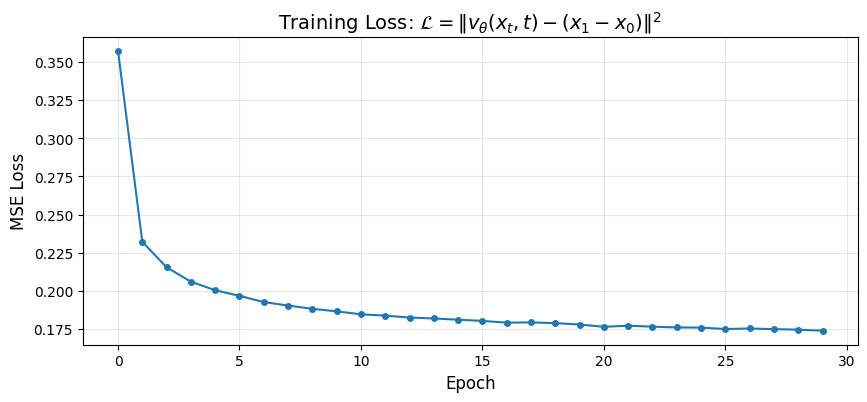

Final loss: 0.1738

Lower loss = better velocity predictions = better generation.


In [9]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title(r'Training Loss: $\mathcal{L} = \|v_\theta(x_t, t) - (x_1 - x_0)\|^2$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print("\nLower loss = better velocity predictions = better generation.")

## Step 6: Generating New Images

Now for the exciting part - using our trained model to generate new digits from scratch!

### The Sampling ODE

We solve:
$$\frac{dx}{dt} = v_\theta(x, t)$$

**Starting point**: $x_1 \sim \mathcal{N}(0, I)$ (pure random noise at $t=1$)

**Goal**: Integrate backward to $t=0$ to get a sample from $p_{\text{data}}$

### Euler Integration

We discretize time into $N$ steps with $\Delta t = 1/N$:

$$x_{t - \Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

At each step:
1. Ask the model: "What's the velocity at this point?"
2. Move in the *opposite* direction (we're going backward in time)
3. Repeat until we reach $t=0$

### Why Backward?

During training, velocities point from data to noise ($x_1 - x_0$).

During sampling, we want the reverse - from noise to data - so we:
- Start at $t=1$ (noise)
- Subtract the velocity (opposite direction)
- End at $t=0$ (data)

Generating 64 new digits from random noise...
(Starting at t=1, integrating backward to t=0)



Sampling:   0%|                                                                                     | 0/50 [00:00<?, ?it/s]

Sampling:  68%|███████████████████████████████████████████████████                        | 34/50 [00:00<00:00, 332.86it/s]

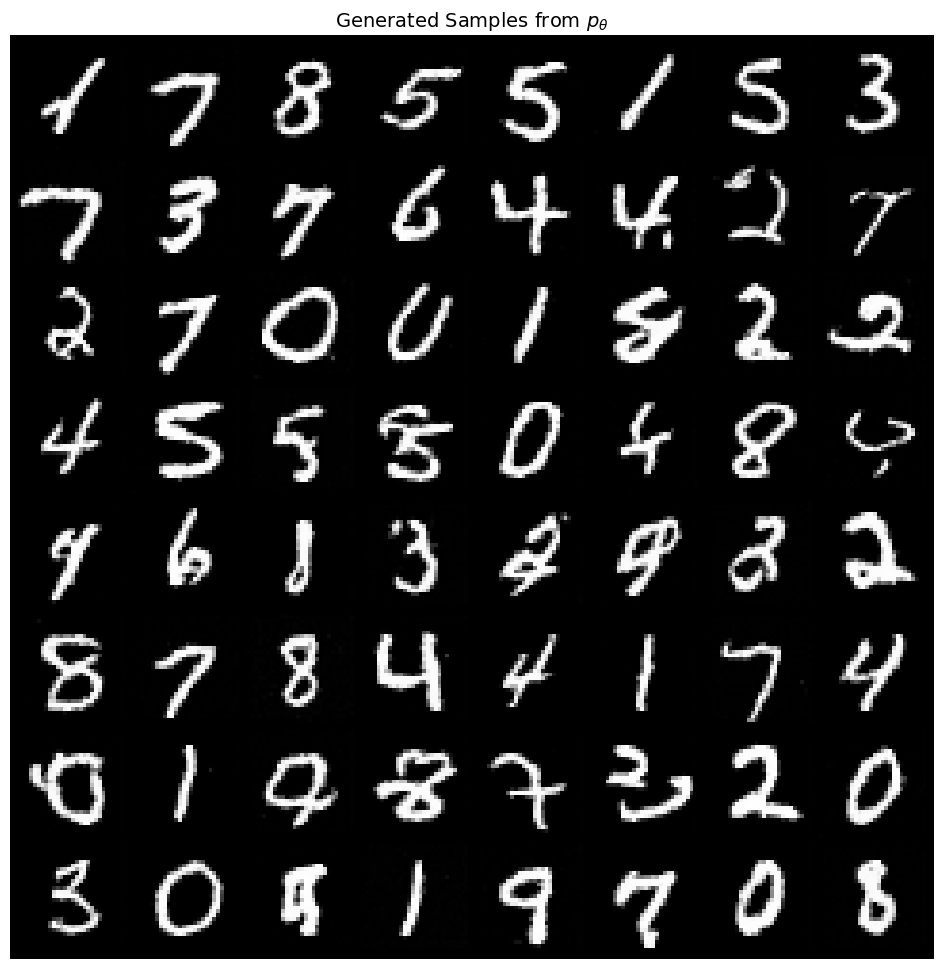

In [10]:
from from_noise_to_images.sampling import sample

# Generate samples
model.eval()

print("Generating 64 new digits from random noise...")
print("(Starting at t=1, integrating backward to t=0)")
print()

with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,      # Number of Euler steps
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="Generated Samples from $p_{\\theta}$")

## Step 7: Visualizing the Generation Process

Let's watch how noise transforms into digits step by step.

This shows the ODE integration in action:
- $t=1.00$: Pure noise $x_1 \sim \mathcal{N}(0, I)$
- $t \to 0$: Following $-v_\theta(x, t)$ backward
- $t=0.00$: Generated digit

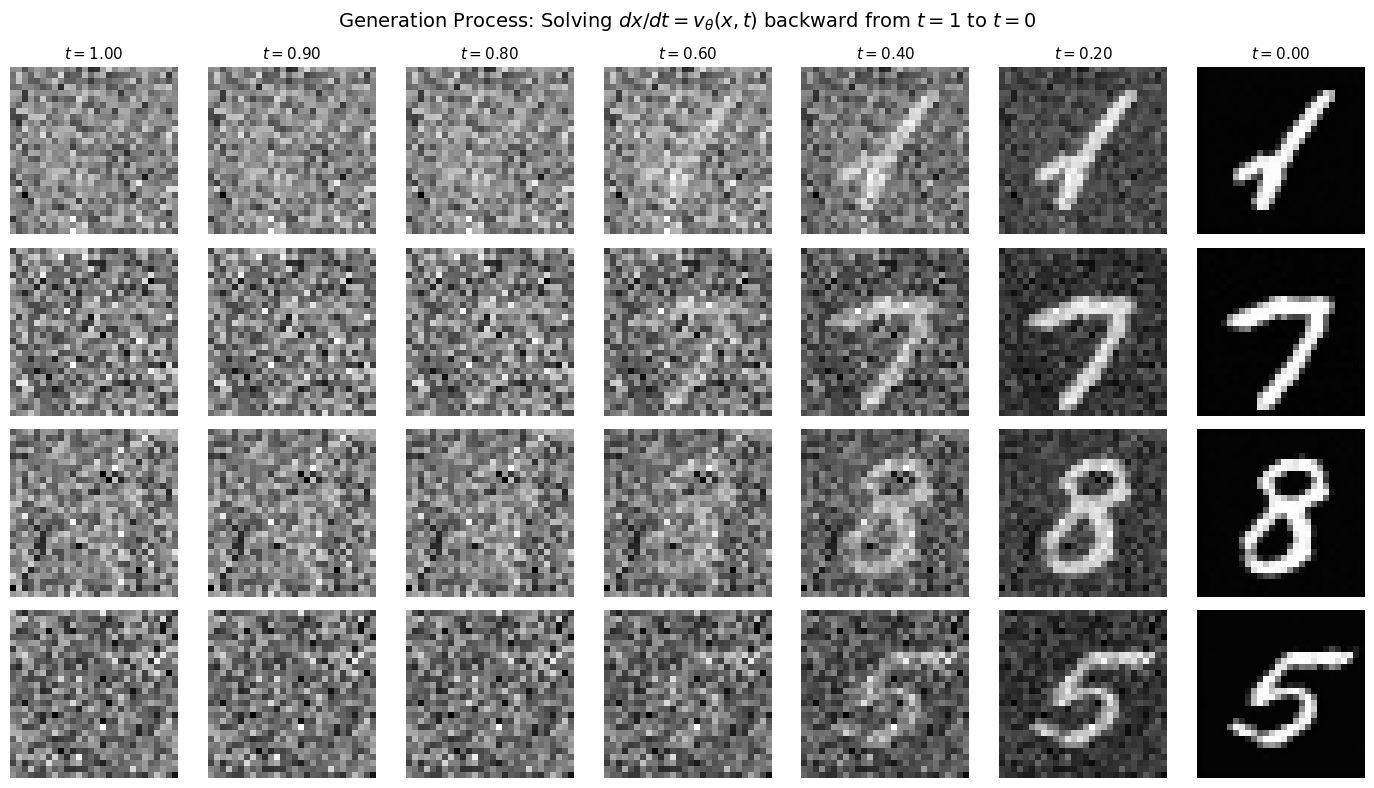


Watch how structure emerges:
• t≈1.0: Random noise (no discernible pattern)
• t≈0.6: Large-scale structure appears (rough digit shape)
• t≈0.3: Details emerge (strokes, curves)
• t=0.0: Final digit


In [11]:
# Show the trajectory for a few samples
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]  # Which steps to visualize

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = trajectory[step_idx][row, 0]
        img = (img + 1) / 2  # Denormalize
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f'$t={t_val:.2f}$', fontsize=11)

plt.suptitle('Generation Process: Solving $dx/dt = v_\\theta(x, t)$ backward from $t=1$ to $t=0$', fontsize=14)
plt.tight_layout()
plt.show()

print("\nWatch how structure emerges:")
print("• t≈1.0: Random noise (no discernible pattern)")
print("• t≈0.6: Large-scale structure appears (rough digit shape)")
print("• t≈0.3: Details emerge (strokes, curves)")
print("• t=0.0: Final digit")

## Step 8: Analyzing What the Model Learned

Let's examine how well the model predicts velocities. Remember: the model only sees $x_t$ and $t$, but must predict $v = x_1 - x_0$. It can't know the *exact* $x_1$ used (since that's random), so it learns to predict the *expected* velocity given the noisy input.

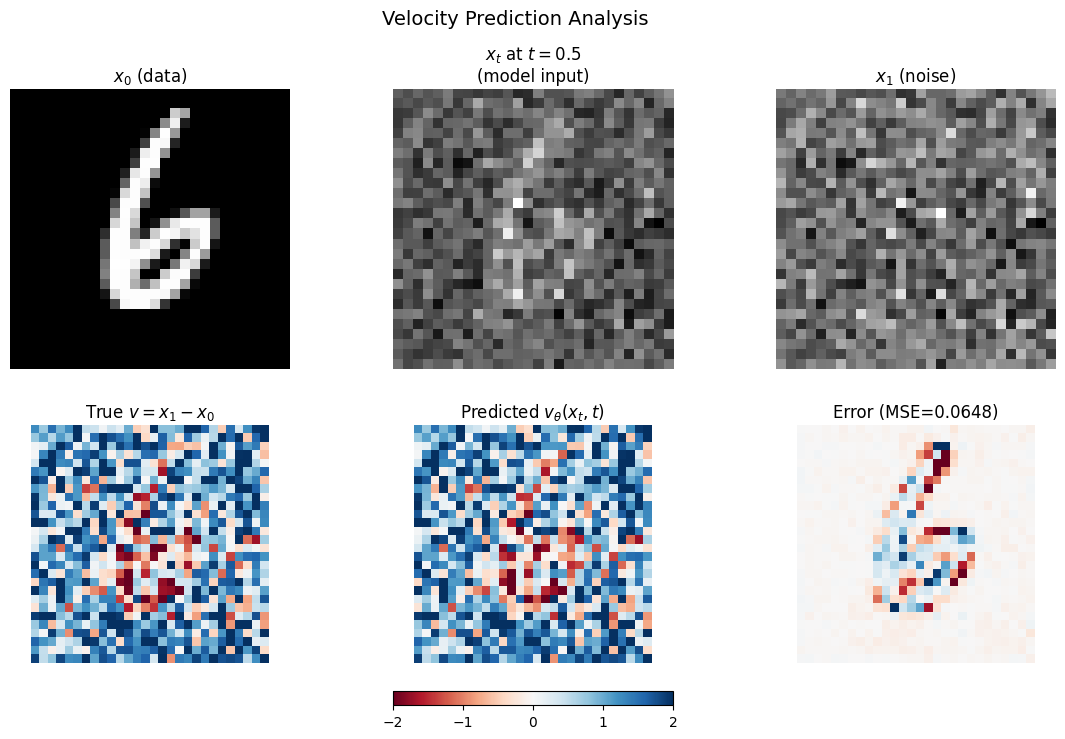


The model sees only x_t and t, but must predict v = x_1 - x_0.
It can't know the exact x_1 used, so it predicts the expected velocity.
The prediction captures overall structure even if not pixel-perfect.


In [12]:
# Compare predicted vs true velocity
x_0 = sample_batch[0:1].to(device)
x_1 = torch.randn_like(x_0)
t = torch.tensor([0.5], device=device)

# True velocity
true_v = x_1 - x_0

# Interpolated sample
x_t = (1 - t.view(-1, 1, 1, 1)) * x_0 + t.view(-1, 1, 1, 1) * x_1

# Predicted velocity
model.eval()
with torch.no_grad():
    pred_v = model(x_t, t)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Top row: the samples
axes[0, 0].imshow((x_0[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 0].set_title('$x_0$ (data)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow((x_t[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 1].set_title('$x_t$ at $t=0.5$\n(model input)', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow((x_1[0, 0].cpu() + 1) / 2, cmap='gray')
axes[0, 2].set_title('$x_1$ (noise)', fontsize=12)
axes[0, 2].axis('off')

# Bottom row: velocities
vmin, vmax = -2, 2

im = axes[1, 0].imshow(true_v[0, 0].cpu(), cmap='RdBu', vmin=vmin, vmax=vmax)
axes[1, 0].set_title('True $v = x_1 - x_0$', fontsize=12)
axes[1, 0].axis('off')

axes[1, 1].imshow(pred_v[0, 0].cpu(), cmap='RdBu', vmin=vmin, vmax=vmax)
axes[1, 1].set_title('Predicted $v_\\theta(x_t, t)$', fontsize=12)
axes[1, 1].axis('off')

error = (pred_v - true_v)[0, 0].cpu()
axes[1, 2].imshow(error, cmap='RdBu', vmin=-1, vmax=1)
axes[1, 2].set_title(f'Error (MSE={torch.mean(error**2):.4f})', fontsize=12)
axes[1, 2].axis('off')

plt.colorbar(im, ax=axes[1, :], orientation='horizontal', fraction=0.05, pad=0.1)
plt.suptitle('Velocity Prediction Analysis', fontsize=14)
plt.show()

print("\nThe model sees only x_t and t, but must predict v = x_1 - x_0.")
print("It can't know the exact x_1 used, so it predicts the expected velocity.")
print("The prediction captures overall structure even if not pixel-perfect.")

In [13]:
# Save the trained model for use in the next notebook
trainer.save_checkpoint("phase1_model.pt")
print("Model saved to phase1_model.pt")

Model saved to phase1_model.pt


## Summary: The Flow Matching Recipe

We've built a complete generative model using flow matching. Here's the recipe:

### The Framework

| Step | What Happens |
|------|-------------|
| **1. Define the path** | Linear interpolation $x_t = (1-t)x_0 + tx_1$ |
| **2. Compute velocity** | Constant $v = x_1 - x_0$ |
| **3. Train** | Learn $v_\theta(x_t, t) \approx v$ via MSE |
| **4. Sample** | Solve ODE backward from $t=1$ to $t=0$ |

### Key Mathematical Insights

| Concept | Why It Matters |
|---------|---------------|
| **Linear interpolation** | Simplest path, constant velocity, optimal transport |
| **Constant velocity** | No acceleration = efficient integration |
| **MSE loss** | Directly measures velocity prediction quality |
| **Deterministic ODE** | Unlike DDPM, no stochastic noise during sampling |

### Limitations (So Far)

- **Unconditional**: We can't control which digit gets generated
- **CNN architecture**: U-Net works but doesn't scale as well as transformers
- **Small scale**: More training and larger models would help quality

## What's Next

In the following notebooks, we'll address these limitations:

**Notebook 02: Diffusion Transformer (DiT)**
- Replace the U-Net with a transformer
- Patchify images into sequences
- Use adaptive layer normalization (adaLN) for conditioning

**Notebook 03: Class Conditioning**
- Control which digit gets generated
- Classifier-free guidance for stronger conditioning

**Notebook 04: Text Conditioning**
- CLIP text encoder integration
- Cross-attention for text-to-image

**Notebook 05: Latent Diffusion**
- Work in compressed latent space
- VAE encoder/decoder
- The Stable Diffusion approach